In [1]:
xfile = 'C:\workspace\j6stock\XOpenHighLowCloseVol_tp10_cl10.txt'
lstm_size = 100         # 3600 = 5 days
lstm_layers = 2        # Number of layers
batch_size = 2048       # Batch size
learning_rate = 0.001  #0.0001  # Learning rate (default is 0.001)
epochs = 2000

# Fixed
#amount_of_features_cvs = 5 # cvs with prefix with feature column
#n_channels = amount_of_features
seq_len = lstm_size
y_column = 6
compute_val_at = 0

In [2]:
import tensorflow as tf
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
import os
from keras import backend as K

Using TensorFlow backend.


In [3]:
def get_stock_data(normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = pd.read_csv(filepath_or_buffer  = xfile )
    #TODO Use previous close instead of open
    df['change'] = df['close'] - df['open']
    for i, row in df.iterrows():
        df.at[i, 'high'] = df.at[i, 'high'] - (df.at[i, 'open'] if df.at[i, 'open'] > df.at[i, 'close'] else df.at[i, 'close'])
        df.at[i, 'low'] = (df.at[i, 'close'] if df.at[i, 'close'] < df.at[i, 'open'] else df.at[i, 'open']) - df.at[i, 'low']
    df.dropna(inplace=True)
    df = df.drop('open', axis=1)
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        #df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
        df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
        df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
        #df['vol'] = min_max_scaler.fit_transform(df.vol.values.reshape(-1,1))
        df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
        #df['change'] = min_max_scaler.fit_transform(df['change'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))  
    df.dropna(inplace=True)
               
    # Move y_result to the rightmost for the ease of training
    adj_close = df['y_result']
    df.drop(labels=['y_result'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

In [4]:
df = get_stock_data( ma=[50, 100, 200])
amount_of_features = len(df.columns)-1

In [5]:
def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['close'], color='red', label='Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['change'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(df['high'], color='red', label='high')
    ax1.legend(loc='best')
 
    ax2.plot(df['low'], color='red', label='low')
    ax2.legend(loc='best')
    plt.show()

             high           low     close    change      50ma     100ma  \
199  4.445337e-14  6.182380e-03  0.357085 -0.000150  0.351429  0.351070   
200  2.002002e-03  1.545595e-02  0.356606 -0.000060  0.351433  0.351063   
201  1.301301e-02  7.727975e-03  0.356893  0.000035  0.351445  0.351060   
202  4.445337e-14  1.545595e-03  0.357133  0.000015  0.351502  0.351082   
203  6.006006e-03  6.863821e-14  0.358138  0.000095  0.351587  0.351141   

        200ma  y_result  
199  0.346428         0  
200  0.346426         0  
201  0.346424         0  
202  0.346433         0  
203  0.346448         0  


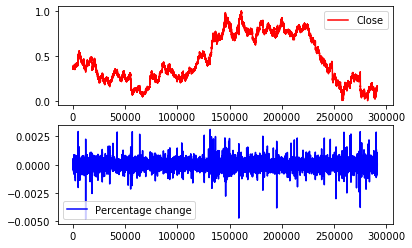

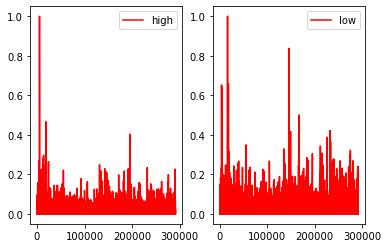

In [6]:
plot_stock(df)

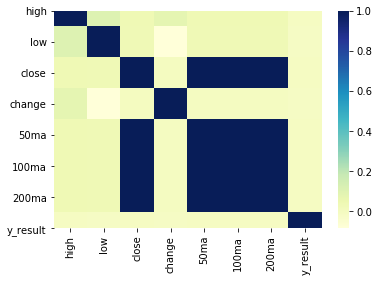

In [7]:
corr = df.corr()
ax = sns.heatmap(corr, cmap="YlGnBu")
plt.show()

In [8]:
def load_data(stock, seq_len):
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    x_result = []
    y_result = []
    for index in range(seq_len, len(data) ): # maxmimum date = lastest date - sequence length
        x_result.append(data[index-seq_len: index,:-1]) # index : index + 22days
        y_result.append(data[index ,amount_of_features]);

    #print('---', data[0])
    #print('---', x_result[0])
    #print('---', y_result[0])
    x_result = np.array(x_result)
    y_result = np.array(y_result)
    row = round(0.6 * y_result.shape[0]) # 80% split
    print ("Amount of training data = {}".format(0.9 * x_result.shape[0]))
    print ("Amount of testing data = {}".format(0.1 * y_result.shape[0]))
     
    X_train = x_result[:int(row), :] # 90% date
    y_train = y_result[:int(row)] # 90% date
        

    X_test = x_result[int(row):, :]
    y_test = y_result[int(row):]
    # filter for 1 and -1 for validation only
    X_test = X_test[y_test[:]!=0,:]
    y_test = y_test[y_test[:]!=0]
    #print(result.shape[0], len(y_result), int(row), y_result[int(row):])
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features-1))
    #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features-1))
    
    return [X_train, y_train, X_test, y_test]

In [9]:
lb = preprocessing.LabelBinarizer()
lb.fit([1, 0, -1])

X_tr, lab_tr, X_vld, lab_vld = load_data(df, seq_len)
y_tr = lb.transform(lab_tr)
y_vld = lb.transform(lab_vld)
print(X_tr.shape, lab_tr.shape, X_vld.shape, lab_vld.shape)
print(amount_of_features)

Amount of features = 7


C:\Users\Admin\Anaconda3\envs\j6stock-deeplearning\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Amount of training data = 261936.9
Amount of testing data = 29104.100000000002
(174625, 100, 7) (174625,) (70634, 100, 7) (70634,)
7


In [10]:
def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]

In [11]:
graph = tf.Graph()
n_channels = amount_of_features
n_classes = lb.transform([1]).shape[1]
# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct inputs to LSTM

In [12]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


Define forward pass, cost function and optimizer:

In [13]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [14]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints

In [15]:
interation_compute_val = 40
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    # Uncomment if there restore
    saver.restore(sess, "checkpoints/har-lstm.ckpt")
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%interation_compute_val == compute_val_at):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints/har-lstm.ckpt")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints/har-lstm.ckpt
Epoch: 0/2000 Iteration: 5 Train loss: 0.915438 Train acc: 0.602539
Epoch: 0/2000 Iteration: 10 Train loss: 0.933404 Train acc: 0.583008
Epoch: 0/2000 Iteration: 15 Train loss: 0.995583 Train acc: 0.523926
Epoch: 0/2000 Iteration: 20 Train loss: 0.891266 Train acc: 0.591309
Epoch: 0/2000 Iteration: 25 Train loss: 1.116654 Train acc: 0.423340
Epoch: 0/2000 Iteration: 30 Train loss: 0.844966 Train acc: 0.632812
Epoch: 0/2000 Iteration: 35 Train loss: 0.772398 Train acc: 0.668945
Epoch: 0/2000 Iteration: 40 Train loss: 0.857262 Train acc: 0.685059
Epoch: 0/2000 Iteration: 40 Validation loss: 1.056919 Validation acc: 0.403220
Epoch: 0/2000 Iteration: 45 Train loss: 0.964216 Train acc: 0.522949
Epoch: 0/2000 Iteration: 50 Train loss: 0.844426 Train acc: 0.642578
Epoch: 0/2000 Iteration: 55 Train loss: 0.872530 Train acc: 0.632324
Epoch: 0

Epoch: 5/2000 Iteration: 495 Train loss: 0.977698 Train acc: 0.451172
Epoch: 5/2000 Iteration: 500 Train loss: 0.888812 Train acc: 0.485840
Epoch: 5/2000 Iteration: 505 Train loss: 0.995264 Train acc: 0.506836
Epoch: 5/2000 Iteration: 510 Train loss: 1.037684 Train acc: 0.442383
Epoch: 6/2000 Iteration: 515 Train loss: 0.896659 Train acc: 0.634766
Epoch: 6/2000 Iteration: 520 Train loss: 0.948618 Train acc: 0.584473
Epoch: 6/2000 Iteration: 520 Validation loss: 1.069494 Validation acc: 0.364631
Epoch: 6/2000 Iteration: 525 Train loss: 1.026308 Train acc: 0.479004
Epoch: 6/2000 Iteration: 530 Train loss: 0.915018 Train acc: 0.596191
Epoch: 6/2000 Iteration: 535 Train loss: 1.105091 Train acc: 0.387695
Epoch: 6/2000 Iteration: 540 Train loss: 0.855511 Train acc: 0.619141
Epoch: 6/2000 Iteration: 545 Train loss: 0.758394 Train acc: 0.714844
Epoch: 6/2000 Iteration: 550 Train loss: 0.873652 Train acc: 0.670410
Epoch: 6/2000 Iteration: 555 Train loss: 0.963059 Train acc: 0.527832
Epoch: 6/2

Epoch: 11/2000 Iteration: 1005 Train loss: 0.961181 Train acc: 0.452637
Epoch: 11/2000 Iteration: 1010 Train loss: 0.911390 Train acc: 0.476074
Epoch: 11/2000 Iteration: 1015 Train loss: 1.014984 Train acc: 0.501465
Epoch: 11/2000 Iteration: 1020 Train loss: 1.038424 Train acc: 0.434082
Epoch: 12/2000 Iteration: 1025 Train loss: 0.886955 Train acc: 0.633789
Epoch: 12/2000 Iteration: 1030 Train loss: 0.919939 Train acc: 0.587402
Epoch: 12/2000 Iteration: 1035 Train loss: 0.983616 Train acc: 0.540527
Epoch: 12/2000 Iteration: 1040 Train loss: 0.877822 Train acc: 0.618652
Epoch: 12/2000 Iteration: 1040 Validation loss: 1.051725 Validation acc: 0.424848
Epoch: 12/2000 Iteration: 1045 Train loss: 1.078261 Train acc: 0.392578
Epoch: 12/2000 Iteration: 1050 Train loss: 0.803483 Train acc: 0.660156
Epoch: 12/2000 Iteration: 1055 Train loss: 0.751846 Train acc: 0.706055
Epoch: 12/2000 Iteration: 1060 Train loss: 0.804627 Train acc: 0.695312
Epoch: 12/2000 Iteration: 1065 Train loss: 0.933010 Tr

Epoch: 17/2000 Iteration: 1510 Train loss: 0.950940 Train acc: 0.474121
Epoch: 17/2000 Iteration: 1515 Train loss: 0.950810 Train acc: 0.490723
Epoch: 17/2000 Iteration: 1520 Train loss: 0.952703 Train acc: 0.441406
Epoch: 17/2000 Iteration: 1520 Validation loss: 1.289458 Validation acc: 0.303309
Epoch: 17/2000 Iteration: 1525 Train loss: 1.013483 Train acc: 0.487793
Epoch: 17/2000 Iteration: 1530 Train loss: 0.960247 Train acc: 0.522949
Epoch: 18/2000 Iteration: 1535 Train loss: 0.867543 Train acc: 0.655273
Epoch: 18/2000 Iteration: 1540 Train loss: 0.930824 Train acc: 0.579590
Epoch: 18/2000 Iteration: 1545 Train loss: 0.966886 Train acc: 0.572754
Epoch: 18/2000 Iteration: 1550 Train loss: 0.861816 Train acc: 0.609375
Epoch: 18/2000 Iteration: 1555 Train loss: 1.091670 Train acc: 0.416992
Epoch: 18/2000 Iteration: 1560 Train loss: 0.792559 Train acc: 0.661621
Epoch: 18/2000 Iteration: 1560 Validation loss: 1.106673 Validation acc: 0.411736
Epoch: 18/2000 Iteration: 1565 Train loss: 0

Epoch: 23/2000 Iteration: 2005 Train loss: 0.853242 Train acc: 0.652344
Epoch: 23/2000 Iteration: 2010 Train loss: 0.866957 Train acc: 0.649414
Epoch: 23/2000 Iteration: 2015 Train loss: 1.103388 Train acc: 0.428223
Epoch: 23/2000 Iteration: 2020 Train loss: 0.893751 Train acc: 0.516113
Epoch: 23/2000 Iteration: 2025 Train loss: 0.952780 Train acc: 0.491699
Epoch: 23/2000 Iteration: 2030 Train loss: 0.863554 Train acc: 0.511719
Epoch: 23/2000 Iteration: 2035 Train loss: 1.001699 Train acc: 0.458496
Epoch: 23/2000 Iteration: 2040 Train loss: 0.948015 Train acc: 0.518066
Epoch: 23/2000 Iteration: 2040 Validation loss: 1.292445 Validation acc: 0.306655
Epoch: 24/2000 Iteration: 2045 Train loss: 0.858080 Train acc: 0.639160
Epoch: 24/2000 Iteration: 2050 Train loss: 0.911127 Train acc: 0.591797
Epoch: 24/2000 Iteration: 2055 Train loss: 0.956022 Train acc: 0.582520
Epoch: 24/2000 Iteration: 2060 Train loss: 0.910004 Train acc: 0.581543
Epoch: 24/2000 Iteration: 2065 Train loss: 1.062640 Tr

Epoch: 29/2000 Iteration: 2510 Train loss: 0.875142 Train acc: 0.583984
Epoch: 29/2000 Iteration: 2515 Train loss: 0.846581 Train acc: 0.643066
Epoch: 29/2000 Iteration: 2520 Train loss: 0.860787 Train acc: 0.636719
Epoch: 29/2000 Iteration: 2520 Validation loss: 1.131843 Validation acc: 0.386934
Epoch: 29/2000 Iteration: 2525 Train loss: 1.092667 Train acc: 0.484375
Epoch: 29/2000 Iteration: 2530 Train loss: 0.886724 Train acc: 0.506348
Epoch: 29/2000 Iteration: 2535 Train loss: 0.946114 Train acc: 0.508301
Epoch: 29/2000 Iteration: 2540 Train loss: 0.862856 Train acc: 0.521484
Epoch: 29/2000 Iteration: 2545 Train loss: 0.984697 Train acc: 0.512695
Epoch: 29/2000 Iteration: 2550 Train loss: 0.959730 Train acc: 0.494629
Epoch: 30/2000 Iteration: 2555 Train loss: 0.904415 Train acc: 0.626953
Epoch: 30/2000 Iteration: 2560 Train loss: 0.912118 Train acc: 0.594727
Epoch: 30/2000 Iteration: 2560 Validation loss: 1.180954 Validation acc: 0.345919
Epoch: 30/2000 Iteration: 2565 Train loss: 0

Epoch: 35/2000 Iteration: 3005 Train loss: 0.775851 Train acc: 0.684570
Epoch: 35/2000 Iteration: 3010 Train loss: 0.660454 Train acc: 0.753906
Epoch: 35/2000 Iteration: 3015 Train loss: 0.775662 Train acc: 0.723633
Epoch: 35/2000 Iteration: 3020 Train loss: 0.819232 Train acc: 0.616699
Epoch: 35/2000 Iteration: 3025 Train loss: 0.844596 Train acc: 0.647461
Epoch: 35/2000 Iteration: 3030 Train loss: 0.824964 Train acc: 0.647949
Epoch: 35/2000 Iteration: 3035 Train loss: 1.053114 Train acc: 0.464844
Epoch: 35/2000 Iteration: 3040 Train loss: 0.970748 Train acc: 0.467285
Epoch: 35/2000 Iteration: 3040 Validation loss: 1.269408 Validation acc: 0.362391
Epoch: 35/2000 Iteration: 3045 Train loss: 0.920058 Train acc: 0.502930
Epoch: 35/2000 Iteration: 3050 Train loss: 0.911333 Train acc: 0.486816
Epoch: 35/2000 Iteration: 3055 Train loss: 0.943202 Train acc: 0.549805
Epoch: 35/2000 Iteration: 3060 Train loss: 0.939585 Train acc: 0.538574
Epoch: 36/2000 Iteration: 3065 Train loss: 0.842715 Tr

Epoch: 41/2000 Iteration: 3510 Train loss: 1.036506 Train acc: 0.446289
Epoch: 41/2000 Iteration: 3515 Train loss: 0.770309 Train acc: 0.683594
Epoch: 41/2000 Iteration: 3520 Train loss: 0.627446 Train acc: 0.760254
Epoch: 41/2000 Iteration: 3520 Validation loss: 1.175272 Validation acc: 0.373980
Epoch: 41/2000 Iteration: 3525 Train loss: 0.761806 Train acc: 0.731934
Epoch: 41/2000 Iteration: 3530 Train loss: 0.826311 Train acc: 0.612305
Epoch: 41/2000 Iteration: 3535 Train loss: 0.832458 Train acc: 0.641602
Epoch: 41/2000 Iteration: 3540 Train loss: 0.851073 Train acc: 0.630859
Epoch: 41/2000 Iteration: 3545 Train loss: 1.040476 Train acc: 0.476074
Epoch: 41/2000 Iteration: 3550 Train loss: 0.868549 Train acc: 0.528809
Epoch: 41/2000 Iteration: 3555 Train loss: 0.925974 Train acc: 0.502930
Epoch: 41/2000 Iteration: 3560 Train loss: 0.841902 Train acc: 0.535645
Epoch: 41/2000 Iteration: 3560 Validation loss: 1.278890 Validation acc: 0.339298
Epoch: 41/2000 Iteration: 3565 Train loss: 0

Epoch: 47/2000 Iteration: 4005 Train loss: 0.845954 Train acc: 0.617676
Epoch: 47/2000 Iteration: 4010 Train loss: 0.918976 Train acc: 0.596680
Epoch: 47/2000 Iteration: 4015 Train loss: 0.832866 Train acc: 0.622070
Epoch: 47/2000 Iteration: 4020 Train loss: 1.005234 Train acc: 0.475098
Epoch: 47/2000 Iteration: 4025 Train loss: 0.726998 Train acc: 0.706543
Epoch: 47/2000 Iteration: 4030 Train loss: 0.649648 Train acc: 0.743652
Epoch: 47/2000 Iteration: 4035 Train loss: 0.757976 Train acc: 0.716797
Epoch: 47/2000 Iteration: 4040 Train loss: 0.814839 Train acc: 0.604492
Epoch: 47/2000 Iteration: 4040 Validation loss: 1.224147 Validation acc: 0.378834
Epoch: 47/2000 Iteration: 4045 Train loss: 0.842394 Train acc: 0.650879
Epoch: 47/2000 Iteration: 4050 Train loss: 0.860169 Train acc: 0.637207
Epoch: 47/2000 Iteration: 4055 Train loss: 1.055845 Train acc: 0.478027
Epoch: 47/2000 Iteration: 4060 Train loss: 0.833649 Train acc: 0.556152
Epoch: 47/2000 Iteration: 4065 Train loss: 0.945709 Tr

Epoch: 53/2000 Iteration: 4510 Train loss: 0.849067 Train acc: 0.650879
Epoch: 53/2000 Iteration: 4515 Train loss: 0.835641 Train acc: 0.618164
Epoch: 53/2000 Iteration: 4520 Train loss: 0.831918 Train acc: 0.633301
Epoch: 53/2000 Iteration: 4520 Validation loss: 1.394305 Validation acc: 0.303955
Epoch: 53/2000 Iteration: 4525 Train loss: 0.787799 Train acc: 0.625977
Epoch: 53/2000 Iteration: 4530 Train loss: 1.008249 Train acc: 0.504395
Epoch: 53/2000 Iteration: 4535 Train loss: 0.704581 Train acc: 0.698242
Epoch: 53/2000 Iteration: 4540 Train loss: 0.609762 Train acc: 0.791016
Epoch: 53/2000 Iteration: 4545 Train loss: 0.751257 Train acc: 0.741211
Epoch: 53/2000 Iteration: 4550 Train loss: 0.790180 Train acc: 0.626953
Epoch: 53/2000 Iteration: 4555 Train loss: 0.811458 Train acc: 0.670410
Epoch: 53/2000 Iteration: 4560 Train loss: 0.840991 Train acc: 0.633789
Epoch: 53/2000 Iteration: 4560 Validation loss: 1.371995 Validation acc: 0.322438
Epoch: 53/2000 Iteration: 4565 Train loss: 1

Epoch: 58/2000 Iteration: 5005 Train loss: 0.840346 Train acc: 0.560059
Epoch: 58/2000 Iteration: 5010 Train loss: 0.963296 Train acc: 0.520020
Epoch: 58/2000 Iteration: 5015 Train loss: 1.036422 Train acc: 0.476074
Epoch: 59/2000 Iteration: 5020 Train loss: 0.848745 Train acc: 0.638672
Epoch: 59/2000 Iteration: 5025 Train loss: 0.827101 Train acc: 0.627930
Epoch: 59/2000 Iteration: 5030 Train loss: 0.814325 Train acc: 0.648438
Epoch: 59/2000 Iteration: 5035 Train loss: 0.792131 Train acc: 0.628418
Epoch: 59/2000 Iteration: 5040 Train loss: 0.995132 Train acc: 0.504395
Epoch: 59/2000 Iteration: 5040 Validation loss: 1.315257 Validation acc: 0.311322
Epoch: 59/2000 Iteration: 5045 Train loss: 0.666802 Train acc: 0.730469
Epoch: 59/2000 Iteration: 5050 Train loss: 0.620212 Train acc: 0.781738
Epoch: 59/2000 Iteration: 5055 Train loss: 0.789029 Train acc: 0.706543
Epoch: 59/2000 Iteration: 5060 Train loss: 0.783265 Train acc: 0.632324
Epoch: 59/2000 Iteration: 5065 Train loss: 0.799597 Tr

Epoch: 64/2000 Iteration: 5510 Train loss: 0.888122 Train acc: 0.542480
Epoch: 64/2000 Iteration: 5515 Train loss: 0.799506 Train acc: 0.579590
Epoch: 64/2000 Iteration: 5520 Train loss: 0.952504 Train acc: 0.564941
Epoch: 64/2000 Iteration: 5520 Validation loss: 1.311367 Validation acc: 0.375460
Epoch: 64/2000 Iteration: 5525 Train loss: 1.046888 Train acc: 0.465332
Epoch: 65/2000 Iteration: 5530 Train loss: 0.848682 Train acc: 0.652344
Epoch: 65/2000 Iteration: 5535 Train loss: 0.834879 Train acc: 0.602539
Epoch: 65/2000 Iteration: 5540 Train loss: 0.842839 Train acc: 0.627441
Epoch: 65/2000 Iteration: 5545 Train loss: 0.807841 Train acc: 0.629395
Epoch: 65/2000 Iteration: 5550 Train loss: 1.009190 Train acc: 0.495605
Epoch: 65/2000 Iteration: 5555 Train loss: 0.659701 Train acc: 0.742188
Epoch: 65/2000 Iteration: 5560 Train loss: 0.544970 Train acc: 0.822754
Epoch: 65/2000 Iteration: 5560 Validation loss: 1.315752 Validation acc: 0.299934
Epoch: 65/2000 Iteration: 5565 Train loss: 0

Epoch: 70/2000 Iteration: 6005 Train loss: 0.831098 Train acc: 0.650391
Epoch: 70/2000 Iteration: 6010 Train loss: 1.034043 Train acc: 0.445801
Epoch: 70/2000 Iteration: 6015 Train loss: 0.852189 Train acc: 0.547363
Epoch: 70/2000 Iteration: 6020 Train loss: 0.889673 Train acc: 0.541992
Epoch: 70/2000 Iteration: 6025 Train loss: 0.780835 Train acc: 0.593750
Epoch: 70/2000 Iteration: 6030 Train loss: 0.955872 Train acc: 0.521484
Epoch: 70/2000 Iteration: 6035 Train loss: 1.020166 Train acc: 0.493164
Epoch: 71/2000 Iteration: 6040 Train loss: 0.884244 Train acc: 0.584473
Epoch: 71/2000 Iteration: 6040 Validation loss: 1.338647 Validation acc: 0.353286
Epoch: 71/2000 Iteration: 6045 Train loss: 0.843333 Train acc: 0.621094
Epoch: 71/2000 Iteration: 6050 Train loss: 0.834171 Train acc: 0.633301
Epoch: 71/2000 Iteration: 6055 Train loss: 0.804570 Train acc: 0.633301
Epoch: 71/2000 Iteration: 6060 Train loss: 0.984183 Train acc: 0.523926
Epoch: 71/2000 Iteration: 6065 Train loss: 0.662205 Tr

Epoch: 76/2000 Iteration: 6510 Train loss: 0.815885 Train acc: 0.671875
Epoch: 76/2000 Iteration: 6515 Train loss: 0.807575 Train acc: 0.672363
Epoch: 76/2000 Iteration: 6520 Train loss: 1.018933 Train acc: 0.444824
Epoch: 76/2000 Iteration: 6520 Validation loss: 1.442554 Validation acc: 0.299848
Epoch: 76/2000 Iteration: 6525 Train loss: 0.848002 Train acc: 0.564453
Epoch: 76/2000 Iteration: 6530 Train loss: 0.884839 Train acc: 0.536621
Epoch: 76/2000 Iteration: 6535 Train loss: 0.804458 Train acc: 0.598145
Epoch: 76/2000 Iteration: 6540 Train loss: 0.936223 Train acc: 0.537598
Epoch: 76/2000 Iteration: 6545 Train loss: 0.951121 Train acc: 0.525879
Epoch: 77/2000 Iteration: 6550 Train loss: 0.861641 Train acc: 0.619629
Epoch: 77/2000 Iteration: 6555 Train loss: 0.799834 Train acc: 0.627930
Epoch: 77/2000 Iteration: 6560 Train loss: 0.801969 Train acc: 0.635742
Epoch: 77/2000 Iteration: 6560 Validation loss: 1.380198 Validation acc: 0.334142
Epoch: 77/2000 Iteration: 6565 Train loss: 0

Epoch: 82/2000 Iteration: 7005 Train loss: 0.509568 Train acc: 0.833496
Epoch: 82/2000 Iteration: 7010 Train loss: 0.701134 Train acc: 0.748047
Epoch: 82/2000 Iteration: 7015 Train loss: 0.753205 Train acc: 0.653320
Epoch: 82/2000 Iteration: 7020 Train loss: 0.863438 Train acc: 0.635742
Epoch: 82/2000 Iteration: 7025 Train loss: 0.790777 Train acc: 0.684082
Epoch: 82/2000 Iteration: 7030 Train loss: 0.987130 Train acc: 0.487793
Epoch: 82/2000 Iteration: 7035 Train loss: 0.802678 Train acc: 0.612305
Epoch: 82/2000 Iteration: 7040 Train loss: 0.867015 Train acc: 0.537109
Epoch: 82/2000 Iteration: 7040 Validation loss: 1.360579 Validation acc: 0.319853
Epoch: 82/2000 Iteration: 7045 Train loss: 0.749466 Train acc: 0.622070
Epoch: 82/2000 Iteration: 7050 Train loss: 0.917590 Train acc: 0.548828
Epoch: 82/2000 Iteration: 7055 Train loss: 0.962648 Train acc: 0.518555
Epoch: 83/2000 Iteration: 7060 Train loss: 0.817266 Train acc: 0.651855
Epoch: 83/2000 Iteration: 7065 Train loss: 0.820039 Tr

Epoch: 88/2000 Iteration: 7510 Train loss: 0.646219 Train acc: 0.745605
Epoch: 88/2000 Iteration: 7515 Train loss: 0.456938 Train acc: 0.857422
Epoch: 88/2000 Iteration: 7520 Train loss: 0.673344 Train acc: 0.770020
Epoch: 88/2000 Iteration: 7520 Validation loss: 1.293574 Validation acc: 0.378590
Epoch: 88/2000 Iteration: 7525 Train loss: 0.744783 Train acc: 0.663086
Epoch: 88/2000 Iteration: 7530 Train loss: 0.806119 Train acc: 0.672363
Epoch: 88/2000 Iteration: 7535 Train loss: 0.777530 Train acc: 0.702637
Epoch: 88/2000 Iteration: 7540 Train loss: 1.024840 Train acc: 0.513184
Epoch: 88/2000 Iteration: 7545 Train loss: 0.816692 Train acc: 0.582520
Epoch: 88/2000 Iteration: 7550 Train loss: 0.871462 Train acc: 0.534668
Epoch: 88/2000 Iteration: 7555 Train loss: 0.746530 Train acc: 0.616699
Epoch: 88/2000 Iteration: 7560 Train loss: 0.891923 Train acc: 0.560547
Epoch: 88/2000 Iteration: 7560 Validation loss: 1.420045 Validation acc: 0.337934
Epoch: 88/2000 Iteration: 7565 Train loss: 0

Epoch: 94/2000 Iteration: 8005 Train loss: 0.757221 Train acc: 0.662598
Epoch: 94/2000 Iteration: 8010 Train loss: 0.765172 Train acc: 0.674316
Epoch: 94/2000 Iteration: 8015 Train loss: 0.990357 Train acc: 0.505371
Epoch: 94/2000 Iteration: 8020 Train loss: 0.630650 Train acc: 0.756836
Epoch: 94/2000 Iteration: 8025 Train loss: 0.423159 Train acc: 0.858887
Epoch: 94/2000 Iteration: 8030 Train loss: 0.630314 Train acc: 0.788086
Epoch: 94/2000 Iteration: 8035 Train loss: 0.762375 Train acc: 0.657227
Epoch: 94/2000 Iteration: 8040 Train loss: 0.808375 Train acc: 0.683105
Epoch: 94/2000 Iteration: 8040 Validation loss: 1.387803 Validation acc: 0.363525
Epoch: 94/2000 Iteration: 8045 Train loss: 0.763787 Train acc: 0.703613
Epoch: 94/2000 Iteration: 8050 Train loss: 0.961133 Train acc: 0.572754
Epoch: 94/2000 Iteration: 8055 Train loss: 0.770863 Train acc: 0.627930
Epoch: 94/2000 Iteration: 8060 Train loss: 0.808959 Train acc: 0.610840
Epoch: 94/2000 Iteration: 8065 Train loss: 0.770445 Tr

Epoch: 100/2000 Iteration: 8510 Train loss: 0.750830 Train acc: 0.659668
Epoch: 100/2000 Iteration: 8515 Train loss: 0.769241 Train acc: 0.674805
Epoch: 100/2000 Iteration: 8520 Train loss: 0.722804 Train acc: 0.685059
Epoch: 100/2000 Iteration: 8520 Validation loss: 1.402341 Validation acc: 0.378518
Epoch: 100/2000 Iteration: 8525 Train loss: 0.953623 Train acc: 0.525391
Epoch: 100/2000 Iteration: 8530 Train loss: 0.720366 Train acc: 0.732422
Epoch: 100/2000 Iteration: 8535 Train loss: 0.554490 Train acc: 0.802246
Epoch: 100/2000 Iteration: 8540 Train loss: 0.646894 Train acc: 0.776855
Epoch: 100/2000 Iteration: 8545 Train loss: 0.746301 Train acc: 0.652832
Epoch: 100/2000 Iteration: 8550 Train loss: 0.771307 Train acc: 0.691895
Epoch: 100/2000 Iteration: 8555 Train loss: 0.789134 Train acc: 0.687988
Epoch: 100/2000 Iteration: 8560 Train loss: 1.033013 Train acc: 0.519531
Epoch: 100/2000 Iteration: 8560 Validation loss: 1.375203 Validation acc: 0.370936
Epoch: 100/2000 Iteration: 8565

Epoch: 105/2000 Iteration: 9000 Validation loss: 1.371534 Validation acc: 0.329719
Epoch: 105/2000 Iteration: 9005 Train loss: 0.892034 Train acc: 0.578125
Epoch: 105/2000 Iteration: 9010 Train loss: 0.886366 Train acc: 0.586426
Epoch: 106/2000 Iteration: 9015 Train loss: 0.829027 Train acc: 0.641602
Epoch: 106/2000 Iteration: 9020 Train loss: 0.793148 Train acc: 0.629883
Epoch: 106/2000 Iteration: 9025 Train loss: 0.767218 Train acc: 0.675293
Epoch: 106/2000 Iteration: 9030 Train loss: 0.721385 Train acc: 0.687988
Epoch: 106/2000 Iteration: 9035 Train loss: 0.913478 Train acc: 0.544922
Epoch: 106/2000 Iteration: 9040 Train loss: 0.621217 Train acc: 0.756836
Epoch: 106/2000 Iteration: 9040 Validation loss: 1.309216 Validation acc: 0.385498
Epoch: 106/2000 Iteration: 9045 Train loss: 0.480238 Train acc: 0.838867
Epoch: 106/2000 Iteration: 9050 Train loss: 0.654373 Train acc: 0.762207
Epoch: 106/2000 Iteration: 9055 Train loss: 0.760497 Train acc: 0.652832
Epoch: 106/2000 Iteration: 9060

Epoch: 111/2000 Iteration: 9495 Train loss: 0.950790 Train acc: 0.596680
Epoch: 111/2000 Iteration: 9500 Train loss: 0.829494 Train acc: 0.585938
Epoch: 111/2000 Iteration: 9505 Train loss: 0.848706 Train acc: 0.579590
Epoch: 111/2000 Iteration: 9510 Train loss: 0.807594 Train acc: 0.584961
Epoch: 111/2000 Iteration: 9515 Train loss: 0.904586 Train acc: 0.565430
Epoch: 111/2000 Iteration: 9520 Train loss: 0.911019 Train acc: 0.555176
Epoch: 111/2000 Iteration: 9520 Validation loss: 1.378374 Validation acc: 0.325784
Epoch: 112/2000 Iteration: 9525 Train loss: 0.823370 Train acc: 0.650391
Epoch: 112/2000 Iteration: 9530 Train loss: 0.809061 Train acc: 0.630859
Epoch: 112/2000 Iteration: 9535 Train loss: 0.744741 Train acc: 0.684082
Epoch: 112/2000 Iteration: 9540 Train loss: 0.682986 Train acc: 0.710938
Epoch: 112/2000 Iteration: 9545 Train loss: 0.928685 Train acc: 0.552734
Epoch: 112/2000 Iteration: 9550 Train loss: 0.675117 Train acc: 0.723145
Epoch: 112/2000 Iteration: 9555 Train los

Epoch: 117/2000 Iteration: 9990 Train loss: 0.679386 Train acc: 0.677734
Epoch: 117/2000 Iteration: 9995 Train loss: 0.797515 Train acc: 0.685059
Epoch: 117/2000 Iteration: 10000 Train loss: 0.744551 Train acc: 0.735352
Epoch: 117/2000 Iteration: 10000 Validation loss: 1.327341 Validation acc: 0.387336
Epoch: 117/2000 Iteration: 10005 Train loss: 0.911691 Train acc: 0.606445
Epoch: 117/2000 Iteration: 10010 Train loss: 0.805489 Train acc: 0.589844
Epoch: 117/2000 Iteration: 10015 Train loss: 0.828185 Train acc: 0.563965
Epoch: 117/2000 Iteration: 10020 Train loss: 0.766492 Train acc: 0.613281
Epoch: 117/2000 Iteration: 10025 Train loss: 0.867293 Train acc: 0.583984
Epoch: 117/2000 Iteration: 10030 Train loss: 0.875515 Train acc: 0.573730
Epoch: 118/2000 Iteration: 10035 Train loss: 0.815198 Train acc: 0.649902
Epoch: 118/2000 Iteration: 10040 Train loss: 0.707750 Train acc: 0.685547
Epoch: 118/2000 Iteration: 10040 Validation loss: 1.371769 Validation acc: 0.353085
Epoch: 118/2000 Iter

Epoch: 123/2000 Iteration: 10480 Train loss: 0.868446 Train acc: 0.597168
Epoch: 123/2000 Iteration: 10480 Validation loss: 1.438971 Validation acc: 0.404412
Epoch: 123/2000 Iteration: 10485 Train loss: 0.582092 Train acc: 0.775391
Epoch: 123/2000 Iteration: 10490 Train loss: 0.404135 Train acc: 0.865234
Epoch: 123/2000 Iteration: 10495 Train loss: 0.610416 Train acc: 0.780762
Epoch: 123/2000 Iteration: 10500 Train loss: 0.657328 Train acc: 0.704102
Epoch: 123/2000 Iteration: 10505 Train loss: 0.733612 Train acc: 0.730469
Epoch: 123/2000 Iteration: 10510 Train loss: 0.721845 Train acc: 0.722168
Epoch: 123/2000 Iteration: 10515 Train loss: 0.928257 Train acc: 0.583496
Epoch: 123/2000 Iteration: 10520 Train loss: 0.782835 Train acc: 0.611816
Epoch: 123/2000 Iteration: 10520 Validation loss: 1.463212 Validation acc: 0.380357
Epoch: 123/2000 Iteration: 10525 Train loss: 0.813227 Train acc: 0.580566
Epoch: 123/2000 Iteration: 10530 Train loss: 0.717850 Train acc: 0.642578
Epoch: 123/2000 It

Epoch: 128/2000 Iteration: 10965 Train loss: 0.839232 Train acc: 0.601074
Epoch: 129/2000 Iteration: 10970 Train loss: 0.761279 Train acc: 0.683105
Epoch: 129/2000 Iteration: 10975 Train loss: 0.677734 Train acc: 0.709473
Epoch: 129/2000 Iteration: 10980 Train loss: 0.704367 Train acc: 0.706055
Epoch: 129/2000 Iteration: 10985 Train loss: 0.637050 Train acc: 0.729980
Epoch: 129/2000 Iteration: 10990 Train loss: 0.841688 Train acc: 0.607910
Epoch: 129/2000 Iteration: 10995 Train loss: 0.567861 Train acc: 0.781738
Epoch: 129/2000 Iteration: 11000 Train loss: 0.378414 Train acc: 0.875000
Epoch: 129/2000 Iteration: 11000 Validation loss: 1.435557 Validation acc: 0.366670
Epoch: 129/2000 Iteration: 11005 Train loss: 0.566580 Train acc: 0.799805
Epoch: 129/2000 Iteration: 11010 Train loss: 0.665775 Train acc: 0.685547
Epoch: 129/2000 Iteration: 11015 Train loss: 0.744490 Train acc: 0.716797
Epoch: 129/2000 Iteration: 11020 Train loss: 0.719051 Train acc: 0.724121
Epoch: 129/2000 Iteration: 1

Epoch: 134/2000 Iteration: 11455 Train loss: 0.773045 Train acc: 0.620117
Epoch: 134/2000 Iteration: 11460 Train loss: 0.808006 Train acc: 0.607422
Epoch: 134/2000 Iteration: 11465 Train loss: 0.731693 Train acc: 0.633301
Epoch: 134/2000 Iteration: 11470 Train loss: 0.860745 Train acc: 0.588867
Epoch: 134/2000 Iteration: 11475 Train loss: 0.806253 Train acc: 0.621582
Epoch: 135/2000 Iteration: 11480 Train loss: 0.763687 Train acc: 0.677246
Epoch: 135/2000 Iteration: 11480 Validation loss: 1.533993 Validation acc: 0.369571
Epoch: 135/2000 Iteration: 11485 Train loss: 0.680723 Train acc: 0.707520
Epoch: 135/2000 Iteration: 11490 Train loss: 0.657400 Train acc: 0.721191
Epoch: 135/2000 Iteration: 11495 Train loss: 0.611468 Train acc: 0.743164
Epoch: 135/2000 Iteration: 11500 Train loss: 0.822076 Train acc: 0.625488
Epoch: 135/2000 Iteration: 11505 Train loss: 0.515750 Train acc: 0.808105
Epoch: 135/2000 Iteration: 11510 Train loss: 0.340749 Train acc: 0.894531
Epoch: 135/2000 Iteration: 1

Epoch: 140/2000 Iteration: 11945 Train loss: 0.609791 Train acc: 0.716309
Epoch: 140/2000 Iteration: 11950 Train loss: 0.746352 Train acc: 0.724609
Epoch: 140/2000 Iteration: 11955 Train loss: 0.688786 Train acc: 0.741211
Epoch: 140/2000 Iteration: 11960 Train loss: 0.899204 Train acc: 0.625000
Epoch: 140/2000 Iteration: 11960 Validation loss: 1.537353 Validation acc: 0.404699
Epoch: 140/2000 Iteration: 11965 Train loss: 0.799256 Train acc: 0.602051
Epoch: 140/2000 Iteration: 11970 Train loss: 0.751433 Train acc: 0.656738
Epoch: 140/2000 Iteration: 11975 Train loss: 0.714649 Train acc: 0.671387
Epoch: 140/2000 Iteration: 11980 Train loss: 0.813487 Train acc: 0.618164
Epoch: 140/2000 Iteration: 11985 Train loss: 0.807928 Train acc: 0.620605
Epoch: 141/2000 Iteration: 11990 Train loss: 0.780088 Train acc: 0.666016
Epoch: 141/2000 Iteration: 11995 Train loss: 0.673895 Train acc: 0.697266
Epoch: 141/2000 Iteration: 12000 Train loss: 0.668114 Train acc: 0.718750
Epoch: 141/2000 Iteration: 1

Epoch: 146/2000 Iteration: 12435 Train loss: 0.822406 Train acc: 0.624512
Epoch: 146/2000 Iteration: 12440 Train loss: 0.485454 Train acc: 0.815430
Epoch: 146/2000 Iteration: 12440 Validation loss: 1.521973 Validation acc: 0.345933
Epoch: 146/2000 Iteration: 12445 Train loss: 0.380197 Train acc: 0.871094
Epoch: 146/2000 Iteration: 12450 Train loss: 0.584964 Train acc: 0.798828
Epoch: 146/2000 Iteration: 12455 Train loss: 0.612833 Train acc: 0.725098
Epoch: 146/2000 Iteration: 12460 Train loss: 0.768628 Train acc: 0.686035
Epoch: 146/2000 Iteration: 12465 Train loss: 0.728120 Train acc: 0.720215
Epoch: 146/2000 Iteration: 12470 Train loss: 0.886253 Train acc: 0.597656
Epoch: 146/2000 Iteration: 12475 Train loss: 0.796912 Train acc: 0.596191
Epoch: 146/2000 Iteration: 12480 Train loss: 0.760850 Train acc: 0.620117
Epoch: 146/2000 Iteration: 12480 Validation loss: 1.425959 Validation acc: 0.382339
Epoch: 146/2000 Iteration: 12485 Train loss: 0.705385 Train acc: 0.655762
Epoch: 146/2000 It

Epoch: 151/2000 Iteration: 12920 Validation loss: 1.567649 Validation acc: 0.357767
Epoch: 152/2000 Iteration: 12925 Train loss: 0.825929 Train acc: 0.623047
Epoch: 152/2000 Iteration: 12930 Train loss: 0.687737 Train acc: 0.700684
Epoch: 152/2000 Iteration: 12935 Train loss: 0.716206 Train acc: 0.699707
Epoch: 152/2000 Iteration: 12940 Train loss: 0.648257 Train acc: 0.725586
Epoch: 152/2000 Iteration: 12945 Train loss: 0.807359 Train acc: 0.628418
Epoch: 152/2000 Iteration: 12950 Train loss: 0.457727 Train acc: 0.835938
Epoch: 152/2000 Iteration: 12955 Train loss: 0.349022 Train acc: 0.885254
Epoch: 152/2000 Iteration: 12960 Train loss: 0.560778 Train acc: 0.794434
Epoch: 152/2000 Iteration: 12960 Validation loss: 1.602100 Validation acc: 0.333984
Epoch: 152/2000 Iteration: 12965 Train loss: 0.642584 Train acc: 0.697266
Epoch: 152/2000 Iteration: 12970 Train loss: 0.738816 Train acc: 0.720215
Epoch: 152/2000 Iteration: 12975 Train loss: 0.676497 Train acc: 0.758789
Epoch: 152/2000 It

Epoch: 157/2000 Iteration: 13405 Train loss: 0.901325 Train acc: 0.604492
Epoch: 157/2000 Iteration: 13410 Train loss: 0.800344 Train acc: 0.620117
Epoch: 157/2000 Iteration: 13415 Train loss: 0.716357 Train acc: 0.668457
Epoch: 157/2000 Iteration: 13420 Train loss: 0.696388 Train acc: 0.691895
Epoch: 157/2000 Iteration: 13425 Train loss: 0.769129 Train acc: 0.674316
Epoch: 157/2000 Iteration: 13430 Train loss: 0.837918 Train acc: 0.595215
Epoch: 158/2000 Iteration: 13435 Train loss: 0.808255 Train acc: 0.647461
Epoch: 158/2000 Iteration: 13440 Train loss: 0.672973 Train acc: 0.704102
Epoch: 158/2000 Iteration: 13440 Validation loss: 1.677281 Validation acc: 0.351203
Epoch: 158/2000 Iteration: 13445 Train loss: 0.610418 Train acc: 0.735352
Epoch: 158/2000 Iteration: 13450 Train loss: 0.649781 Train acc: 0.728027
Epoch: 158/2000 Iteration: 13455 Train loss: 0.823593 Train acc: 0.619629
Epoch: 158/2000 Iteration: 13460 Train loss: 0.469673 Train acc: 0.820801
Epoch: 158/2000 Iteration: 1

Epoch: 163/2000 Iteration: 13895 Train loss: 0.623489 Train acc: 0.759766
Epoch: 163/2000 Iteration: 13900 Train loss: 0.664816 Train acc: 0.692871
Epoch: 163/2000 Iteration: 13905 Train loss: 0.782694 Train acc: 0.711426
Epoch: 163/2000 Iteration: 13910 Train loss: 0.690403 Train acc: 0.729004
Epoch: 163/2000 Iteration: 13915 Train loss: 0.860945 Train acc: 0.636719
Epoch: 163/2000 Iteration: 13920 Train loss: 0.769620 Train acc: 0.625977
Epoch: 163/2000 Iteration: 13920 Validation loss: 1.641650 Validation acc: 0.333554
Epoch: 163/2000 Iteration: 13925 Train loss: 0.696941 Train acc: 0.667969
Epoch: 163/2000 Iteration: 13930 Train loss: 0.648253 Train acc: 0.706055
Epoch: 163/2000 Iteration: 13935 Train loss: 0.736134 Train acc: 0.655762
Epoch: 163/2000 Iteration: 13940 Train loss: 0.782500 Train acc: 0.620117
Epoch: 164/2000 Iteration: 13945 Train loss: 0.761885 Train acc: 0.668457
Epoch: 164/2000 Iteration: 13950 Train loss: 0.651599 Train acc: 0.703125
Epoch: 164/2000 Iteration: 1

Epoch: 169/2000 Iteration: 14385 Train loss: 0.577076 Train acc: 0.761230
Epoch: 169/2000 Iteration: 14390 Train loss: 0.796530 Train acc: 0.653320
Epoch: 169/2000 Iteration: 14395 Train loss: 0.427092 Train acc: 0.841309
Epoch: 169/2000 Iteration: 14400 Train loss: 0.326790 Train acc: 0.896973
Epoch: 169/2000 Iteration: 14400 Validation loss: 1.626455 Validation acc: 0.400118
Epoch: 169/2000 Iteration: 14405 Train loss: 0.556183 Train acc: 0.780273
Epoch: 169/2000 Iteration: 14410 Train loss: 0.700239 Train acc: 0.673340
Epoch: 169/2000 Iteration: 14415 Train loss: 0.687635 Train acc: 0.751465
Epoch: 169/2000 Iteration: 14420 Train loss: 0.671503 Train acc: 0.740723
Epoch: 169/2000 Iteration: 14425 Train loss: 0.869448 Train acc: 0.616211
Epoch: 169/2000 Iteration: 14430 Train loss: 0.732428 Train acc: 0.653809
Epoch: 169/2000 Iteration: 14435 Train loss: 0.713020 Train acc: 0.667480
Epoch: 169/2000 Iteration: 14440 Train loss: 0.709231 Train acc: 0.671387
Epoch: 169/2000 Iteration: 1

Epoch: 174/2000 Iteration: 14875 Train loss: 0.761841 Train acc: 0.641602
Epoch: 175/2000 Iteration: 14880 Train loss: 0.741567 Train acc: 0.685059
Epoch: 175/2000 Iteration: 14880 Validation loss: 1.568612 Validation acc: 0.380213
Epoch: 175/2000 Iteration: 14885 Train loss: 0.643299 Train acc: 0.717773
Epoch: 175/2000 Iteration: 14890 Train loss: 0.566211 Train acc: 0.754883
Epoch: 175/2000 Iteration: 14895 Train loss: 0.562444 Train acc: 0.780273
Epoch: 175/2000 Iteration: 14900 Train loss: 0.782135 Train acc: 0.664062
Epoch: 175/2000 Iteration: 14905 Train loss: 0.517743 Train acc: 0.812988
Epoch: 175/2000 Iteration: 14910 Train loss: 0.347583 Train acc: 0.876465
Epoch: 175/2000 Iteration: 14915 Train loss: 0.530792 Train acc: 0.791016
Epoch: 175/2000 Iteration: 14920 Train loss: 0.638873 Train acc: 0.708496
Epoch: 175/2000 Iteration: 14920 Validation loss: 1.741246 Validation acc: 0.352984
Epoch: 175/2000 Iteration: 14925 Train loss: 0.681144 Train acc: 0.753418
Epoch: 175/2000 It

Epoch: 180/2000 Iteration: 15360 Validation loss: 1.750217 Validation acc: 0.350773
Epoch: 180/2000 Iteration: 15365 Train loss: 0.718968 Train acc: 0.669922
Epoch: 180/2000 Iteration: 15370 Train loss: 0.717788 Train acc: 0.651855
Epoch: 180/2000 Iteration: 15375 Train loss: 0.691547 Train acc: 0.677734
Epoch: 180/2000 Iteration: 15380 Train loss: 0.768565 Train acc: 0.656738
Epoch: 180/2000 Iteration: 15385 Train loss: 0.799994 Train acc: 0.609863
Epoch: 181/2000 Iteration: 15390 Train loss: 0.764184 Train acc: 0.691406
Epoch: 181/2000 Iteration: 15395 Train loss: 0.655789 Train acc: 0.721191
Epoch: 181/2000 Iteration: 15400 Train loss: 0.660855 Train acc: 0.713867
Epoch: 181/2000 Iteration: 15400 Validation loss: 1.643131 Validation acc: 0.347197
Epoch: 181/2000 Iteration: 15405 Train loss: 0.590088 Train acc: 0.767090
Epoch: 181/2000 Iteration: 15410 Train loss: 0.856151 Train acc: 0.611816
Epoch: 181/2000 Iteration: 15415 Train loss: 0.478857 Train acc: 0.816895
Epoch: 181/2000 It

Epoch: 186/2000 Iteration: 15845 Train loss: 0.341306 Train acc: 0.894531
Epoch: 186/2000 Iteration: 15850 Train loss: 0.548249 Train acc: 0.798828
Epoch: 186/2000 Iteration: 15855 Train loss: 0.627553 Train acc: 0.725586
Epoch: 186/2000 Iteration: 15860 Train loss: 0.695881 Train acc: 0.739258
Epoch: 186/2000 Iteration: 15865 Train loss: 0.682339 Train acc: 0.729492
Epoch: 186/2000 Iteration: 15870 Train loss: 0.862843 Train acc: 0.611816
Epoch: 186/2000 Iteration: 15875 Train loss: 0.733431 Train acc: 0.666504
Epoch: 186/2000 Iteration: 15880 Train loss: 0.765774 Train acc: 0.633301
Epoch: 186/2000 Iteration: 15880 Validation loss: 1.665565 Validation acc: 0.388485
Epoch: 186/2000 Iteration: 15885 Train loss: 0.678626 Train acc: 0.691895
Epoch: 186/2000 Iteration: 15890 Train loss: 0.778592 Train acc: 0.652832
Epoch: 186/2000 Iteration: 15895 Train loss: 0.909102 Train acc: 0.562500
Epoch: 187/2000 Iteration: 15900 Train loss: 0.781701 Train acc: 0.669434
Epoch: 187/2000 Iteration: 1

Epoch: 192/2000 Iteration: 16335 Train loss: 0.557022 Train acc: 0.759277
Epoch: 192/2000 Iteration: 16340 Train loss: 0.559173 Train acc: 0.780273
Epoch: 192/2000 Iteration: 16345 Train loss: 0.757547 Train acc: 0.675293
Epoch: 192/2000 Iteration: 16350 Train loss: 0.441200 Train acc: 0.840332
Epoch: 192/2000 Iteration: 16355 Train loss: 0.300403 Train acc: 0.901367
Epoch: 192/2000 Iteration: 16360 Train loss: 0.540341 Train acc: 0.801758
Epoch: 192/2000 Iteration: 16360 Validation loss: 1.708897 Validation acc: 0.321864
Epoch: 192/2000 Iteration: 16365 Train loss: 0.710837 Train acc: 0.682617
Epoch: 192/2000 Iteration: 16370 Train loss: 0.671203 Train acc: 0.750000
Epoch: 192/2000 Iteration: 16375 Train loss: 0.645441 Train acc: 0.743652
Epoch: 192/2000 Iteration: 16380 Train loss: 0.807501 Train acc: 0.650391
Epoch: 192/2000 Iteration: 16385 Train loss: 0.764573 Train acc: 0.644531
Epoch: 192/2000 Iteration: 16390 Train loss: 0.708487 Train acc: 0.655762
Epoch: 192/2000 Iteration: 1

Epoch: 197/2000 Iteration: 16825 Train loss: 0.737960 Train acc: 0.654785
Epoch: 197/2000 Iteration: 16830 Train loss: 0.713104 Train acc: 0.683594
Epoch: 198/2000 Iteration: 16835 Train loss: 0.708547 Train acc: 0.699219
Epoch: 198/2000 Iteration: 16840 Train loss: 0.669319 Train acc: 0.715820
Epoch: 198/2000 Iteration: 16840 Validation loss: 1.609680 Validation acc: 0.396714
Epoch: 198/2000 Iteration: 16845 Train loss: 0.586439 Train acc: 0.758789
Epoch: 198/2000 Iteration: 16850 Train loss: 0.541536 Train acc: 0.778320
Epoch: 198/2000 Iteration: 16855 Train loss: 0.795809 Train acc: 0.648926
Epoch: 198/2000 Iteration: 16860 Train loss: 0.409086 Train acc: 0.849609
Epoch: 198/2000 Iteration: 16865 Train loss: 0.337139 Train acc: 0.890137
Epoch: 198/2000 Iteration: 16870 Train loss: 0.530318 Train acc: 0.812012
Epoch: 198/2000 Iteration: 16875 Train loss: 0.702152 Train acc: 0.666016
Epoch: 198/2000 Iteration: 16880 Train loss: 0.653482 Train acc: 0.764648
Epoch: 198/2000 Iteration: 1

Epoch: 203/2000 Iteration: 17315 Train loss: 0.808167 Train acc: 0.637695
Epoch: 203/2000 Iteration: 17320 Train loss: 0.657884 Train acc: 0.716309
Epoch: 203/2000 Iteration: 17320 Validation loss: 1.713061 Validation acc: 0.375503
Epoch: 203/2000 Iteration: 17325 Train loss: 0.650259 Train acc: 0.708984
Epoch: 203/2000 Iteration: 17330 Train loss: 0.611487 Train acc: 0.734863
Epoch: 203/2000 Iteration: 17335 Train loss: 0.688608 Train acc: 0.708496
Epoch: 203/2000 Iteration: 17340 Train loss: 0.766428 Train acc: 0.648438
Epoch: 204/2000 Iteration: 17345 Train loss: 0.699705 Train acc: 0.716309
Epoch: 204/2000 Iteration: 17350 Train loss: 0.683769 Train acc: 0.719238
Epoch: 204/2000 Iteration: 17355 Train loss: 0.590558 Train acc: 0.753906
Epoch: 204/2000 Iteration: 17360 Train loss: 0.546703 Train acc: 0.780273
Epoch: 204/2000 Iteration: 17360 Validation loss: 1.765303 Validation acc: 0.336368
Epoch: 204/2000 Iteration: 17365 Train loss: 0.777745 Train acc: 0.670410
Epoch: 204/2000 It

Epoch: 209/2000 Iteration: 17800 Validation loss: 1.962754 Validation acc: 0.291978
Epoch: 209/2000 Iteration: 17805 Train loss: 0.602317 Train acc: 0.772461
Epoch: 209/2000 Iteration: 17810 Train loss: 0.626061 Train acc: 0.728516
Epoch: 209/2000 Iteration: 17815 Train loss: 0.716744 Train acc: 0.729004
Epoch: 209/2000 Iteration: 17820 Train loss: 0.686530 Train acc: 0.719727
Epoch: 209/2000 Iteration: 17825 Train loss: 0.798849 Train acc: 0.640137
Epoch: 209/2000 Iteration: 17830 Train loss: 0.706207 Train acc: 0.687500
Epoch: 209/2000 Iteration: 17835 Train loss: 0.626340 Train acc: 0.715820
Epoch: 209/2000 Iteration: 17840 Train loss: 0.653914 Train acc: 0.691406
Epoch: 209/2000 Iteration: 17840 Validation loss: 1.617364 Validation acc: 0.395106
Epoch: 209/2000 Iteration: 17845 Train loss: 0.673760 Train acc: 0.719238
Epoch: 209/2000 Iteration: 17850 Train loss: 0.728232 Train acc: 0.668945
Epoch: 210/2000 Iteration: 17855 Train loss: 0.715819 Train acc: 0.693848
Epoch: 210/2000 It

Epoch: 215/2000 Iteration: 18285 Train loss: 0.642447 Train acc: 0.717773
Epoch: 215/2000 Iteration: 18290 Train loss: 0.535886 Train acc: 0.759766
Epoch: 215/2000 Iteration: 18295 Train loss: 0.593280 Train acc: 0.758789
Epoch: 215/2000 Iteration: 18300 Train loss: 0.761741 Train acc: 0.660156
Epoch: 215/2000 Iteration: 18305 Train loss: 0.467862 Train acc: 0.824707
Epoch: 215/2000 Iteration: 18310 Train loss: 0.540560 Train acc: 0.793457
Epoch: 215/2000 Iteration: 18315 Train loss: 0.531146 Train acc: 0.790039
Epoch: 215/2000 Iteration: 18320 Train loss: 0.602135 Train acc: 0.735840
Epoch: 215/2000 Iteration: 18320 Validation loss: 1.591978 Validation acc: 0.392894
Epoch: 215/2000 Iteration: 18325 Train loss: 0.723972 Train acc: 0.721680
Epoch: 215/2000 Iteration: 18330 Train loss: 0.674122 Train acc: 0.729004
Epoch: 215/2000 Iteration: 18335 Train loss: 0.804275 Train acc: 0.659668
Epoch: 215/2000 Iteration: 18340 Train loss: 0.698877 Train acc: 0.681152
Epoch: 215/2000 Iteration: 1

Epoch: 220/2000 Iteration: 18775 Train loss: 0.723881 Train acc: 0.688965
Epoch: 220/2000 Iteration: 18780 Train loss: 0.706635 Train acc: 0.687500
Epoch: 220/2000 Iteration: 18785 Train loss: 0.692843 Train acc: 0.684082
Epoch: 221/2000 Iteration: 18790 Train loss: 0.734811 Train acc: 0.711426
Epoch: 221/2000 Iteration: 18795 Train loss: 0.589810 Train acc: 0.763184
Epoch: 221/2000 Iteration: 18800 Train loss: 0.492200 Train acc: 0.795410
Epoch: 221/2000 Iteration: 18800 Validation loss: 1.621433 Validation acc: 0.381549
Epoch: 221/2000 Iteration: 18805 Train loss: 0.582397 Train acc: 0.771484
Epoch: 221/2000 Iteration: 18810 Train loss: 0.704581 Train acc: 0.695801
Epoch: 221/2000 Iteration: 18815 Train loss: 0.421986 Train acc: 0.845215
Epoch: 221/2000 Iteration: 18820 Train loss: 0.298344 Train acc: 0.908203
Epoch: 221/2000 Iteration: 18825 Train loss: 0.468046 Train acc: 0.825684
Epoch: 221/2000 Iteration: 18830 Train loss: 0.597162 Train acc: 0.726074
Epoch: 221/2000 Iteration: 1

Epoch: 226/2000 Iteration: 19265 Train loss: 0.634207 Train acc: 0.750488
Epoch: 226/2000 Iteration: 19270 Train loss: 0.813226 Train acc: 0.657715
Epoch: 226/2000 Iteration: 19275 Train loss: 0.759864 Train acc: 0.670898
Epoch: 226/2000 Iteration: 19280 Train loss: 0.804181 Train acc: 0.615723
Epoch: 226/2000 Iteration: 19280 Validation loss: 1.644985 Validation acc: 0.351720
Epoch: 226/2000 Iteration: 19285 Train loss: 0.707565 Train acc: 0.683105
Epoch: 226/2000 Iteration: 19290 Train loss: 0.735664 Train acc: 0.687988
Epoch: 226/2000 Iteration: 19295 Train loss: 0.775737 Train acc: 0.650391
Epoch: 227/2000 Iteration: 19300 Train loss: 0.670158 Train acc: 0.725586
Epoch: 227/2000 Iteration: 19305 Train loss: 0.616840 Train acc: 0.747070
Epoch: 227/2000 Iteration: 19310 Train loss: 0.481888 Train acc: 0.806152
Epoch: 227/2000 Iteration: 19315 Train loss: 0.535004 Train acc: 0.799316
Epoch: 227/2000 Iteration: 19320 Train loss: 0.677967 Train acc: 0.714844
Epoch: 227/2000 Iteration: 1

Epoch: 232/2000 Iteration: 19755 Train loss: 0.270751 Train acc: 0.914062
Epoch: 232/2000 Iteration: 19760 Train loss: 0.418448 Train acc: 0.833496
Epoch: 232/2000 Iteration: 19760 Validation loss: 1.604192 Validation acc: 0.377197
Epoch: 232/2000 Iteration: 19765 Train loss: 0.570678 Train acc: 0.751953
Epoch: 232/2000 Iteration: 19770 Train loss: 0.671051 Train acc: 0.746094
Epoch: 232/2000 Iteration: 19775 Train loss: 0.647714 Train acc: 0.747070
Epoch: 232/2000 Iteration: 19780 Train loss: 0.762331 Train acc: 0.682617
Epoch: 232/2000 Iteration: 19785 Train loss: 0.718801 Train acc: 0.684570
Epoch: 232/2000 Iteration: 19790 Train loss: 0.766104 Train acc: 0.640137
Epoch: 232/2000 Iteration: 19795 Train loss: 0.646874 Train acc: 0.700195
Epoch: 232/2000 Iteration: 19800 Train loss: 0.692326 Train acc: 0.701172
Epoch: 232/2000 Iteration: 19800 Validation loss: 1.811768 Validation acc: 0.383315
Epoch: 232/2000 Iteration: 19805 Train loss: 0.766338 Train acc: 0.644043
Epoch: 233/2000 It

Epoch: 238/2000 Iteration: 20240 Validation loss: 1.607578 Validation acc: 0.409266
Epoch: 238/2000 Iteration: 20245 Train loss: 0.516418 Train acc: 0.800781
Epoch: 238/2000 Iteration: 20250 Train loss: 0.558949 Train acc: 0.766602
Epoch: 238/2000 Iteration: 20255 Train loss: 0.737812 Train acc: 0.676758
Epoch: 238/2000 Iteration: 20260 Train loss: 0.449821 Train acc: 0.839844
Epoch: 238/2000 Iteration: 20265 Train loss: 0.329877 Train acc: 0.887695
Epoch: 238/2000 Iteration: 20270 Train loss: 0.498570 Train acc: 0.814453
Epoch: 238/2000 Iteration: 20275 Train loss: 0.598053 Train acc: 0.736328
Epoch: 238/2000 Iteration: 20280 Train loss: 0.629476 Train acc: 0.765137
Epoch: 238/2000 Iteration: 20280 Validation loss: 1.705946 Validation acc: 0.406824
Epoch: 238/2000 Iteration: 20285 Train loss: 0.668542 Train acc: 0.742676
Epoch: 238/2000 Iteration: 20290 Train loss: 0.808063 Train acc: 0.634277
Epoch: 238/2000 Iteration: 20295 Train loss: 0.665141 Train acc: 0.703613
Epoch: 238/2000 It

Epoch: 243/2000 Iteration: 20725 Train loss: 0.676361 Train acc: 0.704590
Epoch: 243/2000 Iteration: 20730 Train loss: 0.585084 Train acc: 0.738281
Epoch: 243/2000 Iteration: 20735 Train loss: 0.626935 Train acc: 0.740234
Epoch: 243/2000 Iteration: 20740 Train loss: 0.663742 Train acc: 0.708008
Epoch: 244/2000 Iteration: 20745 Train loss: 0.684709 Train acc: 0.716309
Epoch: 244/2000 Iteration: 20750 Train loss: 0.548547 Train acc: 0.777344
Epoch: 244/2000 Iteration: 20755 Train loss: 0.597736 Train acc: 0.768066
Epoch: 244/2000 Iteration: 20760 Train loss: 0.525507 Train acc: 0.780273
Epoch: 244/2000 Iteration: 20760 Validation loss: 1.708192 Validation acc: 0.407815
Epoch: 244/2000 Iteration: 20765 Train loss: 0.637378 Train acc: 0.739258
Epoch: 244/2000 Iteration: 20770 Train loss: 0.384606 Train acc: 0.858398
Epoch: 244/2000 Iteration: 20775 Train loss: 0.301613 Train acc: 0.902832
Epoch: 244/2000 Iteration: 20780 Train loss: 0.560114 Train acc: 0.791016
Epoch: 244/2000 Iteration: 2

Epoch: 249/2000 Iteration: 21215 Train loss: 0.633678 Train acc: 0.772949
Epoch: 249/2000 Iteration: 21220 Train loss: 0.649470 Train acc: 0.756836
Epoch: 249/2000 Iteration: 21225 Train loss: 0.840631 Train acc: 0.622070
Epoch: 249/2000 Iteration: 21230 Train loss: 0.715201 Train acc: 0.677734
Epoch: 249/2000 Iteration: 21235 Train loss: 0.652277 Train acc: 0.707520
Epoch: 249/2000 Iteration: 21240 Train loss: 0.683966 Train acc: 0.723145
Epoch: 249/2000 Iteration: 21240 Validation loss: 1.633637 Validation acc: 0.386288
Epoch: 249/2000 Iteration: 21245 Train loss: 0.673144 Train acc: 0.720703
Epoch: 249/2000 Iteration: 21250 Train loss: 0.750508 Train acc: 0.645020
Epoch: 250/2000 Iteration: 21255 Train loss: 0.743751 Train acc: 0.683594
Epoch: 250/2000 Iteration: 21260 Train loss: 0.591993 Train acc: 0.763672
Epoch: 250/2000 Iteration: 21265 Train loss: 0.627945 Train acc: 0.744629
Epoch: 250/2000 Iteration: 21270 Train loss: 0.540114 Train acc: 0.792480
Epoch: 250/2000 Iteration: 2

Epoch: 255/2000 Iteration: 21705 Train loss: 0.370167 Train acc: 0.865723
Epoch: 255/2000 Iteration: 21710 Train loss: 0.297854 Train acc: 0.904297
Epoch: 255/2000 Iteration: 21715 Train loss: 0.476631 Train acc: 0.816406
Epoch: 255/2000 Iteration: 21720 Train loss: 0.583370 Train acc: 0.766113
Epoch: 255/2000 Iteration: 21720 Validation loss: 1.695902 Validation acc: 0.367173
Epoch: 255/2000 Iteration: 21725 Train loss: 0.610766 Train acc: 0.785156
Epoch: 255/2000 Iteration: 21730 Train loss: 0.632959 Train acc: 0.759277
Epoch: 255/2000 Iteration: 21735 Train loss: 0.763713 Train acc: 0.663086
Epoch: 255/2000 Iteration: 21740 Train loss: 0.674986 Train acc: 0.701172
Epoch: 255/2000 Iteration: 21745 Train loss: 0.603766 Train acc: 0.750488
Epoch: 255/2000 Iteration: 21750 Train loss: 0.593028 Train acc: 0.738281
Epoch: 255/2000 Iteration: 21755 Train loss: 0.645164 Train acc: 0.736816
Epoch: 255/2000 Iteration: 21760 Train loss: 0.720560 Train acc: 0.666504
Epoch: 255/2000 Iteration: 2

Epoch: 261/2000 Iteration: 22195 Train loss: 0.554369 Train acc: 0.778809
Epoch: 261/2000 Iteration: 22200 Train loss: 0.562471 Train acc: 0.763184
Epoch: 261/2000 Iteration: 22200 Validation loss: 1.848998 Validation acc: 0.312399
Epoch: 261/2000 Iteration: 22205 Train loss: 0.495782 Train acc: 0.814453
Epoch: 261/2000 Iteration: 22210 Train loss: 0.603779 Train acc: 0.745605
Epoch: 261/2000 Iteration: 22215 Train loss: 0.407993 Train acc: 0.857422
Epoch: 261/2000 Iteration: 22220 Train loss: 0.301859 Train acc: 0.891113
Epoch: 261/2000 Iteration: 22225 Train loss: 0.523207 Train acc: 0.811523
Epoch: 261/2000 Iteration: 22230 Train loss: 0.512443 Train acc: 0.794434
Epoch: 261/2000 Iteration: 22235 Train loss: 0.660597 Train acc: 0.738770
Epoch: 261/2000 Iteration: 22240 Train loss: 0.627691 Train acc: 0.764648
Epoch: 261/2000 Iteration: 22240 Validation loss: 1.861280 Validation acc: 0.313189
Epoch: 261/2000 Iteration: 22245 Train loss: 0.727423 Train acc: 0.709473
Epoch: 261/2000 It

Epoch: 266/2000 Iteration: 22680 Validation loss: 1.757205 Validation acc: 0.392478
Epoch: 266/2000 Iteration: 22685 Train loss: 0.590704 Train acc: 0.752441
Epoch: 266/2000 Iteration: 22690 Train loss: 0.736242 Train acc: 0.686523
Epoch: 266/2000 Iteration: 22695 Train loss: 0.809651 Train acc: 0.643555
Epoch: 267/2000 Iteration: 22700 Train loss: 0.714035 Train acc: 0.694336
Epoch: 267/2000 Iteration: 22705 Train loss: 0.567531 Train acc: 0.772461
Epoch: 267/2000 Iteration: 22710 Train loss: 0.553760 Train acc: 0.778320
Epoch: 267/2000 Iteration: 22715 Train loss: 0.490115 Train acc: 0.808594
Epoch: 267/2000 Iteration: 22720 Train loss: 0.565333 Train acc: 0.768555
Epoch: 267/2000 Iteration: 22720 Validation loss: 1.920840 Validation acc: 0.386719
Epoch: 267/2000 Iteration: 22725 Train loss: 0.342742 Train acc: 0.874023
Epoch: 267/2000 Iteration: 22730 Train loss: 0.284791 Train acc: 0.907715
Epoch: 267/2000 Iteration: 22735 Train loss: 0.455405 Train acc: 0.833984
Epoch: 267/2000 It

Epoch: 272/2000 Iteration: 23165 Train loss: 0.490551 Train acc: 0.800781
Epoch: 272/2000 Iteration: 23170 Train loss: 0.575773 Train acc: 0.788086
Epoch: 272/2000 Iteration: 23175 Train loss: 0.592128 Train acc: 0.765625
Epoch: 272/2000 Iteration: 23180 Train loss: 0.858340 Train acc: 0.598633
Epoch: 272/2000 Iteration: 23185 Train loss: 0.679775 Train acc: 0.688477
Epoch: 272/2000 Iteration: 23190 Train loss: 0.645047 Train acc: 0.723633
Epoch: 272/2000 Iteration: 23195 Train loss: 0.580091 Train acc: 0.751465
Epoch: 272/2000 Iteration: 23200 Train loss: 0.685703 Train acc: 0.725586
Epoch: 272/2000 Iteration: 23200 Validation loss: 1.635772 Validation acc: 0.419793
Epoch: 272/2000 Iteration: 23205 Train loss: 0.947777 Train acc: 0.558105
Epoch: 273/2000 Iteration: 23210 Train loss: 0.783711 Train acc: 0.661133
Epoch: 273/2000 Iteration: 23215 Train loss: 0.603447 Train acc: 0.759277
Epoch: 273/2000 Iteration: 23220 Train loss: 0.564833 Train acc: 0.777344
Epoch: 273/2000 Iteration: 2

Epoch: 278/2000 Iteration: 23655 Train loss: 0.568421 Train acc: 0.766113
Epoch: 278/2000 Iteration: 23660 Train loss: 0.345650 Train acc: 0.866211
Epoch: 278/2000 Iteration: 23665 Train loss: 0.262603 Train acc: 0.908691
Epoch: 278/2000 Iteration: 23670 Train loss: 0.455728 Train acc: 0.828125
Epoch: 278/2000 Iteration: 23675 Train loss: 0.486081 Train acc: 0.802246
Epoch: 278/2000 Iteration: 23680 Train loss: 0.574294 Train acc: 0.792969
Epoch: 278/2000 Iteration: 23680 Validation loss: 1.805380 Validation acc: 0.381965
Epoch: 278/2000 Iteration: 23685 Train loss: 0.564761 Train acc: 0.781250
Epoch: 278/2000 Iteration: 23690 Train loss: 0.751014 Train acc: 0.671387
Epoch: 278/2000 Iteration: 23695 Train loss: 0.685881 Train acc: 0.694824
Epoch: 278/2000 Iteration: 23700 Train loss: 0.588057 Train acc: 0.746094
Epoch: 278/2000 Iteration: 23705 Train loss: 0.594149 Train acc: 0.741699
Epoch: 278/2000 Iteration: 23710 Train loss: 0.595255 Train acc: 0.766602
Epoch: 278/2000 Iteration: 2

Epoch: 284/2000 Iteration: 24145 Train loss: 0.652921 Train acc: 0.743652
Epoch: 284/2000 Iteration: 24150 Train loss: 0.456181 Train acc: 0.843262
Epoch: 284/2000 Iteration: 24155 Train loss: 0.509330 Train acc: 0.796875
Epoch: 284/2000 Iteration: 24160 Train loss: 0.468681 Train acc: 0.812500
Epoch: 284/2000 Iteration: 24160 Validation loss: 1.864443 Validation acc: 0.400462
Epoch: 284/2000 Iteration: 24165 Train loss: 0.540567 Train acc: 0.790527
Epoch: 284/2000 Iteration: 24170 Train loss: 0.317010 Train acc: 0.883301
Epoch: 284/2000 Iteration: 24175 Train loss: 0.242613 Train acc: 0.918945
Epoch: 284/2000 Iteration: 24180 Train loss: 0.452148 Train acc: 0.832520
Epoch: 284/2000 Iteration: 24185 Train loss: 0.456807 Train acc: 0.812012
Epoch: 284/2000 Iteration: 24190 Train loss: 0.554631 Train acc: 0.806641
Epoch: 284/2000 Iteration: 24195 Train loss: 0.578853 Train acc: 0.776855
Epoch: 284/2000 Iteration: 24200 Train loss: 0.718633 Train acc: 0.705078
Epoch: 284/2000 Iteration: 2

Epoch: 289/2000 Iteration: 24635 Train loss: 0.570354 Train acc: 0.751953
Epoch: 289/2000 Iteration: 24640 Train loss: 0.539125 Train acc: 0.765625
Epoch: 289/2000 Iteration: 24640 Validation loss: 1.843174 Validation acc: 0.402703
Epoch: 289/2000 Iteration: 24645 Train loss: 0.609743 Train acc: 0.756836
Epoch: 289/2000 Iteration: 24650 Train loss: 0.780617 Train acc: 0.653320
Epoch: 290/2000 Iteration: 24655 Train loss: 0.579733 Train acc: 0.782715
Epoch: 290/2000 Iteration: 24660 Train loss: 0.476100 Train acc: 0.826660
Epoch: 290/2000 Iteration: 24665 Train loss: 0.470669 Train acc: 0.813965
Epoch: 290/2000 Iteration: 24670 Train loss: 0.435128 Train acc: 0.823730
Epoch: 290/2000 Iteration: 24675 Train loss: 0.546387 Train acc: 0.779297
Epoch: 290/2000 Iteration: 24680 Train loss: 0.397289 Train acc: 0.860840
Epoch: 290/2000 Iteration: 24680 Validation loss: 1.817362 Validation acc: 0.361946
Epoch: 290/2000 Iteration: 24685 Train loss: 0.258081 Train acc: 0.918945
Epoch: 290/2000 It

Epoch: 295/2000 Iteration: 25120 Validation loss: 1.902901 Validation acc: 0.367934
Epoch: 295/2000 Iteration: 25125 Train loss: 0.602489 Train acc: 0.767578
Epoch: 295/2000 Iteration: 25130 Train loss: 0.550667 Train acc: 0.791504
Epoch: 295/2000 Iteration: 25135 Train loss: 0.652832 Train acc: 0.737793
Epoch: 295/2000 Iteration: 25140 Train loss: 0.594334 Train acc: 0.749512
Epoch: 295/2000 Iteration: 25145 Train loss: 0.523680 Train acc: 0.791016
Epoch: 295/2000 Iteration: 25150 Train loss: 0.503552 Train acc: 0.779785
Epoch: 295/2000 Iteration: 25155 Train loss: 0.518577 Train acc: 0.800781
Epoch: 295/2000 Iteration: 25160 Train loss: 0.602112 Train acc: 0.748047
Epoch: 295/2000 Iteration: 25160 Validation loss: 1.910659 Validation acc: 0.396097
Epoch: 296/2000 Iteration: 25165 Train loss: 0.543464 Train acc: 0.784668
Epoch: 296/2000 Iteration: 25170 Train loss: 0.439383 Train acc: 0.852051
Epoch: 296/2000 Iteration: 25175 Train loss: 0.420861 Train acc: 0.838867
Epoch: 296/2000 It

Epoch: 301/2000 Iteration: 25605 Train loss: 0.460593 Train acc: 0.815430
Epoch: 301/2000 Iteration: 25610 Train loss: 0.496160 Train acc: 0.806152
Epoch: 301/2000 Iteration: 25615 Train loss: 0.311409 Train acc: 0.877441
Epoch: 301/2000 Iteration: 25620 Train loss: 0.266320 Train acc: 0.903809
Epoch: 301/2000 Iteration: 25625 Train loss: 0.411633 Train acc: 0.835449
Epoch: 301/2000 Iteration: 25630 Train loss: 0.471510 Train acc: 0.818359
Epoch: 301/2000 Iteration: 25635 Train loss: 0.584017 Train acc: 0.786133
Epoch: 301/2000 Iteration: 25640 Train loss: 0.567928 Train acc: 0.778809
Epoch: 301/2000 Iteration: 25640 Validation loss: 1.913273 Validation acc: 0.358930
Epoch: 301/2000 Iteration: 25645 Train loss: 0.678158 Train acc: 0.727051
Epoch: 301/2000 Iteration: 25650 Train loss: 0.647611 Train acc: 0.707520
Epoch: 301/2000 Iteration: 25655 Train loss: 0.519871 Train acc: 0.796387
Epoch: 301/2000 Iteration: 25660 Train loss: 0.628758 Train acc: 0.728516
Epoch: 301/2000 Iteration: 2

Epoch: 306/2000 Iteration: 26095 Train loss: 0.661610 Train acc: 0.733887
Epoch: 307/2000 Iteration: 26100 Train loss: 0.649120 Train acc: 0.751465
Epoch: 307/2000 Iteration: 26105 Train loss: 0.543645 Train acc: 0.791992
Epoch: 307/2000 Iteration: 26110 Train loss: 0.513589 Train acc: 0.794922
Epoch: 307/2000 Iteration: 26115 Train loss: 0.515779 Train acc: 0.784668
Epoch: 307/2000 Iteration: 26120 Train loss: 0.571055 Train acc: 0.758789
Epoch: 307/2000 Iteration: 26120 Validation loss: 1.757028 Validation acc: 0.379897
Epoch: 307/2000 Iteration: 26125 Train loss: 0.371457 Train acc: 0.866211
Epoch: 307/2000 Iteration: 26130 Train loss: 0.290949 Train acc: 0.899414
Epoch: 307/2000 Iteration: 26135 Train loss: 0.425621 Train acc: 0.839355
Epoch: 307/2000 Iteration: 26140 Train loss: 0.513331 Train acc: 0.775879
Epoch: 307/2000 Iteration: 26145 Train loss: 0.599141 Train acc: 0.774902
Epoch: 307/2000 Iteration: 26150 Train loss: 0.601869 Train acc: 0.762695
Epoch: 307/2000 Iteration: 2

Epoch: 312/2000 Iteration: 26585 Train loss: 0.722172 Train acc: 0.673828
Epoch: 312/2000 Iteration: 26590 Train loss: 0.740597 Train acc: 0.682129
Epoch: 312/2000 Iteration: 26595 Train loss: 0.625767 Train acc: 0.738281
Epoch: 312/2000 Iteration: 26600 Train loss: 0.646687 Train acc: 0.740234
Epoch: 312/2000 Iteration: 26600 Validation loss: 1.868834 Validation acc: 0.348590
Epoch: 312/2000 Iteration: 26605 Train loss: 0.772335 Train acc: 0.642578
Epoch: 313/2000 Iteration: 26610 Train loss: 0.807555 Train acc: 0.660156
Epoch: 313/2000 Iteration: 26615 Train loss: 0.591594 Train acc: 0.765137
Epoch: 313/2000 Iteration: 26620 Train loss: 0.480649 Train acc: 0.818359
Epoch: 313/2000 Iteration: 26625 Train loss: 0.539690 Train acc: 0.781738
Epoch: 313/2000 Iteration: 26630 Train loss: 0.555304 Train acc: 0.769531
Epoch: 313/2000 Iteration: 26635 Train loss: 0.369947 Train acc: 0.854492
Epoch: 313/2000 Iteration: 26640 Train loss: 0.307602 Train acc: 0.895020
Epoch: 313/2000 Iteration: 2

Epoch: 318/2000 Iteration: 27075 Train loss: 0.411214 Train acc: 0.838379
Epoch: 318/2000 Iteration: 27080 Train loss: 0.530602 Train acc: 0.803711
Epoch: 318/2000 Iteration: 27080 Validation loss: 1.778232 Validation acc: 0.408763
Epoch: 318/2000 Iteration: 27085 Train loss: 0.539781 Train acc: 0.800293
Epoch: 318/2000 Iteration: 27090 Train loss: 0.759686 Train acc: 0.702148
Epoch: 318/2000 Iteration: 27095 Train loss: 0.672244 Train acc: 0.705078
Epoch: 318/2000 Iteration: 27100 Train loss: 0.625632 Train acc: 0.726074
Epoch: 318/2000 Iteration: 27105 Train loss: 0.532025 Train acc: 0.783691
Epoch: 318/2000 Iteration: 27110 Train loss: 0.560283 Train acc: 0.784180
Epoch: 318/2000 Iteration: 27115 Train loss: 0.666772 Train acc: 0.710449
Epoch: 319/2000 Iteration: 27120 Train loss: 0.710972 Train acc: 0.705566
Epoch: 319/2000 Iteration: 27120 Validation loss: 1.928362 Validation acc: 0.350141
Epoch: 319/2000 Iteration: 27125 Train loss: 0.620962 Train acc: 0.744629
Epoch: 319/2000 It

Epoch: 324/2000 Iteration: 27560 Validation loss: 1.786825 Validation acc: 0.386819
Epoch: 324/2000 Iteration: 27565 Train loss: 0.495274 Train acc: 0.803711
Epoch: 324/2000 Iteration: 27570 Train loss: 0.331238 Train acc: 0.875977
Epoch: 324/2000 Iteration: 27575 Train loss: 0.256046 Train acc: 0.912598
Epoch: 324/2000 Iteration: 27580 Train loss: 0.404951 Train acc: 0.843750
Epoch: 324/2000 Iteration: 27585 Train loss: 0.371437 Train acc: 0.866211
Epoch: 324/2000 Iteration: 27590 Train loss: 0.545971 Train acc: 0.802734
Epoch: 324/2000 Iteration: 27595 Train loss: 0.511588 Train acc: 0.810059
Epoch: 324/2000 Iteration: 27600 Train loss: 0.694764 Train acc: 0.730469
Epoch: 324/2000 Iteration: 27600 Validation loss: 1.857515 Validation acc: 0.375661
Epoch: 324/2000 Iteration: 27605 Train loss: 0.612144 Train acc: 0.738770
Epoch: 324/2000 Iteration: 27610 Train loss: 0.564942 Train acc: 0.770996
Epoch: 324/2000 Iteration: 27615 Train loss: 0.519782 Train acc: 0.782715
Epoch: 324/2000 It

Epoch: 329/2000 Iteration: 28045 Train loss: 0.526140 Train acc: 0.797852
Epoch: 329/2000 Iteration: 28050 Train loss: 0.561615 Train acc: 0.766602
Epoch: 330/2000 Iteration: 28055 Train loss: 0.573659 Train acc: 0.782715
Epoch: 330/2000 Iteration: 28060 Train loss: 0.442554 Train acc: 0.833496
Epoch: 330/2000 Iteration: 28065 Train loss: 0.450342 Train acc: 0.824707
Epoch: 330/2000 Iteration: 28070 Train loss: 0.394561 Train acc: 0.848145
Epoch: 330/2000 Iteration: 28075 Train loss: 0.472558 Train acc: 0.811523
Epoch: 330/2000 Iteration: 28080 Train loss: 0.339979 Train acc: 0.877441
Epoch: 330/2000 Iteration: 28080 Validation loss: 1.903572 Validation acc: 0.382468
Epoch: 330/2000 Iteration: 28085 Train loss: 0.267166 Train acc: 0.920898
Epoch: 330/2000 Iteration: 28090 Train loss: 0.411575 Train acc: 0.849609
Epoch: 330/2000 Iteration: 28095 Train loss: 0.403929 Train acc: 0.850586
Epoch: 330/2000 Iteration: 28100 Train loss: 0.487124 Train acc: 0.826172
Epoch: 330/2000 Iteration: 2

Epoch: 335/2000 Iteration: 28535 Train loss: 0.597538 Train acc: 0.779785
Epoch: 335/2000 Iteration: 28540 Train loss: 0.630109 Train acc: 0.735840
Epoch: 335/2000 Iteration: 28545 Train loss: 0.516895 Train acc: 0.802734
Epoch: 335/2000 Iteration: 28550 Train loss: 0.525747 Train acc: 0.775879
Epoch: 335/2000 Iteration: 28555 Train loss: 0.549161 Train acc: 0.790527
Epoch: 335/2000 Iteration: 28560 Train loss: 0.562970 Train acc: 0.781738
Epoch: 335/2000 Iteration: 28560 Validation loss: 2.040874 Validation acc: 0.377441
Epoch: 336/2000 Iteration: 28565 Train loss: 0.590403 Train acc: 0.772461
Epoch: 336/2000 Iteration: 28570 Train loss: 0.434963 Train acc: 0.839844
Epoch: 336/2000 Iteration: 28575 Train loss: 0.496362 Train acc: 0.804688
Epoch: 336/2000 Iteration: 28580 Train loss: 0.391999 Train acc: 0.851074
Epoch: 336/2000 Iteration: 28585 Train loss: 0.493183 Train acc: 0.807129
Epoch: 336/2000 Iteration: 28590 Train loss: 0.416171 Train acc: 0.861816
Epoch: 336/2000 Iteration: 2

Epoch: 341/2000 Iteration: 29025 Train loss: 0.350092 Train acc: 0.869141
Epoch: 341/2000 Iteration: 29030 Train loss: 0.368777 Train acc: 0.859375
Epoch: 341/2000 Iteration: 29035 Train loss: 0.462779 Train acc: 0.836426
Epoch: 341/2000 Iteration: 29040 Train loss: 0.531194 Train acc: 0.794434
Epoch: 341/2000 Iteration: 29040 Validation loss: 2.046902 Validation acc: 0.361673
Epoch: 341/2000 Iteration: 29045 Train loss: 0.591461 Train acc: 0.774902
Epoch: 341/2000 Iteration: 29050 Train loss: 0.605379 Train acc: 0.750000
Epoch: 341/2000 Iteration: 29055 Train loss: 0.489327 Train acc: 0.807129
Epoch: 341/2000 Iteration: 29060 Train loss: 0.505235 Train acc: 0.802246
Epoch: 341/2000 Iteration: 29065 Train loss: 0.538876 Train acc: 0.785645
Epoch: 341/2000 Iteration: 29070 Train loss: 0.533443 Train acc: 0.784668
Epoch: 342/2000 Iteration: 29075 Train loss: 0.569543 Train acc: 0.785645
Epoch: 342/2000 Iteration: 29080 Train loss: 0.448653 Train acc: 0.839844
Epoch: 342/2000 Iteration: 2

Epoch: 347/2000 Iteration: 29515 Train loss: 0.370573 Train acc: 0.854004
Epoch: 347/2000 Iteration: 29520 Train loss: 0.464910 Train acc: 0.819336
Epoch: 347/2000 Iteration: 29520 Validation loss: 2.023535 Validation acc: 0.408347
Epoch: 347/2000 Iteration: 29525 Train loss: 0.315597 Train acc: 0.883301
Epoch: 347/2000 Iteration: 29530 Train loss: 0.264844 Train acc: 0.901367
Epoch: 347/2000 Iteration: 29535 Train loss: 0.381292 Train acc: 0.856445
Epoch: 347/2000 Iteration: 29540 Train loss: 0.357652 Train acc: 0.866211
Epoch: 347/2000 Iteration: 29545 Train loss: 0.450331 Train acc: 0.842773
Epoch: 347/2000 Iteration: 29550 Train loss: 0.523892 Train acc: 0.787109
Epoch: 347/2000 Iteration: 29555 Train loss: 0.532813 Train acc: 0.812500
Epoch: 347/2000 Iteration: 29560 Train loss: 0.612308 Train acc: 0.761230
Epoch: 347/2000 Iteration: 29560 Validation loss: 2.150177 Validation acc: 0.374899
Epoch: 347/2000 Iteration: 29565 Train loss: 0.464924 Train acc: 0.828613
Epoch: 347/2000 It

Epoch: 352/2000 Iteration: 30000 Validation loss: 2.019276 Validation acc: 0.387308
Epoch: 352/2000 Iteration: 30005 Train loss: 0.560636 Train acc: 0.776367
Epoch: 353/2000 Iteration: 30010 Train loss: 0.628747 Train acc: 0.779785
Epoch: 353/2000 Iteration: 30015 Train loss: 0.456037 Train acc: 0.837402
Epoch: 353/2000 Iteration: 30020 Train loss: 0.382219 Train acc: 0.862793
Epoch: 353/2000 Iteration: 30025 Train loss: 0.370658 Train acc: 0.856934
Epoch: 353/2000 Iteration: 30030 Train loss: 0.465226 Train acc: 0.821289
Epoch: 353/2000 Iteration: 30035 Train loss: 0.307121 Train acc: 0.888184
Epoch: 353/2000 Iteration: 30040 Train loss: 0.214881 Train acc: 0.924316
Epoch: 353/2000 Iteration: 30040 Validation loss: 2.067257 Validation acc: 0.361716
Epoch: 353/2000 Iteration: 30045 Train loss: 0.350795 Train acc: 0.864258
Epoch: 353/2000 Iteration: 30050 Train loss: 0.383600 Train acc: 0.852539
Epoch: 353/2000 Iteration: 30055 Train loss: 0.420728 Train acc: 0.860352
Epoch: 353/2000 It

Epoch: 358/2000 Iteration: 30485 Train loss: 0.535845 Train acc: 0.791992
Epoch: 358/2000 Iteration: 30490 Train loss: 0.595716 Train acc: 0.769531
Epoch: 358/2000 Iteration: 30495 Train loss: 0.598800 Train acc: 0.754883
Epoch: 358/2000 Iteration: 30500 Train loss: 0.543991 Train acc: 0.776367
Epoch: 358/2000 Iteration: 30505 Train loss: 0.524042 Train acc: 0.771484
Epoch: 358/2000 Iteration: 30510 Train loss: 0.606103 Train acc: 0.751953
Epoch: 358/2000 Iteration: 30515 Train loss: 0.563023 Train acc: 0.786133
Epoch: 359/2000 Iteration: 30520 Train loss: 0.583866 Train acc: 0.772461
Epoch: 359/2000 Iteration: 30520 Validation loss: 1.983346 Validation acc: 0.366240
Epoch: 359/2000 Iteration: 30525 Train loss: 0.439478 Train acc: 0.843750
Epoch: 359/2000 Iteration: 30530 Train loss: 0.411806 Train acc: 0.838379
Epoch: 359/2000 Iteration: 30535 Train loss: 0.410590 Train acc: 0.852539
Epoch: 359/2000 Iteration: 30540 Train loss: 0.468095 Train acc: 0.817871
Epoch: 359/2000 Iteration: 3

Epoch: 364/2000 Iteration: 30975 Train loss: 0.221764 Train acc: 0.925781
Epoch: 364/2000 Iteration: 30980 Train loss: 0.364943 Train acc: 0.857422
Epoch: 364/2000 Iteration: 30985 Train loss: 0.360773 Train acc: 0.859863
Epoch: 364/2000 Iteration: 30990 Train loss: 0.526317 Train acc: 0.813965
Epoch: 364/2000 Iteration: 30995 Train loss: 0.510104 Train acc: 0.810547
Epoch: 364/2000 Iteration: 31000 Train loss: 0.514126 Train acc: 0.821289
Epoch: 364/2000 Iteration: 31000 Validation loss: 2.001436 Validation acc: 0.376436
Epoch: 364/2000 Iteration: 31005 Train loss: 0.543020 Train acc: 0.790527
Epoch: 364/2000 Iteration: 31010 Train loss: 0.536365 Train acc: 0.790527
Epoch: 364/2000 Iteration: 31015 Train loss: 0.473481 Train acc: 0.807129
Epoch: 364/2000 Iteration: 31020 Train loss: 0.539142 Train acc: 0.791016
Epoch: 364/2000 Iteration: 31025 Train loss: 0.539047 Train acc: 0.790039
Epoch: 365/2000 Iteration: 31030 Train loss: 0.554898 Train acc: 0.779297
Epoch: 365/2000 Iteration: 3

Epoch: 370/2000 Iteration: 31465 Train loss: 0.427098 Train acc: 0.835938
Epoch: 370/2000 Iteration: 31470 Train loss: 0.443837 Train acc: 0.823730
Epoch: 370/2000 Iteration: 31475 Train loss: 0.448942 Train acc: 0.814453
Epoch: 370/2000 Iteration: 31480 Train loss: 0.303743 Train acc: 0.890137
Epoch: 370/2000 Iteration: 31480 Validation loss: 1.870706 Validation acc: 0.393224
Epoch: 370/2000 Iteration: 31485 Train loss: 0.246528 Train acc: 0.919922
Epoch: 370/2000 Iteration: 31490 Train loss: 0.357005 Train acc: 0.871582
Epoch: 370/2000 Iteration: 31495 Train loss: 0.400867 Train acc: 0.842773
Epoch: 370/2000 Iteration: 31500 Train loss: 0.430397 Train acc: 0.838379
Epoch: 370/2000 Iteration: 31505 Train loss: 0.487437 Train acc: 0.818848
Epoch: 370/2000 Iteration: 31510 Train loss: 0.604218 Train acc: 0.778320
Epoch: 370/2000 Iteration: 31515 Train loss: 0.619209 Train acc: 0.738770
Epoch: 370/2000 Iteration: 31520 Train loss: 0.501611 Train acc: 0.798340
Epoch: 370/2000 Iteration: 3

Epoch: 375/2000 Iteration: 31955 Train loss: 0.497258 Train acc: 0.805176
Epoch: 375/2000 Iteration: 31960 Train loss: 0.526039 Train acc: 0.795410
Epoch: 375/2000 Iteration: 31960 Validation loss: 2.182848 Validation acc: 0.367647
Epoch: 376/2000 Iteration: 31965 Train loss: 0.542722 Train acc: 0.793457
Epoch: 376/2000 Iteration: 31970 Train loss: 0.352030 Train acc: 0.882812
Epoch: 376/2000 Iteration: 31975 Train loss: 0.396572 Train acc: 0.853027
Epoch: 376/2000 Iteration: 31980 Train loss: 0.359587 Train acc: 0.868164
Epoch: 376/2000 Iteration: 31985 Train loss: 0.418319 Train acc: 0.831543
Epoch: 376/2000 Iteration: 31990 Train loss: 0.290679 Train acc: 0.886719
Epoch: 376/2000 Iteration: 31995 Train loss: 0.212214 Train acc: 0.924805
Epoch: 376/2000 Iteration: 32000 Train loss: 0.357160 Train acc: 0.863281
Epoch: 376/2000 Iteration: 32000 Validation loss: 1.899304 Validation acc: 0.409409
Epoch: 376/2000 Iteration: 32005 Train loss: 0.387481 Train acc: 0.852051
Epoch: 376/2000 It

Epoch: 381/2000 Iteration: 32440 Validation loss: 2.167269 Validation acc: 0.365263
Epoch: 381/2000 Iteration: 32445 Train loss: 0.496648 Train acc: 0.822754
Epoch: 381/2000 Iteration: 32450 Train loss: 0.540137 Train acc: 0.794434
Epoch: 381/2000 Iteration: 32455 Train loss: 0.480969 Train acc: 0.809082
Epoch: 381/2000 Iteration: 32460 Train loss: 0.477813 Train acc: 0.805176
Epoch: 381/2000 Iteration: 32465 Train loss: 0.461641 Train acc: 0.827637
Epoch: 381/2000 Iteration: 32470 Train loss: 0.461099 Train acc: 0.825195
Epoch: 382/2000 Iteration: 32475 Train loss: 0.529922 Train acc: 0.799316
Epoch: 382/2000 Iteration: 32480 Train loss: 0.362859 Train acc: 0.874023
Epoch: 382/2000 Iteration: 32480 Validation loss: 2.164427 Validation acc: 0.354435
Epoch: 382/2000 Iteration: 32485 Train loss: 0.426957 Train acc: 0.847656
Epoch: 382/2000 Iteration: 32490 Train loss: 0.370194 Train acc: 0.858887
Epoch: 382/2000 Iteration: 32495 Train loss: 0.464416 Train acc: 0.828125
Epoch: 382/2000 It

Epoch: 387/2000 Iteration: 32925 Train loss: 0.315268 Train acc: 0.884766
Epoch: 387/2000 Iteration: 32930 Train loss: 0.254306 Train acc: 0.914551
Epoch: 387/2000 Iteration: 32935 Train loss: 0.325095 Train acc: 0.885254
Epoch: 387/2000 Iteration: 32940 Train loss: 0.383501 Train acc: 0.856445
Epoch: 387/2000 Iteration: 32945 Train loss: 0.416511 Train acc: 0.860840
Epoch: 387/2000 Iteration: 32950 Train loss: 0.480931 Train acc: 0.817383
Epoch: 387/2000 Iteration: 32955 Train loss: 0.468748 Train acc: 0.833984
Epoch: 387/2000 Iteration: 32960 Train loss: 0.595497 Train acc: 0.756348
Epoch: 387/2000 Iteration: 32960 Validation loss: 2.160147 Validation acc: 0.355038
Epoch: 387/2000 Iteration: 32965 Train loss: 0.522614 Train acc: 0.800293
Epoch: 387/2000 Iteration: 32970 Train loss: 0.494549 Train acc: 0.807617
Epoch: 387/2000 Iteration: 32975 Train loss: 0.555581 Train acc: 0.788574
Epoch: 387/2000 Iteration: 32980 Train loss: 0.534064 Train acc: 0.785645
Epoch: 388/2000 Iteration: 3

Epoch: 393/2000 Iteration: 33415 Train loss: 0.423023 Train acc: 0.849609
Epoch: 393/2000 Iteration: 33420 Train loss: 0.426630 Train acc: 0.836914
Epoch: 393/2000 Iteration: 33425 Train loss: 0.386546 Train acc: 0.846191
Epoch: 393/2000 Iteration: 33430 Train loss: 0.482305 Train acc: 0.807617
Epoch: 393/2000 Iteration: 33435 Train loss: 0.408184 Train acc: 0.849121
Epoch: 393/2000 Iteration: 33440 Train loss: 0.273602 Train acc: 0.908691
Epoch: 393/2000 Iteration: 33440 Validation loss: 1.906068 Validation acc: 0.423627
Epoch: 393/2000 Iteration: 33445 Train loss: 0.350034 Train acc: 0.882812
Epoch: 393/2000 Iteration: 33450 Train loss: 0.359959 Train acc: 0.861328
Epoch: 393/2000 Iteration: 33455 Train loss: 0.436002 Train acc: 0.867676
Epoch: 393/2000 Iteration: 33460 Train loss: 0.484541 Train acc: 0.812012
Epoch: 393/2000 Iteration: 33465 Train loss: 0.561134 Train acc: 0.793945
Epoch: 393/2000 Iteration: 33470 Train loss: 0.570543 Train acc: 0.765137
Epoch: 393/2000 Iteration: 3

Epoch: 398/2000 Iteration: 33905 Train loss: 0.464079 Train acc: 0.812988
Epoch: 398/2000 Iteration: 33910 Train loss: 0.475615 Train acc: 0.821777
Epoch: 398/2000 Iteration: 33915 Train loss: 0.511598 Train acc: 0.798340
Epoch: 399/2000 Iteration: 33920 Train loss: 0.542849 Train acc: 0.778809
Epoch: 399/2000 Iteration: 33920 Validation loss: 2.137065 Validation acc: 0.367274
Epoch: 399/2000 Iteration: 33925 Train loss: 0.372586 Train acc: 0.870117
Epoch: 399/2000 Iteration: 33930 Train loss: 0.413705 Train acc: 0.840332
Epoch: 399/2000 Iteration: 33935 Train loss: 0.351477 Train acc: 0.866211
Epoch: 399/2000 Iteration: 33940 Train loss: 0.423269 Train acc: 0.840820
Epoch: 399/2000 Iteration: 33945 Train loss: 0.290039 Train acc: 0.902832
Epoch: 399/2000 Iteration: 33950 Train loss: 0.204191 Train acc: 0.929199
Epoch: 399/2000 Iteration: 33955 Train loss: 0.353773 Train acc: 0.869141
Epoch: 399/2000 Iteration: 33960 Train loss: 0.371913 Train acc: 0.861816
Epoch: 399/2000 Iteration: 3

Epoch: 404/2000 Iteration: 34395 Train loss: 0.478650 Train acc: 0.810547
Epoch: 404/2000 Iteration: 34400 Train loss: 0.529208 Train acc: 0.802246
Epoch: 404/2000 Iteration: 34400 Validation loss: 2.110322 Validation acc: 0.386949
Epoch: 404/2000 Iteration: 34405 Train loss: 0.560243 Train acc: 0.778320
Epoch: 404/2000 Iteration: 34410 Train loss: 0.460119 Train acc: 0.824707
Epoch: 404/2000 Iteration: 34415 Train loss: 0.462695 Train acc: 0.812988
Epoch: 404/2000 Iteration: 34420 Train loss: 0.564241 Train acc: 0.783203
Epoch: 404/2000 Iteration: 34425 Train loss: 0.452013 Train acc: 0.838379
Epoch: 405/2000 Iteration: 34430 Train loss: 0.526290 Train acc: 0.806641
Epoch: 405/2000 Iteration: 34435 Train loss: 0.385355 Train acc: 0.863281
Epoch: 405/2000 Iteration: 34440 Train loss: 0.440868 Train acc: 0.833984
Epoch: 405/2000 Iteration: 34440 Validation loss: 2.103373 Validation acc: 0.395608
Epoch: 405/2000 Iteration: 34445 Train loss: 0.337783 Train acc: 0.866699
Epoch: 405/2000 It

Epoch: 410/2000 Iteration: 34880 Validation loss: 2.068722 Validation acc: 0.405245
Epoch: 410/2000 Iteration: 34885 Train loss: 0.217816 Train acc: 0.926270
Epoch: 410/2000 Iteration: 34890 Train loss: 0.335505 Train acc: 0.876465
Epoch: 410/2000 Iteration: 34895 Train loss: 0.352247 Train acc: 0.865723
Epoch: 410/2000 Iteration: 34900 Train loss: 0.409359 Train acc: 0.861328
Epoch: 410/2000 Iteration: 34905 Train loss: 0.471778 Train acc: 0.818359
Epoch: 410/2000 Iteration: 34910 Train loss: 0.525324 Train acc: 0.801758
Epoch: 410/2000 Iteration: 34915 Train loss: 0.555794 Train acc: 0.773926
Epoch: 410/2000 Iteration: 34920 Train loss: 0.550696 Train acc: 0.775391
Epoch: 410/2000 Iteration: 34920 Validation loss: 2.114061 Validation acc: 0.359174
Epoch: 410/2000 Iteration: 34925 Train loss: 0.498060 Train acc: 0.794434
Epoch: 410/2000 Iteration: 34930 Train loss: 0.582951 Train acc: 0.768555
Epoch: 410/2000 Iteration: 34935 Train loss: 0.535492 Train acc: 0.792969
Epoch: 411/2000 It

Epoch: 416/2000 Iteration: 35365 Train loss: 0.713438 Train acc: 0.709961
Epoch: 416/2000 Iteration: 35370 Train loss: 0.437487 Train acc: 0.846191
Epoch: 416/2000 Iteration: 35375 Train loss: 0.350760 Train acc: 0.875000
Epoch: 416/2000 Iteration: 35380 Train loss: 0.382591 Train acc: 0.859863
Epoch: 416/2000 Iteration: 35385 Train loss: 0.436863 Train acc: 0.825684
Epoch: 416/2000 Iteration: 35390 Train loss: 0.291859 Train acc: 0.889160
Epoch: 416/2000 Iteration: 35395 Train loss: 0.227624 Train acc: 0.922363
Epoch: 416/2000 Iteration: 35400 Train loss: 0.378524 Train acc: 0.857910
Epoch: 416/2000 Iteration: 35400 Validation loss: 1.798684 Validation acc: 0.414737
Epoch: 416/2000 Iteration: 35405 Train loss: 0.378080 Train acc: 0.854492
Epoch: 416/2000 Iteration: 35410 Train loss: 0.426211 Train acc: 0.839355
Epoch: 416/2000 Iteration: 35415 Train loss: 0.513158 Train acc: 0.800781
Epoch: 416/2000 Iteration: 35420 Train loss: 0.590735 Train acc: 0.793945
Epoch: 416/2000 Iteration: 3

Epoch: 421/2000 Iteration: 35855 Train loss: 0.535951 Train acc: 0.788086
Epoch: 421/2000 Iteration: 35860 Train loss: 0.435138 Train acc: 0.828125
Epoch: 421/2000 Iteration: 35865 Train loss: 0.470734 Train acc: 0.830078
Epoch: 421/2000 Iteration: 35870 Train loss: 0.470123 Train acc: 0.830566
Epoch: 422/2000 Iteration: 35875 Train loss: 0.553352 Train acc: 0.799316
Epoch: 422/2000 Iteration: 35880 Train loss: 0.458964 Train acc: 0.818848
Epoch: 422/2000 Iteration: 35880 Validation loss: 2.099003 Validation acc: 0.352137
Epoch: 422/2000 Iteration: 35885 Train loss: 0.437547 Train acc: 0.827637
Epoch: 422/2000 Iteration: 35890 Train loss: 0.333205 Train acc: 0.886230
Epoch: 422/2000 Iteration: 35895 Train loss: 0.432911 Train acc: 0.831543
Epoch: 422/2000 Iteration: 35900 Train loss: 0.334861 Train acc: 0.880859
Epoch: 422/2000 Iteration: 35905 Train loss: 0.217363 Train acc: 0.923828
Epoch: 422/2000 Iteration: 35910 Train loss: 0.370064 Train acc: 0.863770
Epoch: 422/2000 Iteration: 3

Epoch: 427/2000 Iteration: 36345 Train loss: 0.404500 Train acc: 0.865234
Epoch: 427/2000 Iteration: 36350 Train loss: 0.463009 Train acc: 0.828613
Epoch: 427/2000 Iteration: 36355 Train loss: 0.467012 Train acc: 0.833008
Epoch: 427/2000 Iteration: 36360 Train loss: 0.550009 Train acc: 0.795410
Epoch: 427/2000 Iteration: 36360 Validation loss: 2.069418 Validation acc: 0.402846
Epoch: 427/2000 Iteration: 36365 Train loss: 0.449896 Train acc: 0.837891
Epoch: 427/2000 Iteration: 36370 Train loss: 0.440520 Train acc: 0.819336
Epoch: 427/2000 Iteration: 36375 Train loss: 0.430506 Train acc: 0.832520
Epoch: 427/2000 Iteration: 36380 Train loss: 0.433358 Train acc: 0.842773
Epoch: 428/2000 Iteration: 36385 Train loss: 0.478046 Train acc: 0.823242
Epoch: 428/2000 Iteration: 36390 Train loss: 0.365028 Train acc: 0.874512
Epoch: 428/2000 Iteration: 36395 Train loss: 0.424992 Train acc: 0.839844
Epoch: 428/2000 Iteration: 36400 Train loss: 0.346771 Train acc: 0.874023
Epoch: 428/2000 Iteration: 3

Epoch: 433/2000 Iteration: 36835 Train loss: 0.304046 Train acc: 0.891113
Epoch: 433/2000 Iteration: 36840 Train loss: 0.213698 Train acc: 0.929199
Epoch: 433/2000 Iteration: 36840 Validation loss: 2.071676 Validation acc: 0.414493
Epoch: 433/2000 Iteration: 36845 Train loss: 0.334835 Train acc: 0.878418
Epoch: 433/2000 Iteration: 36850 Train loss: 0.326088 Train acc: 0.883301
Epoch: 433/2000 Iteration: 36855 Train loss: 0.402624 Train acc: 0.877441
Epoch: 433/2000 Iteration: 36860 Train loss: 0.436538 Train acc: 0.824219
Epoch: 433/2000 Iteration: 36865 Train loss: 0.550199 Train acc: 0.790039
Epoch: 433/2000 Iteration: 36870 Train loss: 0.540575 Train acc: 0.787598
Epoch: 433/2000 Iteration: 36875 Train loss: 0.402765 Train acc: 0.862793
Epoch: 433/2000 Iteration: 36880 Train loss: 0.432892 Train acc: 0.828613
Epoch: 433/2000 Iteration: 36880 Validation loss: 2.125054 Validation acc: 0.363080
Epoch: 433/2000 Iteration: 36885 Train loss: 0.438919 Train acc: 0.838379
Epoch: 433/2000 It

Epoch: 439/2000 Iteration: 37320 Validation loss: 2.153384 Validation acc: 0.354205
Epoch: 439/2000 Iteration: 37325 Train loss: 0.380239 Train acc: 0.864258
Epoch: 439/2000 Iteration: 37330 Train loss: 0.396992 Train acc: 0.851562
Epoch: 439/2000 Iteration: 37335 Train loss: 0.317899 Train acc: 0.882324
Epoch: 439/2000 Iteration: 37340 Train loss: 0.385246 Train acc: 0.860352
Epoch: 439/2000 Iteration: 37345 Train loss: 0.306717 Train acc: 0.887695
Epoch: 439/2000 Iteration: 37350 Train loss: 0.228816 Train acc: 0.925293
Epoch: 439/2000 Iteration: 37355 Train loss: 0.356634 Train acc: 0.864746
Epoch: 439/2000 Iteration: 37360 Train loss: 0.324446 Train acc: 0.893066
Epoch: 439/2000 Iteration: 37360 Validation loss: 2.100014 Validation acc: 0.399443
Epoch: 439/2000 Iteration: 37365 Train loss: 0.367177 Train acc: 0.878906
Epoch: 439/2000 Iteration: 37370 Train loss: 0.451594 Train acc: 0.825684
Epoch: 439/2000 Iteration: 37375 Train loss: 0.467554 Train acc: 0.831543
Epoch: 439/2000 It

Epoch: 444/2000 Iteration: 37805 Train loss: 0.515785 Train acc: 0.802734
Epoch: 444/2000 Iteration: 37810 Train loss: 0.401743 Train acc: 0.851074
Epoch: 444/2000 Iteration: 37815 Train loss: 0.414959 Train acc: 0.827148
Epoch: 444/2000 Iteration: 37820 Train loss: 0.446363 Train acc: 0.835938
Epoch: 444/2000 Iteration: 37825 Train loss: 0.424881 Train acc: 0.856934
Epoch: 445/2000 Iteration: 37830 Train loss: 0.470203 Train acc: 0.830566
Epoch: 445/2000 Iteration: 37835 Train loss: 0.349379 Train acc: 0.879395
Epoch: 445/2000 Iteration: 37840 Train loss: 0.363234 Train acc: 0.861328
Epoch: 445/2000 Iteration: 37840 Validation loss: 2.257506 Validation acc: 0.371295
Epoch: 445/2000 Iteration: 37845 Train loss: 0.330499 Train acc: 0.867188
Epoch: 445/2000 Iteration: 37850 Train loss: 0.390230 Train acc: 0.855957
Epoch: 445/2000 Iteration: 37855 Train loss: 0.284954 Train acc: 0.886719
Epoch: 445/2000 Iteration: 37860 Train loss: 0.242197 Train acc: 0.921387
Epoch: 445/2000 Iteration: 3

Epoch: 450/2000 Iteration: 38295 Train loss: 0.290189 Train acc: 0.903809
Epoch: 450/2000 Iteration: 38300 Train loss: 0.395619 Train acc: 0.859863
Epoch: 450/2000 Iteration: 38305 Train loss: 0.451061 Train acc: 0.828613
Epoch: 450/2000 Iteration: 38310 Train loss: 0.461858 Train acc: 0.833008
Epoch: 450/2000 Iteration: 38315 Train loss: 0.538162 Train acc: 0.800293
Epoch: 450/2000 Iteration: 38320 Train loss: 0.398801 Train acc: 0.856445
Epoch: 450/2000 Iteration: 38320 Validation loss: 2.236156 Validation acc: 0.368408
Epoch: 450/2000 Iteration: 38325 Train loss: 0.416606 Train acc: 0.840820
Epoch: 450/2000 Iteration: 38330 Train loss: 0.442634 Train acc: 0.832520
Epoch: 450/2000 Iteration: 38335 Train loss: 0.406469 Train acc: 0.860840
Epoch: 451/2000 Iteration: 38340 Train loss: 0.464119 Train acc: 0.824219
Epoch: 451/2000 Iteration: 38345 Train loss: 0.344339 Train acc: 0.882324
Epoch: 451/2000 Iteration: 38350 Train loss: 0.408461 Train acc: 0.834961
Epoch: 451/2000 Iteration: 3

Epoch: 456/2000 Iteration: 38785 Train loss: 0.428798 Train acc: 0.841797
Epoch: 456/2000 Iteration: 38790 Train loss: 0.278140 Train acc: 0.901367
Epoch: 456/2000 Iteration: 38795 Train loss: 0.237818 Train acc: 0.917480
Epoch: 456/2000 Iteration: 38800 Train loss: 0.400532 Train acc: 0.854492
Epoch: 456/2000 Iteration: 38800 Validation loss: 2.047456 Validation acc: 0.361946
Epoch: 456/2000 Iteration: 38805 Train loss: 0.325568 Train acc: 0.877930
Epoch: 456/2000 Iteration: 38810 Train loss: 0.378069 Train acc: 0.876465
Epoch: 456/2000 Iteration: 38815 Train loss: 0.462500 Train acc: 0.817871
Epoch: 456/2000 Iteration: 38820 Train loss: 0.423430 Train acc: 0.853516
Epoch: 456/2000 Iteration: 38825 Train loss: 0.488915 Train acc: 0.814941
Epoch: 456/2000 Iteration: 38830 Train loss: 0.424291 Train acc: 0.830566
Epoch: 456/2000 Iteration: 38835 Train loss: 0.441118 Train acc: 0.835938
Epoch: 456/2000 Iteration: 38840 Train loss: 0.436793 Train acc: 0.836426
Epoch: 456/2000 Iteration: 3

Epoch: 462/2000 Iteration: 39275 Train loss: 0.457847 Train acc: 0.837402
Epoch: 462/2000 Iteration: 39280 Train loss: 0.331490 Train acc: 0.891113
Epoch: 462/2000 Iteration: 39280 Validation loss: 2.313054 Validation acc: 0.390137
Epoch: 462/2000 Iteration: 39285 Train loss: 0.340313 Train acc: 0.877441
Epoch: 462/2000 Iteration: 39290 Train loss: 0.345577 Train acc: 0.867676
Epoch: 462/2000 Iteration: 39295 Train loss: 0.393406 Train acc: 0.848145
Epoch: 462/2000 Iteration: 39300 Train loss: 0.270049 Train acc: 0.903320
Epoch: 462/2000 Iteration: 39305 Train loss: 0.185468 Train acc: 0.935059
Epoch: 462/2000 Iteration: 39310 Train loss: 0.338087 Train acc: 0.883789
Epoch: 462/2000 Iteration: 39315 Train loss: 0.301074 Train acc: 0.899414
Epoch: 462/2000 Iteration: 39320 Train loss: 0.393271 Train acc: 0.857910
Epoch: 462/2000 Iteration: 39320 Validation loss: 2.218708 Validation acc: 0.405647
Epoch: 462/2000 Iteration: 39325 Train loss: 0.436660 Train acc: 0.841309
Epoch: 462/2000 It

Epoch: 467/2000 Iteration: 39760 Validation loss: 2.218319 Validation acc: 0.368896
Epoch: 467/2000 Iteration: 39765 Train loss: 0.446242 Train acc: 0.830566
Epoch: 467/2000 Iteration: 39770 Train loss: 0.423250 Train acc: 0.829102
Epoch: 467/2000 Iteration: 39775 Train loss: 0.477571 Train acc: 0.814941
Epoch: 467/2000 Iteration: 39780 Train loss: 0.451897 Train acc: 0.842773
Epoch: 468/2000 Iteration: 39785 Train loss: 0.483770 Train acc: 0.813477
Epoch: 468/2000 Iteration: 39790 Train loss: 0.345971 Train acc: 0.882812
Epoch: 468/2000 Iteration: 39795 Train loss: 0.319813 Train acc: 0.888672
Epoch: 468/2000 Iteration: 39800 Train loss: 0.347030 Train acc: 0.862793
Epoch: 468/2000 Iteration: 39800 Validation loss: 2.378857 Validation acc: 0.343822
Epoch: 468/2000 Iteration: 39805 Train loss: 0.394035 Train acc: 0.849121
Epoch: 468/2000 Iteration: 39810 Train loss: 0.253737 Train acc: 0.906250
Epoch: 468/2000 Iteration: 39815 Train loss: 0.204171 Train acc: 0.928711
Epoch: 468/2000 It

Epoch: 473/2000 Iteration: 40245 Train loss: 0.392163 Train acc: 0.857422
Epoch: 473/2000 Iteration: 40250 Train loss: 0.342206 Train acc: 0.877441
Epoch: 473/2000 Iteration: 40255 Train loss: 0.494204 Train acc: 0.820801
Epoch: 473/2000 Iteration: 40260 Train loss: 0.442517 Train acc: 0.830078
Epoch: 473/2000 Iteration: 40265 Train loss: 0.547337 Train acc: 0.792480
Epoch: 473/2000 Iteration: 40270 Train loss: 0.544693 Train acc: 0.794922
Epoch: 473/2000 Iteration: 40275 Train loss: 0.511441 Train acc: 0.785645
Epoch: 473/2000 Iteration: 40280 Train loss: 0.473714 Train acc: 0.808594
Epoch: 473/2000 Iteration: 40280 Validation loss: 2.090452 Validation acc: 0.407069
Epoch: 473/2000 Iteration: 40285 Train loss: 0.559644 Train acc: 0.785645
Epoch: 473/2000 Iteration: 40290 Train loss: 0.748296 Train acc: 0.705566
Epoch: 474/2000 Iteration: 40295 Train loss: 0.613029 Train acc: 0.766602
Epoch: 474/2000 Iteration: 40300 Train loss: 0.400200 Train acc: 0.856934
Epoch: 474/2000 Iteration: 4

Epoch: 479/2000 Iteration: 40735 Train loss: 0.446574 Train acc: 0.819336
Epoch: 479/2000 Iteration: 40740 Train loss: 0.527039 Train acc: 0.790039
Epoch: 479/2000 Iteration: 40745 Train loss: 0.279062 Train acc: 0.899414
Epoch: 479/2000 Iteration: 40750 Train loss: 0.248021 Train acc: 0.918457
Epoch: 479/2000 Iteration: 40755 Train loss: 0.466686 Train acc: 0.812988
Epoch: 479/2000 Iteration: 40760 Train loss: 0.327294 Train acc: 0.881836
Epoch: 479/2000 Iteration: 40760 Validation loss: 2.019106 Validation acc: 0.377800
Epoch: 479/2000 Iteration: 40765 Train loss: 0.400287 Train acc: 0.857910
Epoch: 479/2000 Iteration: 40770 Train loss: 0.436629 Train acc: 0.835449
Epoch: 479/2000 Iteration: 40775 Train loss: 0.477793 Train acc: 0.811523
Epoch: 479/2000 Iteration: 40780 Train loss: 0.528210 Train acc: 0.792969
Epoch: 479/2000 Iteration: 40785 Train loss: 0.487529 Train acc: 0.805664
Epoch: 479/2000 Iteration: 40790 Train loss: 0.454144 Train acc: 0.815918
Epoch: 479/2000 Iteration: 4

Epoch: 484/2000 Iteration: 41225 Train loss: 0.616081 Train acc: 0.752930
Epoch: 485/2000 Iteration: 41230 Train loss: 0.572223 Train acc: 0.774902
Epoch: 485/2000 Iteration: 41235 Train loss: 0.364888 Train acc: 0.867188
Epoch: 485/2000 Iteration: 41240 Train loss: 0.358315 Train acc: 0.878906
Epoch: 485/2000 Iteration: 41240 Validation loss: 2.129586 Validation acc: 0.384091
Epoch: 485/2000 Iteration: 41245 Train loss: 0.386516 Train acc: 0.847656
Epoch: 485/2000 Iteration: 41250 Train loss: 0.431172 Train acc: 0.832031
Epoch: 485/2000 Iteration: 41255 Train loss: 0.263973 Train acc: 0.904297
Epoch: 485/2000 Iteration: 41260 Train loss: 0.203376 Train acc: 0.933594
Epoch: 485/2000 Iteration: 41265 Train loss: 0.328527 Train acc: 0.886719
Epoch: 485/2000 Iteration: 41270 Train loss: 0.346055 Train acc: 0.877441
Epoch: 485/2000 Iteration: 41275 Train loss: 0.409952 Train acc: 0.859375
Epoch: 485/2000 Iteration: 41280 Train loss: 0.501528 Train acc: 0.794434
Epoch: 485/2000 Iteration: 4

Epoch: 490/2000 Iteration: 41715 Train loss: 0.528674 Train acc: 0.801270
Epoch: 490/2000 Iteration: 41720 Train loss: 0.429138 Train acc: 0.846680
Epoch: 490/2000 Iteration: 41720 Validation loss: 2.208802 Validation acc: 0.386719
Epoch: 490/2000 Iteration: 41725 Train loss: 0.417767 Train acc: 0.836914
Epoch: 490/2000 Iteration: 41730 Train loss: 0.466139 Train acc: 0.821289
Epoch: 490/2000 Iteration: 41735 Train loss: 0.487772 Train acc: 0.827637
Epoch: 491/2000 Iteration: 41740 Train loss: 0.532899 Train acc: 0.807129
Epoch: 491/2000 Iteration: 41745 Train loss: 0.335172 Train acc: 0.890625
Epoch: 491/2000 Iteration: 41750 Train loss: 0.339605 Train acc: 0.880859
Epoch: 491/2000 Iteration: 41755 Train loss: 0.349572 Train acc: 0.873535
Epoch: 491/2000 Iteration: 41760 Train loss: 0.434932 Train acc: 0.833008
Epoch: 491/2000 Iteration: 41760 Validation loss: 2.128277 Validation acc: 0.423325
Epoch: 491/2000 Iteration: 41765 Train loss: 0.278828 Train acc: 0.898438
Epoch: 491/2000 It

Epoch: 496/2000 Iteration: 42200 Validation loss: 2.114515 Validation acc: 0.402272
Epoch: 496/2000 Iteration: 42205 Train loss: 0.303032 Train acc: 0.886230
Epoch: 496/2000 Iteration: 42210 Train loss: 0.340745 Train acc: 0.886719
Epoch: 496/2000 Iteration: 42215 Train loss: 0.434129 Train acc: 0.831543
Epoch: 496/2000 Iteration: 42220 Train loss: 0.432918 Train acc: 0.836426
Epoch: 496/2000 Iteration: 42225 Train loss: 0.508825 Train acc: 0.812988
Epoch: 496/2000 Iteration: 42230 Train loss: 0.388037 Train acc: 0.859375
Epoch: 496/2000 Iteration: 42235 Train loss: 0.412606 Train acc: 0.830566
Epoch: 496/2000 Iteration: 42240 Train loss: 0.427864 Train acc: 0.854004
Epoch: 496/2000 Iteration: 42240 Validation loss: 2.169014 Validation acc: 0.399787
Epoch: 496/2000 Iteration: 42245 Train loss: 0.360540 Train acc: 0.876953
Epoch: 497/2000 Iteration: 42250 Train loss: 0.492378 Train acc: 0.807129
Epoch: 497/2000 Iteration: 42255 Train loss: 0.322630 Train acc: 0.887695
Epoch: 497/2000 It

Epoch: 502/2000 Iteration: 42685 Train loss: 0.313526 Train acc: 0.890137
Epoch: 502/2000 Iteration: 42690 Train loss: 0.304193 Train acc: 0.890625
Epoch: 502/2000 Iteration: 42695 Train loss: 0.395781 Train acc: 0.855957
Epoch: 502/2000 Iteration: 42700 Train loss: 0.263573 Train acc: 0.901367
Epoch: 502/2000 Iteration: 42705 Train loss: 0.208490 Train acc: 0.940430
Epoch: 502/2000 Iteration: 42710 Train loss: 0.349099 Train acc: 0.867676
Epoch: 502/2000 Iteration: 42715 Train loss: 0.325680 Train acc: 0.878906
Epoch: 502/2000 Iteration: 42720 Train loss: 0.342330 Train acc: 0.888672
Epoch: 502/2000 Iteration: 42720 Validation loss: 2.225462 Validation acc: 0.383861
Epoch: 502/2000 Iteration: 42725 Train loss: 0.431908 Train acc: 0.826660
Epoch: 502/2000 Iteration: 42730 Train loss: 0.439369 Train acc: 0.836426
Epoch: 502/2000 Iteration: 42735 Train loss: 0.505978 Train acc: 0.802246
Epoch: 502/2000 Iteration: 42740 Train loss: 0.368599 Train acc: 0.870117
Epoch: 502/2000 Iteration: 4

Epoch: 507/2000 Iteration: 43175 Train loss: 0.497256 Train acc: 0.812500
Epoch: 507/2000 Iteration: 43180 Train loss: 0.397350 Train acc: 0.856445
Epoch: 508/2000 Iteration: 43185 Train loss: 0.444766 Train acc: 0.831543
Epoch: 508/2000 Iteration: 43190 Train loss: 0.322578 Train acc: 0.884766
Epoch: 508/2000 Iteration: 43195 Train loss: 0.324532 Train acc: 0.879883
Epoch: 508/2000 Iteration: 43200 Train loss: 0.309444 Train acc: 0.886230
Epoch: 508/2000 Iteration: 43200 Validation loss: 2.297985 Validation acc: 0.390984
Epoch: 508/2000 Iteration: 43205 Train loss: 0.387720 Train acc: 0.845703
Epoch: 508/2000 Iteration: 43210 Train loss: 0.266199 Train acc: 0.902344
Epoch: 508/2000 Iteration: 43215 Train loss: 0.204929 Train acc: 0.931641
Epoch: 508/2000 Iteration: 43220 Train loss: 0.317008 Train acc: 0.890625
Epoch: 508/2000 Iteration: 43225 Train loss: 0.302337 Train acc: 0.893555
Epoch: 508/2000 Iteration: 43230 Train loss: 0.319001 Train acc: 0.897461
Epoch: 508/2000 Iteration: 4

Epoch: 513/2000 Iteration: 43665 Train loss: 0.528123 Train acc: 0.788574
Epoch: 513/2000 Iteration: 43670 Train loss: 0.518554 Train acc: 0.802734
Epoch: 513/2000 Iteration: 43675 Train loss: 0.421576 Train acc: 0.842773
Epoch: 513/2000 Iteration: 43680 Train loss: 0.461328 Train acc: 0.805176
Epoch: 513/2000 Iteration: 43680 Validation loss: 2.100480 Validation acc: 0.378834
Epoch: 513/2000 Iteration: 43685 Train loss: 0.445935 Train acc: 0.839355
Epoch: 513/2000 Iteration: 43690 Train loss: 0.444066 Train acc: 0.832031
Epoch: 514/2000 Iteration: 43695 Train loss: 0.516135 Train acc: 0.805176
Epoch: 514/2000 Iteration: 43700 Train loss: 0.382677 Train acc: 0.857910
Epoch: 514/2000 Iteration: 43705 Train loss: 0.414991 Train acc: 0.847656
Epoch: 514/2000 Iteration: 43710 Train loss: 0.339475 Train acc: 0.868652
Epoch: 514/2000 Iteration: 43715 Train loss: 0.386677 Train acc: 0.841797
Epoch: 514/2000 Iteration: 43720 Train loss: 0.366545 Train acc: 0.867676
Epoch: 514/2000 Iteration: 4

Epoch: 519/2000 Iteration: 44155 Train loss: 0.286922 Train acc: 0.895020
Epoch: 519/2000 Iteration: 44160 Train loss: 0.280992 Train acc: 0.895020
Epoch: 519/2000 Iteration: 44160 Validation loss: 2.187818 Validation acc: 0.406997
Epoch: 519/2000 Iteration: 44165 Train loss: 0.325541 Train acc: 0.890625
Epoch: 519/2000 Iteration: 44170 Train loss: 0.399743 Train acc: 0.847168
Epoch: 519/2000 Iteration: 44175 Train loss: 0.404788 Train acc: 0.849609
Epoch: 519/2000 Iteration: 44180 Train loss: 0.473287 Train acc: 0.823242
Epoch: 519/2000 Iteration: 44185 Train loss: 0.433829 Train acc: 0.848633
Epoch: 519/2000 Iteration: 44190 Train loss: 0.380180 Train acc: 0.854980
Epoch: 519/2000 Iteration: 44195 Train loss: 0.405921 Train acc: 0.847168
Epoch: 519/2000 Iteration: 44200 Train loss: 0.385050 Train acc: 0.861816
Epoch: 519/2000 Iteration: 44200 Validation loss: 2.270853 Validation acc: 0.361084
Epoch: 520/2000 Iteration: 44205 Train loss: 0.444144 Train acc: 0.836426
Epoch: 520/2000 It

Epoch: 525/2000 Iteration: 44640 Validation loss: 2.308787 Validation acc: 0.387638
Epoch: 525/2000 Iteration: 44645 Train loss: 0.271315 Train acc: 0.902344
Epoch: 525/2000 Iteration: 44650 Train loss: 0.392815 Train acc: 0.854004
Epoch: 525/2000 Iteration: 44655 Train loss: 0.276661 Train acc: 0.903320
Epoch: 525/2000 Iteration: 44660 Train loss: 0.191654 Train acc: 0.934570
Epoch: 525/2000 Iteration: 44665 Train loss: 0.314845 Train acc: 0.889648
Epoch: 525/2000 Iteration: 44670 Train loss: 0.272597 Train acc: 0.896973
Epoch: 525/2000 Iteration: 44675 Train loss: 0.315904 Train acc: 0.902832
Epoch: 525/2000 Iteration: 44680 Train loss: 0.389192 Train acc: 0.853027
Epoch: 525/2000 Iteration: 44680 Validation loss: 2.180301 Validation acc: 0.394143
Epoch: 525/2000 Iteration: 44685 Train loss: 0.443901 Train acc: 0.837891
Epoch: 525/2000 Iteration: 44690 Train loss: 0.451184 Train acc: 0.831055
Epoch: 525/2000 Iteration: 44695 Train loss: 0.367138 Train acc: 0.866699
Epoch: 525/2000 It

Epoch: 530/2000 Iteration: 45125 Train loss: 0.381495 Train acc: 0.859863
Epoch: 530/2000 Iteration: 45130 Train loss: 0.409826 Train acc: 0.851074
Epoch: 530/2000 Iteration: 45135 Train loss: 0.388977 Train acc: 0.860840
Epoch: 531/2000 Iteration: 45140 Train loss: 0.455007 Train acc: 0.837891
Epoch: 531/2000 Iteration: 45145 Train loss: 0.302041 Train acc: 0.900879
Epoch: 531/2000 Iteration: 45150 Train loss: 0.340081 Train acc: 0.884277
Epoch: 531/2000 Iteration: 45155 Train loss: 0.292999 Train acc: 0.893066
Epoch: 531/2000 Iteration: 45160 Train loss: 0.359737 Train acc: 0.870605
Epoch: 531/2000 Iteration: 45160 Validation loss: 2.261184 Validation acc: 0.391056
Epoch: 531/2000 Iteration: 45165 Train loss: 0.271239 Train acc: 0.897461
Epoch: 531/2000 Iteration: 45170 Train loss: 0.202436 Train acc: 0.935547
Epoch: 531/2000 Iteration: 45175 Train loss: 0.270568 Train acc: 0.905762
Epoch: 531/2000 Iteration: 45180 Train loss: 0.327147 Train acc: 0.884277
Epoch: 531/2000 Iteration: 4

Epoch: 536/2000 Iteration: 45615 Train loss: 0.378189 Train acc: 0.859375
Epoch: 536/2000 Iteration: 45620 Train loss: 0.394458 Train acc: 0.861816
Epoch: 536/2000 Iteration: 45625 Train loss: 0.426553 Train acc: 0.842285
Epoch: 536/2000 Iteration: 45630 Train loss: 0.328520 Train acc: 0.882812
Epoch: 536/2000 Iteration: 45635 Train loss: 0.376206 Train acc: 0.859375
Epoch: 536/2000 Iteration: 45640 Train loss: 0.368762 Train acc: 0.863281
Epoch: 536/2000 Iteration: 45640 Validation loss: 2.363470 Validation acc: 0.385096
Epoch: 536/2000 Iteration: 45645 Train loss: 0.324634 Train acc: 0.890137
Epoch: 537/2000 Iteration: 45650 Train loss: 0.423667 Train acc: 0.849609
Epoch: 537/2000 Iteration: 45655 Train loss: 0.314247 Train acc: 0.893066
Epoch: 537/2000 Iteration: 45660 Train loss: 0.302693 Train acc: 0.895508
Epoch: 537/2000 Iteration: 45665 Train loss: 0.309488 Train acc: 0.878418
Epoch: 537/2000 Iteration: 45670 Train loss: 0.387604 Train acc: 0.852539
Epoch: 537/2000 Iteration: 4

Epoch: 542/2000 Iteration: 46105 Train loss: 0.233555 Train acc: 0.915527
Epoch: 542/2000 Iteration: 46110 Train loss: 0.287126 Train acc: 0.898438
Epoch: 542/2000 Iteration: 46115 Train loss: 0.291556 Train acc: 0.899414
Epoch: 542/2000 Iteration: 46120 Train loss: 0.339300 Train acc: 0.888184
Epoch: 542/2000 Iteration: 46120 Validation loss: 2.088102 Validation acc: 0.403952
Epoch: 542/2000 Iteration: 46125 Train loss: 0.395314 Train acc: 0.852539
Epoch: 542/2000 Iteration: 46130 Train loss: 0.548545 Train acc: 0.798340
Epoch: 542/2000 Iteration: 46135 Train loss: 0.489374 Train acc: 0.809082
Epoch: 542/2000 Iteration: 46140 Train loss: 0.425794 Train acc: 0.839844
Epoch: 542/2000 Iteration: 46145 Train loss: 0.420359 Train acc: 0.838379
Epoch: 542/2000 Iteration: 46150 Train loss: 0.429430 Train acc: 0.838867
Epoch: 542/2000 Iteration: 46155 Train loss: 0.551018 Train acc: 0.796875
Epoch: 543/2000 Iteration: 46160 Train loss: 0.584591 Train acc: 0.776855
Epoch: 543/2000 Iteration: 4

Epoch: 548/2000 Iteration: 46595 Train loss: 0.365564 Train acc: 0.869141
Epoch: 548/2000 Iteration: 46600 Train loss: 0.342761 Train acc: 0.874512
Epoch: 548/2000 Iteration: 46600 Validation loss: 2.326525 Validation acc: 0.331471
Epoch: 548/2000 Iteration: 46605 Train loss: 0.382740 Train acc: 0.853516
Epoch: 548/2000 Iteration: 46610 Train loss: 0.292239 Train acc: 0.889160
Epoch: 548/2000 Iteration: 46615 Train loss: 0.220884 Train acc: 0.924316
Epoch: 548/2000 Iteration: 46620 Train loss: 0.313809 Train acc: 0.888672
Epoch: 548/2000 Iteration: 46625 Train loss: 0.306179 Train acc: 0.890625
Epoch: 548/2000 Iteration: 46630 Train loss: 0.353075 Train acc: 0.888184
Epoch: 548/2000 Iteration: 46635 Train loss: 0.429149 Train acc: 0.841309
Epoch: 548/2000 Iteration: 46640 Train loss: 0.424028 Train acc: 0.850586
Epoch: 548/2000 Iteration: 46640 Validation loss: 2.219118 Validation acc: 0.348259
Epoch: 548/2000 Iteration: 46645 Train loss: 0.472032 Train acc: 0.823242
Epoch: 548/2000 It

Epoch: 553/2000 Iteration: 47080 Validation loss: 2.077328 Validation acc: 0.414881
Epoch: 553/2000 Iteration: 47085 Train loss: 0.410951 Train acc: 0.849609
Epoch: 553/2000 Iteration: 47090 Train loss: 0.461300 Train acc: 0.835938
Epoch: 554/2000 Iteration: 47095 Train loss: 0.538855 Train acc: 0.788086
Epoch: 554/2000 Iteration: 47100 Train loss: 0.337142 Train acc: 0.882324
Epoch: 554/2000 Iteration: 47105 Train loss: 0.331374 Train acc: 0.883789
Epoch: 554/2000 Iteration: 47110 Train loss: 0.320265 Train acc: 0.879883
Epoch: 554/2000 Iteration: 47115 Train loss: 0.415078 Train acc: 0.835938
Epoch: 554/2000 Iteration: 47120 Train loss: 0.306769 Train acc: 0.883789
Epoch: 554/2000 Iteration: 47120 Validation loss: 2.595865 Validation acc: 0.307933
Epoch: 554/2000 Iteration: 47125 Train loss: 0.191538 Train acc: 0.939453
Epoch: 554/2000 Iteration: 47130 Train loss: 0.323569 Train acc: 0.884766
Epoch: 554/2000 Iteration: 47135 Train loss: 0.304598 Train acc: 0.895996
Epoch: 554/2000 It

Epoch: 559/2000 Iteration: 47565 Train loss: 0.283206 Train acc: 0.903809
Epoch: 559/2000 Iteration: 47570 Train loss: 0.373320 Train acc: 0.855957
Epoch: 559/2000 Iteration: 47575 Train loss: 0.387847 Train acc: 0.868652
Epoch: 559/2000 Iteration: 47580 Train loss: 0.450456 Train acc: 0.832520
Epoch: 559/2000 Iteration: 47585 Train loss: 0.443279 Train acc: 0.831055
Epoch: 559/2000 Iteration: 47590 Train loss: 0.388459 Train acc: 0.850586
Epoch: 559/2000 Iteration: 47595 Train loss: 0.465918 Train acc: 0.828125
Epoch: 559/2000 Iteration: 47600 Train loss: 0.500000 Train acc: 0.811523
Epoch: 559/2000 Iteration: 47600 Validation loss: 2.229474 Validation acc: 0.410659
Epoch: 560/2000 Iteration: 47605 Train loss: 0.490807 Train acc: 0.814941
Epoch: 560/2000 Iteration: 47610 Train loss: 0.343484 Train acc: 0.876953
Epoch: 560/2000 Iteration: 47615 Train loss: 0.275476 Train acc: 0.905762
Epoch: 560/2000 Iteration: 47620 Train loss: 0.296830 Train acc: 0.892578
Epoch: 560/2000 Iteration: 4

Epoch: 565/2000 Iteration: 48055 Train loss: 0.317715 Train acc: 0.882812
Epoch: 565/2000 Iteration: 48060 Train loss: 0.250299 Train acc: 0.918945
Epoch: 565/2000 Iteration: 48065 Train loss: 0.401684 Train acc: 0.864746
Epoch: 565/2000 Iteration: 48070 Train loss: 0.372725 Train acc: 0.857422
Epoch: 565/2000 Iteration: 48075 Train loss: 0.364670 Train acc: 0.875488
Epoch: 565/2000 Iteration: 48080 Train loss: 0.402579 Train acc: 0.849609
Epoch: 565/2000 Iteration: 48080 Validation loss: 2.349110 Validation acc: 0.368006
Epoch: 565/2000 Iteration: 48085 Train loss: 0.423274 Train acc: 0.850098
Epoch: 565/2000 Iteration: 48090 Train loss: 0.526326 Train acc: 0.803223
Epoch: 565/2000 Iteration: 48095 Train loss: 0.394541 Train acc: 0.854492
Epoch: 565/2000 Iteration: 48100 Train loss: 0.390628 Train acc: 0.858398
Epoch: 565/2000 Iteration: 48105 Train loss: 0.463589 Train acc: 0.832031
Epoch: 565/2000 Iteration: 48110 Train loss: 0.454650 Train acc: 0.833496
Epoch: 566/2000 Iteration: 4

Epoch: 571/2000 Iteration: 48545 Train loss: 0.433741 Train acc: 0.846680
Epoch: 571/2000 Iteration: 48550 Train loss: 0.440692 Train acc: 0.834473
Epoch: 571/2000 Iteration: 48555 Train loss: 0.353404 Train acc: 0.870117
Epoch: 571/2000 Iteration: 48560 Train loss: 0.467751 Train acc: 0.806641
Epoch: 571/2000 Iteration: 48560 Validation loss: 2.233891 Validation acc: 0.334243
Epoch: 571/2000 Iteration: 48565 Train loss: 0.281411 Train acc: 0.893555
Epoch: 571/2000 Iteration: 48570 Train loss: 0.218033 Train acc: 0.928223
Epoch: 571/2000 Iteration: 48575 Train loss: 0.377901 Train acc: 0.866699
Epoch: 571/2000 Iteration: 48580 Train loss: 0.394849 Train acc: 0.841797
Epoch: 571/2000 Iteration: 48585 Train loss: 0.396785 Train acc: 0.876465
Epoch: 571/2000 Iteration: 48590 Train loss: 0.455661 Train acc: 0.818359
Epoch: 571/2000 Iteration: 48595 Train loss: 0.408132 Train acc: 0.854492
Epoch: 571/2000 Iteration: 48600 Train loss: 0.447427 Train acc: 0.828613
Epoch: 571/2000 Iteration: 4

Epoch: 576/2000 Iteration: 49035 Train loss: 0.375309 Train acc: 0.863281
Epoch: 576/2000 Iteration: 49040 Train loss: 0.419416 Train acc: 0.841797
Epoch: 576/2000 Iteration: 49040 Validation loss: 2.233198 Validation acc: 0.402487
Epoch: 576/2000 Iteration: 49045 Train loss: 0.449820 Train acc: 0.835449
Epoch: 577/2000 Iteration: 49050 Train loss: 0.523562 Train acc: 0.789062
Epoch: 577/2000 Iteration: 49055 Train loss: 0.338545 Train acc: 0.886230
Epoch: 577/2000 Iteration: 49060 Train loss: 0.382794 Train acc: 0.859863
Epoch: 577/2000 Iteration: 49065 Train loss: 0.295682 Train acc: 0.895020
Epoch: 577/2000 Iteration: 49070 Train loss: 0.400795 Train acc: 0.845703
Epoch: 577/2000 Iteration: 49075 Train loss: 0.277737 Train acc: 0.899902
Epoch: 577/2000 Iteration: 49080 Train loss: 0.225197 Train acc: 0.919434
Epoch: 577/2000 Iteration: 49080 Validation loss: 2.494545 Validation acc: 0.333783
Epoch: 577/2000 Iteration: 49085 Train loss: 0.278778 Train acc: 0.905273
Epoch: 577/2000 It

Epoch: 582/2000 Iteration: 49520 Validation loss: 2.284594 Validation acc: 0.405273
Epoch: 582/2000 Iteration: 49525 Train loss: 0.405086 Train acc: 0.836914
Epoch: 582/2000 Iteration: 49530 Train loss: 0.367549 Train acc: 0.872559
Epoch: 582/2000 Iteration: 49535 Train loss: 0.427131 Train acc: 0.851562
Epoch: 582/2000 Iteration: 49540 Train loss: 0.328313 Train acc: 0.894531
Epoch: 582/2000 Iteration: 49545 Train loss: 0.382749 Train acc: 0.851074
Epoch: 582/2000 Iteration: 49550 Train loss: 0.358050 Train acc: 0.874512
Epoch: 582/2000 Iteration: 49555 Train loss: 0.351122 Train acc: 0.885254
Epoch: 583/2000 Iteration: 49560 Train loss: 0.443295 Train acc: 0.838379
Epoch: 583/2000 Iteration: 49560 Validation loss: 2.244009 Validation acc: 0.405733
Epoch: 583/2000 Iteration: 49565 Train loss: 0.323512 Train acc: 0.888184
Epoch: 583/2000 Iteration: 49570 Train loss: 0.361344 Train acc: 0.862305
Epoch: 583/2000 Iteration: 49575 Train loss: 0.295681 Train acc: 0.897461
Epoch: 583/2000 It

Epoch: 588/2000 Iteration: 50005 Train loss: 0.357231 Train acc: 0.860840
Epoch: 588/2000 Iteration: 50010 Train loss: 0.292775 Train acc: 0.891113
Epoch: 588/2000 Iteration: 50015 Train loss: 0.256394 Train acc: 0.914551
Epoch: 588/2000 Iteration: 50020 Train loss: 0.329960 Train acc: 0.886230
Epoch: 588/2000 Iteration: 50025 Train loss: 0.323226 Train acc: 0.878906
Epoch: 588/2000 Iteration: 50030 Train loss: 0.315591 Train acc: 0.887207
Epoch: 588/2000 Iteration: 50035 Train loss: 0.393613 Train acc: 0.849121
Epoch: 588/2000 Iteration: 50040 Train loss: 0.416589 Train acc: 0.836426
Epoch: 588/2000 Iteration: 50040 Validation loss: 2.289400 Validation acc: 0.372358
Epoch: 588/2000 Iteration: 50045 Train loss: 0.435018 Train acc: 0.841797
Epoch: 588/2000 Iteration: 50050 Train loss: 0.316389 Train acc: 0.893066
Epoch: 588/2000 Iteration: 50055 Train loss: 0.357808 Train acc: 0.863770
Epoch: 588/2000 Iteration: 50060 Train loss: 0.387008 Train acc: 0.854980
Epoch: 588/2000 Iteration: 5

Epoch: 594/2000 Iteration: 50495 Train loss: 0.418369 Train acc: 0.841797
Epoch: 594/2000 Iteration: 50500 Train loss: 0.314386 Train acc: 0.896484
Epoch: 594/2000 Iteration: 50505 Train loss: 0.310424 Train acc: 0.886230
Epoch: 594/2000 Iteration: 50510 Train loss: 0.272306 Train acc: 0.908203
Epoch: 594/2000 Iteration: 50515 Train loss: 0.327457 Train acc: 0.882324
Epoch: 594/2000 Iteration: 50520 Train loss: 0.253237 Train acc: 0.899414
Epoch: 594/2000 Iteration: 50520 Validation loss: 2.358679 Validation acc: 0.388126
Epoch: 594/2000 Iteration: 50525 Train loss: 0.209546 Train acc: 0.923828
Epoch: 594/2000 Iteration: 50530 Train loss: 0.284491 Train acc: 0.908203
Epoch: 594/2000 Iteration: 50535 Train loss: 0.316986 Train acc: 0.884766
Epoch: 594/2000 Iteration: 50540 Train loss: 0.291274 Train acc: 0.902832
Epoch: 594/2000 Iteration: 50545 Train loss: 0.380290 Train acc: 0.849609
Epoch: 594/2000 Iteration: 50550 Train loss: 0.369559 Train acc: 0.862793
Epoch: 594/2000 Iteration: 5

Epoch: 599/2000 Iteration: 50985 Train loss: 0.330676 Train acc: 0.895996
Epoch: 599/2000 Iteration: 50990 Train loss: 0.448967 Train acc: 0.833496
Epoch: 599/2000 Iteration: 50995 Train loss: 0.385915 Train acc: 0.859863
Epoch: 599/2000 Iteration: 51000 Train loss: 0.333325 Train acc: 0.890625
Epoch: 599/2000 Iteration: 51000 Validation loss: 2.262471 Validation acc: 0.379337
Epoch: 600/2000 Iteration: 51005 Train loss: 0.430396 Train acc: 0.834473
Epoch: 600/2000 Iteration: 51010 Train loss: 0.316381 Train acc: 0.886719
Epoch: 600/2000 Iteration: 51015 Train loss: 0.308700 Train acc: 0.888672
Epoch: 600/2000 Iteration: 51020 Train loss: 0.272031 Train acc: 0.907227
Epoch: 600/2000 Iteration: 51025 Train loss: 0.354769 Train acc: 0.876465
Epoch: 600/2000 Iteration: 51030 Train loss: 0.238288 Train acc: 0.908203
Epoch: 600/2000 Iteration: 51035 Train loss: 0.207020 Train acc: 0.930664
Epoch: 600/2000 Iteration: 51040 Train loss: 0.258001 Train acc: 0.910645
Epoch: 600/2000 Iteration: 5

Epoch: 605/2000 Iteration: 51475 Train loss: 0.298037 Train acc: 0.898438
Epoch: 605/2000 Iteration: 51480 Train loss: 0.389693 Train acc: 0.846191
Epoch: 605/2000 Iteration: 51480 Validation loss: 2.418708 Validation acc: 0.350859
Epoch: 605/2000 Iteration: 51485 Train loss: 0.354905 Train acc: 0.872070
Epoch: 605/2000 Iteration: 51490 Train loss: 0.411959 Train acc: 0.846680
Epoch: 605/2000 Iteration: 51495 Train loss: 0.374619 Train acc: 0.861328
Epoch: 605/2000 Iteration: 51500 Train loss: 0.399569 Train acc: 0.847168
Epoch: 605/2000 Iteration: 51505 Train loss: 0.483994 Train acc: 0.799316
Epoch: 605/2000 Iteration: 51510 Train loss: 0.327699 Train acc: 0.889160
Epoch: 606/2000 Iteration: 51515 Train loss: 0.422978 Train acc: 0.841309
Epoch: 606/2000 Iteration: 51520 Train loss: 0.290255 Train acc: 0.898438
Epoch: 606/2000 Iteration: 51520 Validation loss: 2.339664 Validation acc: 0.349810
Epoch: 606/2000 Iteration: 51525 Train loss: 0.283957 Train acc: 0.904297
Epoch: 606/2000 It

Epoch: 611/2000 Iteration: 51960 Validation loss: 2.315709 Validation acc: 0.371482
Epoch: 611/2000 Iteration: 51965 Train loss: 0.293453 Train acc: 0.892090
Epoch: 611/2000 Iteration: 51970 Train loss: 0.231739 Train acc: 0.922363
Epoch: 611/2000 Iteration: 51975 Train loss: 0.283046 Train acc: 0.897949
Epoch: 611/2000 Iteration: 51980 Train loss: 0.325701 Train acc: 0.882324
Epoch: 611/2000 Iteration: 51985 Train loss: 0.279740 Train acc: 0.906250
Epoch: 611/2000 Iteration: 51990 Train loss: 0.367466 Train acc: 0.864746
Epoch: 611/2000 Iteration: 51995 Train loss: 0.351808 Train acc: 0.873535
Epoch: 611/2000 Iteration: 52000 Train loss: 0.412290 Train acc: 0.842285
Epoch: 611/2000 Iteration: 52000 Validation loss: 2.365320 Validation acc: 0.367331
Epoch: 611/2000 Iteration: 52005 Train loss: 0.378270 Train acc: 0.854492
Epoch: 611/2000 Iteration: 52010 Train loss: 0.367486 Train acc: 0.869141
Epoch: 611/2000 Iteration: 52015 Train loss: 0.422745 Train acc: 0.852051
Epoch: 611/2000 It

Epoch: 616/2000 Iteration: 52445 Train loss: 0.332700 Train acc: 0.895020
Epoch: 617/2000 Iteration: 52450 Train loss: 0.436049 Train acc: 0.843262
Epoch: 617/2000 Iteration: 52455 Train loss: 0.278238 Train acc: 0.909668
Epoch: 617/2000 Iteration: 52460 Train loss: 0.265194 Train acc: 0.913086
Epoch: 617/2000 Iteration: 52465 Train loss: 0.284495 Train acc: 0.904785
Epoch: 617/2000 Iteration: 52470 Train loss: 0.349205 Train acc: 0.868652
Epoch: 617/2000 Iteration: 52475 Train loss: 0.249411 Train acc: 0.910645
Epoch: 617/2000 Iteration: 52480 Train loss: 0.205203 Train acc: 0.933594
Epoch: 617/2000 Iteration: 52480 Validation loss: 2.441761 Validation acc: 0.408361
Epoch: 617/2000 Iteration: 52485 Train loss: 0.249945 Train acc: 0.909180
Epoch: 617/2000 Iteration: 52490 Train loss: 0.271622 Train acc: 0.904785
Epoch: 617/2000 Iteration: 52495 Train loss: 0.278847 Train acc: 0.903809
Epoch: 617/2000 Iteration: 52500 Train loss: 0.375607 Train acc: 0.856445
Epoch: 617/2000 Iteration: 5

Epoch: 622/2000 Iteration: 52935 Train loss: 0.418735 Train acc: 0.848145
Epoch: 622/2000 Iteration: 52940 Train loss: 0.327668 Train acc: 0.891113
Epoch: 622/2000 Iteration: 52945 Train loss: 0.367400 Train acc: 0.861816
Epoch: 622/2000 Iteration: 52950 Train loss: 0.362912 Train acc: 0.863281
Epoch: 622/2000 Iteration: 52955 Train loss: 0.343028 Train acc: 0.880371
Epoch: 623/2000 Iteration: 52960 Train loss: 0.436847 Train acc: 0.841797
Epoch: 623/2000 Iteration: 52960 Validation loss: 2.362533 Validation acc: 0.387997
Epoch: 623/2000 Iteration: 52965 Train loss: 0.274486 Train acc: 0.904785
Epoch: 623/2000 Iteration: 52970 Train loss: 0.274950 Train acc: 0.902832
Epoch: 623/2000 Iteration: 52975 Train loss: 0.296171 Train acc: 0.889648
Epoch: 623/2000 Iteration: 52980 Train loss: 0.332305 Train acc: 0.877441
Epoch: 623/2000 Iteration: 52985 Train loss: 0.249848 Train acc: 0.903809
Epoch: 623/2000 Iteration: 52990 Train loss: 0.204133 Train acc: 0.930664
Epoch: 623/2000 Iteration: 5

Epoch: 628/2000 Iteration: 53425 Train loss: 0.290198 Train acc: 0.893555
Epoch: 628/2000 Iteration: 53430 Train loss: 0.296901 Train acc: 0.892578
Epoch: 628/2000 Iteration: 53435 Train loss: 0.347810 Train acc: 0.870117
Epoch: 628/2000 Iteration: 53440 Train loss: 0.354939 Train acc: 0.872559
Epoch: 628/2000 Iteration: 53440 Validation loss: 2.430059 Validation acc: 0.353401
Epoch: 628/2000 Iteration: 53445 Train loss: 0.432751 Train acc: 0.840332
Epoch: 628/2000 Iteration: 53450 Train loss: 0.376618 Train acc: 0.863281
Epoch: 628/2000 Iteration: 53455 Train loss: 0.353116 Train acc: 0.865234
Epoch: 628/2000 Iteration: 53460 Train loss: 0.376940 Train acc: 0.861816
Epoch: 628/2000 Iteration: 53465 Train loss: 0.429962 Train acc: 0.846680
Epoch: 629/2000 Iteration: 53470 Train loss: 0.488827 Train acc: 0.811523
Epoch: 629/2000 Iteration: 53475 Train loss: 0.281648 Train acc: 0.907227
Epoch: 629/2000 Iteration: 53480 Train loss: 0.280103 Train acc: 0.892578
Epoch: 629/2000 Iteration: 5

Epoch: 634/2000 Iteration: 53915 Train loss: 0.342204 Train acc: 0.874512
Epoch: 634/2000 Iteration: 53920 Train loss: 0.228392 Train acc: 0.912109
Epoch: 634/2000 Iteration: 53920 Validation loss: 2.338531 Validation acc: 0.371381
Epoch: 634/2000 Iteration: 53925 Train loss: 0.191664 Train acc: 0.937988
Epoch: 634/2000 Iteration: 53930 Train loss: 0.266145 Train acc: 0.907715
Epoch: 634/2000 Iteration: 53935 Train loss: 0.253593 Train acc: 0.914551
Epoch: 634/2000 Iteration: 53940 Train loss: 0.292450 Train acc: 0.898438
Epoch: 634/2000 Iteration: 53945 Train loss: 0.340410 Train acc: 0.868164
Epoch: 634/2000 Iteration: 53950 Train loss: 0.353970 Train acc: 0.880371
Epoch: 634/2000 Iteration: 53955 Train loss: 0.379414 Train acc: 0.849121
Epoch: 634/2000 Iteration: 53960 Train loss: 0.325496 Train acc: 0.885742
Epoch: 634/2000 Iteration: 53960 Validation loss: 2.371152 Validation acc: 0.389318
Epoch: 634/2000 Iteration: 53965 Train loss: 0.352214 Train acc: 0.861328
Epoch: 634/2000 It

Epoch: 639/2000 Iteration: 54400 Validation loss: 2.339431 Validation acc: 0.383330
Epoch: 640/2000 Iteration: 54405 Train loss: 0.401576 Train acc: 0.850098
Epoch: 640/2000 Iteration: 54410 Train loss: 0.262315 Train acc: 0.906250
Epoch: 640/2000 Iteration: 54415 Train loss: 0.268482 Train acc: 0.898438
Epoch: 640/2000 Iteration: 54420 Train loss: 0.250382 Train acc: 0.912598
Epoch: 640/2000 Iteration: 54425 Train loss: 0.326626 Train acc: 0.872559
Epoch: 640/2000 Iteration: 54430 Train loss: 0.251506 Train acc: 0.909180
Epoch: 640/2000 Iteration: 54435 Train loss: 0.178300 Train acc: 0.942871
Epoch: 640/2000 Iteration: 54440 Train loss: 0.251057 Train acc: 0.909668
Epoch: 640/2000 Iteration: 54440 Validation loss: 2.433469 Validation acc: 0.408275
Epoch: 640/2000 Iteration: 54445 Train loss: 0.240573 Train acc: 0.917480
Epoch: 640/2000 Iteration: 54450 Train loss: 0.255055 Train acc: 0.916504
Epoch: 640/2000 Iteration: 54455 Train loss: 0.364265 Train acc: 0.864258
Epoch: 640/2000 It

Epoch: 645/2000 Iteration: 54885 Train loss: 0.386173 Train acc: 0.869629
Epoch: 645/2000 Iteration: 54890 Train loss: 0.392782 Train acc: 0.857422
Epoch: 645/2000 Iteration: 54895 Train loss: 0.305548 Train acc: 0.897461
Epoch: 645/2000 Iteration: 54900 Train loss: 0.355106 Train acc: 0.869629
Epoch: 645/2000 Iteration: 54905 Train loss: 0.396811 Train acc: 0.855469
Epoch: 645/2000 Iteration: 54910 Train loss: 0.338859 Train acc: 0.884277
Epoch: 646/2000 Iteration: 54915 Train loss: 0.416698 Train acc: 0.847168
Epoch: 646/2000 Iteration: 54920 Train loss: 0.264918 Train acc: 0.901367
Epoch: 646/2000 Iteration: 54920 Validation loss: 2.369093 Validation acc: 0.399328
Epoch: 646/2000 Iteration: 54925 Train loss: 0.265835 Train acc: 0.910156
Epoch: 646/2000 Iteration: 54930 Train loss: 0.224856 Train acc: 0.921875
Epoch: 646/2000 Iteration: 54935 Train loss: 0.320760 Train acc: 0.881348
Epoch: 646/2000 Iteration: 54940 Train loss: 0.277544 Train acc: 0.898926
Epoch: 646/2000 Iteration: 5

Epoch: 651/2000 Iteration: 55375 Train loss: 0.251974 Train acc: 0.914551
Epoch: 651/2000 Iteration: 55380 Train loss: 0.256797 Train acc: 0.910645
Epoch: 651/2000 Iteration: 55385 Train loss: 0.257013 Train acc: 0.913574
Epoch: 651/2000 Iteration: 55390 Train loss: 0.327599 Train acc: 0.883789
Epoch: 651/2000 Iteration: 55395 Train loss: 0.322303 Train acc: 0.885254
Epoch: 651/2000 Iteration: 55400 Train loss: 0.374888 Train acc: 0.857422
Epoch: 651/2000 Iteration: 55400 Validation loss: 2.487569 Validation acc: 0.373147
Epoch: 651/2000 Iteration: 55405 Train loss: 0.327300 Train acc: 0.881348
Epoch: 651/2000 Iteration: 55410 Train loss: 0.365954 Train acc: 0.862793
Epoch: 651/2000 Iteration: 55415 Train loss: 0.357597 Train acc: 0.874023
Epoch: 651/2000 Iteration: 55420 Train loss: 0.340085 Train acc: 0.881348
Epoch: 652/2000 Iteration: 55425 Train loss: 0.472950 Train acc: 0.823730
Epoch: 652/2000 Iteration: 55430 Train loss: 0.280937 Train acc: 0.898926
Epoch: 652/2000 Iteration: 5

Epoch: 657/2000 Iteration: 55865 Train loss: 0.270431 Train acc: 0.907227
Epoch: 657/2000 Iteration: 55870 Train loss: 0.302138 Train acc: 0.891113
Epoch: 657/2000 Iteration: 55875 Train loss: 0.246348 Train acc: 0.908691
Epoch: 657/2000 Iteration: 55880 Train loss: 0.210594 Train acc: 0.929199
Epoch: 657/2000 Iteration: 55880 Validation loss: 2.526388 Validation acc: 0.353946
Epoch: 657/2000 Iteration: 55885 Train loss: 0.268788 Train acc: 0.906250
Epoch: 657/2000 Iteration: 55890 Train loss: 0.252363 Train acc: 0.907715
Epoch: 657/2000 Iteration: 55895 Train loss: 0.279114 Train acc: 0.905762
Epoch: 657/2000 Iteration: 55900 Train loss: 0.367219 Train acc: 0.858398
Epoch: 657/2000 Iteration: 55905 Train loss: 0.325335 Train acc: 0.880371
Epoch: 657/2000 Iteration: 55910 Train loss: 0.406420 Train acc: 0.842285
Epoch: 657/2000 Iteration: 55915 Train loss: 0.366218 Train acc: 0.861816
Epoch: 657/2000 Iteration: 55920 Train loss: 0.336029 Train acc: 0.872070
Epoch: 657/2000 Iteration: 5

Epoch: 662/2000 Iteration: 56355 Train loss: 0.345899 Train acc: 0.878418
Epoch: 663/2000 Iteration: 56360 Train loss: 0.428300 Train acc: 0.837402
Epoch: 663/2000 Iteration: 56360 Validation loss: 2.467509 Validation acc: 0.373578
Epoch: 663/2000 Iteration: 56365 Train loss: 0.253739 Train acc: 0.909668
Epoch: 663/2000 Iteration: 56370 Train loss: 0.272789 Train acc: 0.905762
Epoch: 663/2000 Iteration: 56375 Train loss: 0.266927 Train acc: 0.910156
Epoch: 663/2000 Iteration: 56380 Train loss: 0.315803 Train acc: 0.886719
Epoch: 663/2000 Iteration: 56385 Train loss: 0.280501 Train acc: 0.902344
Epoch: 663/2000 Iteration: 56390 Train loss: 0.202408 Train acc: 0.928711
Epoch: 663/2000 Iteration: 56395 Train loss: 0.240993 Train acc: 0.915039
Epoch: 663/2000 Iteration: 56400 Train loss: 0.257825 Train acc: 0.910156
Epoch: 663/2000 Iteration: 56400 Validation loss: 2.526640 Validation acc: 0.326588
Epoch: 663/2000 Iteration: 56405 Train loss: 0.266401 Train acc: 0.903809
Epoch: 663/2000 It

Epoch: 668/2000 Iteration: 56840 Validation loss: 2.329955 Validation acc: 0.350227
Epoch: 668/2000 Iteration: 56845 Train loss: 0.397040 Train acc: 0.849121
Epoch: 668/2000 Iteration: 56850 Train loss: 0.455219 Train acc: 0.825195
Epoch: 668/2000 Iteration: 56855 Train loss: 0.352733 Train acc: 0.867676
Epoch: 668/2000 Iteration: 56860 Train loss: 0.394077 Train acc: 0.860352
Epoch: 668/2000 Iteration: 56865 Train loss: 0.361697 Train acc: 0.875000
Epoch: 669/2000 Iteration: 56870 Train loss: 0.462662 Train acc: 0.839844
Epoch: 669/2000 Iteration: 56875 Train loss: 0.263767 Train acc: 0.905762
Epoch: 669/2000 Iteration: 56880 Train loss: 0.294395 Train acc: 0.896484
Epoch: 669/2000 Iteration: 56880 Validation loss: 2.405870 Validation acc: 0.348891
Epoch: 669/2000 Iteration: 56885 Train loss: 0.242015 Train acc: 0.912109
Epoch: 669/2000 Iteration: 56890 Train loss: 0.326673 Train acc: 0.880859
Epoch: 669/2000 Iteration: 56895 Train loss: 0.273369 Train acc: 0.896484
Epoch: 669/2000 It

Epoch: 674/2000 Iteration: 57325 Train loss: 0.178474 Train acc: 0.942383
Epoch: 674/2000 Iteration: 57330 Train loss: 0.249124 Train acc: 0.916016
Epoch: 674/2000 Iteration: 57335 Train loss: 0.254060 Train acc: 0.910645
Epoch: 674/2000 Iteration: 57340 Train loss: 0.257710 Train acc: 0.912598
Epoch: 674/2000 Iteration: 57345 Train loss: 0.321479 Train acc: 0.875000
Epoch: 674/2000 Iteration: 57350 Train loss: 0.348324 Train acc: 0.878418
Epoch: 674/2000 Iteration: 57355 Train loss: 0.390652 Train acc: 0.858398
Epoch: 674/2000 Iteration: 57360 Train loss: 0.348884 Train acc: 0.869629
Epoch: 674/2000 Iteration: 57360 Validation loss: 2.345068 Validation acc: 0.392147
Epoch: 674/2000 Iteration: 57365 Train loss: 0.376034 Train acc: 0.855469
Epoch: 674/2000 Iteration: 57370 Train loss: 0.377412 Train acc: 0.865234
Epoch: 674/2000 Iteration: 57375 Train loss: 0.361946 Train acc: 0.870605
Epoch: 675/2000 Iteration: 57380 Train loss: 0.389682 Train acc: 0.849609
Epoch: 675/2000 Iteration: 5

Epoch: 680/2000 Iteration: 57815 Train loss: 0.256499 Train acc: 0.908203
Epoch: 680/2000 Iteration: 57820 Train loss: 0.221812 Train acc: 0.926270
Epoch: 680/2000 Iteration: 57825 Train loss: 0.290242 Train acc: 0.893555
Epoch: 680/2000 Iteration: 57830 Train loss: 0.233980 Train acc: 0.916992
Epoch: 680/2000 Iteration: 57835 Train loss: 0.178031 Train acc: 0.941406
Epoch: 680/2000 Iteration: 57840 Train loss: 0.243381 Train acc: 0.918457
Epoch: 680/2000 Iteration: 57840 Validation loss: 2.465789 Validation acc: 0.357522
Epoch: 680/2000 Iteration: 57845 Train loss: 0.241273 Train acc: 0.917969
Epoch: 680/2000 Iteration: 57850 Train loss: 0.236004 Train acc: 0.922363
Epoch: 680/2000 Iteration: 57855 Train loss: 0.337891 Train acc: 0.872559
Epoch: 680/2000 Iteration: 57860 Train loss: 0.330433 Train acc: 0.880371
Epoch: 680/2000 Iteration: 57865 Train loss: 0.394035 Train acc: 0.858398
Epoch: 680/2000 Iteration: 57870 Train loss: 0.311184 Train acc: 0.887695
Epoch: 680/2000 Iteration: 5

Epoch: 685/2000 Iteration: 58305 Train loss: 0.485883 Train acc: 0.819824
Epoch: 685/2000 Iteration: 58310 Train loss: 0.505117 Train acc: 0.820312
Epoch: 686/2000 Iteration: 58315 Train loss: 0.447435 Train acc: 0.829102
Epoch: 686/2000 Iteration: 58320 Train loss: 0.343573 Train acc: 0.874512
Epoch: 686/2000 Iteration: 58320 Validation loss: 2.318818 Validation acc: 0.372271
Epoch: 686/2000 Iteration: 58325 Train loss: 0.295080 Train acc: 0.898926
Epoch: 686/2000 Iteration: 58330 Train loss: 0.264221 Train acc: 0.905273
Epoch: 686/2000 Iteration: 58335 Train loss: 0.305615 Train acc: 0.893555
Epoch: 686/2000 Iteration: 58340 Train loss: 0.248511 Train acc: 0.903320
Epoch: 686/2000 Iteration: 58345 Train loss: 0.206743 Train acc: 0.936035
Epoch: 686/2000 Iteration: 58350 Train loss: 0.253670 Train acc: 0.912109
Epoch: 686/2000 Iteration: 58355 Train loss: 0.248693 Train acc: 0.909180
Epoch: 686/2000 Iteration: 58360 Train loss: 0.245957 Train acc: 0.915527
Epoch: 686/2000 Iteration: 5

Epoch: 691/2000 Iteration: 58795 Train loss: 0.411411 Train acc: 0.855957
Epoch: 691/2000 Iteration: 58800 Train loss: 0.393183 Train acc: 0.863770
Epoch: 691/2000 Iteration: 58800 Validation loss: 2.422803 Validation acc: 0.372774
Epoch: 691/2000 Iteration: 58805 Train loss: 0.425429 Train acc: 0.846191
Epoch: 691/2000 Iteration: 58810 Train loss: 0.354649 Train acc: 0.867676
Epoch: 691/2000 Iteration: 58815 Train loss: 0.406345 Train acc: 0.854004
Epoch: 691/2000 Iteration: 58820 Train loss: 0.441211 Train acc: 0.840820
Epoch: 692/2000 Iteration: 58825 Train loss: 0.449868 Train acc: 0.837891
Epoch: 692/2000 Iteration: 58830 Train loss: 0.287137 Train acc: 0.904785
Epoch: 692/2000 Iteration: 58835 Train loss: 0.257440 Train acc: 0.906738
Epoch: 692/2000 Iteration: 58840 Train loss: 0.249184 Train acc: 0.916016
Epoch: 692/2000 Iteration: 58840 Validation loss: 2.482786 Validation acc: 0.348977
Epoch: 692/2000 Iteration: 58845 Train loss: 0.314812 Train acc: 0.891113
Epoch: 692/2000 It

Epoch: 697/2000 Iteration: 59280 Validation loss: 2.373023 Validation acc: 0.393612
Epoch: 697/2000 Iteration: 59285 Train loss: 0.242183 Train acc: 0.915039
Epoch: 697/2000 Iteration: 59290 Train loss: 0.205896 Train acc: 0.920898
Epoch: 697/2000 Iteration: 59295 Train loss: 0.243712 Train acc: 0.913574
Epoch: 697/2000 Iteration: 59300 Train loss: 0.327550 Train acc: 0.877441
Epoch: 697/2000 Iteration: 59305 Train loss: 0.338605 Train acc: 0.882324
Epoch: 697/2000 Iteration: 59310 Train loss: 0.434788 Train acc: 0.840820
Epoch: 697/2000 Iteration: 59315 Train loss: 0.347336 Train acc: 0.876465
Epoch: 697/2000 Iteration: 59320 Train loss: 0.355636 Train acc: 0.867188
Epoch: 697/2000 Iteration: 59320 Validation loss: 2.256683 Validation acc: 0.413617
Epoch: 697/2000 Iteration: 59325 Train loss: 0.361658 Train acc: 0.867188
Epoch: 697/2000 Iteration: 59330 Train loss: 0.410788 Train acc: 0.846680
Epoch: 698/2000 Iteration: 59335 Train loss: 0.393753 Train acc: 0.862305
Epoch: 698/2000 It

Epoch: 703/2000 Iteration: 59765 Train loss: 0.266269 Train acc: 0.905762
Epoch: 703/2000 Iteration: 59770 Train loss: 0.279934 Train acc: 0.903320
Epoch: 703/2000 Iteration: 59775 Train loss: 0.243285 Train acc: 0.918945
Epoch: 703/2000 Iteration: 59780 Train loss: 0.298335 Train acc: 0.893066
Epoch: 703/2000 Iteration: 59785 Train loss: 0.237911 Train acc: 0.910645
Epoch: 703/2000 Iteration: 59790 Train loss: 0.187908 Train acc: 0.933105
Epoch: 703/2000 Iteration: 59795 Train loss: 0.253878 Train acc: 0.908203
Epoch: 703/2000 Iteration: 59800 Train loss: 0.228409 Train acc: 0.923340
Epoch: 703/2000 Iteration: 59800 Validation loss: 2.387359 Validation acc: 0.369155
Epoch: 703/2000 Iteration: 59805 Train loss: 0.244171 Train acc: 0.924805
Epoch: 703/2000 Iteration: 59810 Train loss: 0.329205 Train acc: 0.875488
Epoch: 703/2000 Iteration: 59815 Train loss: 0.347749 Train acc: 0.885254
Epoch: 703/2000 Iteration: 59820 Train loss: 0.410014 Train acc: 0.849609
Epoch: 703/2000 Iteration: 5

Epoch: 708/2000 Iteration: 60255 Train loss: 0.335062 Train acc: 0.870117
Epoch: 708/2000 Iteration: 60260 Train loss: 0.337155 Train acc: 0.870117
Epoch: 708/2000 Iteration: 60265 Train loss: 0.293303 Train acc: 0.898926
Epoch: 709/2000 Iteration: 60270 Train loss: 0.388100 Train acc: 0.857910
Epoch: 709/2000 Iteration: 60275 Train loss: 0.253778 Train acc: 0.909668
Epoch: 709/2000 Iteration: 60280 Train loss: 0.230880 Train acc: 0.917480
Epoch: 709/2000 Iteration: 60280 Validation loss: 2.446790 Validation acc: 0.398208
Epoch: 709/2000 Iteration: 60285 Train loss: 0.222978 Train acc: 0.926270
Epoch: 709/2000 Iteration: 60290 Train loss: 0.287493 Train acc: 0.901855
Epoch: 709/2000 Iteration: 60295 Train loss: 0.244986 Train acc: 0.909668
Epoch: 709/2000 Iteration: 60300 Train loss: 0.181992 Train acc: 0.935059
Epoch: 709/2000 Iteration: 60305 Train loss: 0.222226 Train acc: 0.920410
Epoch: 709/2000 Iteration: 60310 Train loss: 0.203795 Train acc: 0.933105
Epoch: 709/2000 Iteration: 6

Epoch: 714/2000 Iteration: 60745 Train loss: 0.314235 Train acc: 0.880859
Epoch: 714/2000 Iteration: 60750 Train loss: 0.316010 Train acc: 0.885742
Epoch: 714/2000 Iteration: 60755 Train loss: 0.358826 Train acc: 0.873535
Epoch: 714/2000 Iteration: 60760 Train loss: 0.291871 Train acc: 0.899414
Epoch: 714/2000 Iteration: 60760 Validation loss: 2.432958 Validation acc: 0.388385
Epoch: 714/2000 Iteration: 60765 Train loss: 0.352451 Train acc: 0.861816
Epoch: 714/2000 Iteration: 60770 Train loss: 0.338352 Train acc: 0.874512
Epoch: 714/2000 Iteration: 60775 Train loss: 0.296780 Train acc: 0.904785
Epoch: 715/2000 Iteration: 60780 Train loss: 0.363255 Train acc: 0.861816
Epoch: 715/2000 Iteration: 60785 Train loss: 0.239098 Train acc: 0.913086
Epoch: 715/2000 Iteration: 60790 Train loss: 0.246111 Train acc: 0.914062
Epoch: 715/2000 Iteration: 60795 Train loss: 0.222817 Train acc: 0.931152
Epoch: 715/2000 Iteration: 60800 Train loss: 0.302369 Train acc: 0.893066
Epoch: 715/2000 Iteration: 6

Epoch: 720/2000 Iteration: 61235 Train loss: 0.181150 Train acc: 0.941895
Epoch: 720/2000 Iteration: 61240 Train loss: 0.221638 Train acc: 0.927734
Epoch: 720/2000 Iteration: 61240 Validation loss: 2.356478 Validation acc: 0.400132
Epoch: 720/2000 Iteration: 61245 Train loss: 0.243564 Train acc: 0.915527
Epoch: 720/2000 Iteration: 61250 Train loss: 0.251989 Train acc: 0.907227
Epoch: 720/2000 Iteration: 61255 Train loss: 0.319972 Train acc: 0.874023
Epoch: 720/2000 Iteration: 61260 Train loss: 0.345632 Train acc: 0.870605
Epoch: 720/2000 Iteration: 61265 Train loss: 0.362106 Train acc: 0.867676
Epoch: 720/2000 Iteration: 61270 Train loss: 0.312696 Train acc: 0.890625
Epoch: 720/2000 Iteration: 61275 Train loss: 0.338545 Train acc: 0.868164
Epoch: 720/2000 Iteration: 61280 Train loss: 0.340405 Train acc: 0.874512
Epoch: 720/2000 Iteration: 61280 Validation loss: 2.434530 Validation acc: 0.389806
Epoch: 720/2000 Iteration: 61285 Train loss: 0.327638 Train acc: 0.894531
Epoch: 721/2000 It

Epoch: 726/2000 Iteration: 61720 Validation loss: 2.450368 Validation acc: 0.403478
Epoch: 726/2000 Iteration: 61725 Train loss: 0.248052 Train acc: 0.906738
Epoch: 726/2000 Iteration: 61730 Train loss: 0.224393 Train acc: 0.922363
Epoch: 726/2000 Iteration: 61735 Train loss: 0.276797 Train acc: 0.896484
Epoch: 726/2000 Iteration: 61740 Train loss: 0.237707 Train acc: 0.906738
Epoch: 726/2000 Iteration: 61745 Train loss: 0.172670 Train acc: 0.944336
Epoch: 726/2000 Iteration: 61750 Train loss: 0.233583 Train acc: 0.916016
Epoch: 726/2000 Iteration: 61755 Train loss: 0.221108 Train acc: 0.918945
Epoch: 726/2000 Iteration: 61760 Train loss: 0.245677 Train acc: 0.914062
Epoch: 726/2000 Iteration: 61760 Validation loss: 2.372751 Validation acc: 0.407844
Epoch: 726/2000 Iteration: 61765 Train loss: 0.304802 Train acc: 0.886230
Epoch: 726/2000 Iteration: 61770 Train loss: 0.351641 Train acc: 0.869629
Epoch: 726/2000 Iteration: 61775 Train loss: 0.387159 Train acc: 0.855469
Epoch: 726/2000 It

Epoch: 731/2000 Iteration: 62205 Train loss: 0.351218 Train acc: 0.879883
Epoch: 731/2000 Iteration: 62210 Train loss: 0.418088 Train acc: 0.845215
Epoch: 731/2000 Iteration: 62215 Train loss: 0.355583 Train acc: 0.867188
Epoch: 731/2000 Iteration: 62220 Train loss: 0.340579 Train acc: 0.876953
Epoch: 732/2000 Iteration: 62225 Train loss: 0.436523 Train acc: 0.842773
Epoch: 732/2000 Iteration: 62230 Train loss: 0.261222 Train acc: 0.909668
Epoch: 732/2000 Iteration: 62235 Train loss: 0.240269 Train acc: 0.916504
Epoch: 732/2000 Iteration: 62240 Train loss: 0.229651 Train acc: 0.921387
Epoch: 732/2000 Iteration: 62240 Validation loss: 2.552101 Validation acc: 0.392320
Epoch: 732/2000 Iteration: 62245 Train loss: 0.298218 Train acc: 0.884277
Epoch: 732/2000 Iteration: 62250 Train loss: 0.225634 Train acc: 0.912109
Epoch: 732/2000 Iteration: 62255 Train loss: 0.168507 Train acc: 0.941895
Epoch: 732/2000 Iteration: 62260 Train loss: 0.234418 Train acc: 0.916016
Epoch: 732/2000 Iteration: 6

Epoch: 737/2000 Iteration: 62695 Train loss: 0.228262 Train acc: 0.920410
Epoch: 737/2000 Iteration: 62700 Train loss: 0.327812 Train acc: 0.872070
Epoch: 737/2000 Iteration: 62705 Train loss: 0.370052 Train acc: 0.866699
Epoch: 737/2000 Iteration: 62710 Train loss: 0.530948 Train acc: 0.820312
Epoch: 737/2000 Iteration: 62715 Train loss: 0.475045 Train acc: 0.814941
Epoch: 737/2000 Iteration: 62720 Train loss: 0.387169 Train acc: 0.855469
Epoch: 737/2000 Iteration: 62720 Validation loss: 2.366379 Validation acc: 0.393138
Epoch: 737/2000 Iteration: 62725 Train loss: 0.395635 Train acc: 0.854004
Epoch: 737/2000 Iteration: 62730 Train loss: 0.427283 Train acc: 0.839355
Epoch: 738/2000 Iteration: 62735 Train loss: 0.492937 Train acc: 0.824707
Epoch: 738/2000 Iteration: 62740 Train loss: 0.260909 Train acc: 0.910156
Epoch: 738/2000 Iteration: 62745 Train loss: 0.268762 Train acc: 0.903809
Epoch: 738/2000 Iteration: 62750 Train loss: 0.261910 Train acc: 0.914551
Epoch: 738/2000 Iteration: 6

Epoch: 743/2000 Iteration: 63185 Train loss: 0.260541 Train acc: 0.900879
Epoch: 743/2000 Iteration: 63190 Train loss: 0.212285 Train acc: 0.933105
Epoch: 743/2000 Iteration: 63195 Train loss: 0.241531 Train acc: 0.909668
Epoch: 743/2000 Iteration: 63200 Train loss: 0.223747 Train acc: 0.927246
Epoch: 743/2000 Iteration: 63200 Validation loss: 2.314702 Validation acc: 0.397863
Epoch: 743/2000 Iteration: 63205 Train loss: 0.248608 Train acc: 0.909668
Epoch: 743/2000 Iteration: 63210 Train loss: 0.313926 Train acc: 0.885254
Epoch: 743/2000 Iteration: 63215 Train loss: 0.350814 Train acc: 0.871582
Epoch: 743/2000 Iteration: 63220 Train loss: 0.454462 Train acc: 0.843262
Epoch: 743/2000 Iteration: 63225 Train loss: 0.404714 Train acc: 0.850586
Epoch: 743/2000 Iteration: 63230 Train loss: 0.355040 Train acc: 0.861816
Epoch: 743/2000 Iteration: 63235 Train loss: 0.364398 Train acc: 0.870605
Epoch: 743/2000 Iteration: 63240 Train loss: 0.382475 Train acc: 0.867188
Epoch: 743/2000 Iteration: 6

Epoch: 749/2000 Iteration: 63675 Train loss: 0.263079 Train acc: 0.915527
Epoch: 749/2000 Iteration: 63680 Train loss: 0.274638 Train acc: 0.901855
Epoch: 749/2000 Iteration: 63680 Validation loss: 2.412516 Validation acc: 0.370060
Epoch: 749/2000 Iteration: 63685 Train loss: 0.249283 Train acc: 0.915527
Epoch: 749/2000 Iteration: 63690 Train loss: 0.289763 Train acc: 0.890625
Epoch: 749/2000 Iteration: 63695 Train loss: 0.236659 Train acc: 0.914062
Epoch: 749/2000 Iteration: 63700 Train loss: 0.198009 Train acc: 0.928223
Epoch: 749/2000 Iteration: 63705 Train loss: 0.296760 Train acc: 0.894043
Epoch: 749/2000 Iteration: 63710 Train loss: 0.243751 Train acc: 0.921387
Epoch: 749/2000 Iteration: 63715 Train loss: 0.246682 Train acc: 0.914062
Epoch: 749/2000 Iteration: 63720 Train loss: 0.332954 Train acc: 0.869629
Epoch: 749/2000 Iteration: 63720 Validation loss: 2.336012 Validation acc: 0.380156
Epoch: 749/2000 Iteration: 63725 Train loss: 0.372629 Train acc: 0.872559
Epoch: 749/2000 It

Epoch: 754/2000 Iteration: 64160 Validation loss: 2.461816 Validation acc: 0.395781
Epoch: 754/2000 Iteration: 64165 Train loss: 0.342748 Train acc: 0.868164
Epoch: 754/2000 Iteration: 64170 Train loss: 0.347203 Train acc: 0.876953
Epoch: 754/2000 Iteration: 64175 Train loss: 0.360253 Train acc: 0.873535
Epoch: 755/2000 Iteration: 64180 Train loss: 0.407445 Train acc: 0.857422
Epoch: 755/2000 Iteration: 64185 Train loss: 0.258935 Train acc: 0.912598
Epoch: 755/2000 Iteration: 64190 Train loss: 0.280797 Train acc: 0.905762
Epoch: 755/2000 Iteration: 64195 Train loss: 0.222857 Train acc: 0.927734
Epoch: 755/2000 Iteration: 64200 Train loss: 0.282788 Train acc: 0.895996
Epoch: 755/2000 Iteration: 64200 Validation loss: 2.418294 Validation acc: 0.395666
Epoch: 755/2000 Iteration: 64205 Train loss: 0.249108 Train acc: 0.901367
Epoch: 755/2000 Iteration: 64210 Train loss: 0.175435 Train acc: 0.938477
Epoch: 755/2000 Iteration: 64215 Train loss: 0.254244 Train acc: 0.909668
Epoch: 755/2000 It

Epoch: 760/2000 Iteration: 64645 Train loss: 0.201516 Train acc: 0.930176
Epoch: 760/2000 Iteration: 64650 Train loss: 0.208158 Train acc: 0.926758
Epoch: 760/2000 Iteration: 64655 Train loss: 0.279573 Train acc: 0.894043
Epoch: 760/2000 Iteration: 64660 Train loss: 0.277932 Train acc: 0.907715
Epoch: 760/2000 Iteration: 64665 Train loss: 0.326471 Train acc: 0.891113
Epoch: 760/2000 Iteration: 64670 Train loss: 0.266468 Train acc: 0.900391
Epoch: 760/2000 Iteration: 64675 Train loss: 0.307143 Train acc: 0.884277
Epoch: 760/2000 Iteration: 64680 Train loss: 0.304144 Train acc: 0.888184
Epoch: 760/2000 Iteration: 64680 Validation loss: 2.431899 Validation acc: 0.410027
Epoch: 760/2000 Iteration: 64685 Train loss: 0.307579 Train acc: 0.890625
Epoch: 761/2000 Iteration: 64690 Train loss: 0.381628 Train acc: 0.860352
Epoch: 761/2000 Iteration: 64695 Train loss: 0.254596 Train acc: 0.912598
Epoch: 761/2000 Iteration: 64700 Train loss: 0.242856 Train acc: 0.922363
Epoch: 761/2000 Iteration: 6

Epoch: 766/2000 Iteration: 65135 Train loss: 0.271659 Train acc: 0.900879
Epoch: 766/2000 Iteration: 65140 Train loss: 0.241169 Train acc: 0.912598
Epoch: 766/2000 Iteration: 65145 Train loss: 0.188202 Train acc: 0.931641
Epoch: 766/2000 Iteration: 65150 Train loss: 0.228004 Train acc: 0.918457
Epoch: 766/2000 Iteration: 65155 Train loss: 0.191144 Train acc: 0.940918
Epoch: 766/2000 Iteration: 65160 Train loss: 0.229746 Train acc: 0.921387
Epoch: 766/2000 Iteration: 65160 Validation loss: 2.637172 Validation acc: 0.393282
Epoch: 766/2000 Iteration: 65165 Train loss: 0.301888 Train acc: 0.889160
Epoch: 766/2000 Iteration: 65170 Train loss: 0.274849 Train acc: 0.903320
Epoch: 766/2000 Iteration: 65175 Train loss: 0.338043 Train acc: 0.873047
Epoch: 766/2000 Iteration: 65180 Train loss: 0.296573 Train acc: 0.893066
Epoch: 766/2000 Iteration: 65185 Train loss: 0.341312 Train acc: 0.868652
Epoch: 766/2000 Iteration: 65190 Train loss: 0.323580 Train acc: 0.887695
Epoch: 766/2000 Iteration: 6

Epoch: 772/2000 Iteration: 65625 Train loss: 0.462243 Train acc: 0.840332
Epoch: 772/2000 Iteration: 65630 Train loss: 0.255347 Train acc: 0.910645
Epoch: 772/2000 Iteration: 65635 Train loss: 0.259136 Train acc: 0.904785
Epoch: 772/2000 Iteration: 65640 Train loss: 0.213200 Train acc: 0.925293
Epoch: 772/2000 Iteration: 65640 Validation loss: 2.482584 Validation acc: 0.378303
Epoch: 772/2000 Iteration: 65645 Train loss: 0.290814 Train acc: 0.891113
Epoch: 772/2000 Iteration: 65650 Train loss: 0.235317 Train acc: 0.907227
Epoch: 772/2000 Iteration: 65655 Train loss: 0.163437 Train acc: 0.943359
Epoch: 772/2000 Iteration: 65660 Train loss: 0.210698 Train acc: 0.925781
Epoch: 772/2000 Iteration: 65665 Train loss: 0.229790 Train acc: 0.915527
Epoch: 772/2000 Iteration: 65670 Train loss: 0.233435 Train acc: 0.923828
Epoch: 772/2000 Iteration: 65675 Train loss: 0.315773 Train acc: 0.881348
Epoch: 772/2000 Iteration: 65680 Train loss: 0.314152 Train acc: 0.883789
Epoch: 772/2000 Iteration: 6

Epoch: 777/2000 Iteration: 66115 Train loss: 0.350445 Train acc: 0.869629
Epoch: 777/2000 Iteration: 66120 Train loss: 0.336084 Train acc: 0.877930
Epoch: 777/2000 Iteration: 66120 Validation loss: 2.336061 Validation acc: 0.408490
Epoch: 777/2000 Iteration: 66125 Train loss: 0.364924 Train acc: 0.866211
Epoch: 777/2000 Iteration: 66130 Train loss: 0.330132 Train acc: 0.880371
Epoch: 778/2000 Iteration: 66135 Train loss: 0.545146 Train acc: 0.815430
Epoch: 778/2000 Iteration: 66140 Train loss: 0.239009 Train acc: 0.918945
Epoch: 778/2000 Iteration: 66145 Train loss: 0.273628 Train acc: 0.900391
Epoch: 778/2000 Iteration: 66150 Train loss: 0.235037 Train acc: 0.918457
Epoch: 778/2000 Iteration: 66155 Train loss: 0.272236 Train acc: 0.898926
Epoch: 778/2000 Iteration: 66160 Train loss: 0.248872 Train acc: 0.908691
Epoch: 778/2000 Iteration: 66160 Validation loss: 2.408745 Validation acc: 0.369270
Epoch: 778/2000 Iteration: 66165 Train loss: 0.168276 Train acc: 0.943359
Epoch: 778/2000 It

Epoch: 783/2000 Iteration: 66600 Validation loss: 2.622253 Validation acc: 0.387810
Epoch: 783/2000 Iteration: 66605 Train loss: 0.223790 Train acc: 0.916016
Epoch: 783/2000 Iteration: 66610 Train loss: 0.312281 Train acc: 0.886230
Epoch: 783/2000 Iteration: 66615 Train loss: 0.318931 Train acc: 0.884766
Epoch: 783/2000 Iteration: 66620 Train loss: 0.360851 Train acc: 0.867188
Epoch: 783/2000 Iteration: 66625 Train loss: 0.359460 Train acc: 0.871094
Epoch: 783/2000 Iteration: 66630 Train loss: 0.307687 Train acc: 0.889160
Epoch: 783/2000 Iteration: 66635 Train loss: 0.413886 Train acc: 0.847168
Epoch: 783/2000 Iteration: 66640 Train loss: 0.361045 Train acc: 0.871094
Epoch: 783/2000 Iteration: 66640 Validation loss: 2.431192 Validation acc: 0.389218
Epoch: 784/2000 Iteration: 66645 Train loss: 0.370963 Train acc: 0.864258
Epoch: 784/2000 Iteration: 66650 Train loss: 0.249735 Train acc: 0.908203
Epoch: 784/2000 Iteration: 66655 Train loss: 0.260859 Train acc: 0.912598
Epoch: 784/2000 It

Epoch: 789/2000 Iteration: 67085 Train loss: 0.204812 Train acc: 0.925781
Epoch: 789/2000 Iteration: 67090 Train loss: 0.282198 Train acc: 0.894043
Epoch: 789/2000 Iteration: 67095 Train loss: 0.243760 Train acc: 0.917969
Epoch: 789/2000 Iteration: 67100 Train loss: 0.182121 Train acc: 0.937500
Epoch: 789/2000 Iteration: 67105 Train loss: 0.223167 Train acc: 0.923340
Epoch: 789/2000 Iteration: 67110 Train loss: 0.180754 Train acc: 0.930664
Epoch: 789/2000 Iteration: 67115 Train loss: 0.232426 Train acc: 0.923828
Epoch: 789/2000 Iteration: 67120 Train loss: 0.284966 Train acc: 0.890625
Epoch: 789/2000 Iteration: 67120 Validation loss: 2.486167 Validation acc: 0.400563
Epoch: 789/2000 Iteration: 67125 Train loss: 0.275125 Train acc: 0.898926
Epoch: 789/2000 Iteration: 67130 Train loss: 0.323507 Train acc: 0.883789
Epoch: 789/2000 Iteration: 67135 Train loss: 0.269517 Train acc: 0.904785
Epoch: 789/2000 Iteration: 67140 Train loss: 0.308157 Train acc: 0.880859
Epoch: 789/2000 Iteration: 6

Epoch: 794/2000 Iteration: 67575 Train loss: 0.290498 Train acc: 0.900879
Epoch: 795/2000 Iteration: 67580 Train loss: 0.342104 Train acc: 0.885254
Epoch: 795/2000 Iteration: 67585 Train loss: 0.226442 Train acc: 0.928223
Epoch: 795/2000 Iteration: 67590 Train loss: 0.238860 Train acc: 0.920898
Epoch: 795/2000 Iteration: 67595 Train loss: 0.197865 Train acc: 0.932129
Epoch: 795/2000 Iteration: 67600 Train loss: 0.260599 Train acc: 0.911133
Epoch: 795/2000 Iteration: 67600 Validation loss: 2.580433 Validation acc: 0.375790
Epoch: 795/2000 Iteration: 67605 Train loss: 0.234878 Train acc: 0.906250
Epoch: 795/2000 Iteration: 67610 Train loss: 0.183755 Train acc: 0.938965
Epoch: 795/2000 Iteration: 67615 Train loss: 0.213667 Train acc: 0.926270
Epoch: 795/2000 Iteration: 67620 Train loss: 0.202701 Train acc: 0.932129
Epoch: 795/2000 Iteration: 67625 Train loss: 0.196006 Train acc: 0.927246
Epoch: 795/2000 Iteration: 67630 Train loss: 0.270757 Train acc: 0.893555
Epoch: 795/2000 Iteration: 6

Epoch: 800/2000 Iteration: 68065 Train loss: 0.357741 Train acc: 0.866211
Epoch: 800/2000 Iteration: 68070 Train loss: 0.271164 Train acc: 0.902344
Epoch: 800/2000 Iteration: 68075 Train loss: 0.306616 Train acc: 0.885254
Epoch: 800/2000 Iteration: 68080 Train loss: 0.358851 Train acc: 0.865723
Epoch: 800/2000 Iteration: 68080 Validation loss: 2.522233 Validation acc: 0.372200
Epoch: 800/2000 Iteration: 68085 Train loss: 0.312266 Train acc: 0.897949
Epoch: 801/2000 Iteration: 68090 Train loss: 0.356443 Train acc: 0.869629
Epoch: 801/2000 Iteration: 68095 Train loss: 0.223986 Train acc: 0.924316
Epoch: 801/2000 Iteration: 68100 Train loss: 0.223450 Train acc: 0.921875
Epoch: 801/2000 Iteration: 68105 Train loss: 0.192653 Train acc: 0.934570
Epoch: 801/2000 Iteration: 68110 Train loss: 0.263109 Train acc: 0.910645
Epoch: 801/2000 Iteration: 68115 Train loss: 0.209911 Train acc: 0.925781
Epoch: 801/2000 Iteration: 68120 Train loss: 0.164634 Train acc: 0.944336
Epoch: 801/2000 Iteration: 6

Epoch: 806/2000 Iteration: 68555 Train loss: 0.177470 Train acc: 0.944824
Epoch: 806/2000 Iteration: 68560 Train loss: 0.188765 Train acc: 0.932617
Epoch: 806/2000 Iteration: 68560 Validation loss: 2.439188 Validation acc: 0.396901
Epoch: 806/2000 Iteration: 68565 Train loss: 0.305646 Train acc: 0.887207
Epoch: 806/2000 Iteration: 68570 Train loss: 0.277959 Train acc: 0.900879
Epoch: 806/2000 Iteration: 68575 Train loss: 0.356287 Train acc: 0.863770
Epoch: 806/2000 Iteration: 68580 Train loss: 0.280155 Train acc: 0.896484
Epoch: 806/2000 Iteration: 68585 Train loss: 0.299037 Train acc: 0.879883
Epoch: 806/2000 Iteration: 68590 Train loss: 0.331281 Train acc: 0.879883
Epoch: 806/2000 Iteration: 68595 Train loss: 0.293373 Train acc: 0.896484
Epoch: 807/2000 Iteration: 68600 Train loss: 0.349448 Train acc: 0.876953
Epoch: 807/2000 Iteration: 68600 Validation loss: 2.534336 Validation acc: 0.382094
Epoch: 807/2000 Iteration: 68605 Train loss: 0.229674 Train acc: 0.915527
Epoch: 807/2000 It

Epoch: 812/2000 Iteration: 69040 Validation loss: 2.696741 Validation acc: 0.358269
Epoch: 812/2000 Iteration: 69045 Train loss: 0.245930 Train acc: 0.909180
Epoch: 812/2000 Iteration: 69050 Train loss: 0.233913 Train acc: 0.911621
Epoch: 812/2000 Iteration: 69055 Train loss: 0.165482 Train acc: 0.946289
Epoch: 812/2000 Iteration: 69060 Train loss: 0.229634 Train acc: 0.920410
Epoch: 812/2000 Iteration: 69065 Train loss: 0.198422 Train acc: 0.930176
Epoch: 812/2000 Iteration: 69070 Train loss: 0.209490 Train acc: 0.928711
Epoch: 812/2000 Iteration: 69075 Train loss: 0.266705 Train acc: 0.898438
Epoch: 812/2000 Iteration: 69080 Train loss: 0.281895 Train acc: 0.898438
Epoch: 812/2000 Iteration: 69080 Validation loss: 2.647170 Validation acc: 0.361371
Epoch: 812/2000 Iteration: 69085 Train loss: 0.351346 Train acc: 0.872559
Epoch: 812/2000 Iteration: 69090 Train loss: 0.271614 Train acc: 0.906738
Epoch: 812/2000 Iteration: 69095 Train loss: 0.307285 Train acc: 0.884766
Epoch: 812/2000 It

Epoch: 817/2000 Iteration: 69525 Train loss: 0.292371 Train acc: 0.891602
Epoch: 817/2000 Iteration: 69530 Train loss: 0.335636 Train acc: 0.876953
Epoch: 818/2000 Iteration: 69535 Train loss: 0.381679 Train acc: 0.856934
Epoch: 818/2000 Iteration: 69540 Train loss: 0.211547 Train acc: 0.925781
Epoch: 818/2000 Iteration: 69545 Train loss: 0.223867 Train acc: 0.919434
Epoch: 818/2000 Iteration: 69550 Train loss: 0.192189 Train acc: 0.930664
Epoch: 818/2000 Iteration: 69555 Train loss: 0.253237 Train acc: 0.907227
Epoch: 818/2000 Iteration: 69560 Train loss: 0.236951 Train acc: 0.910156
Epoch: 818/2000 Iteration: 69560 Validation loss: 2.692118 Validation acc: 0.355325
Epoch: 818/2000 Iteration: 69565 Train loss: 0.170504 Train acc: 0.936035
Epoch: 818/2000 Iteration: 69570 Train loss: 0.212843 Train acc: 0.918945
Epoch: 818/2000 Iteration: 69575 Train loss: 0.194651 Train acc: 0.932129
Epoch: 818/2000 Iteration: 69580 Train loss: 0.208939 Train acc: 0.921875
Epoch: 818/2000 Iteration: 6

Epoch: 823/2000 Iteration: 70015 Train loss: 0.295794 Train acc: 0.890137
Epoch: 823/2000 Iteration: 70020 Train loss: 0.350991 Train acc: 0.877441
Epoch: 823/2000 Iteration: 70025 Train loss: 0.283090 Train acc: 0.907715
Epoch: 823/2000 Iteration: 70030 Train loss: 0.305783 Train acc: 0.884766
Epoch: 823/2000 Iteration: 70035 Train loss: 0.337649 Train acc: 0.871582
Epoch: 823/2000 Iteration: 70040 Train loss: 0.277874 Train acc: 0.901855
Epoch: 823/2000 Iteration: 70040 Validation loss: 2.524434 Validation acc: 0.402229
Epoch: 824/2000 Iteration: 70045 Train loss: 0.328575 Train acc: 0.879883
Epoch: 824/2000 Iteration: 70050 Train loss: 0.221340 Train acc: 0.921387
Epoch: 824/2000 Iteration: 70055 Train loss: 0.201693 Train acc: 0.928711
Epoch: 824/2000 Iteration: 70060 Train loss: 0.197094 Train acc: 0.929688
Epoch: 824/2000 Iteration: 70065 Train loss: 0.283820 Train acc: 0.893066
Epoch: 824/2000 Iteration: 70070 Train loss: 0.249066 Train acc: 0.907715
Epoch: 824/2000 Iteration: 7

Epoch: 829/2000 Iteration: 70505 Train loss: 0.198532 Train acc: 0.933105
Epoch: 829/2000 Iteration: 70510 Train loss: 0.195513 Train acc: 0.932129
Epoch: 829/2000 Iteration: 70515 Train loss: 0.217170 Train acc: 0.925781
Epoch: 829/2000 Iteration: 70520 Train loss: 0.296761 Train acc: 0.896484
Epoch: 829/2000 Iteration: 70520 Validation loss: 2.491305 Validation acc: 0.395537
Epoch: 829/2000 Iteration: 70525 Train loss: 0.263647 Train acc: 0.908691
Epoch: 829/2000 Iteration: 70530 Train loss: 0.326436 Train acc: 0.889648
Epoch: 829/2000 Iteration: 70535 Train loss: 0.332538 Train acc: 0.888184
Epoch: 829/2000 Iteration: 70540 Train loss: 0.296237 Train acc: 0.893066
Epoch: 829/2000 Iteration: 70545 Train loss: 0.319378 Train acc: 0.889160
Epoch: 829/2000 Iteration: 70550 Train loss: 0.319214 Train acc: 0.884277
Epoch: 830/2000 Iteration: 70555 Train loss: 0.328931 Train acc: 0.881348
Epoch: 830/2000 Iteration: 70560 Train loss: 0.233366 Train acc: 0.917969
Epoch: 830/2000 Iteration: 7

Epoch: 835/2000 Iteration: 70995 Train loss: 0.198718 Train acc: 0.929688
Epoch: 835/2000 Iteration: 71000 Train loss: 0.283978 Train acc: 0.897461
Epoch: 835/2000 Iteration: 71000 Validation loss: 2.460310 Validation acc: 0.418069
Epoch: 835/2000 Iteration: 71005 Train loss: 0.230178 Train acc: 0.915527
Epoch: 835/2000 Iteration: 71010 Train loss: 0.174523 Train acc: 0.937988
Epoch: 835/2000 Iteration: 71015 Train loss: 0.220021 Train acc: 0.925293
Epoch: 835/2000 Iteration: 71020 Train loss: 0.182566 Train acc: 0.943359
Epoch: 835/2000 Iteration: 71025 Train loss: 0.207879 Train acc: 0.924805
Epoch: 835/2000 Iteration: 71030 Train loss: 0.282803 Train acc: 0.895996
Epoch: 835/2000 Iteration: 71035 Train loss: 0.301992 Train acc: 0.884766
Epoch: 835/2000 Iteration: 71040 Train loss: 0.344216 Train acc: 0.876465
Epoch: 835/2000 Iteration: 71040 Validation loss: 2.492333 Validation acc: 0.408146
Epoch: 835/2000 Iteration: 71045 Train loss: 0.269954 Train acc: 0.902344
Epoch: 835/2000 It

Epoch: 840/2000 Iteration: 71480 Validation loss: 2.529097 Validation acc: 0.390639
Epoch: 840/2000 Iteration: 71485 Train loss: 0.315083 Train acc: 0.894531
Epoch: 841/2000 Iteration: 71490 Train loss: 0.420818 Train acc: 0.849609
Epoch: 841/2000 Iteration: 71495 Train loss: 0.237605 Train acc: 0.916992
Epoch: 841/2000 Iteration: 71500 Train loss: 0.227745 Train acc: 0.918945
Epoch: 841/2000 Iteration: 71505 Train loss: 0.219680 Train acc: 0.923828
Epoch: 841/2000 Iteration: 71510 Train loss: 0.262596 Train acc: 0.902832
Epoch: 841/2000 Iteration: 71515 Train loss: 0.247717 Train acc: 0.904785
Epoch: 841/2000 Iteration: 71520 Train loss: 0.201613 Train acc: 0.933594
Epoch: 841/2000 Iteration: 71520 Validation loss: 2.657869 Validation acc: 0.399156
Epoch: 841/2000 Iteration: 71525 Train loss: 0.228521 Train acc: 0.920410
Epoch: 841/2000 Iteration: 71530 Train loss: 0.199965 Train acc: 0.937500
Epoch: 841/2000 Iteration: 71535 Train loss: 0.200535 Train acc: 0.920410
Epoch: 841/2000 It

Epoch: 846/2000 Iteration: 71965 Train loss: 0.253276 Train acc: 0.910156
Epoch: 846/2000 Iteration: 71970 Train loss: 0.299801 Train acc: 0.891602
Epoch: 846/2000 Iteration: 71975 Train loss: 0.350501 Train acc: 0.867188
Epoch: 846/2000 Iteration: 71980 Train loss: 0.294202 Train acc: 0.894043
Epoch: 846/2000 Iteration: 71985 Train loss: 0.288851 Train acc: 0.886719
Epoch: 846/2000 Iteration: 71990 Train loss: 0.319639 Train acc: 0.888184
Epoch: 846/2000 Iteration: 71995 Train loss: 0.275749 Train acc: 0.904785
Epoch: 847/2000 Iteration: 72000 Train loss: 0.323956 Train acc: 0.884766
Epoch: 847/2000 Iteration: 72000 Validation loss: 2.659674 Validation acc: 0.373708
Epoch: 847/2000 Iteration: 72005 Train loss: 0.205373 Train acc: 0.932129
Epoch: 847/2000 Iteration: 72010 Train loss: 0.202877 Train acc: 0.927734
Epoch: 847/2000 Iteration: 72015 Train loss: 0.197770 Train acc: 0.937012
Epoch: 847/2000 Iteration: 72020 Train loss: 0.256430 Train acc: 0.903320
Epoch: 847/2000 Iteration: 7

Epoch: 852/2000 Iteration: 72455 Train loss: 0.200552 Train acc: 0.933105
Epoch: 852/2000 Iteration: 72460 Train loss: 0.237723 Train acc: 0.916016
Epoch: 852/2000 Iteration: 72465 Train loss: 0.224682 Train acc: 0.923828
Epoch: 852/2000 Iteration: 72470 Train loss: 0.235249 Train acc: 0.921875
Epoch: 852/2000 Iteration: 72475 Train loss: 0.342499 Train acc: 0.865723
Epoch: 852/2000 Iteration: 72480 Train loss: 0.317532 Train acc: 0.885742
Epoch: 852/2000 Iteration: 72480 Validation loss: 2.483253 Validation acc: 0.380299
Epoch: 852/2000 Iteration: 72485 Train loss: 0.385101 Train acc: 0.861816
Epoch: 852/2000 Iteration: 72490 Train loss: 0.300791 Train acc: 0.894043
Epoch: 852/2000 Iteration: 72495 Train loss: 0.301029 Train acc: 0.887695
Epoch: 852/2000 Iteration: 72500 Train loss: 0.325630 Train acc: 0.875488
Epoch: 852/2000 Iteration: 72505 Train loss: 0.295745 Train acc: 0.894531
Epoch: 853/2000 Iteration: 72510 Train loss: 0.478995 Train acc: 0.817871
Epoch: 853/2000 Iteration: 7

Epoch: 858/2000 Iteration: 72945 Train loss: 0.220131 Train acc: 0.922363
Epoch: 858/2000 Iteration: 72950 Train loss: 0.201224 Train acc: 0.928223
Epoch: 858/2000 Iteration: 72955 Train loss: 0.277238 Train acc: 0.904297
Epoch: 858/2000 Iteration: 72960 Train loss: 0.217087 Train acc: 0.915039
Epoch: 858/2000 Iteration: 72960 Validation loss: 2.534090 Validation acc: 0.388557
Epoch: 858/2000 Iteration: 72965 Train loss: 0.169745 Train acc: 0.940430
Epoch: 858/2000 Iteration: 72970 Train loss: 0.223835 Train acc: 0.917480
Epoch: 858/2000 Iteration: 72975 Train loss: 0.178456 Train acc: 0.942383
Epoch: 858/2000 Iteration: 72980 Train loss: 0.224174 Train acc: 0.922852
Epoch: 858/2000 Iteration: 72985 Train loss: 0.272906 Train acc: 0.900391
Epoch: 858/2000 Iteration: 72990 Train loss: 0.310714 Train acc: 0.884277
Epoch: 858/2000 Iteration: 72995 Train loss: 0.329565 Train acc: 0.875488
Epoch: 858/2000 Iteration: 73000 Train loss: 0.276825 Train acc: 0.895508
Epoch: 858/2000 Iteration: 7

Epoch: 863/2000 Iteration: 73435 Train loss: 0.345170 Train acc: 0.864258
Epoch: 863/2000 Iteration: 73440 Train loss: 0.302752 Train acc: 0.896973
Epoch: 863/2000 Iteration: 73440 Validation loss: 2.574754 Validation acc: 0.387652
Epoch: 864/2000 Iteration: 73445 Train loss: 0.373470 Train acc: 0.864258
Epoch: 864/2000 Iteration: 73450 Train loss: 0.235528 Train acc: 0.920898
Epoch: 864/2000 Iteration: 73455 Train loss: 0.240173 Train acc: 0.914062
Epoch: 864/2000 Iteration: 73460 Train loss: 0.220277 Train acc: 0.923828
Epoch: 864/2000 Iteration: 73465 Train loss: 0.251313 Train acc: 0.906738
Epoch: 864/2000 Iteration: 73470 Train loss: 0.214246 Train acc: 0.917969
Epoch: 864/2000 Iteration: 73475 Train loss: 0.149362 Train acc: 0.947266
Epoch: 864/2000 Iteration: 73480 Train loss: 0.239779 Train acc: 0.923828
Epoch: 864/2000 Iteration: 73480 Validation loss: 2.545639 Validation acc: 0.383215
Epoch: 864/2000 Iteration: 73485 Train loss: 0.207670 Train acc: 0.929199
Epoch: 864/2000 It

Epoch: 869/2000 Iteration: 73920 Validation loss: 2.324975 Validation acc: 0.403909
Epoch: 869/2000 Iteration: 73925 Train loss: 0.412781 Train acc: 0.846680
Epoch: 869/2000 Iteration: 73930 Train loss: 0.410849 Train acc: 0.847656
Epoch: 869/2000 Iteration: 73935 Train loss: 0.327970 Train acc: 0.889160
Epoch: 869/2000 Iteration: 73940 Train loss: 0.389624 Train acc: 0.851074
Epoch: 869/2000 Iteration: 73945 Train loss: 0.343377 Train acc: 0.870605
Epoch: 869/2000 Iteration: 73950 Train loss: 0.379935 Train acc: 0.868164
Epoch: 870/2000 Iteration: 73955 Train loss: 0.489803 Train acc: 0.828125
Epoch: 870/2000 Iteration: 73960 Train loss: 0.322601 Train acc: 0.887207
Epoch: 870/2000 Iteration: 73960 Validation loss: 2.428267 Validation acc: 0.407815
Epoch: 870/2000 Iteration: 73965 Train loss: 0.249995 Train acc: 0.908691
Epoch: 870/2000 Iteration: 73970 Train loss: 0.230572 Train acc: 0.922852
Epoch: 870/2000 Iteration: 73975 Train loss: 0.319600 Train acc: 0.893066
Epoch: 870/2000 It

Epoch: 875/2000 Iteration: 74405 Train loss: 0.219992 Train acc: 0.916992
Epoch: 875/2000 Iteration: 74410 Train loss: 0.170510 Train acc: 0.940430
Epoch: 875/2000 Iteration: 74415 Train loss: 0.222289 Train acc: 0.922852
Epoch: 875/2000 Iteration: 74420 Train loss: 0.203576 Train acc: 0.939941
Epoch: 875/2000 Iteration: 74425 Train loss: 0.206742 Train acc: 0.927734
Epoch: 875/2000 Iteration: 74430 Train loss: 0.261329 Train acc: 0.899902
Epoch: 875/2000 Iteration: 74435 Train loss: 0.321520 Train acc: 0.885254
Epoch: 875/2000 Iteration: 74440 Train loss: 0.397199 Train acc: 0.859375
Epoch: 875/2000 Iteration: 74440 Validation loss: 2.562289 Validation acc: 0.383933
Epoch: 875/2000 Iteration: 74445 Train loss: 0.298359 Train acc: 0.889160
Epoch: 875/2000 Iteration: 74450 Train loss: 0.309071 Train acc: 0.885742
Epoch: 875/2000 Iteration: 74455 Train loss: 0.312459 Train acc: 0.894531
Epoch: 875/2000 Iteration: 74460 Train loss: 0.328944 Train acc: 0.878906
Epoch: 876/2000 Iteration: 7

Epoch: 881/2000 Iteration: 74895 Train loss: 0.266485 Train acc: 0.901367
Epoch: 881/2000 Iteration: 74900 Train loss: 0.283518 Train acc: 0.897461
Epoch: 881/2000 Iteration: 74905 Train loss: 0.202147 Train acc: 0.929199
Epoch: 881/2000 Iteration: 74910 Train loss: 0.283861 Train acc: 0.893066
Epoch: 881/2000 Iteration: 74915 Train loss: 0.250908 Train acc: 0.906250
Epoch: 881/2000 Iteration: 74920 Train loss: 0.172723 Train acc: 0.939941
Epoch: 881/2000 Iteration: 74920 Validation loss: 2.434695 Validation acc: 0.408548
Epoch: 881/2000 Iteration: 74925 Train loss: 0.229286 Train acc: 0.915039
Epoch: 881/2000 Iteration: 74930 Train loss: 0.190156 Train acc: 0.939453
Epoch: 881/2000 Iteration: 74935 Train loss: 0.205121 Train acc: 0.922852
Epoch: 881/2000 Iteration: 74940 Train loss: 0.294273 Train acc: 0.889648
Epoch: 881/2000 Iteration: 74945 Train loss: 0.275297 Train acc: 0.906738
Epoch: 881/2000 Iteration: 74950 Train loss: 0.336299 Train acc: 0.878418
Epoch: 881/2000 Iteration: 7

Epoch: 886/2000 Iteration: 75385 Train loss: 0.295949 Train acc: 0.894043
Epoch: 886/2000 Iteration: 75390 Train loss: 0.287525 Train acc: 0.897461
Epoch: 886/2000 Iteration: 75395 Train loss: 0.267859 Train acc: 0.912109
Epoch: 887/2000 Iteration: 75400 Train loss: 0.390882 Train acc: 0.861816
Epoch: 887/2000 Iteration: 75400 Validation loss: 2.542243 Validation acc: 0.392592
Epoch: 887/2000 Iteration: 75405 Train loss: 0.233214 Train acc: 0.915039
Epoch: 887/2000 Iteration: 75410 Train loss: 0.246289 Train acc: 0.913574
Epoch: 887/2000 Iteration: 75415 Train loss: 0.203032 Train acc: 0.930176
Epoch: 887/2000 Iteration: 75420 Train loss: 0.251956 Train acc: 0.905762
Epoch: 887/2000 Iteration: 75425 Train loss: 0.217062 Train acc: 0.918457
Epoch: 887/2000 Iteration: 75430 Train loss: 0.171802 Train acc: 0.939453
Epoch: 887/2000 Iteration: 75435 Train loss: 0.222995 Train acc: 0.921387
Epoch: 887/2000 Iteration: 75440 Train loss: 0.193978 Train acc: 0.936523
Epoch: 887/2000 Iteration: 7

Epoch: 892/2000 Iteration: 75875 Train loss: 0.275788 Train acc: 0.902832
Epoch: 892/2000 Iteration: 75880 Train loss: 0.292012 Train acc: 0.897949
Epoch: 892/2000 Iteration: 75880 Validation loss: 2.652816 Validation acc: 0.373248
Epoch: 892/2000 Iteration: 75885 Train loss: 0.319734 Train acc: 0.891113
Epoch: 892/2000 Iteration: 75890 Train loss: 0.270883 Train acc: 0.896973
Epoch: 892/2000 Iteration: 75895 Train loss: 0.288169 Train acc: 0.892578
Epoch: 892/2000 Iteration: 75900 Train loss: 0.285673 Train acc: 0.894531
Epoch: 892/2000 Iteration: 75905 Train loss: 0.291952 Train acc: 0.904785
Epoch: 893/2000 Iteration: 75910 Train loss: 0.363917 Train acc: 0.871582
Epoch: 893/2000 Iteration: 75915 Train loss: 0.212921 Train acc: 0.927734
Epoch: 893/2000 Iteration: 75920 Train loss: 0.207399 Train acc: 0.929199
Epoch: 893/2000 Iteration: 75920 Validation loss: 2.724625 Validation acc: 0.378073
Epoch: 893/2000 Iteration: 75925 Train loss: 0.179460 Train acc: 0.944336
Epoch: 893/2000 It

Epoch: 898/2000 Iteration: 76360 Validation loss: 2.593801 Validation acc: 0.365909
Epoch: 898/2000 Iteration: 76365 Train loss: 0.233377 Train acc: 0.916992
Epoch: 898/2000 Iteration: 76370 Train loss: 0.207258 Train acc: 0.932617
Epoch: 898/2000 Iteration: 76375 Train loss: 0.210694 Train acc: 0.919434
Epoch: 898/2000 Iteration: 76380 Train loss: 0.231218 Train acc: 0.909668
Epoch: 898/2000 Iteration: 76385 Train loss: 0.299513 Train acc: 0.885742
Epoch: 898/2000 Iteration: 76390 Train loss: 0.314116 Train acc: 0.896484
Epoch: 898/2000 Iteration: 76395 Train loss: 0.350534 Train acc: 0.872559
Epoch: 898/2000 Iteration: 76400 Train loss: 0.256479 Train acc: 0.910156
Epoch: 898/2000 Iteration: 76400 Validation loss: 2.641176 Validation acc: 0.362908
Epoch: 898/2000 Iteration: 76405 Train loss: 0.286219 Train acc: 0.891113
Epoch: 898/2000 Iteration: 76410 Train loss: 0.296999 Train acc: 0.894531
Epoch: 898/2000 Iteration: 76415 Train loss: 0.276884 Train acc: 0.904785
Epoch: 899/2000 It

Epoch: 904/2000 Iteration: 76845 Train loss: 0.340043 Train acc: 0.874023
Epoch: 904/2000 Iteration: 76850 Train loss: 0.210742 Train acc: 0.919434
Epoch: 904/2000 Iteration: 76855 Train loss: 0.208403 Train acc: 0.920898
Epoch: 904/2000 Iteration: 76860 Train loss: 0.182619 Train acc: 0.939941
Epoch: 904/2000 Iteration: 76865 Train loss: 0.238370 Train acc: 0.917480
Epoch: 904/2000 Iteration: 76870 Train loss: 0.225607 Train acc: 0.913086
Epoch: 904/2000 Iteration: 76875 Train loss: 0.158455 Train acc: 0.944824
Epoch: 904/2000 Iteration: 76880 Train loss: 0.196485 Train acc: 0.937012
Epoch: 904/2000 Iteration: 76880 Validation loss: 2.582681 Validation acc: 0.408591
Epoch: 904/2000 Iteration: 76885 Train loss: 0.172979 Train acc: 0.945312
Epoch: 904/2000 Iteration: 76890 Train loss: 0.199190 Train acc: 0.929199
Epoch: 904/2000 Iteration: 76895 Train loss: 0.270043 Train acc: 0.896484
Epoch: 904/2000 Iteration: 76900 Train loss: 0.264038 Train acc: 0.902832
Epoch: 904/2000 Iteration: 7

Epoch: 909/2000 Iteration: 77335 Train loss: 0.310176 Train acc: 0.887207
Epoch: 909/2000 Iteration: 77340 Train loss: 0.348133 Train acc: 0.858398
Epoch: 909/2000 Iteration: 77345 Train loss: 0.298058 Train acc: 0.895020
Epoch: 909/2000 Iteration: 77350 Train loss: 0.355734 Train acc: 0.865723
Epoch: 910/2000 Iteration: 77355 Train loss: 0.347904 Train acc: 0.872559
Epoch: 910/2000 Iteration: 77360 Train loss: 0.248726 Train acc: 0.909668
Epoch: 910/2000 Iteration: 77360 Validation loss: 2.799566 Validation acc: 0.350055
Epoch: 910/2000 Iteration: 77365 Train loss: 0.243069 Train acc: 0.914551
Epoch: 910/2000 Iteration: 77370 Train loss: 0.204021 Train acc: 0.926270
Epoch: 910/2000 Iteration: 77375 Train loss: 0.234002 Train acc: 0.909668
Epoch: 910/2000 Iteration: 77380 Train loss: 0.227644 Train acc: 0.917969
Epoch: 910/2000 Iteration: 77385 Train loss: 0.158864 Train acc: 0.946777
Epoch: 910/2000 Iteration: 77390 Train loss: 0.190888 Train acc: 0.934082
Epoch: 910/2000 Iteration: 7

Epoch: 915/2000 Iteration: 77825 Train loss: 0.210306 Train acc: 0.924316
Epoch: 915/2000 Iteration: 77830 Train loss: 0.258194 Train acc: 0.908691
Epoch: 915/2000 Iteration: 77835 Train loss: 0.264257 Train acc: 0.899902
Epoch: 915/2000 Iteration: 77840 Train loss: 0.341598 Train acc: 0.879395
Epoch: 915/2000 Iteration: 77840 Validation loss: 2.663150 Validation acc: 0.372472
Epoch: 915/2000 Iteration: 77845 Train loss: 0.277861 Train acc: 0.900879
Epoch: 915/2000 Iteration: 77850 Train loss: 0.282929 Train acc: 0.895508
Epoch: 915/2000 Iteration: 77855 Train loss: 0.288723 Train acc: 0.896484
Epoch: 915/2000 Iteration: 77860 Train loss: 0.271903 Train acc: 0.907715
Epoch: 916/2000 Iteration: 77865 Train loss: 0.344345 Train acc: 0.877930
Epoch: 916/2000 Iteration: 77870 Train loss: 0.233756 Train acc: 0.913086
Epoch: 916/2000 Iteration: 77875 Train loss: 0.220544 Train acc: 0.921387
Epoch: 916/2000 Iteration: 77880 Train loss: 0.185820 Train acc: 0.932617
Epoch: 916/2000 Iteration: 7

Epoch: 921/2000 Iteration: 78315 Train loss: 0.213769 Train acc: 0.919922
Epoch: 921/2000 Iteration: 78320 Train loss: 0.146560 Train acc: 0.948730
Epoch: 921/2000 Iteration: 78320 Validation loss: 2.624952 Validation acc: 0.408921
Epoch: 921/2000 Iteration: 78325 Train loss: 0.195769 Train acc: 0.933594
Epoch: 921/2000 Iteration: 78330 Train loss: 0.180567 Train acc: 0.938477
Epoch: 921/2000 Iteration: 78335 Train loss: 0.192790 Train acc: 0.932129
Epoch: 921/2000 Iteration: 78340 Train loss: 0.257060 Train acc: 0.907715
Epoch: 921/2000 Iteration: 78345 Train loss: 0.256909 Train acc: 0.909180
Epoch: 921/2000 Iteration: 78350 Train loss: 0.305334 Train acc: 0.885742
Epoch: 921/2000 Iteration: 78355 Train loss: 0.313001 Train acc: 0.882324
Epoch: 921/2000 Iteration: 78360 Train loss: 0.313475 Train acc: 0.884277
Epoch: 921/2000 Iteration: 78360 Validation loss: 2.707931 Validation acc: 0.379323
Epoch: 921/2000 Iteration: 78365 Train loss: 0.297191 Train acc: 0.893555
Epoch: 921/2000 It

Epoch: 927/2000 Iteration: 78800 Validation loss: 2.609766 Validation acc: 0.397978
Epoch: 927/2000 Iteration: 78805 Train loss: 0.241453 Train acc: 0.914551
Epoch: 927/2000 Iteration: 78810 Train loss: 0.209163 Train acc: 0.920898
Epoch: 927/2000 Iteration: 78815 Train loss: 0.188053 Train acc: 0.932617
Epoch: 927/2000 Iteration: 78820 Train loss: 0.258920 Train acc: 0.906738
Epoch: 927/2000 Iteration: 78825 Train loss: 0.245041 Train acc: 0.906738
Epoch: 927/2000 Iteration: 78830 Train loss: 0.165067 Train acc: 0.945312
Epoch: 927/2000 Iteration: 78835 Train loss: 0.204900 Train acc: 0.929199
Epoch: 927/2000 Iteration: 78840 Train loss: 0.180423 Train acc: 0.942871
Epoch: 927/2000 Iteration: 78840 Validation loss: 2.578165 Validation acc: 0.411822
Epoch: 927/2000 Iteration: 78845 Train loss: 0.229042 Train acc: 0.912109
Epoch: 927/2000 Iteration: 78850 Train loss: 0.285731 Train acc: 0.896484
Epoch: 927/2000 Iteration: 78855 Train loss: 0.256659 Train acc: 0.907227
Epoch: 927/2000 It

Epoch: 932/2000 Iteration: 79285 Train loss: 0.315122 Train acc: 0.874023
Epoch: 932/2000 Iteration: 79290 Train loss: 0.277543 Train acc: 0.897949
Epoch: 932/2000 Iteration: 79295 Train loss: 0.280648 Train acc: 0.895508
Epoch: 932/2000 Iteration: 79300 Train loss: 0.295516 Train acc: 0.892578
Epoch: 932/2000 Iteration: 79305 Train loss: 0.324530 Train acc: 0.886719
Epoch: 933/2000 Iteration: 79310 Train loss: 0.370215 Train acc: 0.864258
Epoch: 933/2000 Iteration: 79315 Train loss: 0.232500 Train acc: 0.917969
Epoch: 933/2000 Iteration: 79320 Train loss: 0.215584 Train acc: 0.918945
Epoch: 933/2000 Iteration: 79320 Validation loss: 2.688973 Validation acc: 0.366053
Epoch: 933/2000 Iteration: 79325 Train loss: 0.160277 Train acc: 0.940430
Epoch: 933/2000 Iteration: 79330 Train loss: 0.244616 Train acc: 0.911621
Epoch: 933/2000 Iteration: 79335 Train loss: 0.230106 Train acc: 0.912109
Epoch: 933/2000 Iteration: 79340 Train loss: 0.145476 Train acc: 0.952148
Epoch: 933/2000 Iteration: 7

Epoch: 938/2000 Iteration: 79775 Train loss: 0.192796 Train acc: 0.932617
Epoch: 938/2000 Iteration: 79780 Train loss: 0.223230 Train acc: 0.910156
Epoch: 938/2000 Iteration: 79785 Train loss: 0.283320 Train acc: 0.891602
Epoch: 938/2000 Iteration: 79790 Train loss: 0.281316 Train acc: 0.896484
Epoch: 938/2000 Iteration: 79795 Train loss: 0.345046 Train acc: 0.879883
Epoch: 938/2000 Iteration: 79800 Train loss: 0.284006 Train acc: 0.902344
Epoch: 938/2000 Iteration: 79800 Validation loss: 2.658390 Validation acc: 0.370735
Epoch: 938/2000 Iteration: 79805 Train loss: 0.285588 Train acc: 0.897949
Epoch: 938/2000 Iteration: 79810 Train loss: 0.323742 Train acc: 0.886230
Epoch: 938/2000 Iteration: 79815 Train loss: 0.283425 Train acc: 0.905273
Epoch: 939/2000 Iteration: 79820 Train loss: 0.333621 Train acc: 0.878906
Epoch: 939/2000 Iteration: 79825 Train loss: 0.238412 Train acc: 0.916016
Epoch: 939/2000 Iteration: 79830 Train loss: 0.248212 Train acc: 0.906738
Epoch: 939/2000 Iteration: 7

Epoch: 944/2000 Iteration: 80265 Train loss: 0.238235 Train acc: 0.913574
Epoch: 944/2000 Iteration: 80270 Train loss: 0.229949 Train acc: 0.918945
Epoch: 944/2000 Iteration: 80275 Train loss: 0.162002 Train acc: 0.946289
Epoch: 944/2000 Iteration: 80280 Train loss: 0.219294 Train acc: 0.924316
Epoch: 944/2000 Iteration: 80280 Validation loss: 2.554265 Validation acc: 0.400606
Epoch: 944/2000 Iteration: 80285 Train loss: 0.182812 Train acc: 0.948730
Epoch: 944/2000 Iteration: 80290 Train loss: 0.188366 Train acc: 0.930176
Epoch: 944/2000 Iteration: 80295 Train loss: 0.248037 Train acc: 0.906250
Epoch: 944/2000 Iteration: 80300 Train loss: 0.256106 Train acc: 0.903320
Epoch: 944/2000 Iteration: 80305 Train loss: 0.309859 Train acc: 0.881348
Epoch: 944/2000 Iteration: 80310 Train loss: 0.278365 Train acc: 0.901855
Epoch: 944/2000 Iteration: 80315 Train loss: 0.291512 Train acc: 0.884766
Epoch: 944/2000 Iteration: 80320 Train loss: 0.277195 Train acc: 0.902832
Epoch: 944/2000 Iteration: 8

Epoch: 950/2000 Iteration: 80755 Train loss: 0.326188 Train acc: 0.884766
Epoch: 950/2000 Iteration: 80760 Train loss: 0.194060 Train acc: 0.931152
Epoch: 950/2000 Iteration: 80760 Validation loss: 2.765403 Validation acc: 0.384407
Epoch: 950/2000 Iteration: 80765 Train loss: 0.192448 Train acc: 0.928711
Epoch: 950/2000 Iteration: 80770 Train loss: 0.184896 Train acc: 0.934570
Epoch: 950/2000 Iteration: 80775 Train loss: 0.231021 Train acc: 0.913086
Epoch: 950/2000 Iteration: 80780 Train loss: 0.208007 Train acc: 0.915039
Epoch: 950/2000 Iteration: 80785 Train loss: 0.151951 Train acc: 0.949219
Epoch: 950/2000 Iteration: 80790 Train loss: 0.184025 Train acc: 0.933105
Epoch: 950/2000 Iteration: 80795 Train loss: 0.157520 Train acc: 0.947266
Epoch: 950/2000 Iteration: 80800 Train loss: 0.195868 Train acc: 0.930664
Epoch: 950/2000 Iteration: 80800 Validation loss: 2.701562 Validation acc: 0.384134
Epoch: 950/2000 Iteration: 80805 Train loss: 0.247581 Train acc: 0.900879
Epoch: 950/2000 It

Epoch: 955/2000 Iteration: 81240 Validation loss: 2.805447 Validation acc: 0.374325
Epoch: 955/2000 Iteration: 81245 Train loss: 0.254511 Train acc: 0.905762
Epoch: 955/2000 Iteration: 81250 Train loss: 0.280914 Train acc: 0.890137
Epoch: 955/2000 Iteration: 81255 Train loss: 0.255049 Train acc: 0.912109
Epoch: 955/2000 Iteration: 81260 Train loss: 0.261293 Train acc: 0.908691
Epoch: 956/2000 Iteration: 81265 Train loss: 0.308287 Train acc: 0.884277
Epoch: 956/2000 Iteration: 81270 Train loss: 0.227076 Train acc: 0.918945
Epoch: 956/2000 Iteration: 81275 Train loss: 0.206558 Train acc: 0.929688
Epoch: 956/2000 Iteration: 81280 Train loss: 0.170968 Train acc: 0.936035
Epoch: 956/2000 Iteration: 81280 Validation loss: 2.811518 Validation acc: 0.381348
Epoch: 956/2000 Iteration: 81285 Train loss: 0.233431 Train acc: 0.918457
Epoch: 956/2000 Iteration: 81290 Train loss: 0.212713 Train acc: 0.918457
Epoch: 956/2000 Iteration: 81295 Train loss: 0.164422 Train acc: 0.941895
Epoch: 956/2000 It

Epoch: 961/2000 Iteration: 81725 Train loss: 0.184987 Train acc: 0.931641
Epoch: 961/2000 Iteration: 81730 Train loss: 0.180047 Train acc: 0.940918
Epoch: 961/2000 Iteration: 81735 Train loss: 0.181735 Train acc: 0.933594
Epoch: 961/2000 Iteration: 81740 Train loss: 0.249117 Train acc: 0.904785
Epoch: 961/2000 Iteration: 81745 Train loss: 0.278195 Train acc: 0.892090
Epoch: 961/2000 Iteration: 81750 Train loss: 0.332546 Train acc: 0.872559
Epoch: 961/2000 Iteration: 81755 Train loss: 0.264278 Train acc: 0.903809
Epoch: 961/2000 Iteration: 81760 Train loss: 0.279509 Train acc: 0.891113
Epoch: 961/2000 Iteration: 81760 Validation loss: 2.658659 Validation acc: 0.401683
Epoch: 961/2000 Iteration: 81765 Train loss: 0.276911 Train acc: 0.895996
Epoch: 961/2000 Iteration: 81770 Train loss: 0.276625 Train acc: 0.899414
Epoch: 962/2000 Iteration: 81775 Train loss: 0.326238 Train acc: 0.881836
Epoch: 962/2000 Iteration: 81780 Train loss: 0.230167 Train acc: 0.914551
Epoch: 962/2000 Iteration: 8

Epoch: 967/2000 Iteration: 82215 Train loss: 0.186430 Train acc: 0.933105
Epoch: 967/2000 Iteration: 82220 Train loss: 0.245230 Train acc: 0.903809
Epoch: 967/2000 Iteration: 82225 Train loss: 0.234837 Train acc: 0.903809
Epoch: 967/2000 Iteration: 82230 Train loss: 0.171368 Train acc: 0.942871
Epoch: 967/2000 Iteration: 82235 Train loss: 0.211544 Train acc: 0.930176
Epoch: 967/2000 Iteration: 82240 Train loss: 0.149475 Train acc: 0.950195
Epoch: 967/2000 Iteration: 82240 Validation loss: 2.677004 Validation acc: 0.400649
Epoch: 967/2000 Iteration: 82245 Train loss: 0.181006 Train acc: 0.937012
Epoch: 967/2000 Iteration: 82250 Train loss: 0.245500 Train acc: 0.910645
Epoch: 967/2000 Iteration: 82255 Train loss: 0.290799 Train acc: 0.884277
Epoch: 967/2000 Iteration: 82260 Train loss: 0.348895 Train acc: 0.876953
Epoch: 967/2000 Iteration: 82265 Train loss: 0.261333 Train acc: 0.907227
Epoch: 967/2000 Iteration: 82270 Train loss: 0.279744 Train acc: 0.896973
Epoch: 967/2000 Iteration: 8

Epoch: 972/2000 Iteration: 82705 Train loss: 0.276815 Train acc: 0.908691
Epoch: 973/2000 Iteration: 82710 Train loss: 0.343092 Train acc: 0.877930
Epoch: 973/2000 Iteration: 82715 Train loss: 0.206004 Train acc: 0.927246
Epoch: 973/2000 Iteration: 82720 Train loss: 0.208649 Train acc: 0.928711
Epoch: 973/2000 Iteration: 82720 Validation loss: 2.777393 Validation acc: 0.381764
Epoch: 973/2000 Iteration: 82725 Train loss: 0.208191 Train acc: 0.926758
Epoch: 973/2000 Iteration: 82730 Train loss: 0.249974 Train acc: 0.906250
Epoch: 973/2000 Iteration: 82735 Train loss: 0.226718 Train acc: 0.910645
Epoch: 973/2000 Iteration: 82740 Train loss: 0.170396 Train acc: 0.943359
Epoch: 973/2000 Iteration: 82745 Train loss: 0.201157 Train acc: 0.926758
Epoch: 973/2000 Iteration: 82750 Train loss: 0.189366 Train acc: 0.942871
Epoch: 973/2000 Iteration: 82755 Train loss: 0.197307 Train acc: 0.930664
Epoch: 973/2000 Iteration: 82760 Train loss: 0.263340 Train acc: 0.904785
Epoch: 973/2000 Iteration: 8

Epoch: 978/2000 Iteration: 83195 Train loss: 0.319301 Train acc: 0.880859
Epoch: 978/2000 Iteration: 83200 Train loss: 0.261653 Train acc: 0.904297
Epoch: 978/2000 Iteration: 83200 Validation loss: 2.727952 Validation acc: 0.390984
Epoch: 978/2000 Iteration: 83205 Train loss: 0.259619 Train acc: 0.909180
Epoch: 978/2000 Iteration: 83210 Train loss: 0.274291 Train acc: 0.902344
Epoch: 978/2000 Iteration: 83215 Train loss: 0.231623 Train acc: 0.919922
Epoch: 979/2000 Iteration: 83220 Train loss: 0.318577 Train acc: 0.883789
Epoch: 979/2000 Iteration: 83225 Train loss: 0.215795 Train acc: 0.920410
Epoch: 979/2000 Iteration: 83230 Train loss: 0.207653 Train acc: 0.926758
Epoch: 979/2000 Iteration: 83235 Train loss: 0.177683 Train acc: 0.933105
Epoch: 979/2000 Iteration: 83240 Train loss: 0.227928 Train acc: 0.917969
Epoch: 979/2000 Iteration: 83240 Validation loss: 2.651621 Validation acc: 0.378102
Epoch: 979/2000 Iteration: 83245 Train loss: 0.223093 Train acc: 0.912109
Epoch: 979/2000 It

Epoch: 984/2000 Iteration: 83680 Validation loss: 2.686171 Validation acc: 0.387825
Epoch: 984/2000 Iteration: 83685 Train loss: 0.171126 Train acc: 0.946777
Epoch: 984/2000 Iteration: 83690 Train loss: 0.208345 Train acc: 0.931152
Epoch: 984/2000 Iteration: 83695 Train loss: 0.260143 Train acc: 0.898438
Epoch: 984/2000 Iteration: 83700 Train loss: 0.317413 Train acc: 0.886719
Epoch: 984/2000 Iteration: 83705 Train loss: 0.475692 Train acc: 0.845703
Epoch: 984/2000 Iteration: 83710 Train loss: 0.280152 Train acc: 0.896484
Epoch: 984/2000 Iteration: 83715 Train loss: 0.350773 Train acc: 0.867188
Epoch: 984/2000 Iteration: 83720 Train loss: 0.353271 Train acc: 0.872559
Epoch: 984/2000 Iteration: 83720 Validation loss: 2.707628 Validation acc: 0.388658
Epoch: 984/2000 Iteration: 83725 Train loss: 0.310625 Train acc: 0.890625
Epoch: 985/2000 Iteration: 83730 Train loss: 0.379382 Train acc: 0.865234
Epoch: 985/2000 Iteration: 83735 Train loss: 0.231573 Train acc: 0.920898
Epoch: 985/2000 It

Epoch: 990/2000 Iteration: 84165 Train loss: 0.197845 Train acc: 0.923828
Epoch: 990/2000 Iteration: 84170 Train loss: 0.172688 Train acc: 0.937012
Epoch: 990/2000 Iteration: 84175 Train loss: 0.228762 Train acc: 0.916504
Epoch: 990/2000 Iteration: 84180 Train loss: 0.211274 Train acc: 0.913574
Epoch: 990/2000 Iteration: 84185 Train loss: 0.163212 Train acc: 0.939453
Epoch: 990/2000 Iteration: 84190 Train loss: 0.206623 Train acc: 0.927734
Epoch: 990/2000 Iteration: 84195 Train loss: 0.150297 Train acc: 0.949219
Epoch: 990/2000 Iteration: 84200 Train loss: 0.197038 Train acc: 0.932129
Epoch: 990/2000 Iteration: 84200 Validation loss: 2.748157 Validation acc: 0.382884
Epoch: 990/2000 Iteration: 84205 Train loss: 0.250778 Train acc: 0.905273
Epoch: 990/2000 Iteration: 84210 Train loss: 0.329979 Train acc: 0.881836
Epoch: 990/2000 Iteration: 84215 Train loss: 0.313923 Train acc: 0.891113
Epoch: 990/2000 Iteration: 84220 Train loss: 0.246322 Train acc: 0.910645
Epoch: 990/2000 Iteration: 8

Epoch: 995/2000 Iteration: 84655 Train loss: 0.282058 Train acc: 0.893066
Epoch: 995/2000 Iteration: 84660 Train loss: 0.251173 Train acc: 0.910645
Epoch: 996/2000 Iteration: 84665 Train loss: 0.392517 Train acc: 0.871094
Epoch: 996/2000 Iteration: 84670 Train loss: 0.186917 Train acc: 0.925781
Epoch: 996/2000 Iteration: 84675 Train loss: 0.209442 Train acc: 0.919922
Epoch: 996/2000 Iteration: 84680 Train loss: 0.192013 Train acc: 0.929688
Epoch: 996/2000 Iteration: 84680 Validation loss: 2.787052 Validation acc: 0.370548
Epoch: 996/2000 Iteration: 84685 Train loss: 0.229202 Train acc: 0.914062
Epoch: 996/2000 Iteration: 84690 Train loss: 0.218003 Train acc: 0.911133
Epoch: 996/2000 Iteration: 84695 Train loss: 0.144111 Train acc: 0.950684
Epoch: 996/2000 Iteration: 84700 Train loss: 0.199282 Train acc: 0.926270
Epoch: 996/2000 Iteration: 84705 Train loss: 0.184765 Train acc: 0.939453
Epoch: 996/2000 Iteration: 84710 Train loss: 0.196741 Train acc: 0.927734
Epoch: 996/2000 Iteration: 8

Epoch: 1001/2000 Iteration: 85140 Train loss: 0.242886 Train acc: 0.912109
Epoch: 1001/2000 Iteration: 85145 Train loss: 0.268551 Train acc: 0.896973
Epoch: 1001/2000 Iteration: 85150 Train loss: 0.328387 Train acc: 0.880859
Epoch: 1001/2000 Iteration: 85155 Train loss: 0.285444 Train acc: 0.893555
Epoch: 1001/2000 Iteration: 85160 Train loss: 0.281648 Train acc: 0.900879
Epoch: 1001/2000 Iteration: 85160 Validation loss: 2.759640 Validation acc: 0.383660
Epoch: 1001/2000 Iteration: 85165 Train loss: 0.279532 Train acc: 0.898438
Epoch: 1001/2000 Iteration: 85170 Train loss: 0.277261 Train acc: 0.899902
Epoch: 1002/2000 Iteration: 85175 Train loss: 0.315855 Train acc: 0.894043
Epoch: 1002/2000 Iteration: 85180 Train loss: 0.211462 Train acc: 0.922852
Epoch: 1002/2000 Iteration: 85185 Train loss: 0.200804 Train acc: 0.925293
Epoch: 1002/2000 Iteration: 85190 Train loss: 0.173047 Train acc: 0.942383
Epoch: 1002/2000 Iteration: 85195 Train loss: 0.228891 Train acc: 0.908691
Epoch: 1002/200

Epoch: 1007/2000 Iteration: 85620 Train loss: 0.283361 Train acc: 0.894531
Epoch: 1007/2000 Iteration: 85625 Train loss: 0.301142 Train acc: 0.887207
Epoch: 1007/2000 Iteration: 85630 Train loss: 0.185988 Train acc: 0.941406
Epoch: 1007/2000 Iteration: 85635 Train loss: 0.245865 Train acc: 0.913086
Epoch: 1007/2000 Iteration: 85640 Train loss: 0.180489 Train acc: 0.941406
Epoch: 1007/2000 Iteration: 85640 Validation loss: 2.732990 Validation acc: 0.396183
Epoch: 1007/2000 Iteration: 85645 Train loss: 0.213881 Train acc: 0.925293
Epoch: 1007/2000 Iteration: 85650 Train loss: 0.267521 Train acc: 0.904785
Epoch: 1007/2000 Iteration: 85655 Train loss: 0.313234 Train acc: 0.885742
Epoch: 1007/2000 Iteration: 85660 Train loss: 0.326707 Train acc: 0.877441
Epoch: 1007/2000 Iteration: 85665 Train loss: 0.252693 Train acc: 0.907715
Epoch: 1007/2000 Iteration: 85670 Train loss: 0.317904 Train acc: 0.882324
Epoch: 1007/2000 Iteration: 85675 Train loss: 0.316954 Train acc: 0.881836
Epoch: 1007/200

Epoch: 1012/2000 Iteration: 86100 Train loss: 0.284614 Train acc: 0.902344
Epoch: 1012/2000 Iteration: 86105 Train loss: 0.271638 Train acc: 0.896973
Epoch: 1013/2000 Iteration: 86110 Train loss: 0.361065 Train acc: 0.872559
Epoch: 1013/2000 Iteration: 86115 Train loss: 0.236150 Train acc: 0.914062
Epoch: 1013/2000 Iteration: 86120 Train loss: 0.217652 Train acc: 0.921387
Epoch: 1013/2000 Iteration: 86120 Validation loss: 2.639276 Validation acc: 0.389275
Epoch: 1013/2000 Iteration: 86125 Train loss: 0.205439 Train acc: 0.930176
Epoch: 1013/2000 Iteration: 86130 Train loss: 0.264936 Train acc: 0.906250
Epoch: 1013/2000 Iteration: 86135 Train loss: 0.233830 Train acc: 0.906250
Epoch: 1013/2000 Iteration: 86140 Train loss: 0.148753 Train acc: 0.944824
Epoch: 1013/2000 Iteration: 86145 Train loss: 0.203885 Train acc: 0.931152
Epoch: 1013/2000 Iteration: 86150 Train loss: 0.189902 Train acc: 0.940918
Epoch: 1013/2000 Iteration: 86155 Train loss: 0.227987 Train acc: 0.916504
Epoch: 1013/200

Epoch: 1018/2000 Iteration: 86580 Train loss: 0.203618 Train acc: 0.932617
Epoch: 1018/2000 Iteration: 86585 Train loss: 0.256380 Train acc: 0.902832
Epoch: 1018/2000 Iteration: 86590 Train loss: 0.255870 Train acc: 0.903809
Epoch: 1018/2000 Iteration: 86595 Train loss: 0.313420 Train acc: 0.882812
Epoch: 1018/2000 Iteration: 86600 Train loss: 0.247523 Train acc: 0.911621
Epoch: 1018/2000 Iteration: 86600 Validation loss: 2.756031 Validation acc: 0.385656
Epoch: 1018/2000 Iteration: 86605 Train loss: 0.259002 Train acc: 0.913574
Epoch: 1018/2000 Iteration: 86610 Train loss: 0.264171 Train acc: 0.901367
Epoch: 1018/2000 Iteration: 86615 Train loss: 0.244087 Train acc: 0.912109
Epoch: 1019/2000 Iteration: 86620 Train loss: 0.322305 Train acc: 0.892090
Epoch: 1019/2000 Iteration: 86625 Train loss: 0.217478 Train acc: 0.921875
Epoch: 1019/2000 Iteration: 86630 Train loss: 0.187708 Train acc: 0.931641
Epoch: 1019/2000 Iteration: 86635 Train loss: 0.149478 Train acc: 0.951660
Epoch: 1019/200

Epoch: 1024/2000 Iteration: 87060 Train loss: 0.162683 Train acc: 0.940430
Epoch: 1024/2000 Iteration: 87065 Train loss: 0.256012 Train acc: 0.909668
Epoch: 1024/2000 Iteration: 87070 Train loss: 0.282230 Train acc: 0.899414
Epoch: 1024/2000 Iteration: 87075 Train loss: 0.170605 Train acc: 0.937500
Epoch: 1024/2000 Iteration: 87080 Train loss: 0.209888 Train acc: 0.933105
Epoch: 1024/2000 Iteration: 87080 Validation loss: 2.630582 Validation acc: 0.402990
Epoch: 1024/2000 Iteration: 87085 Train loss: 0.161721 Train acc: 0.949219
Epoch: 1024/2000 Iteration: 87090 Train loss: 0.193472 Train acc: 0.935059
Epoch: 1024/2000 Iteration: 87095 Train loss: 0.231279 Train acc: 0.913574
Epoch: 1024/2000 Iteration: 87100 Train loss: 0.247312 Train acc: 0.902832
Epoch: 1024/2000 Iteration: 87105 Train loss: 0.310119 Train acc: 0.881348
Epoch: 1024/2000 Iteration: 87110 Train loss: 0.262014 Train acc: 0.906250
Epoch: 1024/2000 Iteration: 87115 Train loss: 0.278685 Train acc: 0.891602
Epoch: 1024/200

Epoch: 1029/2000 Iteration: 87540 Train loss: 0.283533 Train acc: 0.894531
Epoch: 1029/2000 Iteration: 87545 Train loss: 0.269755 Train acc: 0.903320
Epoch: 1029/2000 Iteration: 87550 Train loss: 0.269703 Train acc: 0.896973
Epoch: 1030/2000 Iteration: 87555 Train loss: 0.329070 Train acc: 0.890625
Epoch: 1030/2000 Iteration: 87560 Train loss: 0.201823 Train acc: 0.920410
Epoch: 1030/2000 Iteration: 87560 Validation loss: 2.717422 Validation acc: 0.409826
Epoch: 1030/2000 Iteration: 87565 Train loss: 0.205561 Train acc: 0.928223
Epoch: 1030/2000 Iteration: 87570 Train loss: 0.189551 Train acc: 0.933105
Epoch: 1030/2000 Iteration: 87575 Train loss: 0.227234 Train acc: 0.920410
Epoch: 1030/2000 Iteration: 87580 Train loss: 0.213499 Train acc: 0.915039
Epoch: 1030/2000 Iteration: 87585 Train loss: 0.133334 Train acc: 0.952637
Epoch: 1030/2000 Iteration: 87590 Train loss: 0.186538 Train acc: 0.928711
Epoch: 1030/2000 Iteration: 87595 Train loss: 0.190946 Train acc: 0.939453
Epoch: 1030/200

Epoch: 1035/2000 Iteration: 88020 Train loss: 0.166225 Train acc: 0.947266
Epoch: 1035/2000 Iteration: 88025 Train loss: 0.198647 Train acc: 0.931641
Epoch: 1035/2000 Iteration: 88030 Train loss: 0.257303 Train acc: 0.899902
Epoch: 1035/2000 Iteration: 88035 Train loss: 0.262089 Train acc: 0.911621
Epoch: 1035/2000 Iteration: 88040 Train loss: 0.297947 Train acc: 0.892578
Epoch: 1035/2000 Iteration: 88040 Validation loss: 2.782183 Validation acc: 0.362017
Epoch: 1035/2000 Iteration: 88045 Train loss: 0.256587 Train acc: 0.899902
Epoch: 1035/2000 Iteration: 88050 Train loss: 0.272815 Train acc: 0.900879
Epoch: 1035/2000 Iteration: 88055 Train loss: 0.264308 Train acc: 0.905273
Epoch: 1035/2000 Iteration: 88060 Train loss: 0.252775 Train acc: 0.906738
Epoch: 1036/2000 Iteration: 88065 Train loss: 0.334360 Train acc: 0.881836
Epoch: 1036/2000 Iteration: 88070 Train loss: 0.229765 Train acc: 0.922363
Epoch: 1036/2000 Iteration: 88075 Train loss: 0.210120 Train acc: 0.926758
Epoch: 1036/200

Epoch: 1041/2000 Iteration: 88500 Train loss: 0.198102 Train acc: 0.925781
Epoch: 1041/2000 Iteration: 88505 Train loss: 0.171179 Train acc: 0.937500
Epoch: 1041/2000 Iteration: 88510 Train loss: 0.239791 Train acc: 0.914551
Epoch: 1041/2000 Iteration: 88515 Train loss: 0.210969 Train acc: 0.913574
Epoch: 1041/2000 Iteration: 88520 Train loss: 0.154757 Train acc: 0.946289
Epoch: 1041/2000 Iteration: 88520 Validation loss: 2.609349 Validation acc: 0.397964
Epoch: 1041/2000 Iteration: 88525 Train loss: 0.183771 Train acc: 0.934570
Epoch: 1041/2000 Iteration: 88530 Train loss: 0.151387 Train acc: 0.953125
Epoch: 1041/2000 Iteration: 88535 Train loss: 0.189772 Train acc: 0.936035
Epoch: 1041/2000 Iteration: 88540 Train loss: 0.235774 Train acc: 0.915039
Epoch: 1041/2000 Iteration: 88545 Train loss: 0.258346 Train acc: 0.906250
Epoch: 1041/2000 Iteration: 88550 Train loss: 0.308530 Train acc: 0.891602
Epoch: 1041/2000 Iteration: 88555 Train loss: 0.263290 Train acc: 0.907715
Epoch: 1041/200

Epoch: 1046/2000 Iteration: 88980 Train loss: 0.248566 Train acc: 0.909180
Epoch: 1046/2000 Iteration: 88985 Train loss: 0.285429 Train acc: 0.901855
Epoch: 1046/2000 Iteration: 88990 Train loss: 0.285936 Train acc: 0.897461
Epoch: 1046/2000 Iteration: 88995 Train loss: 0.246516 Train acc: 0.910156
Epoch: 1047/2000 Iteration: 89000 Train loss: 0.296799 Train acc: 0.898438
Epoch: 1047/2000 Iteration: 89000 Validation loss: 2.831436 Validation acc: 0.378418
Epoch: 1047/2000 Iteration: 89005 Train loss: 0.212862 Train acc: 0.926270
Epoch: 1047/2000 Iteration: 89010 Train loss: 0.216544 Train acc: 0.925293
Epoch: 1047/2000 Iteration: 89015 Train loss: 0.184167 Train acc: 0.935059
Epoch: 1047/2000 Iteration: 89020 Train loss: 0.272663 Train acc: 0.900391
Epoch: 1047/2000 Iteration: 89025 Train loss: 0.210326 Train acc: 0.917969
Epoch: 1047/2000 Iteration: 89030 Train loss: 0.158762 Train acc: 0.939941
Epoch: 1047/2000 Iteration: 89035 Train loss: 0.200254 Train acc: 0.929199
Epoch: 1047/200

Epoch: 1052/2000 Iteration: 89460 Train loss: 0.203485 Train acc: 0.931152
Epoch: 1052/2000 Iteration: 89465 Train loss: 0.178964 Train acc: 0.935059
Epoch: 1052/2000 Iteration: 89470 Train loss: 0.198402 Train acc: 0.933105
Epoch: 1052/2000 Iteration: 89475 Train loss: 0.264482 Train acc: 0.901367
Epoch: 1052/2000 Iteration: 89480 Train loss: 0.306304 Train acc: 0.895996
Epoch: 1052/2000 Iteration: 89480 Validation loss: 2.820932 Validation acc: 0.376508
Epoch: 1052/2000 Iteration: 89485 Train loss: 0.340707 Train acc: 0.868164
Epoch: 1052/2000 Iteration: 89490 Train loss: 0.231013 Train acc: 0.910645
Epoch: 1052/2000 Iteration: 89495 Train loss: 0.286396 Train acc: 0.898438
Epoch: 1052/2000 Iteration: 89500 Train loss: 0.272801 Train acc: 0.900391
Epoch: 1052/2000 Iteration: 89505 Train loss: 0.258570 Train acc: 0.907715
Epoch: 1053/2000 Iteration: 89510 Train loss: 0.291417 Train acc: 0.900391
Epoch: 1053/2000 Iteration: 89515 Train loss: 0.214939 Train acc: 0.920410
Epoch: 1053/200

Epoch: 1058/2000 Iteration: 89940 Train loss: 0.211193 Train acc: 0.927734
Epoch: 1058/2000 Iteration: 89945 Train loss: 0.202114 Train acc: 0.926758
Epoch: 1058/2000 Iteration: 89950 Train loss: 0.229627 Train acc: 0.914062
Epoch: 1058/2000 Iteration: 89955 Train loss: 0.251747 Train acc: 0.909180
Epoch: 1058/2000 Iteration: 89960 Train loss: 0.265197 Train acc: 0.894531
Epoch: 1058/2000 Iteration: 89960 Validation loss: 2.609952 Validation acc: 0.402358
Epoch: 1058/2000 Iteration: 89965 Train loss: 0.167521 Train acc: 0.938965
Epoch: 1058/2000 Iteration: 89970 Train loss: 0.200358 Train acc: 0.928223
Epoch: 1058/2000 Iteration: 89975 Train loss: 0.184673 Train acc: 0.939941
Epoch: 1058/2000 Iteration: 89980 Train loss: 0.227390 Train acc: 0.917969
Epoch: 1058/2000 Iteration: 89985 Train loss: 0.251722 Train acc: 0.907227
Epoch: 1058/2000 Iteration: 89990 Train loss: 0.350151 Train acc: 0.874512
Epoch: 1058/2000 Iteration: 89995 Train loss: 0.324764 Train acc: 0.881348
Epoch: 1058/200

Epoch: 1063/2000 Iteration: 90420 Train loss: 0.314843 Train acc: 0.891602
Epoch: 1063/2000 Iteration: 90425 Train loss: 0.240345 Train acc: 0.910156
Epoch: 1063/2000 Iteration: 90430 Train loss: 0.291177 Train acc: 0.895508
Epoch: 1063/2000 Iteration: 90435 Train loss: 0.285004 Train acc: 0.903320
Epoch: 1063/2000 Iteration: 90440 Train loss: 0.260610 Train acc: 0.906738
Epoch: 1063/2000 Iteration: 90440 Validation loss: 2.752317 Validation acc: 0.393626
Epoch: 1064/2000 Iteration: 90445 Train loss: 0.281217 Train acc: 0.906738
Epoch: 1064/2000 Iteration: 90450 Train loss: 0.207015 Train acc: 0.920410
Epoch: 1064/2000 Iteration: 90455 Train loss: 0.218898 Train acc: 0.923828
Epoch: 1064/2000 Iteration: 90460 Train loss: 0.179210 Train acc: 0.937500
Epoch: 1064/2000 Iteration: 90465 Train loss: 0.220109 Train acc: 0.921387
Epoch: 1064/2000 Iteration: 90470 Train loss: 0.210820 Train acc: 0.919922
Epoch: 1064/2000 Iteration: 90475 Train loss: 0.178364 Train acc: 0.938477
Epoch: 1064/200

Epoch: 1069/2000 Iteration: 90900 Train loss: 0.138525 Train acc: 0.954590
Epoch: 1069/2000 Iteration: 90905 Train loss: 0.172308 Train acc: 0.940918
Epoch: 1069/2000 Iteration: 90910 Train loss: 0.155085 Train acc: 0.948242
Epoch: 1069/2000 Iteration: 90915 Train loss: 0.208854 Train acc: 0.925293
Epoch: 1069/2000 Iteration: 90920 Train loss: 0.219335 Train acc: 0.912109
Epoch: 1069/2000 Iteration: 90920 Validation loss: 2.739499 Validation acc: 0.393282
Epoch: 1069/2000 Iteration: 90925 Train loss: 0.253090 Train acc: 0.913574
Epoch: 1069/2000 Iteration: 90930 Train loss: 0.327535 Train acc: 0.885742
Epoch: 1069/2000 Iteration: 90935 Train loss: 0.274399 Train acc: 0.905273
Epoch: 1069/2000 Iteration: 90940 Train loss: 0.314144 Train acc: 0.887695
Epoch: 1069/2000 Iteration: 90945 Train loss: 0.265666 Train acc: 0.899902
Epoch: 1069/2000 Iteration: 90950 Train loss: 0.267711 Train acc: 0.901855
Epoch: 1070/2000 Iteration: 90955 Train loss: 0.287474 Train acc: 0.905273
Epoch: 1070/200

Epoch: 1075/2000 Iteration: 91380 Train loss: 0.302633 Train acc: 0.891113
Epoch: 1075/2000 Iteration: 91385 Train loss: 0.222766 Train acc: 0.918945
Epoch: 1075/2000 Iteration: 91390 Train loss: 0.266344 Train acc: 0.900391
Epoch: 1075/2000 Iteration: 91395 Train loss: 0.191319 Train acc: 0.931641
Epoch: 1075/2000 Iteration: 91400 Train loss: 0.250158 Train acc: 0.908691
Epoch: 1075/2000 Iteration: 91400 Validation loss: 2.613670 Validation acc: 0.394933
Epoch: 1075/2000 Iteration: 91405 Train loss: 0.221963 Train acc: 0.916016
Epoch: 1075/2000 Iteration: 91410 Train loss: 0.158609 Train acc: 0.947266
Epoch: 1075/2000 Iteration: 91415 Train loss: 0.208580 Train acc: 0.929688
Epoch: 1075/2000 Iteration: 91420 Train loss: 0.190293 Train acc: 0.937500
Epoch: 1075/2000 Iteration: 91425 Train loss: 0.228482 Train acc: 0.914062
Epoch: 1075/2000 Iteration: 91430 Train loss: 0.228871 Train acc: 0.913086
Epoch: 1075/2000 Iteration: 91435 Train loss: 0.286927 Train acc: 0.894531
Epoch: 1075/200

Epoch: 1080/2000 Iteration: 91860 Train loss: 0.280695 Train acc: 0.893066
Epoch: 1080/2000 Iteration: 91865 Train loss: 0.337104 Train acc: 0.869629
Epoch: 1080/2000 Iteration: 91870 Train loss: 0.306730 Train acc: 0.885254
Epoch: 1080/2000 Iteration: 91875 Train loss: 0.308071 Train acc: 0.875977
Epoch: 1080/2000 Iteration: 91880 Train loss: 0.388912 Train acc: 0.846680
Epoch: 1080/2000 Iteration: 91880 Validation loss: 2.534006 Validation acc: 0.389519
Epoch: 1080/2000 Iteration: 91885 Train loss: 0.419265 Train acc: 0.847168
Epoch: 1081/2000 Iteration: 91890 Train loss: 0.365463 Train acc: 0.862793
Epoch: 1081/2000 Iteration: 91895 Train loss: 0.236041 Train acc: 0.921875
Epoch: 1081/2000 Iteration: 91900 Train loss: 0.232518 Train acc: 0.920410
Epoch: 1081/2000 Iteration: 91905 Train loss: 0.222183 Train acc: 0.922363
Epoch: 1081/2000 Iteration: 91910 Train loss: 0.257691 Train acc: 0.906738
Epoch: 1081/2000 Iteration: 91915 Train loss: 0.235026 Train acc: 0.904297
Epoch: 1081/200

Epoch: 1086/2000 Iteration: 92340 Train loss: 0.225322 Train acc: 0.917480
Epoch: 1086/2000 Iteration: 92345 Train loss: 0.174824 Train acc: 0.937012
Epoch: 1086/2000 Iteration: 92350 Train loss: 0.224395 Train acc: 0.916016
Epoch: 1086/2000 Iteration: 92355 Train loss: 0.193300 Train acc: 0.934570
Epoch: 1086/2000 Iteration: 92360 Train loss: 0.235170 Train acc: 0.911133
Epoch: 1086/2000 Iteration: 92360 Validation loss: 2.505610 Validation acc: 0.389620
Epoch: 1086/2000 Iteration: 92365 Train loss: 0.229105 Train acc: 0.915039
Epoch: 1086/2000 Iteration: 92370 Train loss: 0.258378 Train acc: 0.909668
Epoch: 1086/2000 Iteration: 92375 Train loss: 0.318403 Train acc: 0.875488
Epoch: 1086/2000 Iteration: 92380 Train loss: 0.246579 Train acc: 0.919922
Epoch: 1086/2000 Iteration: 92385 Train loss: 0.315339 Train acc: 0.879395
Epoch: 1086/2000 Iteration: 92390 Train loss: 0.268991 Train acc: 0.907227
Epoch: 1086/2000 Iteration: 92395 Train loss: 0.275426 Train acc: 0.905762
Epoch: 1087/200

Epoch: 1091/2000 Iteration: 92820 Train loss: 0.258151 Train acc: 0.914062
Epoch: 1092/2000 Iteration: 92825 Train loss: 0.284668 Train acc: 0.900879
Epoch: 1092/2000 Iteration: 92830 Train loss: 0.197923 Train acc: 0.933594
Epoch: 1092/2000 Iteration: 92835 Train loss: 0.195494 Train acc: 0.926758
Epoch: 1092/2000 Iteration: 92840 Train loss: 0.181396 Train acc: 0.932129
Epoch: 1092/2000 Iteration: 92840 Validation loss: 2.669690 Validation acc: 0.390682
Epoch: 1092/2000 Iteration: 92845 Train loss: 0.246214 Train acc: 0.914551
Epoch: 1092/2000 Iteration: 92850 Train loss: 0.202831 Train acc: 0.921387
Epoch: 1092/2000 Iteration: 92855 Train loss: 0.142927 Train acc: 0.947754
Epoch: 1092/2000 Iteration: 92860 Train loss: 0.169261 Train acc: 0.939453
Epoch: 1092/2000 Iteration: 92865 Train loss: 0.151913 Train acc: 0.953125
Epoch: 1092/2000 Iteration: 92870 Train loss: 0.209077 Train acc: 0.929199
Epoch: 1092/2000 Iteration: 92875 Train loss: 0.249944 Train acc: 0.899902
Epoch: 1092/200

Epoch: 1097/2000 Iteration: 93300 Train loss: 0.235870 Train acc: 0.914551
Epoch: 1097/2000 Iteration: 93305 Train loss: 0.252495 Train acc: 0.910156
Epoch: 1097/2000 Iteration: 93310 Train loss: 0.314803 Train acc: 0.881348
Epoch: 1097/2000 Iteration: 93315 Train loss: 0.233284 Train acc: 0.919922
Epoch: 1097/2000 Iteration: 93320 Train loss: 0.275441 Train acc: 0.894531
Epoch: 1097/2000 Iteration: 93320 Validation loss: 2.790032 Validation acc: 0.391300
Epoch: 1097/2000 Iteration: 93325 Train loss: 0.242193 Train acc: 0.906738
Epoch: 1097/2000 Iteration: 93330 Train loss: 0.243559 Train acc: 0.914551
Epoch: 1098/2000 Iteration: 93335 Train loss: 0.284184 Train acc: 0.902344
Epoch: 1098/2000 Iteration: 93340 Train loss: 0.190306 Train acc: 0.932129
Epoch: 1098/2000 Iteration: 93345 Train loss: 0.191872 Train acc: 0.933594
Epoch: 1098/2000 Iteration: 93350 Train loss: 0.181814 Train acc: 0.934082
Epoch: 1098/2000 Iteration: 93355 Train loss: 0.256666 Train acc: 0.901367
Epoch: 1098/200

Epoch: 1103/2000 Iteration: 93780 Train loss: 0.238158 Train acc: 0.909180
Epoch: 1103/2000 Iteration: 93785 Train loss: 0.193944 Train acc: 0.914551
Epoch: 1103/2000 Iteration: 93790 Train loss: 0.144480 Train acc: 0.950195
Epoch: 1103/2000 Iteration: 93795 Train loss: 0.173520 Train acc: 0.936523
Epoch: 1103/2000 Iteration: 93800 Train loss: 0.138252 Train acc: 0.950684
Epoch: 1103/2000 Iteration: 93800 Validation loss: 2.753782 Validation acc: 0.402459
Epoch: 1103/2000 Iteration: 93805 Train loss: 0.194926 Train acc: 0.934570
Epoch: 1103/2000 Iteration: 93810 Train loss: 0.237928 Train acc: 0.911133
Epoch: 1103/2000 Iteration: 93815 Train loss: 0.236300 Train acc: 0.915527
Epoch: 1103/2000 Iteration: 93820 Train loss: 0.268028 Train acc: 0.904785
Epoch: 1103/2000 Iteration: 93825 Train loss: 0.248804 Train acc: 0.908691
Epoch: 1103/2000 Iteration: 93830 Train loss: 0.268821 Train acc: 0.898926
Epoch: 1103/2000 Iteration: 93835 Train loss: 0.251095 Train acc: 0.913086
Epoch: 1103/200

Epoch: 1108/2000 Iteration: 94260 Train loss: 0.291366 Train acc: 0.895996
Epoch: 1108/2000 Iteration: 94265 Train loss: 0.248119 Train acc: 0.907715
Epoch: 1109/2000 Iteration: 94270 Train loss: 0.392818 Train acc: 0.861816
Epoch: 1109/2000 Iteration: 94275 Train loss: 0.234628 Train acc: 0.916992
Epoch: 1109/2000 Iteration: 94280 Train loss: 0.239782 Train acc: 0.908203
Epoch: 1109/2000 Iteration: 94280 Validation loss: 2.816565 Validation acc: 0.402157
Epoch: 1109/2000 Iteration: 94285 Train loss: 0.200034 Train acc: 0.934082
Epoch: 1109/2000 Iteration: 94290 Train loss: 0.284279 Train acc: 0.897461
Epoch: 1109/2000 Iteration: 94295 Train loss: 0.207542 Train acc: 0.915527
Epoch: 1109/2000 Iteration: 94300 Train loss: 0.142223 Train acc: 0.946777
Epoch: 1109/2000 Iteration: 94305 Train loss: 0.182690 Train acc: 0.933105
Epoch: 1109/2000 Iteration: 94310 Train loss: 0.158930 Train acc: 0.941895
Epoch: 1109/2000 Iteration: 94315 Train loss: 0.229833 Train acc: 0.915527
Epoch: 1109/200

Epoch: 1114/2000 Iteration: 94740 Train loss: 0.185125 Train acc: 0.929199
Epoch: 1114/2000 Iteration: 94745 Train loss: 0.238666 Train acc: 0.916992
Epoch: 1114/2000 Iteration: 94750 Train loss: 0.251035 Train acc: 0.907227
Epoch: 1114/2000 Iteration: 94755 Train loss: 0.306718 Train acc: 0.889648
Epoch: 1114/2000 Iteration: 94760 Train loss: 0.239937 Train acc: 0.910156
Epoch: 1114/2000 Iteration: 94760 Validation loss: 2.809481 Validation acc: 0.380816
Epoch: 1114/2000 Iteration: 94765 Train loss: 0.279483 Train acc: 0.894531
Epoch: 1114/2000 Iteration: 94770 Train loss: 0.254339 Train acc: 0.903809
Epoch: 1114/2000 Iteration: 94775 Train loss: 0.232422 Train acc: 0.916504
Epoch: 1115/2000 Iteration: 94780 Train loss: 0.308873 Train acc: 0.895508
Epoch: 1115/2000 Iteration: 94785 Train loss: 0.206277 Train acc: 0.924316
Epoch: 1115/2000 Iteration: 94790 Train loss: 0.187979 Train acc: 0.930664
Epoch: 1115/2000 Iteration: 94795 Train loss: 0.164100 Train acc: 0.944824
Epoch: 1115/200

Epoch: 1120/2000 Iteration: 95220 Train loss: 0.178559 Train acc: 0.932617
Epoch: 1120/2000 Iteration: 95225 Train loss: 0.233632 Train acc: 0.916016
Epoch: 1120/2000 Iteration: 95230 Train loss: 0.210856 Train acc: 0.912109
Epoch: 1120/2000 Iteration: 95235 Train loss: 0.156951 Train acc: 0.946289
Epoch: 1120/2000 Iteration: 95240 Train loss: 0.171821 Train acc: 0.943359
Epoch: 1120/2000 Iteration: 95240 Validation loss: 2.823966 Validation acc: 0.393871
Epoch: 1120/2000 Iteration: 95245 Train loss: 0.164057 Train acc: 0.949707
Epoch: 1120/2000 Iteration: 95250 Train loss: 0.181989 Train acc: 0.932617
Epoch: 1120/2000 Iteration: 95255 Train loss: 0.263272 Train acc: 0.909180
Epoch: 1120/2000 Iteration: 95260 Train loss: 0.256012 Train acc: 0.911133
Epoch: 1120/2000 Iteration: 95265 Train loss: 0.310146 Train acc: 0.889160
Epoch: 1120/2000 Iteration: 95270 Train loss: 0.237109 Train acc: 0.921387
Epoch: 1120/2000 Iteration: 95275 Train loss: 0.304584 Train acc: 0.883789
Epoch: 1120/200

Epoch: 1125/2000 Iteration: 95700 Train loss: 0.353765 Train acc: 0.860840
Epoch: 1125/2000 Iteration: 95705 Train loss: 0.292309 Train acc: 0.897461
Epoch: 1125/2000 Iteration: 95710 Train loss: 0.286729 Train acc: 0.894531
Epoch: 1126/2000 Iteration: 95715 Train loss: 0.303512 Train acc: 0.887695
Epoch: 1126/2000 Iteration: 95720 Train loss: 0.194967 Train acc: 0.932617
Epoch: 1126/2000 Iteration: 95720 Validation loss: 2.876409 Validation acc: 0.346594
Epoch: 1126/2000 Iteration: 95725 Train loss: 0.195133 Train acc: 0.927246
Epoch: 1126/2000 Iteration: 95730 Train loss: 0.166375 Train acc: 0.933105
Epoch: 1126/2000 Iteration: 95735 Train loss: 0.225805 Train acc: 0.917969
Epoch: 1126/2000 Iteration: 95740 Train loss: 0.214467 Train acc: 0.912598
Epoch: 1126/2000 Iteration: 95745 Train loss: 0.147214 Train acc: 0.950684
Epoch: 1126/2000 Iteration: 95750 Train loss: 0.181115 Train acc: 0.927734
Epoch: 1126/2000 Iteration: 95755 Train loss: 0.159528 Train acc: 0.948242
Epoch: 1126/200

Epoch: 1131/2000 Iteration: 96180 Train loss: 0.146582 Train acc: 0.948242
Epoch: 1131/2000 Iteration: 96185 Train loss: 0.189711 Train acc: 0.928711
Epoch: 1131/2000 Iteration: 96190 Train loss: 0.243368 Train acc: 0.907715
Epoch: 1131/2000 Iteration: 96195 Train loss: 0.265241 Train acc: 0.905762
Epoch: 1131/2000 Iteration: 96200 Train loss: 0.305867 Train acc: 0.893555
Epoch: 1131/2000 Iteration: 96200 Validation loss: 2.981511 Validation acc: 0.338006
Epoch: 1131/2000 Iteration: 96205 Train loss: 0.288336 Train acc: 0.895020
Epoch: 1131/2000 Iteration: 96210 Train loss: 0.302604 Train acc: 0.888672
Epoch: 1131/2000 Iteration: 96215 Train loss: 0.281665 Train acc: 0.903320
Epoch: 1131/2000 Iteration: 96220 Train loss: 0.263651 Train acc: 0.905762
Epoch: 1132/2000 Iteration: 96225 Train loss: 0.274687 Train acc: 0.897461
Epoch: 1132/2000 Iteration: 96230 Train loss: 0.209071 Train acc: 0.926758
Epoch: 1132/2000 Iteration: 96235 Train loss: 0.198452 Train acc: 0.924316
Epoch: 1132/200

Epoch: 1137/2000 Iteration: 96660 Train loss: 0.239687 Train acc: 0.927246
Epoch: 1137/2000 Iteration: 96665 Train loss: 0.167676 Train acc: 0.937988
Epoch: 1137/2000 Iteration: 96670 Train loss: 0.238490 Train acc: 0.911133
Epoch: 1137/2000 Iteration: 96675 Train loss: 0.215525 Train acc: 0.916504
Epoch: 1137/2000 Iteration: 96680 Train loss: 0.141297 Train acc: 0.944824
Epoch: 1137/2000 Iteration: 96680 Validation loss: 2.679609 Validation acc: 0.393784
Epoch: 1137/2000 Iteration: 96685 Train loss: 0.179002 Train acc: 0.936035
Epoch: 1137/2000 Iteration: 96690 Train loss: 0.167196 Train acc: 0.943848
Epoch: 1137/2000 Iteration: 96695 Train loss: 0.192404 Train acc: 0.933594
Epoch: 1137/2000 Iteration: 96700 Train loss: 0.245105 Train acc: 0.908203
Epoch: 1137/2000 Iteration: 96705 Train loss: 0.281717 Train acc: 0.895508
Epoch: 1137/2000 Iteration: 96710 Train loss: 0.318008 Train acc: 0.885742
Epoch: 1137/2000 Iteration: 96715 Train loss: 0.251194 Train acc: 0.914062
Epoch: 1137/200

Epoch: 1142/2000 Iteration: 97140 Train loss: 0.253974 Train acc: 0.906738
Epoch: 1142/2000 Iteration: 97145 Train loss: 0.274260 Train acc: 0.899414
Epoch: 1142/2000 Iteration: 97150 Train loss: 0.264515 Train acc: 0.899902
Epoch: 1142/2000 Iteration: 97155 Train loss: 0.272434 Train acc: 0.902344
Epoch: 1143/2000 Iteration: 97160 Train loss: 0.272830 Train acc: 0.900879
Epoch: 1143/2000 Iteration: 97160 Validation loss: 2.783233 Validation acc: 0.380960
Epoch: 1143/2000 Iteration: 97165 Train loss: 0.218713 Train acc: 0.917480
Epoch: 1143/2000 Iteration: 97170 Train loss: 0.160600 Train acc: 0.941895
Epoch: 1143/2000 Iteration: 97175 Train loss: 0.168332 Train acc: 0.937500
Epoch: 1143/2000 Iteration: 97180 Train loss: 0.226130 Train acc: 0.914551
Epoch: 1143/2000 Iteration: 97185 Train loss: 0.204234 Train acc: 0.918457
Epoch: 1143/2000 Iteration: 97190 Train loss: 0.123104 Train acc: 0.958984
Epoch: 1143/2000 Iteration: 97195 Train loss: 0.183719 Train acc: 0.939941
Epoch: 1143/200

Epoch: 1148/2000 Iteration: 97620 Train loss: 0.161142 Train acc: 0.943848
Epoch: 1148/2000 Iteration: 97625 Train loss: 0.152694 Train acc: 0.951172
Epoch: 1148/2000 Iteration: 97630 Train loss: 0.163406 Train acc: 0.945312
Epoch: 1148/2000 Iteration: 97635 Train loss: 0.222269 Train acc: 0.917969
Epoch: 1148/2000 Iteration: 97640 Train loss: 0.249245 Train acc: 0.908203
Epoch: 1148/2000 Iteration: 97640 Validation loss: 2.922805 Validation acc: 0.394273
Epoch: 1148/2000 Iteration: 97645 Train loss: 0.322291 Train acc: 0.883301
Epoch: 1148/2000 Iteration: 97650 Train loss: 0.259908 Train acc: 0.903320
Epoch: 1148/2000 Iteration: 97655 Train loss: 0.267277 Train acc: 0.898438
Epoch: 1148/2000 Iteration: 97660 Train loss: 0.258659 Train acc: 0.905762
Epoch: 1148/2000 Iteration: 97665 Train loss: 0.256235 Train acc: 0.910156
Epoch: 1149/2000 Iteration: 97670 Train loss: 0.279659 Train acc: 0.900879
Epoch: 1149/2000 Iteration: 97675 Train loss: 0.192699 Train acc: 0.925781
Epoch: 1149/200

Epoch: 1154/2000 Iteration: 98100 Train loss: 0.198036 Train acc: 0.933594
Epoch: 1154/2000 Iteration: 98105 Train loss: 0.218379 Train acc: 0.923340
Epoch: 1154/2000 Iteration: 98110 Train loss: 0.206020 Train acc: 0.924805
Epoch: 1154/2000 Iteration: 98115 Train loss: 0.241456 Train acc: 0.903809
Epoch: 1154/2000 Iteration: 98120 Train loss: 0.195811 Train acc: 0.920410
Epoch: 1154/2000 Iteration: 98120 Validation loss: 2.820165 Validation acc: 0.385369
Epoch: 1154/2000 Iteration: 98125 Train loss: 0.141054 Train acc: 0.951172
Epoch: 1154/2000 Iteration: 98130 Train loss: 0.177783 Train acc: 0.941406
Epoch: 1154/2000 Iteration: 98135 Train loss: 0.154619 Train acc: 0.944336
Epoch: 1154/2000 Iteration: 98140 Train loss: 0.180190 Train acc: 0.942383
Epoch: 1154/2000 Iteration: 98145 Train loss: 0.240366 Train acc: 0.916016
Epoch: 1154/2000 Iteration: 98150 Train loss: 0.324433 Train acc: 0.872559
Epoch: 1154/2000 Iteration: 98155 Train loss: 0.360295 Train acc: 0.868164
Epoch: 1154/200

Epoch: 1159/2000 Iteration: 98580 Train loss: 0.322215 Train acc: 0.886719
Epoch: 1159/2000 Iteration: 98585 Train loss: 0.247726 Train acc: 0.910156
Epoch: 1159/2000 Iteration: 98590 Train loss: 0.267794 Train acc: 0.900879
Epoch: 1159/2000 Iteration: 98595 Train loss: 0.293864 Train acc: 0.895020
Epoch: 1159/2000 Iteration: 98600 Train loss: 0.240131 Train acc: 0.918945
Epoch: 1159/2000 Iteration: 98600 Validation loss: 2.873944 Validation acc: 0.380227
Epoch: 1160/2000 Iteration: 98605 Train loss: 0.296983 Train acc: 0.899414
Epoch: 1160/2000 Iteration: 98610 Train loss: 0.196623 Train acc: 0.929199
Epoch: 1160/2000 Iteration: 98615 Train loss: 0.180192 Train acc: 0.934082
Epoch: 1160/2000 Iteration: 98620 Train loss: 0.164019 Train acc: 0.943848
Epoch: 1160/2000 Iteration: 98625 Train loss: 0.220882 Train acc: 0.923340
Epoch: 1160/2000 Iteration: 98630 Train loss: 0.222959 Train acc: 0.911621
Epoch: 1160/2000 Iteration: 98635 Train loss: 0.150919 Train acc: 0.947754
Epoch: 1160/200

Epoch: 1165/2000 Iteration: 99060 Train loss: 0.161709 Train acc: 0.943848
Epoch: 1165/2000 Iteration: 99065 Train loss: 0.166136 Train acc: 0.937988
Epoch: 1165/2000 Iteration: 99070 Train loss: 0.162647 Train acc: 0.949707
Epoch: 1165/2000 Iteration: 99075 Train loss: 0.195044 Train acc: 0.926270
Epoch: 1165/2000 Iteration: 99080 Train loss: 0.227378 Train acc: 0.914062
Epoch: 1165/2000 Iteration: 99080 Validation loss: 2.834161 Validation acc: 0.368983
Epoch: 1165/2000 Iteration: 99085 Train loss: 0.251643 Train acc: 0.909180
Epoch: 1165/2000 Iteration: 99090 Train loss: 0.299738 Train acc: 0.889160
Epoch: 1165/2000 Iteration: 99095 Train loss: 0.239566 Train acc: 0.916992
Epoch: 1165/2000 Iteration: 99100 Train loss: 0.255856 Train acc: 0.901855
Epoch: 1165/2000 Iteration: 99105 Train loss: 0.256399 Train acc: 0.909668
Epoch: 1165/2000 Iteration: 99110 Train loss: 0.251654 Train acc: 0.913574
Epoch: 1166/2000 Iteration: 99115 Train loss: 0.316481 Train acc: 0.889160
Epoch: 1166/200

Epoch: 1171/2000 Iteration: 99540 Train loss: 0.318284 Train acc: 0.883789
Epoch: 1171/2000 Iteration: 99545 Train loss: 0.194295 Train acc: 0.931152
Epoch: 1171/2000 Iteration: 99550 Train loss: 0.197795 Train acc: 0.928711
Epoch: 1171/2000 Iteration: 99555 Train loss: 0.161839 Train acc: 0.936523
Epoch: 1171/2000 Iteration: 99560 Train loss: 0.217387 Train acc: 0.923828
Epoch: 1171/2000 Iteration: 99560 Validation loss: 2.829887 Validation acc: 0.400233
Epoch: 1171/2000 Iteration: 99565 Train loss: 0.198217 Train acc: 0.922852
Epoch: 1171/2000 Iteration: 99570 Train loss: 0.142233 Train acc: 0.950195
Epoch: 1171/2000 Iteration: 99575 Train loss: 0.187347 Train acc: 0.929199
Epoch: 1171/2000 Iteration: 99580 Train loss: 0.154690 Train acc: 0.945801
Epoch: 1171/2000 Iteration: 99585 Train loss: 0.168256 Train acc: 0.943848
Epoch: 1171/2000 Iteration: 99590 Train loss: 0.254054 Train acc: 0.905762
Epoch: 1171/2000 Iteration: 99595 Train loss: 0.256643 Train acc: 0.904785
Epoch: 1171/200

Epoch: 1176/2000 Iteration: 100020 Train loss: 0.287640 Train acc: 0.893066
Epoch: 1176/2000 Iteration: 100025 Train loss: 0.324577 Train acc: 0.885254
Epoch: 1176/2000 Iteration: 100030 Train loss: 0.281120 Train acc: 0.900391
Epoch: 1176/2000 Iteration: 100035 Train loss: 0.251487 Train acc: 0.906250
Epoch: 1176/2000 Iteration: 100040 Train loss: 0.254602 Train acc: 0.901855
Epoch: 1176/2000 Iteration: 100040 Validation loss: 2.745500 Validation acc: 0.405604
Epoch: 1176/2000 Iteration: 100045 Train loss: 0.311181 Train acc: 0.880371
Epoch: 1177/2000 Iteration: 100050 Train loss: 0.306499 Train acc: 0.894043
Epoch: 1177/2000 Iteration: 100055 Train loss: 0.239720 Train acc: 0.912109
Epoch: 1177/2000 Iteration: 100060 Train loss: 0.211861 Train acc: 0.924316
Epoch: 1177/2000 Iteration: 100065 Train loss: 0.164965 Train acc: 0.939453
Epoch: 1177/2000 Iteration: 100070 Train loss: 0.256773 Train acc: 0.909668
Epoch: 1177/2000 Iteration: 100075 Train loss: 0.208074 Train acc: 0.916016
Ep

Epoch: 1182/2000 Iteration: 100495 Train loss: 0.230087 Train acc: 0.915039
Epoch: 1182/2000 Iteration: 100500 Train loss: 0.195971 Train acc: 0.918457
Epoch: 1182/2000 Iteration: 100505 Train loss: 0.132898 Train acc: 0.951660
Epoch: 1182/2000 Iteration: 100510 Train loss: 0.168935 Train acc: 0.939453
Epoch: 1182/2000 Iteration: 100515 Train loss: 0.129166 Train acc: 0.952637
Epoch: 1182/2000 Iteration: 100520 Train loss: 0.174080 Train acc: 0.937012
Epoch: 1182/2000 Iteration: 100520 Validation loss: 2.970617 Validation acc: 0.398940
Epoch: 1182/2000 Iteration: 100525 Train loss: 0.213368 Train acc: 0.918945
Epoch: 1182/2000 Iteration: 100530 Train loss: 0.259427 Train acc: 0.898438
Epoch: 1182/2000 Iteration: 100535 Train loss: 0.329009 Train acc: 0.877441
Epoch: 1182/2000 Iteration: 100540 Train loss: 0.220966 Train acc: 0.921387
Epoch: 1182/2000 Iteration: 100545 Train loss: 0.315362 Train acc: 0.877441
Epoch: 1182/2000 Iteration: 100550 Train loss: 0.277838 Train acc: 0.903320
Ep

Epoch: 1187/2000 Iteration: 100970 Train loss: 0.289708 Train acc: 0.899414
Epoch: 1187/2000 Iteration: 100975 Train loss: 0.258924 Train acc: 0.914062
Epoch: 1187/2000 Iteration: 100980 Train loss: 0.226515 Train acc: 0.919922
Epoch: 1188/2000 Iteration: 100985 Train loss: 0.253437 Train acc: 0.906250
Epoch: 1188/2000 Iteration: 100990 Train loss: 0.188346 Train acc: 0.934570
Epoch: 1188/2000 Iteration: 100995 Train loss: 0.189048 Train acc: 0.931641
Epoch: 1188/2000 Iteration: 101000 Train loss: 0.146263 Train acc: 0.947754
Epoch: 1188/2000 Iteration: 101000 Validation loss: 2.915567 Validation acc: 0.389433
Epoch: 1188/2000 Iteration: 101005 Train loss: 0.217259 Train acc: 0.918457
Epoch: 1188/2000 Iteration: 101010 Train loss: 0.209660 Train acc: 0.924316
Epoch: 1188/2000 Iteration: 101015 Train loss: 0.149315 Train acc: 0.949707
Epoch: 1188/2000 Iteration: 101020 Train loss: 0.185934 Train acc: 0.933105
Epoch: 1188/2000 Iteration: 101025 Train loss: 0.144382 Train acc: 0.949707
Ep

Epoch: 1193/2000 Iteration: 101445 Train loss: 0.177898 Train acc: 0.935547
Epoch: 1193/2000 Iteration: 101450 Train loss: 0.135798 Train acc: 0.955078
Epoch: 1193/2000 Iteration: 101455 Train loss: 0.171779 Train acc: 0.939941
Epoch: 1193/2000 Iteration: 101460 Train loss: 0.200039 Train acc: 0.931641
Epoch: 1193/2000 Iteration: 101465 Train loss: 0.226703 Train acc: 0.917480
Epoch: 1193/2000 Iteration: 101470 Train loss: 0.286443 Train acc: 0.892578
Epoch: 1193/2000 Iteration: 101475 Train loss: 0.252675 Train acc: 0.907715
Epoch: 1193/2000 Iteration: 101480 Train loss: 0.281016 Train acc: 0.893555
Epoch: 1193/2000 Iteration: 101480 Validation loss: 2.931510 Validation acc: 0.387250
Epoch: 1193/2000 Iteration: 101485 Train loss: 0.242039 Train acc: 0.910156
Epoch: 1193/2000 Iteration: 101490 Train loss: 0.236505 Train acc: 0.917969
Epoch: 1194/2000 Iteration: 101495 Train loss: 0.273399 Train acc: 0.905762
Epoch: 1194/2000 Iteration: 101500 Train loss: 0.177549 Train acc: 0.937988
Ep

Epoch: 1199/2000 Iteration: 101920 Validation loss: 2.848384 Validation acc: 0.374009
Epoch: 1199/2000 Iteration: 101925 Train loss: 0.182225 Train acc: 0.932129
Epoch: 1199/2000 Iteration: 101930 Train loss: 0.184396 Train acc: 0.931152
Epoch: 1199/2000 Iteration: 101935 Train loss: 0.173005 Train acc: 0.932129
Epoch: 1199/2000 Iteration: 101940 Train loss: 0.239525 Train acc: 0.915527
Epoch: 1199/2000 Iteration: 101945 Train loss: 0.204229 Train acc: 0.918945
Epoch: 1199/2000 Iteration: 101950 Train loss: 0.153993 Train acc: 0.947754
Epoch: 1199/2000 Iteration: 101955 Train loss: 0.182682 Train acc: 0.934570
Epoch: 1199/2000 Iteration: 101960 Train loss: 0.139984 Train acc: 0.953125
Epoch: 1199/2000 Iteration: 101960 Validation loss: 2.826637 Validation acc: 0.367231
Epoch: 1199/2000 Iteration: 101965 Train loss: 0.178844 Train acc: 0.935547
Epoch: 1199/2000 Iteration: 101970 Train loss: 0.203972 Train acc: 0.928711
Epoch: 1199/2000 Iteration: 101975 Train loss: 0.257393 Train acc: 0

Epoch: 1204/2000 Iteration: 102400 Train loss: 0.256604 Train acc: 0.902344
Epoch: 1204/2000 Iteration: 102400 Validation loss: 2.642941 Validation acc: 0.374124
Epoch: 1204/2000 Iteration: 102405 Train loss: 0.329261 Train acc: 0.882324
Epoch: 1204/2000 Iteration: 102410 Train loss: 0.262697 Train acc: 0.902832
Epoch: 1204/2000 Iteration: 102415 Train loss: 0.317174 Train acc: 0.891113
Epoch: 1204/2000 Iteration: 102420 Train loss: 0.295296 Train acc: 0.894043
Epoch: 1204/2000 Iteration: 102425 Train loss: 0.280093 Train acc: 0.902832
Epoch: 1205/2000 Iteration: 102430 Train loss: 0.270912 Train acc: 0.903809
Epoch: 1205/2000 Iteration: 102435 Train loss: 0.240802 Train acc: 0.914062
Epoch: 1205/2000 Iteration: 102440 Train loss: 0.206437 Train acc: 0.918457
Epoch: 1205/2000 Iteration: 102440 Validation loss: 2.767233 Validation acc: 0.371726
Epoch: 1205/2000 Iteration: 102445 Train loss: 0.156175 Train acc: 0.941895
Epoch: 1205/2000 Iteration: 102450 Train loss: 0.223760 Train acc: 0

Epoch: 1210/2000 Iteration: 102875 Train loss: 0.215958 Train acc: 0.919922
Epoch: 1210/2000 Iteration: 102880 Train loss: 0.212381 Train acc: 0.920898
Epoch: 1210/2000 Iteration: 102880 Validation loss: 2.803946 Validation acc: 0.411477
Epoch: 1210/2000 Iteration: 102885 Train loss: 0.128720 Train acc: 0.955566
Epoch: 1210/2000 Iteration: 102890 Train loss: 0.199977 Train acc: 0.931152
Epoch: 1210/2000 Iteration: 102895 Train loss: 0.133165 Train acc: 0.954102
Epoch: 1210/2000 Iteration: 102900 Train loss: 0.169993 Train acc: 0.945312
Epoch: 1210/2000 Iteration: 102905 Train loss: 0.223294 Train acc: 0.914062
Epoch: 1210/2000 Iteration: 102910 Train loss: 0.224286 Train acc: 0.911621
Epoch: 1210/2000 Iteration: 102915 Train loss: 0.300419 Train acc: 0.891113
Epoch: 1210/2000 Iteration: 102920 Train loss: 0.246262 Train acc: 0.912109
Epoch: 1210/2000 Iteration: 102920 Validation loss: 2.880847 Validation acc: 0.396700
Epoch: 1210/2000 Iteration: 102925 Train loss: 0.294248 Train acc: 0

Epoch: 1215/2000 Iteration: 103350 Train loss: 0.267740 Train acc: 0.900879
Epoch: 1215/2000 Iteration: 103355 Train loss: 0.258272 Train acc: 0.908691
Epoch: 1215/2000 Iteration: 103360 Train loss: 0.228589 Train acc: 0.914062
Epoch: 1215/2000 Iteration: 103360 Validation loss: 2.903888 Validation acc: 0.387997
Epoch: 1216/2000 Iteration: 103365 Train loss: 0.242271 Train acc: 0.917480
Epoch: 1216/2000 Iteration: 103370 Train loss: 0.197420 Train acc: 0.933105
Epoch: 1216/2000 Iteration: 103375 Train loss: 0.169816 Train acc: 0.938965
Epoch: 1216/2000 Iteration: 103380 Train loss: 0.149340 Train acc: 0.941406
Epoch: 1216/2000 Iteration: 103385 Train loss: 0.218057 Train acc: 0.923340
Epoch: 1216/2000 Iteration: 103390 Train loss: 0.189320 Train acc: 0.927246
Epoch: 1216/2000 Iteration: 103395 Train loss: 0.123050 Train acc: 0.958984
Epoch: 1216/2000 Iteration: 103400 Train loss: 0.175714 Train acc: 0.934082
Epoch: 1216/2000 Iteration: 103400 Validation loss: 2.841972 Validation acc: 0

Epoch: 1221/2000 Iteration: 103825 Train loss: 0.164013 Train acc: 0.943848
Epoch: 1221/2000 Iteration: 103830 Train loss: 0.152737 Train acc: 0.947266
Epoch: 1221/2000 Iteration: 103835 Train loss: 0.166042 Train acc: 0.938477
Epoch: 1221/2000 Iteration: 103840 Train loss: 0.210654 Train acc: 0.918945
Epoch: 1221/2000 Iteration: 103840 Validation loss: 2.981416 Validation acc: 0.388456
Epoch: 1221/2000 Iteration: 103845 Train loss: 0.244496 Train acc: 0.906738
Epoch: 1221/2000 Iteration: 103850 Train loss: 0.313732 Train acc: 0.886230
Epoch: 1221/2000 Iteration: 103855 Train loss: 0.239647 Train acc: 0.910156
Epoch: 1221/2000 Iteration: 103860 Train loss: 0.298168 Train acc: 0.884766
Epoch: 1221/2000 Iteration: 103865 Train loss: 0.310786 Train acc: 0.885742
Epoch: 1221/2000 Iteration: 103870 Train loss: 0.265859 Train acc: 0.899902
Epoch: 1222/2000 Iteration: 103875 Train loss: 0.270644 Train acc: 0.902832
Epoch: 1222/2000 Iteration: 103880 Train loss: 0.181048 Train acc: 0.934082
Ep

Epoch: 1227/2000 Iteration: 104300 Train loss: 0.281676 Train acc: 0.899414
Epoch: 1227/2000 Iteration: 104305 Train loss: 0.185211 Train acc: 0.929688
Epoch: 1227/2000 Iteration: 104310 Train loss: 0.181640 Train acc: 0.930664
Epoch: 1227/2000 Iteration: 104315 Train loss: 0.159757 Train acc: 0.934570
Epoch: 1227/2000 Iteration: 104320 Train loss: 0.224758 Train acc: 0.910156
Epoch: 1227/2000 Iteration: 104320 Validation loss: 2.769769 Validation acc: 0.407341
Epoch: 1227/2000 Iteration: 104325 Train loss: 0.240289 Train acc: 0.910645
Epoch: 1227/2000 Iteration: 104330 Train loss: 0.159090 Train acc: 0.944824
Epoch: 1227/2000 Iteration: 104335 Train loss: 0.195287 Train acc: 0.931152
Epoch: 1227/2000 Iteration: 104340 Train loss: 0.156727 Train acc: 0.947754
Epoch: 1227/2000 Iteration: 104345 Train loss: 0.179717 Train acc: 0.935547
Epoch: 1227/2000 Iteration: 104350 Train loss: 0.217860 Train acc: 0.916504
Epoch: 1227/2000 Iteration: 104355 Train loss: 0.250084 Train acc: 0.906250
Ep

Epoch: 1232/2000 Iteration: 104775 Train loss: 0.231460 Train acc: 0.918945
Epoch: 1232/2000 Iteration: 104780 Train loss: 0.251733 Train acc: 0.906738
Epoch: 1232/2000 Iteration: 104785 Train loss: 0.313230 Train acc: 0.885742
Epoch: 1232/2000 Iteration: 104790 Train loss: 0.251128 Train acc: 0.912598
Epoch: 1232/2000 Iteration: 104795 Train loss: 0.265168 Train acc: 0.895508
Epoch: 1232/2000 Iteration: 104800 Train loss: 0.300572 Train acc: 0.894043
Epoch: 1232/2000 Iteration: 104800 Validation loss: 2.852304 Validation acc: 0.389591
Epoch: 1232/2000 Iteration: 104805 Train loss: 0.231225 Train acc: 0.914062
Epoch: 1233/2000 Iteration: 104810 Train loss: 0.249167 Train acc: 0.910645
Epoch: 1233/2000 Iteration: 104815 Train loss: 0.213164 Train acc: 0.920898
Epoch: 1233/2000 Iteration: 104820 Train loss: 0.209110 Train acc: 0.920898
Epoch: 1233/2000 Iteration: 104825 Train loss: 0.166767 Train acc: 0.944824
Epoch: 1233/2000 Iteration: 104830 Train loss: 0.267933 Train acc: 0.908691
Ep

Epoch: 1238/2000 Iteration: 105250 Train loss: 0.185898 Train acc: 0.934082
Epoch: 1238/2000 Iteration: 105255 Train loss: 0.231913 Train acc: 0.920898
Epoch: 1238/2000 Iteration: 105260 Train loss: 0.207159 Train acc: 0.916016
Epoch: 1238/2000 Iteration: 105265 Train loss: 0.156408 Train acc: 0.946289
Epoch: 1238/2000 Iteration: 105270 Train loss: 0.162923 Train acc: 0.938477
Epoch: 1238/2000 Iteration: 105275 Train loss: 0.143855 Train acc: 0.951172
Epoch: 1238/2000 Iteration: 105280 Train loss: 0.180417 Train acc: 0.936035
Epoch: 1238/2000 Iteration: 105280 Validation loss: 2.835249 Validation acc: 0.361773
Epoch: 1238/2000 Iteration: 105285 Train loss: 0.217829 Train acc: 0.916504
Epoch: 1238/2000 Iteration: 105290 Train loss: 0.277137 Train acc: 0.906250
Epoch: 1238/2000 Iteration: 105295 Train loss: 0.315022 Train acc: 0.886719
Epoch: 1238/2000 Iteration: 105300 Train loss: 0.252875 Train acc: 0.904785
Epoch: 1238/2000 Iteration: 105305 Train loss: 0.279304 Train acc: 0.897949
Ep

Epoch: 1243/2000 Iteration: 105725 Train loss: 0.287078 Train acc: 0.889648
Epoch: 1243/2000 Iteration: 105730 Train loss: 0.283913 Train acc: 0.901855
Epoch: 1243/2000 Iteration: 105735 Train loss: 0.308644 Train acc: 0.875977
Epoch: 1243/2000 Iteration: 105740 Train loss: 0.262540 Train acc: 0.904785
Epoch: 1244/2000 Iteration: 105745 Train loss: 0.268179 Train acc: 0.903809
Epoch: 1244/2000 Iteration: 105750 Train loss: 0.182916 Train acc: 0.931152
Epoch: 1244/2000 Iteration: 105755 Train loss: 0.172459 Train acc: 0.942871
Epoch: 1244/2000 Iteration: 105760 Train loss: 0.160960 Train acc: 0.940430
Epoch: 1244/2000 Iteration: 105760 Validation loss: 2.782163 Validation acc: 0.400620
Epoch: 1244/2000 Iteration: 105765 Train loss: 0.232968 Train acc: 0.913574
Epoch: 1244/2000 Iteration: 105770 Train loss: 0.208690 Train acc: 0.916016
Epoch: 1244/2000 Iteration: 105775 Train loss: 0.146016 Train acc: 0.947754
Epoch: 1244/2000 Iteration: 105780 Train loss: 0.171442 Train acc: 0.938477
Ep

Epoch: 1249/2000 Iteration: 106200 Validation loss: 2.807232 Validation acc: 0.364330
Epoch: 1249/2000 Iteration: 106205 Train loss: 0.174731 Train acc: 0.935547
Epoch: 1249/2000 Iteration: 106210 Train loss: 0.154637 Train acc: 0.942383
Epoch: 1249/2000 Iteration: 106215 Train loss: 0.199214 Train acc: 0.928223
Epoch: 1249/2000 Iteration: 106220 Train loss: 0.233836 Train acc: 0.911621
Epoch: 1249/2000 Iteration: 106225 Train loss: 0.235199 Train acc: 0.912109
Epoch: 1249/2000 Iteration: 106230 Train loss: 0.302754 Train acc: 0.896484
Epoch: 1249/2000 Iteration: 106235 Train loss: 0.228913 Train acc: 0.919922
Epoch: 1249/2000 Iteration: 106240 Train loss: 0.268756 Train acc: 0.896484
Epoch: 1249/2000 Iteration: 106240 Validation loss: 2.787284 Validation acc: 0.392664
Epoch: 1249/2000 Iteration: 106245 Train loss: 0.286934 Train acc: 0.895508
Epoch: 1249/2000 Iteration: 106250 Train loss: 0.276022 Train acc: 0.900391
Epoch: 1250/2000 Iteration: 106255 Train loss: 0.319427 Train acc: 0

Epoch: 1255/2000 Iteration: 106680 Train loss: 0.369021 Train acc: 0.872559
Epoch: 1255/2000 Iteration: 106680 Validation loss: 2.724664 Validation acc: 0.385800
Epoch: 1255/2000 Iteration: 106685 Train loss: 0.220159 Train acc: 0.923340
Epoch: 1255/2000 Iteration: 106690 Train loss: 0.221834 Train acc: 0.919922
Epoch: 1255/2000 Iteration: 106695 Train loss: 0.201689 Train acc: 0.925781
Epoch: 1255/2000 Iteration: 106700 Train loss: 0.223030 Train acc: 0.916016
Epoch: 1255/2000 Iteration: 106705 Train loss: 0.220955 Train acc: 0.914062
Epoch: 1255/2000 Iteration: 106710 Train loss: 0.131305 Train acc: 0.956055
Epoch: 1255/2000 Iteration: 106715 Train loss: 0.168176 Train acc: 0.941406
Epoch: 1255/2000 Iteration: 106720 Train loss: 0.217300 Train acc: 0.925781
Epoch: 1255/2000 Iteration: 106720 Validation loss: 2.914242 Validation acc: 0.365593
Epoch: 1255/2000 Iteration: 106725 Train loss: 0.207192 Train acc: 0.916504
Epoch: 1255/2000 Iteration: 106730 Train loss: 0.234781 Train acc: 0

Epoch: 1260/2000 Iteration: 107155 Train loss: 0.313834 Train acc: 0.886230
Epoch: 1260/2000 Iteration: 107160 Train loss: 0.271975 Train acc: 0.901855
Epoch: 1260/2000 Iteration: 107160 Validation loss: 2.571067 Validation acc: 0.396772
Epoch: 1260/2000 Iteration: 107165 Train loss: 0.343513 Train acc: 0.871582
Epoch: 1260/2000 Iteration: 107170 Train loss: 0.265309 Train acc: 0.907227
Epoch: 1260/2000 Iteration: 107175 Train loss: 0.271790 Train acc: 0.897949
Epoch: 1260/2000 Iteration: 107180 Train loss: 0.296995 Train acc: 0.898438
Epoch: 1260/2000 Iteration: 107185 Train loss: 0.270757 Train acc: 0.902832
Epoch: 1261/2000 Iteration: 107190 Train loss: 0.360887 Train acc: 0.873047
Epoch: 1261/2000 Iteration: 107195 Train loss: 0.253074 Train acc: 0.905273
Epoch: 1261/2000 Iteration: 107200 Train loss: 0.280956 Train acc: 0.900391
Epoch: 1261/2000 Iteration: 107200 Validation loss: 2.708420 Validation acc: 0.390094
Epoch: 1261/2000 Iteration: 107205 Train loss: 0.201316 Train acc: 0

Epoch: 1266/2000 Iteration: 107630 Train loss: 0.161158 Train acc: 0.945312
Epoch: 1266/2000 Iteration: 107635 Train loss: 0.247984 Train acc: 0.910156
Epoch: 1266/2000 Iteration: 107640 Train loss: 0.208016 Train acc: 0.916992
Epoch: 1266/2000 Iteration: 107640 Validation loss: 2.690580 Validation acc: 0.402688
Epoch: 1266/2000 Iteration: 107645 Train loss: 0.148065 Train acc: 0.949707
Epoch: 1266/2000 Iteration: 107650 Train loss: 0.173710 Train acc: 0.933594
Epoch: 1266/2000 Iteration: 107655 Train loss: 0.150361 Train acc: 0.947754
Epoch: 1266/2000 Iteration: 107660 Train loss: 0.188239 Train acc: 0.927734
Epoch: 1266/2000 Iteration: 107665 Train loss: 0.232691 Train acc: 0.908203
Epoch: 1266/2000 Iteration: 107670 Train loss: 0.227653 Train acc: 0.915039
Epoch: 1266/2000 Iteration: 107675 Train loss: 0.300643 Train acc: 0.891602
Epoch: 1266/2000 Iteration: 107680 Train loss: 0.250425 Train acc: 0.905762
Epoch: 1266/2000 Iteration: 107680 Validation loss: 2.763369 Validation acc: 0

Epoch: 1271/2000 Iteration: 108105 Train loss: 0.226706 Train acc: 0.919922
Epoch: 1271/2000 Iteration: 108110 Train loss: 0.267406 Train acc: 0.893555
Epoch: 1271/2000 Iteration: 108115 Train loss: 0.254299 Train acc: 0.906250
Epoch: 1271/2000 Iteration: 108120 Train loss: 0.226841 Train acc: 0.925781
Epoch: 1271/2000 Iteration: 108120 Validation loss: 2.781142 Validation acc: 0.399127
Epoch: 1272/2000 Iteration: 108125 Train loss: 0.259647 Train acc: 0.912598
Epoch: 1272/2000 Iteration: 108130 Train loss: 0.192938 Train acc: 0.932129
Epoch: 1272/2000 Iteration: 108135 Train loss: 0.187030 Train acc: 0.934570
Epoch: 1272/2000 Iteration: 108140 Train loss: 0.165158 Train acc: 0.941406
Epoch: 1272/2000 Iteration: 108145 Train loss: 0.267591 Train acc: 0.902832
Epoch: 1272/2000 Iteration: 108150 Train loss: 0.216884 Train acc: 0.917969
Epoch: 1272/2000 Iteration: 108155 Train loss: 0.140036 Train acc: 0.947754
Epoch: 1272/2000 Iteration: 108160 Train loss: 0.165713 Train acc: 0.939941
Ep

Epoch: 1277/2000 Iteration: 108580 Train loss: 0.146315 Train acc: 0.943359
Epoch: 1277/2000 Iteration: 108585 Train loss: 0.199563 Train acc: 0.925293
Epoch: 1277/2000 Iteration: 108590 Train loss: 0.152738 Train acc: 0.949707
Epoch: 1277/2000 Iteration: 108595 Train loss: 0.156031 Train acc: 0.942871
Epoch: 1277/2000 Iteration: 108600 Train loss: 0.218837 Train acc: 0.919434
Epoch: 1277/2000 Iteration: 108600 Validation loss: 2.803075 Validation acc: 0.392219
Epoch: 1277/2000 Iteration: 108605 Train loss: 0.226447 Train acc: 0.916504
Epoch: 1277/2000 Iteration: 108610 Train loss: 0.293100 Train acc: 0.895020
Epoch: 1277/2000 Iteration: 108615 Train loss: 0.221773 Train acc: 0.922363
Epoch: 1277/2000 Iteration: 108620 Train loss: 0.282418 Train acc: 0.896973
Epoch: 1277/2000 Iteration: 108625 Train loss: 0.247976 Train acc: 0.909180
Epoch: 1277/2000 Iteration: 108630 Train loss: 0.225557 Train acc: 0.921875
Epoch: 1278/2000 Iteration: 108635 Train loss: 0.239908 Train acc: 0.913086
Ep

Epoch: 1282/2000 Iteration: 109055 Train loss: 0.243592 Train acc: 0.913574
Epoch: 1283/2000 Iteration: 109060 Train loss: 0.283781 Train acc: 0.901367
Epoch: 1283/2000 Iteration: 109065 Train loss: 0.176334 Train acc: 0.940918
Epoch: 1283/2000 Iteration: 109070 Train loss: 0.173106 Train acc: 0.936523
Epoch: 1283/2000 Iteration: 109075 Train loss: 0.159924 Train acc: 0.943848
Epoch: 1283/2000 Iteration: 109080 Train loss: 0.205402 Train acc: 0.924805
Epoch: 1283/2000 Iteration: 109080 Validation loss: 2.841661 Validation acc: 0.387738
Epoch: 1283/2000 Iteration: 109085 Train loss: 0.199818 Train acc: 0.928711
Epoch: 1283/2000 Iteration: 109090 Train loss: 0.143477 Train acc: 0.950195
Epoch: 1283/2000 Iteration: 109095 Train loss: 0.186869 Train acc: 0.926758
Epoch: 1283/2000 Iteration: 109100 Train loss: 0.148170 Train acc: 0.953613
Epoch: 1283/2000 Iteration: 109105 Train loss: 0.164263 Train acc: 0.939941
Epoch: 1283/2000 Iteration: 109110 Train loss: 0.231792 Train acc: 0.908203
Ep

Epoch: 1288/2000 Iteration: 109530 Train loss: 0.179005 Train acc: 0.931152
Epoch: 1288/2000 Iteration: 109535 Train loss: 0.234701 Train acc: 0.914062
Epoch: 1288/2000 Iteration: 109540 Train loss: 0.265170 Train acc: 0.899902
Epoch: 1288/2000 Iteration: 109545 Train loss: 0.301921 Train acc: 0.890137
Epoch: 1288/2000 Iteration: 109550 Train loss: 0.252173 Train acc: 0.915527
Epoch: 1288/2000 Iteration: 109555 Train loss: 0.248555 Train acc: 0.910645
Epoch: 1288/2000 Iteration: 109560 Train loss: 0.262318 Train acc: 0.909180
Epoch: 1288/2000 Iteration: 109560 Validation loss: 2.908766 Validation acc: 0.400190
Epoch: 1288/2000 Iteration: 109565 Train loss: 0.257700 Train acc: 0.908691
Epoch: 1289/2000 Iteration: 109570 Train loss: 0.299907 Train acc: 0.893066
Epoch: 1289/2000 Iteration: 109575 Train loss: 0.194774 Train acc: 0.928223
Epoch: 1289/2000 Iteration: 109580 Train loss: 0.194360 Train acc: 0.928223
Epoch: 1289/2000 Iteration: 109585 Train loss: 0.152259 Train acc: 0.941406
Ep

Epoch: 1294/2000 Iteration: 110005 Train loss: 0.200380 Train acc: 0.927246
Epoch: 1294/2000 Iteration: 110010 Train loss: 0.157962 Train acc: 0.940430
Epoch: 1294/2000 Iteration: 110015 Train loss: 0.212786 Train acc: 0.921387
Epoch: 1294/2000 Iteration: 110020 Train loss: 0.201594 Train acc: 0.923340
Epoch: 1294/2000 Iteration: 110025 Train loss: 0.129575 Train acc: 0.955566
Epoch: 1294/2000 Iteration: 110030 Train loss: 0.170426 Train acc: 0.932617
Epoch: 1294/2000 Iteration: 110035 Train loss: 0.150468 Train acc: 0.951172
Epoch: 1294/2000 Iteration: 110040 Train loss: 0.167024 Train acc: 0.940430
Epoch: 1294/2000 Iteration: 110040 Validation loss: 2.771852 Validation acc: 0.397332
Epoch: 1294/2000 Iteration: 110045 Train loss: 0.230101 Train acc: 0.911133
Epoch: 1294/2000 Iteration: 110050 Train loss: 0.261847 Train acc: 0.904297
Epoch: 1294/2000 Iteration: 110055 Train loss: 0.295181 Train acc: 0.891602
Epoch: 1294/2000 Iteration: 110060 Train loss: 0.248689 Train acc: 0.912598
Ep

Epoch: 1299/2000 Iteration: 110480 Validation loss: 2.836881 Validation acc: 0.384895
Epoch: 1299/2000 Iteration: 110485 Train loss: 0.237347 Train acc: 0.916504
Epoch: 1299/2000 Iteration: 110490 Train loss: 0.261568 Train acc: 0.903320
Epoch: 1299/2000 Iteration: 110495 Train loss: 0.244930 Train acc: 0.908691
Epoch: 1299/2000 Iteration: 110500 Train loss: 0.212739 Train acc: 0.922363
Epoch: 1300/2000 Iteration: 110505 Train loss: 0.245798 Train acc: 0.914062
Epoch: 1300/2000 Iteration: 110510 Train loss: 0.168452 Train acc: 0.937988
Epoch: 1300/2000 Iteration: 110515 Train loss: 0.191020 Train acc: 0.931152
Epoch: 1300/2000 Iteration: 110520 Train loss: 0.152935 Train acc: 0.942383
Epoch: 1300/2000 Iteration: 110520 Validation loss: 2.873469 Validation acc: 0.390323
Epoch: 1300/2000 Iteration: 110525 Train loss: 0.222126 Train acc: 0.917480
Epoch: 1300/2000 Iteration: 110530 Train loss: 0.185357 Train acc: 0.922363
Epoch: 1300/2000 Iteration: 110535 Train loss: 0.123655 Train acc: 0

Epoch: 1305/2000 Iteration: 110960 Train loss: 0.123515 Train acc: 0.956543
Epoch: 1305/2000 Iteration: 110960 Validation loss: 2.902534 Validation acc: 0.393842
Epoch: 1305/2000 Iteration: 110965 Train loss: 0.153960 Train acc: 0.946289
Epoch: 1305/2000 Iteration: 110970 Train loss: 0.117206 Train acc: 0.959961
Epoch: 1305/2000 Iteration: 110975 Train loss: 0.157509 Train acc: 0.938965
Epoch: 1305/2000 Iteration: 110980 Train loss: 0.215737 Train acc: 0.917969
Epoch: 1305/2000 Iteration: 110985 Train loss: 0.231866 Train acc: 0.914062
Epoch: 1305/2000 Iteration: 110990 Train loss: 0.279781 Train acc: 0.898438
Epoch: 1305/2000 Iteration: 110995 Train loss: 0.232426 Train acc: 0.920410
Epoch: 1305/2000 Iteration: 111000 Train loss: 0.265986 Train acc: 0.899902
Epoch: 1305/2000 Iteration: 111000 Validation loss: 2.870564 Validation acc: 0.398394
Epoch: 1305/2000 Iteration: 111005 Train loss: 0.244668 Train acc: 0.914062
Epoch: 1305/2000 Iteration: 111010 Train loss: 0.214172 Train acc: 0

Epoch: 1310/2000 Iteration: 111435 Train loss: 0.246740 Train acc: 0.907227
Epoch: 1311/2000 Iteration: 111440 Train loss: 0.268298 Train acc: 0.905762
Epoch: 1311/2000 Iteration: 111440 Validation loss: 2.862018 Validation acc: 0.391286
Epoch: 1311/2000 Iteration: 111445 Train loss: 0.197112 Train acc: 0.930664
Epoch: 1311/2000 Iteration: 111450 Train loss: 0.219324 Train acc: 0.931152
Epoch: 1311/2000 Iteration: 111455 Train loss: 0.170565 Train acc: 0.938965
Epoch: 1311/2000 Iteration: 111460 Train loss: 0.215907 Train acc: 0.919434
Epoch: 1311/2000 Iteration: 111465 Train loss: 0.211930 Train acc: 0.914551
Epoch: 1311/2000 Iteration: 111470 Train loss: 0.146610 Train acc: 0.947266
Epoch: 1311/2000 Iteration: 111475 Train loss: 0.166184 Train acc: 0.937500
Epoch: 1311/2000 Iteration: 111480 Train loss: 0.132578 Train acc: 0.956055
Epoch: 1311/2000 Iteration: 111480 Validation loss: 2.990642 Validation acc: 0.393038
Epoch: 1311/2000 Iteration: 111485 Train loss: 0.195031 Train acc: 0

Epoch: 1316/2000 Iteration: 111910 Train loss: 0.190277 Train acc: 0.930664
Epoch: 1316/2000 Iteration: 111915 Train loss: 0.245740 Train acc: 0.906738
Epoch: 1316/2000 Iteration: 111920 Train loss: 0.284863 Train acc: 0.895996
Epoch: 1316/2000 Iteration: 111920 Validation loss: 2.786526 Validation acc: 0.357795
Epoch: 1316/2000 Iteration: 111925 Train loss: 0.301520 Train acc: 0.888672
Epoch: 1316/2000 Iteration: 111930 Train loss: 0.304103 Train acc: 0.881348
Epoch: 1316/2000 Iteration: 111935 Train loss: 0.300522 Train acc: 0.889648
Epoch: 1316/2000 Iteration: 111940 Train loss: 0.318244 Train acc: 0.878906
Epoch: 1316/2000 Iteration: 111945 Train loss: 0.266482 Train acc: 0.908203
Epoch: 1317/2000 Iteration: 111950 Train loss: 0.279435 Train acc: 0.901367
Epoch: 1317/2000 Iteration: 111955 Train loss: 0.198156 Train acc: 0.921875
Epoch: 1317/2000 Iteration: 111960 Train loss: 0.210024 Train acc: 0.924316
Epoch: 1317/2000 Iteration: 111960 Validation loss: 2.839642 Validation acc: 0

Epoch: 1322/2000 Iteration: 112385 Train loss: 0.193152 Train acc: 0.931641
Epoch: 1322/2000 Iteration: 112390 Train loss: 0.155841 Train acc: 0.938965
Epoch: 1322/2000 Iteration: 112395 Train loss: 0.198496 Train acc: 0.933105
Epoch: 1322/2000 Iteration: 112400 Train loss: 0.189529 Train acc: 0.922363
Epoch: 1322/2000 Iteration: 112400 Validation loss: 2.851710 Validation acc: 0.390553
Epoch: 1322/2000 Iteration: 112405 Train loss: 0.120645 Train acc: 0.955078
Epoch: 1322/2000 Iteration: 112410 Train loss: 0.163164 Train acc: 0.940430
Epoch: 1322/2000 Iteration: 112415 Train loss: 0.158442 Train acc: 0.944824
Epoch: 1322/2000 Iteration: 112420 Train loss: 0.152967 Train acc: 0.946289
Epoch: 1322/2000 Iteration: 112425 Train loss: 0.212338 Train acc: 0.916016
Epoch: 1322/2000 Iteration: 112430 Train loss: 0.237061 Train acc: 0.912109
Epoch: 1322/2000 Iteration: 112435 Train loss: 0.302502 Train acc: 0.879883
Epoch: 1322/2000 Iteration: 112440 Train loss: 0.217773 Train acc: 0.923828
Ep

Epoch: 1327/2000 Iteration: 112860 Train loss: 0.284279 Train acc: 0.886719
Epoch: 1327/2000 Iteration: 112865 Train loss: 0.233683 Train acc: 0.913574
Epoch: 1327/2000 Iteration: 112870 Train loss: 0.257086 Train acc: 0.901367
Epoch: 1327/2000 Iteration: 112875 Train loss: 0.245757 Train acc: 0.908203
Epoch: 1327/2000 Iteration: 112880 Train loss: 0.223270 Train acc: 0.920410
Epoch: 1327/2000 Iteration: 112880 Validation loss: 2.999017 Validation acc: 0.389505
Epoch: 1328/2000 Iteration: 112885 Train loss: 0.267448 Train acc: 0.902832
Epoch: 1328/2000 Iteration: 112890 Train loss: 0.171394 Train acc: 0.938477
Epoch: 1328/2000 Iteration: 112895 Train loss: 0.185379 Train acc: 0.931152
Epoch: 1328/2000 Iteration: 112900 Train loss: 0.144588 Train acc: 0.941406
Epoch: 1328/2000 Iteration: 112905 Train loss: 0.221197 Train acc: 0.916016
Epoch: 1328/2000 Iteration: 112910 Train loss: 0.204765 Train acc: 0.917969
Epoch: 1328/2000 Iteration: 112915 Train loss: 0.145987 Train acc: 0.947266
Ep

Epoch: 1333/2000 Iteration: 113335 Train loss: 0.203391 Train acc: 0.916504
Epoch: 1333/2000 Iteration: 113340 Train loss: 0.122593 Train acc: 0.960938
Epoch: 1333/2000 Iteration: 113345 Train loss: 0.184879 Train acc: 0.937500
Epoch: 1333/2000 Iteration: 113350 Train loss: 0.138789 Train acc: 0.949707
Epoch: 1333/2000 Iteration: 113355 Train loss: 0.157685 Train acc: 0.945801
Epoch: 1333/2000 Iteration: 113360 Train loss: 0.225354 Train acc: 0.924805
Epoch: 1333/2000 Iteration: 113360 Validation loss: 2.841259 Validation acc: 0.400821
Epoch: 1333/2000 Iteration: 113365 Train loss: 0.222984 Train acc: 0.916504
Epoch: 1333/2000 Iteration: 113370 Train loss: 0.282250 Train acc: 0.901855
Epoch: 1333/2000 Iteration: 113375 Train loss: 0.231342 Train acc: 0.912109
Epoch: 1333/2000 Iteration: 113380 Train loss: 0.275493 Train acc: 0.895508
Epoch: 1333/2000 Iteration: 113385 Train loss: 0.232042 Train acc: 0.920410
Epoch: 1333/2000 Iteration: 113390 Train loss: 0.217500 Train acc: 0.924316
Ep

Epoch: 1338/2000 Iteration: 113810 Train loss: 0.267244 Train acc: 0.900879
Epoch: 1338/2000 Iteration: 113815 Train loss: 0.274778 Train acc: 0.904785
Epoch: 1339/2000 Iteration: 113820 Train loss: 0.281282 Train acc: 0.896484
Epoch: 1339/2000 Iteration: 113825 Train loss: 0.188659 Train acc: 0.939941
Epoch: 1339/2000 Iteration: 113830 Train loss: 0.183591 Train acc: 0.929199
Epoch: 1339/2000 Iteration: 113835 Train loss: 0.171414 Train acc: 0.937500
Epoch: 1339/2000 Iteration: 113840 Train loss: 0.224410 Train acc: 0.913086
Epoch: 1339/2000 Iteration: 113840 Validation loss: 2.935128 Validation acc: 0.393684
Epoch: 1339/2000 Iteration: 113845 Train loss: 0.206125 Train acc: 0.915527
Epoch: 1339/2000 Iteration: 113850 Train loss: 0.133466 Train acc: 0.955078
Epoch: 1339/2000 Iteration: 113855 Train loss: 0.165781 Train acc: 0.940430
Epoch: 1339/2000 Iteration: 113860 Train loss: 0.150610 Train acc: 0.949219
Epoch: 1339/2000 Iteration: 113865 Train loss: 0.159460 Train acc: 0.946289
Ep

Epoch: 1344/2000 Iteration: 114285 Train loss: 0.164660 Train acc: 0.940918
Epoch: 1344/2000 Iteration: 114290 Train loss: 0.161112 Train acc: 0.940430
Epoch: 1344/2000 Iteration: 114295 Train loss: 0.213039 Train acc: 0.918945
Epoch: 1344/2000 Iteration: 114300 Train loss: 0.242219 Train acc: 0.904297
Epoch: 1344/2000 Iteration: 114305 Train loss: 0.295928 Train acc: 0.884766
Epoch: 1344/2000 Iteration: 114310 Train loss: 0.252924 Train acc: 0.904297
Epoch: 1344/2000 Iteration: 114315 Train loss: 0.260393 Train acc: 0.904785
Epoch: 1344/2000 Iteration: 114320 Train loss: 0.269496 Train acc: 0.900391
Epoch: 1344/2000 Iteration: 114320 Validation loss: 2.898000 Validation acc: 0.386604
Epoch: 1344/2000 Iteration: 114325 Train loss: 0.231173 Train acc: 0.918457
Epoch: 1345/2000 Iteration: 114330 Train loss: 0.307206 Train acc: 0.887695
Epoch: 1345/2000 Iteration: 114335 Train loss: 0.208151 Train acc: 0.925781
Epoch: 1345/2000 Iteration: 114340 Train loss: 0.201954 Train acc: 0.928223
Ep

Epoch: 1350/2000 Iteration: 114760 Validation loss: 2.894032 Validation acc: 0.380888
Epoch: 1350/2000 Iteration: 114765 Train loss: 0.165686 Train acc: 0.940430
Epoch: 1350/2000 Iteration: 114770 Train loss: 0.145641 Train acc: 0.941895
Epoch: 1350/2000 Iteration: 114775 Train loss: 0.204780 Train acc: 0.927734
Epoch: 1350/2000 Iteration: 114780 Train loss: 0.208615 Train acc: 0.919922
Epoch: 1350/2000 Iteration: 114785 Train loss: 0.117794 Train acc: 0.955078
Epoch: 1350/2000 Iteration: 114790 Train loss: 0.192954 Train acc: 0.930176
Epoch: 1350/2000 Iteration: 114795 Train loss: 0.138902 Train acc: 0.954102
Epoch: 1350/2000 Iteration: 114800 Train loss: 0.168024 Train acc: 0.939453
Epoch: 1350/2000 Iteration: 114800 Validation loss: 2.815671 Validation acc: 0.392592
Epoch: 1350/2000 Iteration: 114805 Train loss: 0.212188 Train acc: 0.922852
Epoch: 1350/2000 Iteration: 114810 Train loss: 0.253594 Train acc: 0.902344
Epoch: 1350/2000 Iteration: 114815 Train loss: 0.284897 Train acc: 0

Epoch: 1355/2000 Iteration: 115240 Train loss: 0.301389 Train acc: 0.888672
Epoch: 1355/2000 Iteration: 115240 Validation loss: 2.938716 Validation acc: 0.380759
Epoch: 1355/2000 Iteration: 115245 Train loss: 0.247076 Train acc: 0.909668
Epoch: 1355/2000 Iteration: 115250 Train loss: 0.226479 Train acc: 0.921875
Epoch: 1355/2000 Iteration: 115255 Train loss: 0.235765 Train acc: 0.912598
Epoch: 1355/2000 Iteration: 115260 Train loss: 0.203824 Train acc: 0.924805
Epoch: 1356/2000 Iteration: 115265 Train loss: 0.268867 Train acc: 0.909180
Epoch: 1356/2000 Iteration: 115270 Train loss: 0.196782 Train acc: 0.927734
Epoch: 1356/2000 Iteration: 115275 Train loss: 0.179869 Train acc: 0.933594
Epoch: 1356/2000 Iteration: 115280 Train loss: 0.149853 Train acc: 0.947266
Epoch: 1356/2000 Iteration: 115280 Validation loss: 2.827807 Validation acc: 0.396398
Epoch: 1356/2000 Iteration: 115285 Train loss: 0.205488 Train acc: 0.924316
Epoch: 1356/2000 Iteration: 115290 Train loss: 0.215406 Train acc: 0

Epoch: 1361/2000 Iteration: 115715 Train loss: 0.183338 Train acc: 0.926270
Epoch: 1361/2000 Iteration: 115720 Train loss: 0.137805 Train acc: 0.948730
Epoch: 1361/2000 Iteration: 115720 Validation loss: 2.913221 Validation acc: 0.387853
Epoch: 1361/2000 Iteration: 115725 Train loss: 0.167838 Train acc: 0.940430
Epoch: 1361/2000 Iteration: 115730 Train loss: 0.134776 Train acc: 0.953125
Epoch: 1361/2000 Iteration: 115735 Train loss: 0.159865 Train acc: 0.941406
Epoch: 1361/2000 Iteration: 115740 Train loss: 0.203371 Train acc: 0.924805
Epoch: 1361/2000 Iteration: 115745 Train loss: 0.229239 Train acc: 0.912598
Epoch: 1361/2000 Iteration: 115750 Train loss: 0.264265 Train acc: 0.898926
Epoch: 1361/2000 Iteration: 115755 Train loss: 0.188107 Train acc: 0.929199
Epoch: 1361/2000 Iteration: 115760 Train loss: 0.227299 Train acc: 0.914551
Epoch: 1361/2000 Iteration: 115760 Validation loss: 2.965517 Validation acc: 0.384134
Epoch: 1361/2000 Iteration: 115765 Train loss: 0.226369 Train acc: 0

Epoch: 1366/2000 Iteration: 116190 Train loss: 0.215819 Train acc: 0.919434
Epoch: 1366/2000 Iteration: 116195 Train loss: 0.217460 Train acc: 0.920898
Epoch: 1367/2000 Iteration: 116200 Train loss: 0.258321 Train acc: 0.913574
Epoch: 1367/2000 Iteration: 116200 Validation loss: 2.980602 Validation acc: 0.384191
Epoch: 1367/2000 Iteration: 116205 Train loss: 0.173982 Train acc: 0.937012
Epoch: 1367/2000 Iteration: 116210 Train loss: 0.164182 Train acc: 0.941406
Epoch: 1367/2000 Iteration: 116215 Train loss: 0.158333 Train acc: 0.942383
Epoch: 1367/2000 Iteration: 116220 Train loss: 0.219016 Train acc: 0.921875
Epoch: 1367/2000 Iteration: 116225 Train loss: 0.191960 Train acc: 0.924805
Epoch: 1367/2000 Iteration: 116230 Train loss: 0.127460 Train acc: 0.958496
Epoch: 1367/2000 Iteration: 116235 Train loss: 0.168095 Train acc: 0.937012
Epoch: 1367/2000 Iteration: 116240 Train loss: 0.154222 Train acc: 0.943848
Epoch: 1367/2000 Iteration: 116240 Validation loss: 2.923321 Validation acc: 0

Epoch: 1372/2000 Iteration: 116665 Train loss: 0.147740 Train acc: 0.948730
Epoch: 1372/2000 Iteration: 116670 Train loss: 0.150848 Train acc: 0.943359
Epoch: 1372/2000 Iteration: 116675 Train loss: 0.236832 Train acc: 0.909180
Epoch: 1372/2000 Iteration: 116680 Train loss: 0.237904 Train acc: 0.916504
Epoch: 1372/2000 Iteration: 116680 Validation loss: 3.047426 Validation acc: 0.358370
Epoch: 1372/2000 Iteration: 116685 Train loss: 0.277862 Train acc: 0.894531
Epoch: 1372/2000 Iteration: 116690 Train loss: 0.224196 Train acc: 0.918945
Epoch: 1372/2000 Iteration: 116695 Train loss: 0.240813 Train acc: 0.904785
Epoch: 1372/2000 Iteration: 116700 Train loss: 0.247480 Train acc: 0.908203
Epoch: 1372/2000 Iteration: 116705 Train loss: 0.226730 Train acc: 0.917969
Epoch: 1373/2000 Iteration: 116710 Train loss: 0.243289 Train acc: 0.914062
Epoch: 1373/2000 Iteration: 116715 Train loss: 0.182673 Train acc: 0.937500
Epoch: 1373/2000 Iteration: 116720 Train loss: 0.178379 Train acc: 0.937988
Ep

Epoch: 1378/2000 Iteration: 117140 Train loss: 0.193153 Train acc: 0.929688
Epoch: 1378/2000 Iteration: 117145 Train loss: 0.152398 Train acc: 0.943848
Epoch: 1378/2000 Iteration: 117150 Train loss: 0.135828 Train acc: 0.950195
Epoch: 1378/2000 Iteration: 117155 Train loss: 0.193656 Train acc: 0.932129
Epoch: 1378/2000 Iteration: 117160 Train loss: 0.205104 Train acc: 0.918457
Epoch: 1378/2000 Iteration: 117160 Validation loss: 2.972283 Validation acc: 0.347455
Epoch: 1378/2000 Iteration: 117165 Train loss: 0.127659 Train acc: 0.952637
Epoch: 1378/2000 Iteration: 117170 Train loss: 0.154228 Train acc: 0.948242
Epoch: 1378/2000 Iteration: 117175 Train loss: 0.138170 Train acc: 0.953125
Epoch: 1378/2000 Iteration: 117180 Train loss: 0.155178 Train acc: 0.944824
Epoch: 1378/2000 Iteration: 117185 Train loss: 0.203309 Train acc: 0.917480
Epoch: 1378/2000 Iteration: 117190 Train loss: 0.216756 Train acc: 0.916016
Epoch: 1378/2000 Iteration: 117195 Train loss: 0.282975 Train acc: 0.893555
Ep

Epoch: 1383/2000 Iteration: 117615 Train loss: 0.233772 Train acc: 0.911133
Epoch: 1383/2000 Iteration: 117620 Train loss: 0.273142 Train acc: 0.895020
Epoch: 1383/2000 Iteration: 117625 Train loss: 0.219799 Train acc: 0.919922
Epoch: 1383/2000 Iteration: 117630 Train loss: 0.249487 Train acc: 0.904785
Epoch: 1383/2000 Iteration: 117635 Train loss: 0.296456 Train acc: 0.888672
Epoch: 1383/2000 Iteration: 117640 Train loss: 0.236640 Train acc: 0.918457
Epoch: 1383/2000 Iteration: 117640 Validation loss: 2.874388 Validation acc: 0.380385
Epoch: 1384/2000 Iteration: 117645 Train loss: 0.271449 Train acc: 0.902344
Epoch: 1384/2000 Iteration: 117650 Train loss: 0.182520 Train acc: 0.939453
Epoch: 1384/2000 Iteration: 117655 Train loss: 0.179902 Train acc: 0.933594
Epoch: 1384/2000 Iteration: 117660 Train loss: 0.160329 Train acc: 0.941895
Epoch: 1384/2000 Iteration: 117665 Train loss: 0.234164 Train acc: 0.909668
Epoch: 1384/2000 Iteration: 117670 Train loss: 0.216390 Train acc: 0.909180
Ep

Epoch: 1389/2000 Iteration: 118090 Train loss: 0.216615 Train acc: 0.915527
Epoch: 1389/2000 Iteration: 118095 Train loss: 0.187487 Train acc: 0.923340
Epoch: 1389/2000 Iteration: 118100 Train loss: 0.133912 Train acc: 0.950684
Epoch: 1389/2000 Iteration: 118105 Train loss: 0.153688 Train acc: 0.941895
Epoch: 1389/2000 Iteration: 118110 Train loss: 0.163949 Train acc: 0.953125
Epoch: 1389/2000 Iteration: 118115 Train loss: 0.174501 Train acc: 0.939941
Epoch: 1389/2000 Iteration: 118120 Train loss: 0.216442 Train acc: 0.920898
Epoch: 1389/2000 Iteration: 118120 Validation loss: 2.878707 Validation acc: 0.393655
Epoch: 1389/2000 Iteration: 118125 Train loss: 0.225352 Train acc: 0.913574
Epoch: 1389/2000 Iteration: 118130 Train loss: 0.274120 Train acc: 0.897461
Epoch: 1389/2000 Iteration: 118135 Train loss: 0.237467 Train acc: 0.912598
Epoch: 1389/2000 Iteration: 118140 Train loss: 0.237261 Train acc: 0.906250
Epoch: 1389/2000 Iteration: 118145 Train loss: 0.242140 Train acc: 0.909668
Ep

Epoch: 1394/2000 Iteration: 118565 Train loss: 0.318206 Train acc: 0.888184
Epoch: 1394/2000 Iteration: 118570 Train loss: 0.271623 Train acc: 0.894531
Epoch: 1394/2000 Iteration: 118575 Train loss: 0.231899 Train acc: 0.915039
Epoch: 1395/2000 Iteration: 118580 Train loss: 0.260095 Train acc: 0.908203
Epoch: 1395/2000 Iteration: 118585 Train loss: 0.176024 Train acc: 0.935059
Epoch: 1395/2000 Iteration: 118590 Train loss: 0.168608 Train acc: 0.935059
Epoch: 1395/2000 Iteration: 118595 Train loss: 0.164706 Train acc: 0.937012
Epoch: 1395/2000 Iteration: 118600 Train loss: 0.209121 Train acc: 0.924316
Epoch: 1395/2000 Iteration: 118600 Validation loss: 2.820566 Validation acc: 0.391961
Epoch: 1395/2000 Iteration: 118605 Train loss: 0.207241 Train acc: 0.921387
Epoch: 1395/2000 Iteration: 118610 Train loss: 0.118447 Train acc: 0.957031
Epoch: 1395/2000 Iteration: 118615 Train loss: 0.159048 Train acc: 0.946289
Epoch: 1395/2000 Iteration: 118620 Train loss: 0.135817 Train acc: 0.955078
Ep

Epoch: 1400/2000 Iteration: 119040 Validation loss: 2.859869 Validation acc: 0.380156
Epoch: 1400/2000 Iteration: 119045 Train loss: 0.162161 Train acc: 0.950684
Epoch: 1400/2000 Iteration: 119050 Train loss: 0.164258 Train acc: 0.942383
Epoch: 1400/2000 Iteration: 119055 Train loss: 0.216206 Train acc: 0.918945
Epoch: 1400/2000 Iteration: 119060 Train loss: 0.225177 Train acc: 0.922852
Epoch: 1400/2000 Iteration: 119065 Train loss: 0.307209 Train acc: 0.888184
Epoch: 1400/2000 Iteration: 119070 Train loss: 0.259800 Train acc: 0.902344
Epoch: 1400/2000 Iteration: 119075 Train loss: 0.278897 Train acc: 0.891113
Epoch: 1400/2000 Iteration: 119080 Train loss: 0.261873 Train acc: 0.910156
Epoch: 1400/2000 Iteration: 119080 Validation loss: 2.878322 Validation acc: 0.383947
Epoch: 1400/2000 Iteration: 119085 Train loss: 0.209881 Train acc: 0.922852
Epoch: 1401/2000 Iteration: 119090 Train loss: 0.280556 Train acc: 0.903809
Epoch: 1401/2000 Iteration: 119095 Train loss: 0.167493 Train acc: 0

Epoch: 1406/2000 Iteration: 119520 Train loss: 0.194500 Train acc: 0.936035
Epoch: 1406/2000 Iteration: 119520 Validation loss: 2.938063 Validation acc: 0.382741
Epoch: 1406/2000 Iteration: 119525 Train loss: 0.182256 Train acc: 0.936035
Epoch: 1406/2000 Iteration: 119530 Train loss: 0.181337 Train acc: 0.941406
Epoch: 1406/2000 Iteration: 119535 Train loss: 0.231792 Train acc: 0.917969
Epoch: 1406/2000 Iteration: 119540 Train loss: 0.213573 Train acc: 0.916504
Epoch: 1406/2000 Iteration: 119545 Train loss: 0.130828 Train acc: 0.955566
Epoch: 1406/2000 Iteration: 119550 Train loss: 0.168532 Train acc: 0.936035
Epoch: 1406/2000 Iteration: 119555 Train loss: 0.171867 Train acc: 0.946777
Epoch: 1406/2000 Iteration: 119560 Train loss: 0.173284 Train acc: 0.939941
Epoch: 1406/2000 Iteration: 119560 Validation loss: 2.866977 Validation acc: 0.398868
Epoch: 1406/2000 Iteration: 119565 Train loss: 0.235145 Train acc: 0.913086
Epoch: 1406/2000 Iteration: 119570 Train loss: 0.276624 Train acc: 0

Epoch: 1411/2000 Iteration: 119995 Train loss: 0.233318 Train acc: 0.914551
Epoch: 1411/2000 Iteration: 120000 Train loss: 0.300193 Train acc: 0.890137
Epoch: 1411/2000 Iteration: 120000 Validation loss: 2.939847 Validation acc: 0.392923
Epoch: 1411/2000 Iteration: 120005 Train loss: 0.237433 Train acc: 0.909180
Epoch: 1411/2000 Iteration: 120010 Train loss: 0.264437 Train acc: 0.892578
Epoch: 1411/2000 Iteration: 120015 Train loss: 0.257248 Train acc: 0.898438
Epoch: 1411/2000 Iteration: 120020 Train loss: 0.261870 Train acc: 0.900391
Epoch: 1412/2000 Iteration: 120025 Train loss: 0.310521 Train acc: 0.890625
Epoch: 1412/2000 Iteration: 120030 Train loss: 0.190493 Train acc: 0.934082
Epoch: 1412/2000 Iteration: 120035 Train loss: 0.197504 Train acc: 0.933594
Epoch: 1412/2000 Iteration: 120040 Train loss: 0.179027 Train acc: 0.935059
Epoch: 1412/2000 Iteration: 120040 Validation loss: 2.980853 Validation acc: 0.375790
Epoch: 1412/2000 Iteration: 120045 Train loss: 0.246846 Train acc: 0

Epoch: 1417/2000 Iteration: 120470 Train loss: 0.268257 Train acc: 0.898438
Epoch: 1417/2000 Iteration: 120475 Train loss: 0.222333 Train acc: 0.916992
Epoch: 1417/2000 Iteration: 120480 Train loss: 0.189390 Train acc: 0.933105
Epoch: 1417/2000 Iteration: 120480 Validation loss: 2.948601 Validation acc: 0.357795
Epoch: 1417/2000 Iteration: 120485 Train loss: 0.187154 Train acc: 0.931641
Epoch: 1417/2000 Iteration: 120490 Train loss: 0.153151 Train acc: 0.949219
Epoch: 1417/2000 Iteration: 120495 Train loss: 0.173160 Train acc: 0.938477
Epoch: 1417/2000 Iteration: 120500 Train loss: 0.221576 Train acc: 0.913574
Epoch: 1417/2000 Iteration: 120505 Train loss: 0.247327 Train acc: 0.902344
Epoch: 1417/2000 Iteration: 120510 Train loss: 0.286784 Train acc: 0.888184
Epoch: 1417/2000 Iteration: 120515 Train loss: 0.249912 Train acc: 0.903809
Epoch: 1417/2000 Iteration: 120520 Train loss: 0.261210 Train acc: 0.905762
Epoch: 1417/2000 Iteration: 120520 Validation loss: 2.809052 Validation acc: 0

Epoch: 1422/2000 Iteration: 120945 Train loss: 0.350403 Train acc: 0.868652
Epoch: 1422/2000 Iteration: 120950 Train loss: 0.386461 Train acc: 0.845703
Epoch: 1422/2000 Iteration: 120955 Train loss: 0.527398 Train acc: 0.802734
Epoch: 1423/2000 Iteration: 120960 Train loss: 0.380964 Train acc: 0.851074
Epoch: 1423/2000 Iteration: 120960 Validation loss: 2.544878 Validation acc: 0.380012
Epoch: 1423/2000 Iteration: 120965 Train loss: 0.257219 Train acc: 0.900879
Epoch: 1423/2000 Iteration: 120970 Train loss: 0.205706 Train acc: 0.921875
Epoch: 1423/2000 Iteration: 120975 Train loss: 0.191571 Train acc: 0.934082
Epoch: 1423/2000 Iteration: 120980 Train loss: 0.265294 Train acc: 0.910645
Epoch: 1423/2000 Iteration: 120985 Train loss: 0.211653 Train acc: 0.914551
Epoch: 1423/2000 Iteration: 120990 Train loss: 0.149329 Train acc: 0.948730
Epoch: 1423/2000 Iteration: 120995 Train loss: 0.211281 Train acc: 0.924316
Epoch: 1423/2000 Iteration: 121000 Train loss: 0.194790 Train acc: 0.936035
Ep

Epoch: 1428/2000 Iteration: 121420 Train loss: 0.161760 Train acc: 0.941895
Epoch: 1428/2000 Iteration: 121425 Train loss: 0.152264 Train acc: 0.948242
Epoch: 1428/2000 Iteration: 121430 Train loss: 0.174353 Train acc: 0.938965
Epoch: 1428/2000 Iteration: 121435 Train loss: 0.218608 Train acc: 0.922363
Epoch: 1428/2000 Iteration: 121440 Train loss: 0.225698 Train acc: 0.913086
Epoch: 1428/2000 Iteration: 121440 Validation loss: 2.816514 Validation acc: 0.397518
Epoch: 1428/2000 Iteration: 121445 Train loss: 0.282818 Train acc: 0.890625
Epoch: 1428/2000 Iteration: 121450 Train loss: 0.221931 Train acc: 0.925293
Epoch: 1428/2000 Iteration: 121455 Train loss: 0.269556 Train acc: 0.892578
Epoch: 1428/2000 Iteration: 121460 Train loss: 0.246374 Train acc: 0.904297
Epoch: 1428/2000 Iteration: 121465 Train loss: 0.223421 Train acc: 0.924805
Epoch: 1429/2000 Iteration: 121470 Train loss: 0.294238 Train acc: 0.899414
Epoch: 1429/2000 Iteration: 121475 Train loss: 0.216183 Train acc: 0.919434
Ep

Epoch: 1434/2000 Iteration: 121895 Train loss: 0.234855 Train acc: 0.912109
Epoch: 1434/2000 Iteration: 121900 Train loss: 0.187741 Train acc: 0.933105
Epoch: 1434/2000 Iteration: 121905 Train loss: 0.199891 Train acc: 0.927246
Epoch: 1434/2000 Iteration: 121910 Train loss: 0.157974 Train acc: 0.942871
Epoch: 1434/2000 Iteration: 121915 Train loss: 0.213641 Train acc: 0.918945
Epoch: 1434/2000 Iteration: 121920 Train loss: 0.210080 Train acc: 0.927734
Epoch: 1434/2000 Iteration: 121920 Validation loss: 2.848839 Validation acc: 0.395020
Epoch: 1434/2000 Iteration: 121925 Train loss: 0.143970 Train acc: 0.951172
Epoch: 1434/2000 Iteration: 121930 Train loss: 0.188534 Train acc: 0.934570
Epoch: 1434/2000 Iteration: 121935 Train loss: 0.143712 Train acc: 0.948242
Epoch: 1434/2000 Iteration: 121940 Train loss: 0.180344 Train acc: 0.937012
Epoch: 1434/2000 Iteration: 121945 Train loss: 0.219221 Train acc: 0.919922
Epoch: 1434/2000 Iteration: 121950 Train loss: 0.228846 Train acc: 0.917480
Ep

Epoch: 1439/2000 Iteration: 122370 Train loss: 0.233901 Train acc: 0.905762
Epoch: 1439/2000 Iteration: 122375 Train loss: 0.256860 Train acc: 0.909668
Epoch: 1439/2000 Iteration: 122380 Train loss: 0.285739 Train acc: 0.897461
Epoch: 1439/2000 Iteration: 122385 Train loss: 0.217144 Train acc: 0.922363
Epoch: 1439/2000 Iteration: 122390 Train loss: 0.260785 Train acc: 0.902344
Epoch: 1439/2000 Iteration: 122395 Train loss: 0.250174 Train acc: 0.900879
Epoch: 1439/2000 Iteration: 122400 Train loss: 0.201030 Train acc: 0.929688
Epoch: 1439/2000 Iteration: 122400 Validation loss: 3.103467 Validation acc: 0.378475
Epoch: 1440/2000 Iteration: 122405 Train loss: 0.245106 Train acc: 0.914551
Epoch: 1440/2000 Iteration: 122410 Train loss: 0.203458 Train acc: 0.924316
Epoch: 1440/2000 Iteration: 122415 Train loss: 0.179325 Train acc: 0.939453
Epoch: 1440/2000 Iteration: 122420 Train loss: 0.141907 Train acc: 0.953125
Epoch: 1440/2000 Iteration: 122425 Train loss: 0.218510 Train acc: 0.918945
Ep

Epoch: 1445/2000 Iteration: 122845 Train loss: 0.151284 Train acc: 0.944824
Epoch: 1445/2000 Iteration: 122850 Train loss: 0.236356 Train acc: 0.912109
Epoch: 1445/2000 Iteration: 122855 Train loss: 0.189536 Train acc: 0.924805
Epoch: 1445/2000 Iteration: 122860 Train loss: 0.132671 Train acc: 0.951660
Epoch: 1445/2000 Iteration: 122865 Train loss: 0.196692 Train acc: 0.929688
Epoch: 1445/2000 Iteration: 122870 Train loss: 0.157323 Train acc: 0.948730
Epoch: 1445/2000 Iteration: 122875 Train loss: 0.176405 Train acc: 0.937500
Epoch: 1445/2000 Iteration: 122880 Train loss: 0.209049 Train acc: 0.916992
Epoch: 1445/2000 Iteration: 122880 Validation loss: 2.867525 Validation acc: 0.376077
Epoch: 1445/2000 Iteration: 122885 Train loss: 0.240671 Train acc: 0.915039
Epoch: 1445/2000 Iteration: 122890 Train loss: 0.273638 Train acc: 0.892578
Epoch: 1445/2000 Iteration: 122895 Train loss: 0.255355 Train acc: 0.899414
Epoch: 1445/2000 Iteration: 122900 Train loss: 0.252252 Train acc: 0.900391
Ep

Epoch: 1450/2000 Iteration: 123320 Validation loss: 2.911807 Validation acc: 0.390539
Epoch: 1450/2000 Iteration: 123325 Train loss: 0.245003 Train acc: 0.906738
Epoch: 1450/2000 Iteration: 123330 Train loss: 0.229551 Train acc: 0.914062
Epoch: 1450/2000 Iteration: 123335 Train loss: 0.220022 Train acc: 0.916504
Epoch: 1451/2000 Iteration: 123340 Train loss: 0.249673 Train acc: 0.914062
Epoch: 1451/2000 Iteration: 123345 Train loss: 0.174574 Train acc: 0.939941
Epoch: 1451/2000 Iteration: 123350 Train loss: 0.172983 Train acc: 0.940430
Epoch: 1451/2000 Iteration: 123355 Train loss: 0.134848 Train acc: 0.953125
Epoch: 1451/2000 Iteration: 123360 Train loss: 0.214730 Train acc: 0.922363
Epoch: 1451/2000 Iteration: 123360 Validation loss: 2.869166 Validation acc: 0.393224
Epoch: 1451/2000 Iteration: 123365 Train loss: 0.196963 Train acc: 0.921387
Epoch: 1451/2000 Iteration: 123370 Train loss: 0.141331 Train acc: 0.951172
Epoch: 1451/2000 Iteration: 123375 Train loss: 0.176319 Train acc: 0

Epoch: 1456/2000 Iteration: 123800 Train loss: 0.161376 Train acc: 0.937012
Epoch: 1456/2000 Iteration: 123800 Validation loss: 2.883886 Validation acc: 0.404153
Epoch: 1456/2000 Iteration: 123805 Train loss: 0.140854 Train acc: 0.949219
Epoch: 1456/2000 Iteration: 123810 Train loss: 0.164084 Train acc: 0.943848
Epoch: 1456/2000 Iteration: 123815 Train loss: 0.197491 Train acc: 0.926270
Epoch: 1456/2000 Iteration: 123820 Train loss: 0.236630 Train acc: 0.915039
Epoch: 1456/2000 Iteration: 123825 Train loss: 0.289394 Train acc: 0.891113
Epoch: 1456/2000 Iteration: 123830 Train loss: 0.217317 Train acc: 0.926270
Epoch: 1456/2000 Iteration: 123835 Train loss: 0.279997 Train acc: 0.888184
Epoch: 1456/2000 Iteration: 123840 Train loss: 0.261232 Train acc: 0.898438
Epoch: 1456/2000 Iteration: 123840 Validation loss: 2.912609 Validation acc: 0.376781
Epoch: 1456/2000 Iteration: 123845 Train loss: 0.231978 Train acc: 0.916016
Epoch: 1457/2000 Iteration: 123850 Train loss: 0.250759 Train acc: 0

Epoch: 1462/2000 Iteration: 124275 Train loss: 0.231683 Train acc: 0.917969
Epoch: 1462/2000 Iteration: 124280 Train loss: 0.158348 Train acc: 0.946289
Epoch: 1462/2000 Iteration: 124280 Validation loss: 2.943683 Validation acc: 0.388916
Epoch: 1462/2000 Iteration: 124285 Train loss: 0.161416 Train acc: 0.944824
Epoch: 1462/2000 Iteration: 124290 Train loss: 0.156280 Train acc: 0.941406
Epoch: 1462/2000 Iteration: 124295 Train loss: 0.207169 Train acc: 0.919434
Epoch: 1462/2000 Iteration: 124300 Train loss: 0.209523 Train acc: 0.916504
Epoch: 1462/2000 Iteration: 124305 Train loss: 0.132613 Train acc: 0.952637
Epoch: 1462/2000 Iteration: 124310 Train loss: 0.169964 Train acc: 0.937500
Epoch: 1462/2000 Iteration: 124315 Train loss: 0.144372 Train acc: 0.951660
Epoch: 1462/2000 Iteration: 124320 Train loss: 0.148250 Train acc: 0.945801
Epoch: 1462/2000 Iteration: 124320 Validation loss: 2.964383 Validation acc: 0.380744
Epoch: 1462/2000 Iteration: 124325 Train loss: 0.204633 Train acc: 0

Epoch: 1467/2000 Iteration: 124750 Train loss: 0.213136 Train acc: 0.926270
Epoch: 1467/2000 Iteration: 124755 Train loss: 0.242043 Train acc: 0.908203
Epoch: 1467/2000 Iteration: 124760 Train loss: 0.274324 Train acc: 0.899902
Epoch: 1467/2000 Iteration: 124760 Validation loss: 3.194272 Validation acc: 0.373435
Epoch: 1467/2000 Iteration: 124765 Train loss: 0.207009 Train acc: 0.924805
Epoch: 1467/2000 Iteration: 124770 Train loss: 0.288325 Train acc: 0.892578
Epoch: 1467/2000 Iteration: 124775 Train loss: 0.229261 Train acc: 0.911133
Epoch: 1467/2000 Iteration: 124780 Train loss: 0.209167 Train acc: 0.923340
Epoch: 1468/2000 Iteration: 124785 Train loss: 0.243028 Train acc: 0.909668
Epoch: 1468/2000 Iteration: 124790 Train loss: 0.169009 Train acc: 0.937012
Epoch: 1468/2000 Iteration: 124795 Train loss: 0.174315 Train acc: 0.937500
Epoch: 1468/2000 Iteration: 124800 Train loss: 0.142464 Train acc: 0.950684
Epoch: 1468/2000 Iteration: 124800 Validation loss: 3.085737 Validation acc: 0

Epoch: 1473/2000 Iteration: 125225 Train loss: 0.149191 Train acc: 0.942871
Epoch: 1473/2000 Iteration: 125230 Train loss: 0.239724 Train acc: 0.918457
Epoch: 1473/2000 Iteration: 125235 Train loss: 0.201567 Train acc: 0.916992
Epoch: 1473/2000 Iteration: 125240 Train loss: 0.151739 Train acc: 0.946289
Epoch: 1473/2000 Iteration: 125240 Validation loss: 2.946578 Validation acc: 0.362276
Epoch: 1473/2000 Iteration: 125245 Train loss: 0.171162 Train acc: 0.934570
Epoch: 1473/2000 Iteration: 125250 Train loss: 0.134455 Train acc: 0.950195
Epoch: 1473/2000 Iteration: 125255 Train loss: 0.184720 Train acc: 0.934082
Epoch: 1473/2000 Iteration: 125260 Train loss: 0.216078 Train acc: 0.916992
Epoch: 1473/2000 Iteration: 125265 Train loss: 0.224372 Train acc: 0.918945
Epoch: 1473/2000 Iteration: 125270 Train loss: 0.310289 Train acc: 0.886719
Epoch: 1473/2000 Iteration: 125275 Train loss: 0.278484 Train acc: 0.889648
Epoch: 1473/2000 Iteration: 125280 Train loss: 0.279297 Train acc: 0.899414
Ep

Epoch: 1478/2000 Iteration: 125700 Train loss: 0.219418 Train acc: 0.918945
Epoch: 1478/2000 Iteration: 125705 Train loss: 0.283223 Train acc: 0.892578
Epoch: 1478/2000 Iteration: 125710 Train loss: 0.232915 Train acc: 0.902344
Epoch: 1478/2000 Iteration: 125715 Train loss: 0.255426 Train acc: 0.904297
Epoch: 1479/2000 Iteration: 125720 Train loss: 0.229818 Train acc: 0.917969
Epoch: 1479/2000 Iteration: 125720 Validation loss: 3.028094 Validation acc: 0.367676
Epoch: 1479/2000 Iteration: 125725 Train loss: 0.163804 Train acc: 0.943359
Epoch: 1479/2000 Iteration: 125730 Train loss: 0.177060 Train acc: 0.934570
Epoch: 1479/2000 Iteration: 125735 Train loss: 0.163752 Train acc: 0.939453
Epoch: 1479/2000 Iteration: 125740 Train loss: 0.239592 Train acc: 0.917969
Epoch: 1479/2000 Iteration: 125745 Train loss: 0.197449 Train acc: 0.919434
Epoch: 1479/2000 Iteration: 125750 Train loss: 0.134791 Train acc: 0.950195
Epoch: 1479/2000 Iteration: 125755 Train loss: 0.164403 Train acc: 0.941406
Ep

Epoch: 1484/2000 Iteration: 126175 Train loss: 0.127490 Train acc: 0.957031
Epoch: 1484/2000 Iteration: 126180 Train loss: 0.169962 Train acc: 0.937012
Epoch: 1484/2000 Iteration: 126185 Train loss: 0.124586 Train acc: 0.957031
Epoch: 1484/2000 Iteration: 126190 Train loss: 0.142566 Train acc: 0.952148
Epoch: 1484/2000 Iteration: 126195 Train loss: 0.194796 Train acc: 0.925293
Epoch: 1484/2000 Iteration: 126200 Train loss: 0.245758 Train acc: 0.909668
Epoch: 1484/2000 Iteration: 126200 Validation loss: 3.017979 Validation acc: 0.383660
Epoch: 1484/2000 Iteration: 126205 Train loss: 0.275143 Train acc: 0.904785
Epoch: 1484/2000 Iteration: 126210 Train loss: 0.230712 Train acc: 0.918945
Epoch: 1484/2000 Iteration: 126215 Train loss: 0.266694 Train acc: 0.901855
Epoch: 1484/2000 Iteration: 126220 Train loss: 0.246837 Train acc: 0.911621
Epoch: 1484/2000 Iteration: 126225 Train loss: 0.239356 Train acc: 0.908691
Epoch: 1485/2000 Iteration: 126230 Train loss: 0.250120 Train acc: 0.917480
Ep

Epoch: 1489/2000 Iteration: 126650 Train loss: 0.230924 Train acc: 0.923828
Epoch: 1490/2000 Iteration: 126655 Train loss: 0.255094 Train acc: 0.902344
Epoch: 1490/2000 Iteration: 126660 Train loss: 0.186377 Train acc: 0.932617
Epoch: 1490/2000 Iteration: 126665 Train loss: 0.188849 Train acc: 0.933594
Epoch: 1490/2000 Iteration: 126670 Train loss: 0.152221 Train acc: 0.946777
Epoch: 1490/2000 Iteration: 126675 Train loss: 0.201966 Train acc: 0.919922
Epoch: 1490/2000 Iteration: 126680 Train loss: 0.187113 Train acc: 0.924316
Epoch: 1490/2000 Iteration: 126680 Validation loss: 2.941966 Validation acc: 0.367446
Epoch: 1490/2000 Iteration: 126685 Train loss: 0.151098 Train acc: 0.947266
Epoch: 1490/2000 Iteration: 126690 Train loss: 0.162055 Train acc: 0.940918
Epoch: 1490/2000 Iteration: 126695 Train loss: 0.163652 Train acc: 0.943359
Epoch: 1490/2000 Iteration: 126700 Train loss: 0.157296 Train acc: 0.944336
Epoch: 1490/2000 Iteration: 126705 Train loss: 0.232756 Train acc: 0.914551
Ep

Epoch: 1495/2000 Iteration: 127125 Train loss: 0.160299 Train acc: 0.940918
Epoch: 1495/2000 Iteration: 127130 Train loss: 0.242101 Train acc: 0.910156
Epoch: 1495/2000 Iteration: 127135 Train loss: 0.242854 Train acc: 0.914551
Epoch: 1495/2000 Iteration: 127140 Train loss: 0.279330 Train acc: 0.895020
Epoch: 1495/2000 Iteration: 127145 Train loss: 0.245410 Train acc: 0.905762
Epoch: 1495/2000 Iteration: 127150 Train loss: 0.239872 Train acc: 0.912109
Epoch: 1495/2000 Iteration: 127155 Train loss: 0.260647 Train acc: 0.900391
Epoch: 1495/2000 Iteration: 127160 Train loss: 0.210527 Train acc: 0.921387
Epoch: 1495/2000 Iteration: 127160 Validation loss: 3.019643 Validation acc: 0.386388
Epoch: 1496/2000 Iteration: 127165 Train loss: 0.246532 Train acc: 0.916504
Epoch: 1496/2000 Iteration: 127170 Train loss: 0.187342 Train acc: 0.930176
Epoch: 1496/2000 Iteration: 127175 Train loss: 0.177862 Train acc: 0.933105
Epoch: 1496/2000 Iteration: 127180 Train loss: 0.151961 Train acc: 0.945801
Ep

Epoch: 1501/2000 Iteration: 127600 Validation loss: 3.055879 Validation acc: 0.391300
Epoch: 1501/2000 Iteration: 127605 Train loss: 0.129093 Train acc: 0.953125
Epoch: 1501/2000 Iteration: 127610 Train loss: 0.221419 Train acc: 0.920898
Epoch: 1501/2000 Iteration: 127615 Train loss: 0.161663 Train acc: 0.936523
Epoch: 1501/2000 Iteration: 127620 Train loss: 0.117487 Train acc: 0.959961
Epoch: 1501/2000 Iteration: 127625 Train loss: 0.161180 Train acc: 0.941406
Epoch: 1501/2000 Iteration: 127630 Train loss: 0.133792 Train acc: 0.951660
Epoch: 1501/2000 Iteration: 127635 Train loss: 0.136507 Train acc: 0.941406
Epoch: 1501/2000 Iteration: 127640 Train loss: 0.196364 Train acc: 0.928711
Epoch: 1501/2000 Iteration: 127640 Validation loss: 3.031189 Validation acc: 0.390754
Epoch: 1501/2000 Iteration: 127645 Train loss: 0.226033 Train acc: 0.917480
Epoch: 1501/2000 Iteration: 127650 Train loss: 0.270894 Train acc: 0.893066
Epoch: 1501/2000 Iteration: 127655 Train loss: 0.207852 Train acc: 0

Epoch: 1506/2000 Iteration: 128080 Train loss: 0.248924 Train acc: 0.904785
Epoch: 1506/2000 Iteration: 128080 Validation loss: 2.906649 Validation acc: 0.381448
Epoch: 1506/2000 Iteration: 128085 Train loss: 0.276418 Train acc: 0.897461
Epoch: 1506/2000 Iteration: 128090 Train loss: 0.260769 Train acc: 0.906250
Epoch: 1506/2000 Iteration: 128095 Train loss: 0.278302 Train acc: 0.899902
Epoch: 1507/2000 Iteration: 128100 Train loss: 0.280125 Train acc: 0.899902
Epoch: 1507/2000 Iteration: 128105 Train loss: 0.178647 Train acc: 0.932617
Epoch: 1507/2000 Iteration: 128110 Train loss: 0.171545 Train acc: 0.938477
Epoch: 1507/2000 Iteration: 128115 Train loss: 0.177677 Train acc: 0.937012
Epoch: 1507/2000 Iteration: 128120 Train loss: 0.231948 Train acc: 0.918457
Epoch: 1507/2000 Iteration: 128120 Validation loss: 2.928374 Validation acc: 0.386058
Epoch: 1507/2000 Iteration: 128125 Train loss: 0.192396 Train acc: 0.924316
Epoch: 1507/2000 Iteration: 128130 Train loss: 0.169876 Train acc: 0

Epoch: 1512/2000 Iteration: 128555 Train loss: 0.121348 Train acc: 0.954590
Epoch: 1512/2000 Iteration: 128560 Train loss: 0.179625 Train acc: 0.932129
Epoch: 1512/2000 Iteration: 128560 Validation loss: 2.931859 Validation acc: 0.399285
Epoch: 1512/2000 Iteration: 128565 Train loss: 0.157783 Train acc: 0.942871
Epoch: 1512/2000 Iteration: 128570 Train loss: 0.154492 Train acc: 0.946289
Epoch: 1512/2000 Iteration: 128575 Train loss: 0.205993 Train acc: 0.924805
Epoch: 1512/2000 Iteration: 128580 Train loss: 0.282058 Train acc: 0.888184
Epoch: 1512/2000 Iteration: 128585 Train loss: 0.293885 Train acc: 0.882812
Epoch: 1512/2000 Iteration: 128590 Train loss: 0.225326 Train acc: 0.918457
Epoch: 1512/2000 Iteration: 128595 Train loss: 0.270289 Train acc: 0.895020
Epoch: 1512/2000 Iteration: 128600 Train loss: 0.233572 Train acc: 0.909180
Epoch: 1512/2000 Iteration: 128600 Validation loss: 2.921868 Validation acc: 0.389821
Epoch: 1512/2000 Iteration: 128605 Train loss: 0.231835 Train acc: 0

Epoch: 1517/2000 Iteration: 129030 Train loss: 0.219775 Train acc: 0.920410
Epoch: 1518/2000 Iteration: 129035 Train loss: 0.263420 Train acc: 0.904297
Epoch: 1518/2000 Iteration: 129040 Train loss: 0.162157 Train acc: 0.940918
Epoch: 1518/2000 Iteration: 129040 Validation loss: 3.159164 Validation acc: 0.370778
Epoch: 1518/2000 Iteration: 129045 Train loss: 0.173534 Train acc: 0.936035
Epoch: 1518/2000 Iteration: 129050 Train loss: 0.137571 Train acc: 0.953125
Epoch: 1518/2000 Iteration: 129055 Train loss: 0.186260 Train acc: 0.930664
Epoch: 1518/2000 Iteration: 129060 Train loss: 0.179151 Train acc: 0.926758
Epoch: 1518/2000 Iteration: 129065 Train loss: 0.107980 Train acc: 0.963867
Epoch: 1518/2000 Iteration: 129070 Train loss: 0.160835 Train acc: 0.942383
Epoch: 1518/2000 Iteration: 129075 Train loss: 0.145425 Train acc: 0.947266
Epoch: 1518/2000 Iteration: 129080 Train loss: 0.168493 Train acc: 0.937012
Epoch: 1518/2000 Iteration: 129080 Validation loss: 3.082566 Validation acc: 0

Epoch: 1523/2000 Iteration: 129505 Train loss: 0.154137 Train acc: 0.946777
Epoch: 1523/2000 Iteration: 129510 Train loss: 0.208750 Train acc: 0.919922
Epoch: 1523/2000 Iteration: 129515 Train loss: 0.210189 Train acc: 0.924805
Epoch: 1523/2000 Iteration: 129520 Train loss: 0.291322 Train acc: 0.895020
Epoch: 1523/2000 Iteration: 129520 Validation loss: 2.970837 Validation acc: 0.378217
Epoch: 1523/2000 Iteration: 129525 Train loss: 0.229724 Train acc: 0.919922
Epoch: 1523/2000 Iteration: 129530 Train loss: 0.229213 Train acc: 0.911621
Epoch: 1523/2000 Iteration: 129535 Train loss: 0.251565 Train acc: 0.906738
Epoch: 1523/2000 Iteration: 129540 Train loss: 0.224395 Train acc: 0.920898
Epoch: 1524/2000 Iteration: 129545 Train loss: 0.253512 Train acc: 0.903320
Epoch: 1524/2000 Iteration: 129550 Train loss: 0.173484 Train acc: 0.943359
Epoch: 1524/2000 Iteration: 129555 Train loss: 0.157198 Train acc: 0.945801
Epoch: 1524/2000 Iteration: 129560 Train loss: 0.137153 Train acc: 0.945312
Ep

Epoch: 1529/2000 Iteration: 129980 Train loss: 0.171351 Train acc: 0.935547
Epoch: 1529/2000 Iteration: 129985 Train loss: 0.156262 Train acc: 0.938965
Epoch: 1529/2000 Iteration: 129990 Train loss: 0.201726 Train acc: 0.923828
Epoch: 1529/2000 Iteration: 129995 Train loss: 0.190049 Train acc: 0.922852
Epoch: 1529/2000 Iteration: 130000 Train loss: 0.133275 Train acc: 0.952637
Epoch: 1529/2000 Iteration: 130000 Validation loss: 3.039864 Validation acc: 0.398840
Epoch: 1529/2000 Iteration: 130005 Train loss: 0.143455 Train acc: 0.948730
Epoch: 1529/2000 Iteration: 130010 Train loss: 0.145572 Train acc: 0.948730
Epoch: 1529/2000 Iteration: 130015 Train loss: 0.153882 Train acc: 0.946289
Epoch: 1529/2000 Iteration: 130020 Train loss: 0.206320 Train acc: 0.929688
Epoch: 1529/2000 Iteration: 130025 Train loss: 0.233942 Train acc: 0.912109
Epoch: 1529/2000 Iteration: 130030 Train loss: 0.274983 Train acc: 0.898926
Epoch: 1529/2000 Iteration: 130035 Train loss: 0.208583 Train acc: 0.921387
Ep

Epoch: 1534/2000 Iteration: 130455 Train loss: 0.262572 Train acc: 0.891602
Epoch: 1534/2000 Iteration: 130460 Train loss: 0.213421 Train acc: 0.919922
Epoch: 1534/2000 Iteration: 130465 Train loss: 0.245942 Train acc: 0.902344
Epoch: 1534/2000 Iteration: 130470 Train loss: 0.231243 Train acc: 0.913086
Epoch: 1534/2000 Iteration: 130475 Train loss: 0.215969 Train acc: 0.915527
Epoch: 1535/2000 Iteration: 130480 Train loss: 0.233347 Train acc: 0.910156
Epoch: 1535/2000 Iteration: 130480 Validation loss: 3.109462 Validation acc: 0.381247
Epoch: 1535/2000 Iteration: 130485 Train loss: 0.162409 Train acc: 0.939453
Epoch: 1535/2000 Iteration: 130490 Train loss: 0.177242 Train acc: 0.934082
Epoch: 1535/2000 Iteration: 130495 Train loss: 0.143101 Train acc: 0.947266
Epoch: 1535/2000 Iteration: 130500 Train loss: 0.210511 Train acc: 0.924805
Epoch: 1535/2000 Iteration: 130505 Train loss: 0.204546 Train acc: 0.917969
Epoch: 1535/2000 Iteration: 130510 Train loss: 0.141043 Train acc: 0.946289
Ep

Epoch: 1540/2000 Iteration: 130930 Train loss: 0.203710 Train acc: 0.916504
Epoch: 1540/2000 Iteration: 130935 Train loss: 0.135441 Train acc: 0.952148
Epoch: 1540/2000 Iteration: 130940 Train loss: 0.154926 Train acc: 0.937500
Epoch: 1540/2000 Iteration: 130945 Train loss: 0.146660 Train acc: 0.953613
Epoch: 1540/2000 Iteration: 130950 Train loss: 0.152454 Train acc: 0.944336
Epoch: 1540/2000 Iteration: 130955 Train loss: 0.224551 Train acc: 0.914062
Epoch: 1540/2000 Iteration: 130960 Train loss: 0.224033 Train acc: 0.921387
Epoch: 1540/2000 Iteration: 130960 Validation loss: 3.028680 Validation acc: 0.416849
Epoch: 1540/2000 Iteration: 130965 Train loss: 0.284372 Train acc: 0.896973
Epoch: 1540/2000 Iteration: 130970 Train loss: 0.228321 Train acc: 0.913574
Epoch: 1540/2000 Iteration: 130975 Train loss: 0.252825 Train acc: 0.897949
Epoch: 1540/2000 Iteration: 130980 Train loss: 0.277222 Train acc: 0.889648
Epoch: 1540/2000 Iteration: 130985 Train loss: 0.225293 Train acc: 0.917480
Ep

Epoch: 1545/2000 Iteration: 131405 Train loss: 0.270983 Train acc: 0.903320
Epoch: 1545/2000 Iteration: 131410 Train loss: 0.251937 Train acc: 0.905273
Epoch: 1546/2000 Iteration: 131415 Train loss: 0.314650 Train acc: 0.893066
Epoch: 1546/2000 Iteration: 131420 Train loss: 0.204940 Train acc: 0.929199
Epoch: 1546/2000 Iteration: 131425 Train loss: 0.191899 Train acc: 0.937012
Epoch: 1546/2000 Iteration: 131430 Train loss: 0.152362 Train acc: 0.944336
Epoch: 1546/2000 Iteration: 131435 Train loss: 0.212909 Train acc: 0.924316
Epoch: 1546/2000 Iteration: 131440 Train loss: 0.207392 Train acc: 0.922852
Epoch: 1546/2000 Iteration: 131440 Validation loss: 2.988925 Validation acc: 0.389462
Epoch: 1546/2000 Iteration: 131445 Train loss: 0.140435 Train acc: 0.954590
Epoch: 1546/2000 Iteration: 131450 Train loss: 0.176966 Train acc: 0.937012
Epoch: 1546/2000 Iteration: 131455 Train loss: 0.168447 Train acc: 0.942871
Epoch: 1546/2000 Iteration: 131460 Train loss: 0.163584 Train acc: 0.946289
Ep

Epoch: 1551/2000 Iteration: 131880 Validation loss: 3.102770 Validation acc: 0.356503
Epoch: 1551/2000 Iteration: 131885 Train loss: 0.170478 Train acc: 0.946289
Epoch: 1551/2000 Iteration: 131890 Train loss: 0.209790 Train acc: 0.921387
Epoch: 1551/2000 Iteration: 131895 Train loss: 0.222775 Train acc: 0.921387
Epoch: 1551/2000 Iteration: 131900 Train loss: 0.290549 Train acc: 0.888184
Epoch: 1551/2000 Iteration: 131905 Train loss: 0.266982 Train acc: 0.894531
Epoch: 1551/2000 Iteration: 131910 Train loss: 0.247326 Train acc: 0.907227
Epoch: 1551/2000 Iteration: 131915 Train loss: 0.267514 Train acc: 0.899414
Epoch: 1551/2000 Iteration: 131920 Train loss: 0.258026 Train acc: 0.910156
Epoch: 1551/2000 Iteration: 131920 Validation loss: 2.963222 Validation acc: 0.387250
Epoch: 1552/2000 Iteration: 131925 Train loss: 0.250192 Train acc: 0.910156
Epoch: 1552/2000 Iteration: 131930 Train loss: 0.187368 Train acc: 0.931641
Epoch: 1552/2000 Iteration: 131935 Train loss: 0.174434 Train acc: 0

Epoch: 1557/2000 Iteration: 132360 Train loss: 0.201938 Train acc: 0.920898
Epoch: 1557/2000 Iteration: 132360 Validation loss: 3.042067 Validation acc: 0.384593
Epoch: 1557/2000 Iteration: 132365 Train loss: 0.179968 Train acc: 0.935547
Epoch: 1557/2000 Iteration: 132370 Train loss: 0.218868 Train acc: 0.922852
Epoch: 1557/2000 Iteration: 132375 Train loss: 0.182217 Train acc: 0.925781
Epoch: 1557/2000 Iteration: 132380 Train loss: 0.140975 Train acc: 0.955566
Epoch: 1557/2000 Iteration: 132385 Train loss: 0.175298 Train acc: 0.938965
Epoch: 1557/2000 Iteration: 132390 Train loss: 0.166313 Train acc: 0.943848
Epoch: 1557/2000 Iteration: 132395 Train loss: 0.151117 Train acc: 0.939941
Epoch: 1557/2000 Iteration: 132400 Train loss: 0.229784 Train acc: 0.916992
Epoch: 1557/2000 Iteration: 132400 Validation loss: 2.980182 Validation acc: 0.393555
Epoch: 1557/2000 Iteration: 132405 Train loss: 0.222373 Train acc: 0.925781
Epoch: 1557/2000 Iteration: 132410 Train loss: 0.278559 Train acc: 0

Epoch: 1562/2000 Iteration: 132835 Train loss: 0.304033 Train acc: 0.884277
Epoch: 1562/2000 Iteration: 132840 Train loss: 0.244061 Train acc: 0.909668
Epoch: 1562/2000 Iteration: 132840 Validation loss: 2.889841 Validation acc: 0.386230
Epoch: 1562/2000 Iteration: 132845 Train loss: 0.279863 Train acc: 0.894531
Epoch: 1562/2000 Iteration: 132850 Train loss: 0.230786 Train acc: 0.915527
Epoch: 1562/2000 Iteration: 132855 Train loss: 0.253798 Train acc: 0.912109
Epoch: 1563/2000 Iteration: 132860 Train loss: 0.275146 Train acc: 0.901367
Epoch: 1563/2000 Iteration: 132865 Train loss: 0.187966 Train acc: 0.934570
Epoch: 1563/2000 Iteration: 132870 Train loss: 0.195665 Train acc: 0.932617
Epoch: 1563/2000 Iteration: 132875 Train loss: 0.154547 Train acc: 0.944824
Epoch: 1563/2000 Iteration: 132880 Train loss: 0.200376 Train acc: 0.919434
Epoch: 1563/2000 Iteration: 132880 Validation loss: 3.015719 Validation acc: 0.369715
Epoch: 1563/2000 Iteration: 132885 Train loss: 0.206123 Train acc: 0

Epoch: 1568/2000 Iteration: 133310 Train loss: 0.219731 Train acc: 0.915527
Epoch: 1568/2000 Iteration: 133315 Train loss: 0.120830 Train acc: 0.957031
Epoch: 1568/2000 Iteration: 133320 Train loss: 0.153578 Train acc: 0.947754
Epoch: 1568/2000 Iteration: 133320 Validation loss: 2.979443 Validation acc: 0.402502
Epoch: 1568/2000 Iteration: 133325 Train loss: 0.134438 Train acc: 0.952637
Epoch: 1568/2000 Iteration: 133330 Train loss: 0.174890 Train acc: 0.941895
Epoch: 1568/2000 Iteration: 133335 Train loss: 0.202020 Train acc: 0.928223
Epoch: 1568/2000 Iteration: 133340 Train loss: 0.215834 Train acc: 0.916016
Epoch: 1568/2000 Iteration: 133345 Train loss: 0.284291 Train acc: 0.895020
Epoch: 1568/2000 Iteration: 133350 Train loss: 0.248122 Train acc: 0.904785
Epoch: 1568/2000 Iteration: 133355 Train loss: 0.254117 Train acc: 0.902344
Epoch: 1568/2000 Iteration: 133360 Train loss: 0.270673 Train acc: 0.906250
Epoch: 1568/2000 Iteration: 133360 Validation loss: 2.890965 Validation acc: 0

Epoch: 1573/2000 Iteration: 133785 Train loss: 0.234383 Train acc: 0.917969
Epoch: 1573/2000 Iteration: 133790 Train loss: 0.244364 Train acc: 0.915039
Epoch: 1574/2000 Iteration: 133795 Train loss: 0.258817 Train acc: 0.908203
Epoch: 1574/2000 Iteration: 133800 Train loss: 0.200827 Train acc: 0.923340
Epoch: 1574/2000 Iteration: 133800 Validation loss: 3.000216 Validation acc: 0.394416
Epoch: 1574/2000 Iteration: 133805 Train loss: 0.184128 Train acc: 0.936035
Epoch: 1574/2000 Iteration: 133810 Train loss: 0.153579 Train acc: 0.945801
Epoch: 1574/2000 Iteration: 133815 Train loss: 0.228933 Train acc: 0.917969
Epoch: 1574/2000 Iteration: 133820 Train loss: 0.189809 Train acc: 0.924805
Epoch: 1574/2000 Iteration: 133825 Train loss: 0.137090 Train acc: 0.949707
Epoch: 1574/2000 Iteration: 133830 Train loss: 0.150525 Train acc: 0.941406
Epoch: 1574/2000 Iteration: 133835 Train loss: 0.157696 Train acc: 0.948242
Epoch: 1574/2000 Iteration: 133840 Train loss: 0.193853 Train acc: 0.926270
Ep

Epoch: 1579/2000 Iteration: 134260 Train loss: 0.136434 Train acc: 0.947754
Epoch: 1579/2000 Iteration: 134265 Train loss: 0.142584 Train acc: 0.944824
Epoch: 1579/2000 Iteration: 134270 Train loss: 0.192074 Train acc: 0.927734
Epoch: 1579/2000 Iteration: 134275 Train loss: 0.226505 Train acc: 0.923340
Epoch: 1579/2000 Iteration: 134280 Train loss: 0.276239 Train acc: 0.897461
Epoch: 1579/2000 Iteration: 134280 Validation loss: 3.039930 Validation acc: 0.382181
Epoch: 1579/2000 Iteration: 134285 Train loss: 0.211644 Train acc: 0.921387
Epoch: 1579/2000 Iteration: 134290 Train loss: 0.231376 Train acc: 0.909668
Epoch: 1579/2000 Iteration: 134295 Train loss: 0.220699 Train acc: 0.919434
Epoch: 1579/2000 Iteration: 134300 Train loss: 0.203567 Train acc: 0.923828
Epoch: 1580/2000 Iteration: 134305 Train loss: 0.307549 Train acc: 0.889160
Epoch: 1580/2000 Iteration: 134310 Train loss: 0.191639 Train acc: 0.929199
Epoch: 1580/2000 Iteration: 134315 Train loss: 0.204596 Train acc: 0.925293
Ep

Epoch: 1585/2000 Iteration: 134735 Train loss: 0.199511 Train acc: 0.927246
Epoch: 1585/2000 Iteration: 134740 Train loss: 0.177094 Train acc: 0.942383
Epoch: 1585/2000 Iteration: 134745 Train loss: 0.146046 Train acc: 0.947266
Epoch: 1585/2000 Iteration: 134750 Train loss: 0.202685 Train acc: 0.928223
Epoch: 1585/2000 Iteration: 134755 Train loss: 0.336023 Train acc: 0.888672
Epoch: 1585/2000 Iteration: 134760 Train loss: 0.217027 Train acc: 0.927734
Epoch: 1585/2000 Iteration: 134760 Validation loss: 2.986657 Validation acc: 0.388701
Epoch: 1585/2000 Iteration: 134765 Train loss: 0.217017 Train acc: 0.916992
Epoch: 1585/2000 Iteration: 134770 Train loss: 0.151687 Train acc: 0.951660
Epoch: 1585/2000 Iteration: 134775 Train loss: 0.196569 Train acc: 0.927734
Epoch: 1585/2000 Iteration: 134780 Train loss: 0.206585 Train acc: 0.923828
Epoch: 1585/2000 Iteration: 134785 Train loss: 0.227361 Train acc: 0.920410
Epoch: 1585/2000 Iteration: 134790 Train loss: 0.309223 Train acc: 0.881836
Ep

Epoch: 1590/2000 Iteration: 135210 Train loss: 0.218264 Train acc: 0.921875
Epoch: 1590/2000 Iteration: 135215 Train loss: 0.249472 Train acc: 0.898926
Epoch: 1590/2000 Iteration: 135220 Train loss: 0.210321 Train acc: 0.929688
Epoch: 1590/2000 Iteration: 135225 Train loss: 0.228197 Train acc: 0.912109
Epoch: 1590/2000 Iteration: 135230 Train loss: 0.235247 Train acc: 0.910645
Epoch: 1590/2000 Iteration: 135235 Train loss: 0.216504 Train acc: 0.926758
Epoch: 1591/2000 Iteration: 135240 Train loss: 0.265474 Train acc: 0.906738
Epoch: 1591/2000 Iteration: 135240 Validation loss: 2.935358 Validation acc: 0.387207
Epoch: 1591/2000 Iteration: 135245 Train loss: 0.167771 Train acc: 0.942383
Epoch: 1591/2000 Iteration: 135250 Train loss: 0.168768 Train acc: 0.942871
Epoch: 1591/2000 Iteration: 135255 Train loss: 0.148760 Train acc: 0.942383
Epoch: 1591/2000 Iteration: 135260 Train loss: 0.207629 Train acc: 0.919922
Epoch: 1591/2000 Iteration: 135265 Train loss: 0.183921 Train acc: 0.928711
Ep

Epoch: 1596/2000 Iteration: 135685 Train loss: 0.207965 Train acc: 0.920898
Epoch: 1596/2000 Iteration: 135690 Train loss: 0.184591 Train acc: 0.923828
Epoch: 1596/2000 Iteration: 135695 Train loss: 0.131235 Train acc: 0.953613
Epoch: 1596/2000 Iteration: 135700 Train loss: 0.154126 Train acc: 0.943359
Epoch: 1596/2000 Iteration: 135705 Train loss: 0.152931 Train acc: 0.948242
Epoch: 1596/2000 Iteration: 135710 Train loss: 0.149204 Train acc: 0.948242
Epoch: 1596/2000 Iteration: 135715 Train loss: 0.203835 Train acc: 0.923340
Epoch: 1596/2000 Iteration: 135720 Train loss: 0.221164 Train acc: 0.908691
Epoch: 1596/2000 Iteration: 135720 Validation loss: 3.179864 Validation acc: 0.357551
Epoch: 1596/2000 Iteration: 135725 Train loss: 0.278291 Train acc: 0.893555
Epoch: 1596/2000 Iteration: 135730 Train loss: 0.211699 Train acc: 0.926270
Epoch: 1596/2000 Iteration: 135735 Train loss: 0.215874 Train acc: 0.919922
Epoch: 1596/2000 Iteration: 135740 Train loss: 0.236984 Train acc: 0.914062
Ep

Epoch: 1601/2000 Iteration: 136160 Validation loss: 3.118440 Validation acc: 0.368379
Epoch: 1601/2000 Iteration: 136165 Train loss: 0.207013 Train acc: 0.923340
Epoch: 1601/2000 Iteration: 136170 Train loss: 0.209879 Train acc: 0.922852
Epoch: 1602/2000 Iteration: 136175 Train loss: 0.264752 Train acc: 0.904785
Epoch: 1602/2000 Iteration: 136180 Train loss: 0.173596 Train acc: 0.933594
Epoch: 1602/2000 Iteration: 136185 Train loss: 0.177763 Train acc: 0.937012
Epoch: 1602/2000 Iteration: 136190 Train loss: 0.130419 Train acc: 0.953613
Epoch: 1602/2000 Iteration: 136195 Train loss: 0.206140 Train acc: 0.930176
Epoch: 1602/2000 Iteration: 136200 Train loss: 0.180134 Train acc: 0.927246
Epoch: 1602/2000 Iteration: 136200 Validation loss: 2.915097 Validation acc: 0.407456
Epoch: 1602/2000 Iteration: 136205 Train loss: 0.134781 Train acc: 0.949219
Epoch: 1602/2000 Iteration: 136210 Train loss: 0.162277 Train acc: 0.939941
Epoch: 1602/2000 Iteration: 136215 Train loss: 0.119513 Train acc: 0

Epoch: 1607/2000 Iteration: 136640 Train loss: 0.137258 Train acc: 0.954102
Epoch: 1607/2000 Iteration: 136640 Validation loss: 2.844172 Validation acc: 0.407887
Epoch: 1607/2000 Iteration: 136645 Train loss: 0.158258 Train acc: 0.943359
Epoch: 1607/2000 Iteration: 136650 Train loss: 0.214258 Train acc: 0.921875
Epoch: 1607/2000 Iteration: 136655 Train loss: 0.213506 Train acc: 0.924316
Epoch: 1607/2000 Iteration: 136660 Train loss: 0.281542 Train acc: 0.882812
Epoch: 1607/2000 Iteration: 136665 Train loss: 0.218826 Train acc: 0.923828
Epoch: 1607/2000 Iteration: 136670 Train loss: 0.241270 Train acc: 0.908203
Epoch: 1607/2000 Iteration: 136675 Train loss: 0.222795 Train acc: 0.916016
Epoch: 1607/2000 Iteration: 136680 Train loss: 0.195719 Train acc: 0.936523
Epoch: 1607/2000 Iteration: 136680 Validation loss: 2.951610 Validation acc: 0.369945
Epoch: 1608/2000 Iteration: 136685 Train loss: 0.248832 Train acc: 0.916992
Epoch: 1608/2000 Iteration: 136690 Train loss: 0.174130 Train acc: 0

Epoch: 1613/2000 Iteration: 137115 Train loss: 0.171037 Train acc: 0.937500
Epoch: 1613/2000 Iteration: 137120 Train loss: 0.176006 Train acc: 0.942871
Epoch: 1613/2000 Iteration: 137120 Validation loss: 3.049790 Validation acc: 0.376867
Epoch: 1613/2000 Iteration: 137125 Train loss: 0.158525 Train acc: 0.937988
Epoch: 1613/2000 Iteration: 137130 Train loss: 0.205766 Train acc: 0.925293
Epoch: 1613/2000 Iteration: 137135 Train loss: 0.188480 Train acc: 0.922363
Epoch: 1613/2000 Iteration: 137140 Train loss: 0.130924 Train acc: 0.948242
Epoch: 1613/2000 Iteration: 137145 Train loss: 0.167263 Train acc: 0.939941
Epoch: 1613/2000 Iteration: 137150 Train loss: 0.129799 Train acc: 0.953613
Epoch: 1613/2000 Iteration: 137155 Train loss: 0.161280 Train acc: 0.946289
Epoch: 1613/2000 Iteration: 137160 Train loss: 0.202895 Train acc: 0.927246
Epoch: 1613/2000 Iteration: 137160 Validation loss: 3.115981 Validation acc: 0.376063
Epoch: 1613/2000 Iteration: 137165 Train loss: 0.214136 Train acc: 0

Epoch: 1618/2000 Iteration: 137590 Train loss: 0.221425 Train acc: 0.916992
Epoch: 1618/2000 Iteration: 137595 Train loss: 0.274322 Train acc: 0.899414
Epoch: 1618/2000 Iteration: 137600 Train loss: 0.232221 Train acc: 0.912598
Epoch: 1618/2000 Iteration: 137600 Validation loss: 3.004025 Validation acc: 0.369787
Epoch: 1618/2000 Iteration: 137605 Train loss: 0.241416 Train acc: 0.907227
Epoch: 1618/2000 Iteration: 137610 Train loss: 0.234237 Train acc: 0.919922
Epoch: 1618/2000 Iteration: 137615 Train loss: 0.208642 Train acc: 0.928711
Epoch: 1619/2000 Iteration: 137620 Train loss: 0.228952 Train acc: 0.918945
Epoch: 1619/2000 Iteration: 137625 Train loss: 0.168844 Train acc: 0.945312
Epoch: 1619/2000 Iteration: 137630 Train loss: 0.168264 Train acc: 0.940430
Epoch: 1619/2000 Iteration: 137635 Train loss: 0.131704 Train acc: 0.955078
Epoch: 1619/2000 Iteration: 137640 Train loss: 0.183136 Train acc: 0.933105
Epoch: 1619/2000 Iteration: 137640 Validation loss: 2.975734 Validation acc: 0

Epoch: 1624/2000 Iteration: 138065 Train loss: 0.220651 Train acc: 0.929199
Epoch: 1624/2000 Iteration: 138070 Train loss: 0.207054 Train acc: 0.922852
Epoch: 1624/2000 Iteration: 138075 Train loss: 0.135625 Train acc: 0.953125
Epoch: 1624/2000 Iteration: 138080 Train loss: 0.171601 Train acc: 0.942871
Epoch: 1624/2000 Iteration: 138080 Validation loss: 2.943975 Validation acc: 0.412138
Epoch: 1624/2000 Iteration: 138085 Train loss: 0.142097 Train acc: 0.948730
Epoch: 1624/2000 Iteration: 138090 Train loss: 0.177775 Train acc: 0.937988
Epoch: 1624/2000 Iteration: 138095 Train loss: 0.207712 Train acc: 0.927734
Epoch: 1624/2000 Iteration: 138100 Train loss: 0.231523 Train acc: 0.911621
Epoch: 1624/2000 Iteration: 138105 Train loss: 0.252018 Train acc: 0.901855
Epoch: 1624/2000 Iteration: 138110 Train loss: 0.219352 Train acc: 0.916504
Epoch: 1624/2000 Iteration: 138115 Train loss: 0.241623 Train acc: 0.903809
Epoch: 1624/2000 Iteration: 138120 Train loss: 0.232663 Train acc: 0.909180
Ep

Epoch: 1629/2000 Iteration: 138540 Train loss: 0.225370 Train acc: 0.904785
Epoch: 1629/2000 Iteration: 138545 Train loss: 0.219817 Train acc: 0.919922
Epoch: 1629/2000 Iteration: 138550 Train loss: 0.224275 Train acc: 0.919922
Epoch: 1630/2000 Iteration: 138555 Train loss: 0.239505 Train acc: 0.909180
Epoch: 1630/2000 Iteration: 138560 Train loss: 0.165709 Train acc: 0.934570
Epoch: 1630/2000 Iteration: 138560 Validation loss: 3.039186 Validation acc: 0.361759
Epoch: 1630/2000 Iteration: 138565 Train loss: 0.180221 Train acc: 0.935547
Epoch: 1630/2000 Iteration: 138570 Train loss: 0.145030 Train acc: 0.940918
Epoch: 1630/2000 Iteration: 138575 Train loss: 0.186912 Train acc: 0.929688
Epoch: 1630/2000 Iteration: 138580 Train loss: 0.180571 Train acc: 0.927246
Epoch: 1630/2000 Iteration: 138585 Train loss: 0.132706 Train acc: 0.951660
Epoch: 1630/2000 Iteration: 138590 Train loss: 0.159844 Train acc: 0.944824
Epoch: 1630/2000 Iteration: 138595 Train loss: 0.122735 Train acc: 0.954102
Ep

Epoch: 1635/2000 Iteration: 139015 Train loss: 0.179283 Train acc: 0.940918
Epoch: 1635/2000 Iteration: 139020 Train loss: 0.144237 Train acc: 0.946777
Epoch: 1635/2000 Iteration: 139025 Train loss: 0.156868 Train acc: 0.945312
Epoch: 1635/2000 Iteration: 139030 Train loss: 0.186044 Train acc: 0.931641
Epoch: 1635/2000 Iteration: 139035 Train loss: 0.216826 Train acc: 0.922363
Epoch: 1635/2000 Iteration: 139040 Train loss: 0.307003 Train acc: 0.884766
Epoch: 1635/2000 Iteration: 139040 Validation loss: 2.996471 Validation acc: 0.373937
Epoch: 1635/2000 Iteration: 139045 Train loss: 0.208643 Train acc: 0.923340
Epoch: 1635/2000 Iteration: 139050 Train loss: 0.242962 Train acc: 0.916016
Epoch: 1635/2000 Iteration: 139055 Train loss: 0.254142 Train acc: 0.901855
Epoch: 1635/2000 Iteration: 139060 Train loss: 0.195394 Train acc: 0.925293
Epoch: 1636/2000 Iteration: 139065 Train loss: 0.242391 Train acc: 0.913574
Epoch: 1636/2000 Iteration: 139070 Train loss: 0.181164 Train acc: 0.939453
Ep

Epoch: 1641/2000 Iteration: 139490 Train loss: 0.259811 Train acc: 0.901855
Epoch: 1641/2000 Iteration: 139495 Train loss: 0.157610 Train acc: 0.945801
Epoch: 1641/2000 Iteration: 139500 Train loss: 0.170889 Train acc: 0.937500
Epoch: 1641/2000 Iteration: 139505 Train loss: 0.140939 Train acc: 0.951660
Epoch: 1641/2000 Iteration: 139510 Train loss: 0.209593 Train acc: 0.921387
Epoch: 1641/2000 Iteration: 139515 Train loss: 0.175761 Train acc: 0.929688
Epoch: 1641/2000 Iteration: 139520 Train loss: 0.135878 Train acc: 0.952148
Epoch: 1641/2000 Iteration: 139520 Validation loss: 2.981382 Validation acc: 0.383157
Epoch: 1641/2000 Iteration: 139525 Train loss: 0.158453 Train acc: 0.943359
Epoch: 1641/2000 Iteration: 139530 Train loss: 0.126502 Train acc: 0.958008
Epoch: 1641/2000 Iteration: 139535 Train loss: 0.131380 Train acc: 0.956543
Epoch: 1641/2000 Iteration: 139540 Train loss: 0.202773 Train acc: 0.920898
Epoch: 1641/2000 Iteration: 139545 Train loss: 0.230592 Train acc: 0.912109
Ep

Epoch: 1646/2000 Iteration: 139965 Train loss: 0.172400 Train acc: 0.926758
Epoch: 1646/2000 Iteration: 139970 Train loss: 0.237251 Train acc: 0.913574
Epoch: 1646/2000 Iteration: 139975 Train loss: 0.264812 Train acc: 0.903320
Epoch: 1646/2000 Iteration: 139980 Train loss: 0.210683 Train acc: 0.924805
Epoch: 1646/2000 Iteration: 139985 Train loss: 0.229659 Train acc: 0.916992
Epoch: 1646/2000 Iteration: 139990 Train loss: 0.236180 Train acc: 0.912109
Epoch: 1646/2000 Iteration: 139995 Train loss: 0.191797 Train acc: 0.925293
Epoch: 1647/2000 Iteration: 140000 Train loss: 0.232404 Train acc: 0.918945
Epoch: 1647/2000 Iteration: 140000 Validation loss: 3.076605 Validation acc: 0.381621
Epoch: 1647/2000 Iteration: 140005 Train loss: 0.156325 Train acc: 0.941895
Epoch: 1647/2000 Iteration: 140010 Train loss: 0.165189 Train acc: 0.938965
Epoch: 1647/2000 Iteration: 140015 Train loss: 0.159143 Train acc: 0.949707
Epoch: 1647/2000 Iteration: 140020 Train loss: 0.193047 Train acc: 0.926270
Ep

Epoch: 1652/2000 Iteration: 140440 Validation loss: 2.981052 Validation acc: 0.402286
Epoch: 1652/2000 Iteration: 140445 Train loss: 0.201778 Train acc: 0.932617
Epoch: 1652/2000 Iteration: 140450 Train loss: 0.188360 Train acc: 0.925781
Epoch: 1652/2000 Iteration: 140455 Train loss: 0.147409 Train acc: 0.944824
Epoch: 1652/2000 Iteration: 140460 Train loss: 0.188585 Train acc: 0.936523
Epoch: 1652/2000 Iteration: 140465 Train loss: 0.159892 Train acc: 0.946777
Epoch: 1652/2000 Iteration: 140470 Train loss: 0.170950 Train acc: 0.937012
Epoch: 1652/2000 Iteration: 140475 Train loss: 0.225455 Train acc: 0.913574
Epoch: 1652/2000 Iteration: 140480 Train loss: 0.207606 Train acc: 0.924805
Epoch: 1652/2000 Iteration: 140480 Validation loss: 2.908036 Validation acc: 0.400707
Epoch: 1652/2000 Iteration: 140485 Train loss: 0.276676 Train acc: 0.898926
Epoch: 1652/2000 Iteration: 140490 Train loss: 0.242215 Train acc: 0.916992
Epoch: 1652/2000 Iteration: 140495 Train loss: 0.277698 Train acc: 0

Epoch: 1657/2000 Iteration: 140920 Train loss: 0.235257 Train acc: 0.916016
Epoch: 1657/2000 Iteration: 140920 Validation loss: 2.987851 Validation acc: 0.385627
Epoch: 1657/2000 Iteration: 140925 Train loss: 0.280622 Train acc: 0.895996
Epoch: 1657/2000 Iteration: 140930 Train loss: 0.264169 Train acc: 0.913086
Epoch: 1658/2000 Iteration: 140935 Train loss: 0.269123 Train acc: 0.903320
Epoch: 1658/2000 Iteration: 140940 Train loss: 0.167562 Train acc: 0.945801
Epoch: 1658/2000 Iteration: 140945 Train loss: 0.196915 Train acc: 0.930664
Epoch: 1658/2000 Iteration: 140950 Train loss: 0.143189 Train acc: 0.948242
Epoch: 1658/2000 Iteration: 140955 Train loss: 0.215813 Train acc: 0.921875
Epoch: 1658/2000 Iteration: 140960 Train loss: 0.216785 Train acc: 0.913086
Epoch: 1658/2000 Iteration: 140960 Validation loss: 3.000108 Validation acc: 0.378605
Epoch: 1658/2000 Iteration: 140965 Train loss: 0.131444 Train acc: 0.956055
Epoch: 1658/2000 Iteration: 140970 Train loss: 0.167475 Train acc: 0

Epoch: 1663/2000 Iteration: 141395 Train loss: 0.171484 Train acc: 0.938965
Epoch: 1663/2000 Iteration: 141400 Train loss: 0.121327 Train acc: 0.956543
Epoch: 1663/2000 Iteration: 141400 Validation loss: 2.931962 Validation acc: 0.398193
Epoch: 1663/2000 Iteration: 141405 Train loss: 0.162686 Train acc: 0.937500
Epoch: 1663/2000 Iteration: 141410 Train loss: 0.209827 Train acc: 0.922363
Epoch: 1663/2000 Iteration: 141415 Train loss: 0.218832 Train acc: 0.915039
Epoch: 1663/2000 Iteration: 141420 Train loss: 0.272983 Train acc: 0.892578
Epoch: 1663/2000 Iteration: 141425 Train loss: 0.230230 Train acc: 0.922852
Epoch: 1663/2000 Iteration: 141430 Train loss: 0.235509 Train acc: 0.916504
Epoch: 1663/2000 Iteration: 141435 Train loss: 0.225123 Train acc: 0.916016
Epoch: 1663/2000 Iteration: 141440 Train loss: 0.230125 Train acc: 0.915039
Epoch: 1663/2000 Iteration: 141440 Validation loss: 3.064710 Validation acc: 0.373506
Epoch: 1664/2000 Iteration: 141445 Train loss: 0.249956 Train acc: 0

Epoch: 1669/2000 Iteration: 141870 Train loss: 0.239637 Train acc: 0.907227
Epoch: 1669/2000 Iteration: 141875 Train loss: 0.168286 Train acc: 0.941406
Epoch: 1669/2000 Iteration: 141880 Train loss: 0.156210 Train acc: 0.943359
Epoch: 1669/2000 Iteration: 141880 Validation loss: 3.010220 Validation acc: 0.378260
Epoch: 1669/2000 Iteration: 141885 Train loss: 0.164414 Train acc: 0.937012
Epoch: 1669/2000 Iteration: 141890 Train loss: 0.202634 Train acc: 0.927734
Epoch: 1669/2000 Iteration: 141895 Train loss: 0.187081 Train acc: 0.922852
Epoch: 1669/2000 Iteration: 141900 Train loss: 0.117602 Train acc: 0.954102
Epoch: 1669/2000 Iteration: 141905 Train loss: 0.173850 Train acc: 0.938477
Epoch: 1669/2000 Iteration: 141910 Train loss: 0.130312 Train acc: 0.956543
Epoch: 1669/2000 Iteration: 141915 Train loss: 0.159542 Train acc: 0.947754
Epoch: 1669/2000 Iteration: 141920 Train loss: 0.201308 Train acc: 0.922852
Epoch: 1669/2000 Iteration: 141920 Validation loss: 2.976992 Validation acc: 0

Epoch: 1674/2000 Iteration: 142345 Train loss: 0.215363 Train acc: 0.922852
Epoch: 1674/2000 Iteration: 142350 Train loss: 0.208939 Train acc: 0.921387
Epoch: 1674/2000 Iteration: 142355 Train loss: 0.262091 Train acc: 0.897461
Epoch: 1674/2000 Iteration: 142360 Train loss: 0.206445 Train acc: 0.921387
Epoch: 1674/2000 Iteration: 142360 Validation loss: 2.989129 Validation acc: 0.378820
Epoch: 1674/2000 Iteration: 142365 Train loss: 0.218739 Train acc: 0.919922
Epoch: 1674/2000 Iteration: 142370 Train loss: 0.212951 Train acc: 0.921875
Epoch: 1674/2000 Iteration: 142375 Train loss: 0.225837 Train acc: 0.922363
Epoch: 1675/2000 Iteration: 142380 Train loss: 0.234320 Train acc: 0.914551
Epoch: 1675/2000 Iteration: 142385 Train loss: 0.148492 Train acc: 0.943359
Epoch: 1675/2000 Iteration: 142390 Train loss: 0.163790 Train acc: 0.940918
Epoch: 1675/2000 Iteration: 142395 Train loss: 0.160931 Train acc: 0.946289
Epoch: 1675/2000 Iteration: 142400 Train loss: 0.209586 Train acc: 0.926758
Ep

Epoch: 1680/2000 Iteration: 142820 Train loss: 0.146583 Train acc: 0.945312
Epoch: 1680/2000 Iteration: 142825 Train loss: 0.204812 Train acc: 0.923828
Epoch: 1680/2000 Iteration: 142830 Train loss: 0.213866 Train acc: 0.920410
Epoch: 1680/2000 Iteration: 142835 Train loss: 0.148378 Train acc: 0.947266
Epoch: 1680/2000 Iteration: 142840 Train loss: 0.170206 Train acc: 0.936035
Epoch: 1680/2000 Iteration: 142840 Validation loss: 2.993529 Validation acc: 0.400276
Epoch: 1680/2000 Iteration: 142845 Train loss: 0.141304 Train acc: 0.955078
Epoch: 1680/2000 Iteration: 142850 Train loss: 0.147357 Train acc: 0.944336
Epoch: 1680/2000 Iteration: 142855 Train loss: 0.219289 Train acc: 0.922363
Epoch: 1680/2000 Iteration: 142860 Train loss: 0.249140 Train acc: 0.913574
Epoch: 1680/2000 Iteration: 142865 Train loss: 0.254828 Train acc: 0.898926
Epoch: 1680/2000 Iteration: 142870 Train loss: 0.209347 Train acc: 0.921875
Epoch: 1680/2000 Iteration: 142875 Train loss: 0.217959 Train acc: 0.918457
Ep

Epoch: 1685/2000 Iteration: 143295 Train loss: 0.217367 Train acc: 0.918945
Epoch: 1685/2000 Iteration: 143300 Train loss: 0.226551 Train acc: 0.915039
Epoch: 1685/2000 Iteration: 143305 Train loss: 0.209060 Train acc: 0.920898
Epoch: 1685/2000 Iteration: 143310 Train loss: 0.232018 Train acc: 0.912109
Epoch: 1686/2000 Iteration: 143315 Train loss: 0.273555 Train acc: 0.891602
Epoch: 1686/2000 Iteration: 143320 Train loss: 0.157418 Train acc: 0.944824
Epoch: 1686/2000 Iteration: 143320 Validation loss: 3.105043 Validation acc: 0.363640
Epoch: 1686/2000 Iteration: 143325 Train loss: 0.173838 Train acc: 0.939941
Epoch: 1686/2000 Iteration: 143330 Train loss: 0.131876 Train acc: 0.949707
Epoch: 1686/2000 Iteration: 143335 Train loss: 0.203485 Train acc: 0.923828
Epoch: 1686/2000 Iteration: 143340 Train loss: 0.188764 Train acc: 0.924805
Epoch: 1686/2000 Iteration: 143345 Train loss: 0.123380 Train acc: 0.957031
Epoch: 1686/2000 Iteration: 143350 Train loss: 0.142056 Train acc: 0.947754
Ep

Epoch: 1691/2000 Iteration: 143770 Train loss: 0.159815 Train acc: 0.949707
Epoch: 1691/2000 Iteration: 143775 Train loss: 0.177365 Train acc: 0.931152
Epoch: 1691/2000 Iteration: 143780 Train loss: 0.140874 Train acc: 0.956055
Epoch: 1691/2000 Iteration: 143785 Train loss: 0.159367 Train acc: 0.944336
Epoch: 1691/2000 Iteration: 143790 Train loss: 0.199466 Train acc: 0.926270
Epoch: 1691/2000 Iteration: 143795 Train loss: 0.269899 Train acc: 0.901855
Epoch: 1691/2000 Iteration: 143800 Train loss: 0.280410 Train acc: 0.885254
Epoch: 1691/2000 Iteration: 143800 Validation loss: 2.943769 Validation acc: 0.376867
Epoch: 1691/2000 Iteration: 143805 Train loss: 0.239736 Train acc: 0.919434
Epoch: 1691/2000 Iteration: 143810 Train loss: 0.251967 Train acc: 0.903809
Epoch: 1691/2000 Iteration: 143815 Train loss: 0.234925 Train acc: 0.914551
Epoch: 1691/2000 Iteration: 143820 Train loss: 0.235524 Train acc: 0.912109
Epoch: 1692/2000 Iteration: 143825 Train loss: 0.291796 Train acc: 0.890137
Ep

Epoch: 1696/2000 Iteration: 144245 Train loss: 0.220340 Train acc: 0.917969
Epoch: 1697/2000 Iteration: 144250 Train loss: 0.280331 Train acc: 0.897949
Epoch: 1697/2000 Iteration: 144255 Train loss: 0.172991 Train acc: 0.937012
Epoch: 1697/2000 Iteration: 144260 Train loss: 0.170762 Train acc: 0.938477
Epoch: 1697/2000 Iteration: 144265 Train loss: 0.152170 Train acc: 0.937012
Epoch: 1697/2000 Iteration: 144270 Train loss: 0.214908 Train acc: 0.926270
Epoch: 1697/2000 Iteration: 144275 Train loss: 0.188296 Train acc: 0.920410
Epoch: 1697/2000 Iteration: 144280 Train loss: 0.120366 Train acc: 0.954590
Epoch: 1697/2000 Iteration: 144280 Validation loss: 2.956311 Validation acc: 0.400979
Epoch: 1697/2000 Iteration: 144285 Train loss: 0.184154 Train acc: 0.937988
Epoch: 1697/2000 Iteration: 144290 Train loss: 0.133614 Train acc: 0.956055
Epoch: 1697/2000 Iteration: 144295 Train loss: 0.168115 Train acc: 0.935547
Epoch: 1697/2000 Iteration: 144300 Train loss: 0.221327 Train acc: 0.916992
Ep

Epoch: 1702/2000 Iteration: 144720 Validation loss: 3.040591 Validation acc: 0.396269
Epoch: 1702/2000 Iteration: 144725 Train loss: 0.190249 Train acc: 0.927246
Epoch: 1702/2000 Iteration: 144730 Train loss: 0.231025 Train acc: 0.917480
Epoch: 1702/2000 Iteration: 144735 Train loss: 0.262477 Train acc: 0.895996
Epoch: 1702/2000 Iteration: 144740 Train loss: 0.240677 Train acc: 0.907227
Epoch: 1702/2000 Iteration: 144745 Train loss: 0.244503 Train acc: 0.911621
Epoch: 1702/2000 Iteration: 144750 Train loss: 0.254846 Train acc: 0.898438
Epoch: 1702/2000 Iteration: 144755 Train loss: 0.247707 Train acc: 0.909668
Epoch: 1703/2000 Iteration: 144760 Train loss: 0.252894 Train acc: 0.913086
Epoch: 1703/2000 Iteration: 144760 Validation loss: 2.910001 Validation acc: 0.391846
Epoch: 1703/2000 Iteration: 144765 Train loss: 0.256001 Train acc: 0.926270
Epoch: 1703/2000 Iteration: 144770 Train loss: 0.175279 Train acc: 0.939941
Epoch: 1703/2000 Iteration: 144775 Train loss: 0.147177 Train acc: 0

Epoch: 1708/2000 Iteration: 145200 Train loss: 0.141809 Train acc: 0.950684
Epoch: 1708/2000 Iteration: 145200 Validation loss: 2.966469 Validation acc: 0.383143
Epoch: 1708/2000 Iteration: 145205 Train loss: 0.199245 Train acc: 0.932129
Epoch: 1708/2000 Iteration: 145210 Train loss: 0.189843 Train acc: 0.918457
Epoch: 1708/2000 Iteration: 145215 Train loss: 0.135825 Train acc: 0.951172
Epoch: 1708/2000 Iteration: 145220 Train loss: 0.164729 Train acc: 0.946777
Epoch: 1708/2000 Iteration: 145225 Train loss: 0.126540 Train acc: 0.957520
Epoch: 1708/2000 Iteration: 145230 Train loss: 0.153615 Train acc: 0.942383
Epoch: 1708/2000 Iteration: 145235 Train loss: 0.209389 Train acc: 0.922363
Epoch: 1708/2000 Iteration: 145240 Train loss: 0.230535 Train acc: 0.911621
Epoch: 1708/2000 Iteration: 145240 Validation loss: 2.952413 Validation acc: 0.378806
Epoch: 1708/2000 Iteration: 145245 Train loss: 0.268805 Train acc: 0.900391
Epoch: 1708/2000 Iteration: 145250 Train loss: 0.207381 Train acc: 0

Epoch: 1713/2000 Iteration: 145675 Train loss: 0.188896 Train acc: 0.929199
Epoch: 1713/2000 Iteration: 145680 Train loss: 0.215910 Train acc: 0.926270
Epoch: 1713/2000 Iteration: 145680 Validation loss: 3.030365 Validation acc: 0.393210
Epoch: 1713/2000 Iteration: 145685 Train loss: 0.215411 Train acc: 0.921387
Epoch: 1713/2000 Iteration: 145690 Train loss: 0.189875 Train acc: 0.933105
Epoch: 1714/2000 Iteration: 145695 Train loss: 0.231231 Train acc: 0.916504
Epoch: 1714/2000 Iteration: 145700 Train loss: 0.168342 Train acc: 0.937988
Epoch: 1714/2000 Iteration: 145705 Train loss: 0.166232 Train acc: 0.939453
Epoch: 1714/2000 Iteration: 145710 Train loss: 0.134880 Train acc: 0.951172
Epoch: 1714/2000 Iteration: 145715 Train loss: 0.176119 Train acc: 0.939453
Epoch: 1714/2000 Iteration: 145720 Train loss: 0.178306 Train acc: 0.928711
Epoch: 1714/2000 Iteration: 145720 Validation loss: 3.094729 Validation acc: 0.379337
Epoch: 1714/2000 Iteration: 145725 Train loss: 0.115411 Train acc: 0

Epoch: 1719/2000 Iteration: 146150 Train loss: 0.156285 Train acc: 0.949707
Epoch: 1719/2000 Iteration: 146155 Train loss: 0.170824 Train acc: 0.939453
Epoch: 1719/2000 Iteration: 146160 Train loss: 0.134405 Train acc: 0.952637
Epoch: 1719/2000 Iteration: 146160 Validation loss: 3.203592 Validation acc: 0.373751
Epoch: 1719/2000 Iteration: 146165 Train loss: 0.158605 Train acc: 0.939453
Epoch: 1719/2000 Iteration: 146170 Train loss: 0.224626 Train acc: 0.914062
Epoch: 1719/2000 Iteration: 146175 Train loss: 0.247115 Train acc: 0.904785
Epoch: 1719/2000 Iteration: 146180 Train loss: 0.255763 Train acc: 0.902832
Epoch: 1719/2000 Iteration: 146185 Train loss: 0.200705 Train acc: 0.919434
Epoch: 1719/2000 Iteration: 146190 Train loss: 0.214490 Train acc: 0.920410
Epoch: 1719/2000 Iteration: 146195 Train loss: 0.242937 Train acc: 0.901855
Epoch: 1719/2000 Iteration: 146200 Train loss: 0.220655 Train acc: 0.914062
Epoch: 1719/2000 Iteration: 146200 Validation loss: 3.011797 Validation acc: 0

Epoch: 1724/2000 Iteration: 146625 Train loss: 0.230467 Train acc: 0.924316
Epoch: 1725/2000 Iteration: 146630 Train loss: 0.230630 Train acc: 0.917969
Epoch: 1725/2000 Iteration: 146635 Train loss: 0.165724 Train acc: 0.942383
Epoch: 1725/2000 Iteration: 146640 Train loss: 0.160138 Train acc: 0.943848
Epoch: 1725/2000 Iteration: 146640 Validation loss: 3.265941 Validation acc: 0.357594
Epoch: 1725/2000 Iteration: 146645 Train loss: 0.151361 Train acc: 0.948730
Epoch: 1725/2000 Iteration: 146650 Train loss: 0.199059 Train acc: 0.931152
Epoch: 1725/2000 Iteration: 146655 Train loss: 0.193869 Train acc: 0.917480
Epoch: 1725/2000 Iteration: 146660 Train loss: 0.138896 Train acc: 0.954102
Epoch: 1725/2000 Iteration: 146665 Train loss: 0.146949 Train acc: 0.944336
Epoch: 1725/2000 Iteration: 146670 Train loss: 0.127457 Train acc: 0.958496
Epoch: 1725/2000 Iteration: 146675 Train loss: 0.154555 Train acc: 0.945801
Epoch: 1725/2000 Iteration: 146680 Train loss: 0.196452 Train acc: 0.925293
Ep

Epoch: 1730/2000 Iteration: 147100 Train loss: 0.149941 Train acc: 0.944336
Epoch: 1730/2000 Iteration: 147105 Train loss: 0.195866 Train acc: 0.922852
Epoch: 1730/2000 Iteration: 147110 Train loss: 0.212792 Train acc: 0.919434
Epoch: 1730/2000 Iteration: 147115 Train loss: 0.287092 Train acc: 0.892578
Epoch: 1730/2000 Iteration: 147120 Train loss: 0.244849 Train acc: 0.905273
Epoch: 1730/2000 Iteration: 147120 Validation loss: 2.933717 Validation acc: 0.383243
Epoch: 1730/2000 Iteration: 147125 Train loss: 0.261486 Train acc: 0.905273
Epoch: 1730/2000 Iteration: 147130 Train loss: 0.229392 Train acc: 0.908691
Epoch: 1730/2000 Iteration: 147135 Train loss: 0.258113 Train acc: 0.901367
Epoch: 1731/2000 Iteration: 147140 Train loss: 0.269032 Train acc: 0.904297
Epoch: 1731/2000 Iteration: 147145 Train loss: 0.162053 Train acc: 0.944824
Epoch: 1731/2000 Iteration: 147150 Train loss: 0.151191 Train acc: 0.944336
Epoch: 1731/2000 Iteration: 147155 Train loss: 0.138943 Train acc: 0.950684
Ep

Epoch: 1736/2000 Iteration: 147575 Train loss: 0.177482 Train acc: 0.930176
Epoch: 1736/2000 Iteration: 147580 Train loss: 0.138338 Train acc: 0.951172
Epoch: 1736/2000 Iteration: 147585 Train loss: 0.224660 Train acc: 0.917969
Epoch: 1736/2000 Iteration: 147590 Train loss: 0.193603 Train acc: 0.922363
Epoch: 1736/2000 Iteration: 147595 Train loss: 0.126712 Train acc: 0.954102
Epoch: 1736/2000 Iteration: 147600 Train loss: 0.176986 Train acc: 0.943359
Epoch: 1736/2000 Iteration: 147600 Validation loss: 3.090913 Validation acc: 0.379768
Epoch: 1736/2000 Iteration: 147605 Train loss: 0.155538 Train acc: 0.945312
Epoch: 1736/2000 Iteration: 147610 Train loss: 0.152226 Train acc: 0.941895
Epoch: 1736/2000 Iteration: 147615 Train loss: 0.209424 Train acc: 0.914551
Epoch: 1736/2000 Iteration: 147620 Train loss: 0.252164 Train acc: 0.902344
Epoch: 1736/2000 Iteration: 147625 Train loss: 0.284005 Train acc: 0.883789
Epoch: 1736/2000 Iteration: 147630 Train loss: 0.238294 Train acc: 0.917969
Ep

Epoch: 1741/2000 Iteration: 148050 Train loss: 0.282082 Train acc: 0.893555
Epoch: 1741/2000 Iteration: 148055 Train loss: 0.233078 Train acc: 0.909180
Epoch: 1741/2000 Iteration: 148060 Train loss: 0.266381 Train acc: 0.905273
Epoch: 1741/2000 Iteration: 148065 Train loss: 0.258845 Train acc: 0.903320
Epoch: 1741/2000 Iteration: 148070 Train loss: 0.239612 Train acc: 0.911133
Epoch: 1742/2000 Iteration: 148075 Train loss: 0.270496 Train acc: 0.910156
Epoch: 1742/2000 Iteration: 148080 Train loss: 0.171541 Train acc: 0.937012
Epoch: 1742/2000 Iteration: 148080 Validation loss: 3.105542 Validation acc: 0.383602
Epoch: 1742/2000 Iteration: 148085 Train loss: 0.161132 Train acc: 0.940918
Epoch: 1742/2000 Iteration: 148090 Train loss: 0.139333 Train acc: 0.944824
Epoch: 1742/2000 Iteration: 148095 Train loss: 0.215783 Train acc: 0.918945
Epoch: 1742/2000 Iteration: 148100 Train loss: 0.210117 Train acc: 0.922852
Epoch: 1742/2000 Iteration: 148105 Train loss: 0.131136 Train acc: 0.955078
Ep

Epoch: 1747/2000 Iteration: 148525 Train loss: 0.185549 Train acc: 0.926270
Epoch: 1747/2000 Iteration: 148530 Train loss: 0.155110 Train acc: 0.944336
Epoch: 1747/2000 Iteration: 148535 Train loss: 0.182147 Train acc: 0.935547
Epoch: 1747/2000 Iteration: 148540 Train loss: 0.158021 Train acc: 0.944824
Epoch: 1747/2000 Iteration: 148545 Train loss: 0.189947 Train acc: 0.922363
Epoch: 1747/2000 Iteration: 148550 Train loss: 0.218968 Train acc: 0.918457
Epoch: 1747/2000 Iteration: 148555 Train loss: 0.211861 Train acc: 0.919434
Epoch: 1747/2000 Iteration: 148560 Train loss: 0.277131 Train acc: 0.895508
Epoch: 1747/2000 Iteration: 148560 Validation loss: 3.072502 Validation acc: 0.361888
Epoch: 1747/2000 Iteration: 148565 Train loss: 0.241409 Train acc: 0.908691
Epoch: 1747/2000 Iteration: 148570 Train loss: 0.258978 Train acc: 0.909668
Epoch: 1747/2000 Iteration: 148575 Train loss: 0.290877 Train acc: 0.888672
Epoch: 1747/2000 Iteration: 148580 Train loss: 0.291823 Train acc: 0.893066
Ep

Epoch: 1752/2000 Iteration: 149000 Validation loss: 2.801131 Validation acc: 0.399069
Epoch: 1752/2000 Iteration: 149005 Train loss: 0.353022 Train acc: 0.871582
Epoch: 1753/2000 Iteration: 149010 Train loss: 0.336926 Train acc: 0.871094
Epoch: 1753/2000 Iteration: 149015 Train loss: 0.185751 Train acc: 0.929688
Epoch: 1753/2000 Iteration: 149020 Train loss: 0.189677 Train acc: 0.932129
Epoch: 1753/2000 Iteration: 149025 Train loss: 0.165461 Train acc: 0.940430
Epoch: 1753/2000 Iteration: 149030 Train loss: 0.194417 Train acc: 0.924805
Epoch: 1753/2000 Iteration: 149035 Train loss: 0.207549 Train acc: 0.917969
Epoch: 1753/2000 Iteration: 149040 Train loss: 0.164196 Train acc: 0.942383
Epoch: 1753/2000 Iteration: 149040 Validation loss: 2.919286 Validation acc: 0.382353
Epoch: 1753/2000 Iteration: 149045 Train loss: 0.168411 Train acc: 0.941406
Epoch: 1753/2000 Iteration: 149050 Train loss: 0.195218 Train acc: 0.932617
Epoch: 1753/2000 Iteration: 149055 Train loss: 0.149790 Train acc: 0

Epoch: 1758/2000 Iteration: 149480 Train loss: 0.189221 Train acc: 0.927246
Epoch: 1758/2000 Iteration: 149480 Validation loss: 2.778507 Validation acc: 0.385541
Epoch: 1758/2000 Iteration: 149485 Train loss: 0.234683 Train acc: 0.911133
Epoch: 1758/2000 Iteration: 149490 Train loss: 0.258152 Train acc: 0.911621
Epoch: 1758/2000 Iteration: 149495 Train loss: 0.274833 Train acc: 0.891113
Epoch: 1758/2000 Iteration: 149500 Train loss: 0.232826 Train acc: 0.920898
Epoch: 1758/2000 Iteration: 149505 Train loss: 0.282851 Train acc: 0.897461
Epoch: 1758/2000 Iteration: 149510 Train loss: 0.261620 Train acc: 0.902832
Epoch: 1758/2000 Iteration: 149515 Train loss: 0.244033 Train acc: 0.910645
Epoch: 1759/2000 Iteration: 149520 Train loss: 0.304440 Train acc: 0.891113
Epoch: 1759/2000 Iteration: 149520 Validation loss: 2.706089 Validation acc: 0.385211
Epoch: 1759/2000 Iteration: 149525 Train loss: 0.233912 Train acc: 0.912109
Epoch: 1759/2000 Iteration: 149530 Train loss: 0.183864 Train acc: 0

Epoch: 1764/2000 Iteration: 149955 Train loss: 0.206975 Train acc: 0.924805
Epoch: 1764/2000 Iteration: 149960 Train loss: 0.136288 Train acc: 0.955078
Epoch: 1764/2000 Iteration: 149960 Validation loss: 2.942374 Validation acc: 0.387107
Epoch: 1764/2000 Iteration: 149965 Train loss: 0.212825 Train acc: 0.925781
Epoch: 1764/2000 Iteration: 149970 Train loss: 0.178983 Train acc: 0.924316
Epoch: 1764/2000 Iteration: 149975 Train loss: 0.126396 Train acc: 0.952148
Epoch: 1764/2000 Iteration: 149980 Train loss: 0.147408 Train acc: 0.948242
Epoch: 1764/2000 Iteration: 149985 Train loss: 0.134227 Train acc: 0.955566
Epoch: 1764/2000 Iteration: 149990 Train loss: 0.146803 Train acc: 0.945801
Epoch: 1764/2000 Iteration: 149995 Train loss: 0.176021 Train acc: 0.931641
Epoch: 1764/2000 Iteration: 150000 Train loss: 0.221979 Train acc: 0.911133
Epoch: 1764/2000 Iteration: 150000 Validation loss: 3.013909 Validation acc: 0.391745
Epoch: 1764/2000 Iteration: 150005 Train loss: 0.258335 Train acc: 0

Epoch: 1769/2000 Iteration: 150430 Train loss: 0.239950 Train acc: 0.906250
Epoch: 1769/2000 Iteration: 150435 Train loss: 0.193865 Train acc: 0.929688
Epoch: 1769/2000 Iteration: 150440 Train loss: 0.225729 Train acc: 0.912109
Epoch: 1769/2000 Iteration: 150440 Validation loss: 3.048687 Validation acc: 0.383157
Epoch: 1769/2000 Iteration: 150445 Train loss: 0.213866 Train acc: 0.921387
Epoch: 1769/2000 Iteration: 150450 Train loss: 0.200083 Train acc: 0.930176
Epoch: 1770/2000 Iteration: 150455 Train loss: 0.225504 Train acc: 0.922852
Epoch: 1770/2000 Iteration: 150460 Train loss: 0.156472 Train acc: 0.944824
Epoch: 1770/2000 Iteration: 150465 Train loss: 0.145896 Train acc: 0.942871
Epoch: 1770/2000 Iteration: 150470 Train loss: 0.129063 Train acc: 0.955078
Epoch: 1770/2000 Iteration: 150475 Train loss: 0.180643 Train acc: 0.929199
Epoch: 1770/2000 Iteration: 150480 Train loss: 0.176870 Train acc: 0.934570
Epoch: 1770/2000 Iteration: 150480 Validation loss: 3.003472 Validation acc: 0

Epoch: 1775/2000 Iteration: 150905 Train loss: 0.190044 Train acc: 0.927246
Epoch: 1775/2000 Iteration: 150910 Train loss: 0.128455 Train acc: 0.951660
Epoch: 1775/2000 Iteration: 150915 Train loss: 0.138871 Train acc: 0.947754
Epoch: 1775/2000 Iteration: 150920 Train loss: 0.130999 Train acc: 0.949219
Epoch: 1775/2000 Iteration: 150920 Validation loss: 3.135508 Validation acc: 0.378504
Epoch: 1775/2000 Iteration: 150925 Train loss: 0.148221 Train acc: 0.945312
Epoch: 1775/2000 Iteration: 150930 Train loss: 0.183013 Train acc: 0.932617
Epoch: 1775/2000 Iteration: 150935 Train loss: 0.202131 Train acc: 0.923828
Epoch: 1775/2000 Iteration: 150940 Train loss: 0.247862 Train acc: 0.904297
Epoch: 1775/2000 Iteration: 150945 Train loss: 0.188459 Train acc: 0.931152
Epoch: 1775/2000 Iteration: 150950 Train loss: 0.240840 Train acc: 0.914062
Epoch: 1775/2000 Iteration: 150955 Train loss: 0.209325 Train acc: 0.925781
Epoch: 1775/2000 Iteration: 150960 Train loss: 0.195912 Train acc: 0.928223
Ep

Epoch: 1780/2000 Iteration: 151380 Train loss: 0.200357 Train acc: 0.931152
Epoch: 1780/2000 Iteration: 151385 Train loss: 0.205246 Train acc: 0.924805
Epoch: 1781/2000 Iteration: 151390 Train loss: 0.225397 Train acc: 0.925293
Epoch: 1781/2000 Iteration: 151395 Train loss: 0.150832 Train acc: 0.948242
Epoch: 1781/2000 Iteration: 151400 Train loss: 0.158473 Train acc: 0.948730
Epoch: 1781/2000 Iteration: 151400 Validation loss: 3.102541 Validation acc: 0.373449
Epoch: 1781/2000 Iteration: 151405 Train loss: 0.148231 Train acc: 0.945312
Epoch: 1781/2000 Iteration: 151410 Train loss: 0.178924 Train acc: 0.929199
Epoch: 1781/2000 Iteration: 151415 Train loss: 0.172289 Train acc: 0.931641
Epoch: 1781/2000 Iteration: 151420 Train loss: 0.137821 Train acc: 0.956543
Epoch: 1781/2000 Iteration: 151425 Train loss: 0.145906 Train acc: 0.949219
Epoch: 1781/2000 Iteration: 151430 Train loss: 0.136268 Train acc: 0.950195
Epoch: 1781/2000 Iteration: 151435 Train loss: 0.143524 Train acc: 0.945801
Ep

Epoch: 1786/2000 Iteration: 151855 Train loss: 0.127314 Train acc: 0.950684
Epoch: 1786/2000 Iteration: 151860 Train loss: 0.128838 Train acc: 0.946777
Epoch: 1786/2000 Iteration: 151865 Train loss: 0.206325 Train acc: 0.922363
Epoch: 1786/2000 Iteration: 151870 Train loss: 0.214670 Train acc: 0.915039
Epoch: 1786/2000 Iteration: 151875 Train loss: 0.253562 Train acc: 0.900879
Epoch: 1786/2000 Iteration: 151880 Train loss: 0.200026 Train acc: 0.929199
Epoch: 1786/2000 Iteration: 151880 Validation loss: 3.163220 Validation acc: 0.362046
Epoch: 1786/2000 Iteration: 151885 Train loss: 0.224984 Train acc: 0.915527
Epoch: 1786/2000 Iteration: 151890 Train loss: 0.266074 Train acc: 0.909668
Epoch: 1786/2000 Iteration: 151895 Train loss: 0.192976 Train acc: 0.928711
Epoch: 1787/2000 Iteration: 151900 Train loss: 0.225819 Train acc: 0.916992
Epoch: 1787/2000 Iteration: 151905 Train loss: 0.162043 Train acc: 0.941895
Epoch: 1787/2000 Iteration: 151910 Train loss: 0.161020 Train acc: 0.938965
Ep

Epoch: 1792/2000 Iteration: 152330 Train loss: 0.164015 Train acc: 0.947754
Epoch: 1792/2000 Iteration: 152335 Train loss: 0.159111 Train acc: 0.948242
Epoch: 1792/2000 Iteration: 152340 Train loss: 0.137035 Train acc: 0.951172
Epoch: 1792/2000 Iteration: 152345 Train loss: 0.183570 Train acc: 0.931152
Epoch: 1792/2000 Iteration: 152350 Train loss: 0.188300 Train acc: 0.927246
Epoch: 1792/2000 Iteration: 152355 Train loss: 0.132181 Train acc: 0.951172
Epoch: 1792/2000 Iteration: 152360 Train loss: 0.140968 Train acc: 0.943359
Epoch: 1792/2000 Iteration: 152360 Validation loss: 3.236881 Validation acc: 0.355555
Epoch: 1792/2000 Iteration: 152365 Train loss: 0.117202 Train acc: 0.957031
Epoch: 1792/2000 Iteration: 152370 Train loss: 0.131196 Train acc: 0.950195
Epoch: 1792/2000 Iteration: 152375 Train loss: 0.199857 Train acc: 0.921387
Epoch: 1792/2000 Iteration: 152380 Train loss: 0.191522 Train acc: 0.925781
Epoch: 1792/2000 Iteration: 152385 Train loss: 0.266444 Train acc: 0.901367
Ep

Epoch: 1797/2000 Iteration: 152805 Train loss: 0.227238 Train acc: 0.914062
Epoch: 1797/2000 Iteration: 152810 Train loss: 0.255269 Train acc: 0.898926
Epoch: 1797/2000 Iteration: 152815 Train loss: 0.212218 Train acc: 0.919922
Epoch: 1797/2000 Iteration: 152820 Train loss: 0.248597 Train acc: 0.897949
Epoch: 1797/2000 Iteration: 152825 Train loss: 0.211673 Train acc: 0.916504
Epoch: 1797/2000 Iteration: 152830 Train loss: 0.228742 Train acc: 0.917969
Epoch: 1798/2000 Iteration: 152835 Train loss: 0.231919 Train acc: 0.916504
Epoch: 1798/2000 Iteration: 152840 Train loss: 0.165188 Train acc: 0.940430
Epoch: 1798/2000 Iteration: 152840 Validation loss: 2.968367 Validation acc: 0.378361
Epoch: 1798/2000 Iteration: 152845 Train loss: 0.168997 Train acc: 0.942871
Epoch: 1798/2000 Iteration: 152850 Train loss: 0.130053 Train acc: 0.951660
Epoch: 1798/2000 Iteration: 152855 Train loss: 0.187128 Train acc: 0.934570
Epoch: 1798/2000 Iteration: 152860 Train loss: 0.180522 Train acc: 0.930664
Ep

Epoch: 1803/2000 Iteration: 153280 Validation loss: 2.938015 Validation acc: 0.399098
Epoch: 1803/2000 Iteration: 153285 Train loss: 0.206408 Train acc: 0.919434
Epoch: 1803/2000 Iteration: 153290 Train loss: 0.144851 Train acc: 0.946777
Epoch: 1803/2000 Iteration: 153295 Train loss: 0.154894 Train acc: 0.942871
Epoch: 1803/2000 Iteration: 153300 Train loss: 0.131465 Train acc: 0.961914
Epoch: 1803/2000 Iteration: 153305 Train loss: 0.166904 Train acc: 0.937988
Epoch: 1803/2000 Iteration: 153310 Train loss: 0.178037 Train acc: 0.928711
Epoch: 1803/2000 Iteration: 153315 Train loss: 0.215893 Train acc: 0.919922
Epoch: 1803/2000 Iteration: 153320 Train loss: 0.259551 Train acc: 0.903320
Epoch: 1803/2000 Iteration: 153320 Validation loss: 2.912336 Validation acc: 0.392190
Epoch: 1803/2000 Iteration: 153325 Train loss: 0.214250 Train acc: 0.923340
Epoch: 1803/2000 Iteration: 153330 Train loss: 0.242832 Train acc: 0.913574
Epoch: 1803/2000 Iteration: 153335 Train loss: 0.227754 Train acc: 0

Epoch: 1808/2000 Iteration: 153760 Train loss: 0.225050 Train acc: 0.911621
Epoch: 1808/2000 Iteration: 153760 Validation loss: 3.078053 Validation acc: 0.389979
Epoch: 1808/2000 Iteration: 153765 Train loss: 0.229679 Train acc: 0.918457
Epoch: 1809/2000 Iteration: 153770 Train loss: 0.236439 Train acc: 0.917969
Epoch: 1809/2000 Iteration: 153775 Train loss: 0.188689 Train acc: 0.930176
Epoch: 1809/2000 Iteration: 153780 Train loss: 0.160649 Train acc: 0.940430
Epoch: 1809/2000 Iteration: 153785 Train loss: 0.137184 Train acc: 0.948242
Epoch: 1809/2000 Iteration: 153790 Train loss: 0.200585 Train acc: 0.927734
Epoch: 1809/2000 Iteration: 153795 Train loss: 0.170724 Train acc: 0.930176
Epoch: 1809/2000 Iteration: 153800 Train loss: 0.125900 Train acc: 0.953125
Epoch: 1809/2000 Iteration: 153800 Validation loss: 3.041476 Validation acc: 0.372975
Epoch: 1809/2000 Iteration: 153805 Train loss: 0.152303 Train acc: 0.949219
Epoch: 1809/2000 Iteration: 153810 Train loss: 0.123968 Train acc: 0

Epoch: 1814/2000 Iteration: 154235 Train loss: 0.125392 Train acc: 0.957520
Epoch: 1814/2000 Iteration: 154240 Train loss: 0.127357 Train acc: 0.953125
Epoch: 1814/2000 Iteration: 154240 Validation loss: 3.077144 Validation acc: 0.373593
Epoch: 1814/2000 Iteration: 154245 Train loss: 0.180319 Train acc: 0.931152
Epoch: 1814/2000 Iteration: 154250 Train loss: 0.189540 Train acc: 0.932617
Epoch: 1814/2000 Iteration: 154255 Train loss: 0.236826 Train acc: 0.907227
Epoch: 1814/2000 Iteration: 154260 Train loss: 0.190556 Train acc: 0.928711
Epoch: 1814/2000 Iteration: 154265 Train loss: 0.232254 Train acc: 0.914062
Epoch: 1814/2000 Iteration: 154270 Train loss: 0.205478 Train acc: 0.926270
Epoch: 1814/2000 Iteration: 154275 Train loss: 0.201918 Train acc: 0.930176
Epoch: 1815/2000 Iteration: 154280 Train loss: 0.221440 Train acc: 0.918457
Epoch: 1815/2000 Iteration: 154280 Validation loss: 3.053408 Validation acc: 0.374928
Epoch: 1815/2000 Iteration: 154285 Train loss: 0.158384 Train acc: 0

Epoch: 1820/2000 Iteration: 154710 Train loss: 0.163988 Train acc: 0.940918
Epoch: 1820/2000 Iteration: 154715 Train loss: 0.164369 Train acc: 0.939453
Epoch: 1820/2000 Iteration: 154720 Train loss: 0.126316 Train acc: 0.954590
Epoch: 1820/2000 Iteration: 154720 Validation loss: 3.094822 Validation acc: 0.367633
Epoch: 1820/2000 Iteration: 154725 Train loss: 0.205112 Train acc: 0.924316
Epoch: 1820/2000 Iteration: 154730 Train loss: 0.198241 Train acc: 0.922363
Epoch: 1820/2000 Iteration: 154735 Train loss: 0.136404 Train acc: 0.952148
Epoch: 1820/2000 Iteration: 154740 Train loss: 0.156650 Train acc: 0.937500
Epoch: 1820/2000 Iteration: 154745 Train loss: 0.134865 Train acc: 0.954590
Epoch: 1820/2000 Iteration: 154750 Train loss: 0.141426 Train acc: 0.953125
Epoch: 1820/2000 Iteration: 154755 Train loss: 0.207208 Train acc: 0.921387
Epoch: 1820/2000 Iteration: 154760 Train loss: 0.212456 Train acc: 0.925293
Epoch: 1820/2000 Iteration: 154760 Validation loss: 3.038583 Validation acc: 0

Epoch: 1825/2000 Iteration: 155185 Train loss: 0.216996 Train acc: 0.917480
Epoch: 1825/2000 Iteration: 155190 Train loss: 0.268316 Train acc: 0.896973
Epoch: 1825/2000 Iteration: 155195 Train loss: 0.222619 Train acc: 0.916504
Epoch: 1825/2000 Iteration: 155200 Train loss: 0.266689 Train acc: 0.901855
Epoch: 1825/2000 Iteration: 155200 Validation loss: 2.928830 Validation acc: 0.407916
Epoch: 1825/2000 Iteration: 155205 Train loss: 0.232506 Train acc: 0.916992
Epoch: 1825/2000 Iteration: 155210 Train loss: 0.235175 Train acc: 0.917969
Epoch: 1826/2000 Iteration: 155215 Train loss: 0.235628 Train acc: 0.910156
Epoch: 1826/2000 Iteration: 155220 Train loss: 0.191365 Train acc: 0.937012
Epoch: 1826/2000 Iteration: 155225 Train loss: 0.131845 Train acc: 0.955078
Epoch: 1826/2000 Iteration: 155230 Train loss: 0.154177 Train acc: 0.947754
Epoch: 1826/2000 Iteration: 155235 Train loss: 0.186380 Train acc: 0.930664
Epoch: 1826/2000 Iteration: 155240 Train loss: 0.205191 Train acc: 0.919434
Ep

Epoch: 1831/2000 Iteration: 155660 Train loss: 0.203651 Train acc: 0.927246
Epoch: 1831/2000 Iteration: 155665 Train loss: 0.183234 Train acc: 0.929199
Epoch: 1831/2000 Iteration: 155670 Train loss: 0.135223 Train acc: 0.950684
Epoch: 1831/2000 Iteration: 155675 Train loss: 0.148488 Train acc: 0.943848
Epoch: 1831/2000 Iteration: 155680 Train loss: 0.113145 Train acc: 0.961914
Epoch: 1831/2000 Iteration: 155680 Validation loss: 3.140531 Validation acc: 0.390539
Epoch: 1831/2000 Iteration: 155685 Train loss: 0.155540 Train acc: 0.943848
Epoch: 1831/2000 Iteration: 155690 Train loss: 0.192064 Train acc: 0.924316
Epoch: 1831/2000 Iteration: 155695 Train loss: 0.209872 Train acc: 0.920410
Epoch: 1831/2000 Iteration: 155700 Train loss: 0.272239 Train acc: 0.889648
Epoch: 1831/2000 Iteration: 155705 Train loss: 0.206706 Train acc: 0.918945
Epoch: 1831/2000 Iteration: 155710 Train loss: 0.238873 Train acc: 0.910156
Epoch: 1831/2000 Iteration: 155715 Train loss: 0.232911 Train acc: 0.916016
Ep

Epoch: 1836/2000 Iteration: 156135 Train loss: 0.238059 Train acc: 0.910645
Epoch: 1836/2000 Iteration: 156140 Train loss: 0.230848 Train acc: 0.909668
Epoch: 1836/2000 Iteration: 156145 Train loss: 0.211386 Train acc: 0.925293
Epoch: 1837/2000 Iteration: 156150 Train loss: 0.248281 Train acc: 0.907227
Epoch: 1837/2000 Iteration: 156155 Train loss: 0.156736 Train acc: 0.942383
Epoch: 1837/2000 Iteration: 156160 Train loss: 0.167464 Train acc: 0.939941
Epoch: 1837/2000 Iteration: 156160 Validation loss: 3.094222 Validation acc: 0.401367
Epoch: 1837/2000 Iteration: 156165 Train loss: 0.132908 Train acc: 0.946289
Epoch: 1837/2000 Iteration: 156170 Train loss: 0.178858 Train acc: 0.932129
Epoch: 1837/2000 Iteration: 156175 Train loss: 0.177785 Train acc: 0.928711
Epoch: 1837/2000 Iteration: 156180 Train loss: 0.127402 Train acc: 0.955078
Epoch: 1837/2000 Iteration: 156185 Train loss: 0.151926 Train acc: 0.945312
Epoch: 1837/2000 Iteration: 156190 Train loss: 0.128238 Train acc: 0.957520
Ep

Epoch: 1842/2000 Iteration: 156610 Train loss: 0.167520 Train acc: 0.941895
Epoch: 1842/2000 Iteration: 156615 Train loss: 0.117354 Train acc: 0.955566
Epoch: 1842/2000 Iteration: 156620 Train loss: 0.144475 Train acc: 0.950684
Epoch: 1842/2000 Iteration: 156625 Train loss: 0.166900 Train acc: 0.938965
Epoch: 1842/2000 Iteration: 156630 Train loss: 0.194513 Train acc: 0.922852
Epoch: 1842/2000 Iteration: 156635 Train loss: 0.248601 Train acc: 0.900879
Epoch: 1842/2000 Iteration: 156640 Train loss: 0.210824 Train acc: 0.921875
Epoch: 1842/2000 Iteration: 156640 Validation loss: 3.112572 Validation acc: 0.384292
Epoch: 1842/2000 Iteration: 156645 Train loss: 0.230058 Train acc: 0.912109
Epoch: 1842/2000 Iteration: 156650 Train loss: 0.223949 Train acc: 0.913574
Epoch: 1842/2000 Iteration: 156655 Train loss: 0.224636 Train acc: 0.927246
Epoch: 1843/2000 Iteration: 156660 Train loss: 0.224140 Train acc: 0.916504
Epoch: 1843/2000 Iteration: 156665 Train loss: 0.159391 Train acc: 0.943848
Ep

Epoch: 1848/2000 Iteration: 157085 Train loss: 0.236388 Train acc: 0.914062
Epoch: 1848/2000 Iteration: 157090 Train loss: 0.140372 Train acc: 0.948242
Epoch: 1848/2000 Iteration: 157095 Train loss: 0.153217 Train acc: 0.941406
Epoch: 1848/2000 Iteration: 157100 Train loss: 0.136307 Train acc: 0.950195
Epoch: 1848/2000 Iteration: 157105 Train loss: 0.170581 Train acc: 0.934082
Epoch: 1848/2000 Iteration: 157110 Train loss: 0.187877 Train acc: 0.927734
Epoch: 1848/2000 Iteration: 157115 Train loss: 0.134347 Train acc: 0.955566
Epoch: 1848/2000 Iteration: 157120 Train loss: 0.152740 Train acc: 0.947754
Epoch: 1848/2000 Iteration: 157120 Validation loss: 3.194191 Validation acc: 0.365967
Epoch: 1848/2000 Iteration: 157125 Train loss: 0.121794 Train acc: 0.959473
Epoch: 1848/2000 Iteration: 157130 Train loss: 0.153956 Train acc: 0.946777
Epoch: 1848/2000 Iteration: 157135 Train loss: 0.196215 Train acc: 0.926270
Epoch: 1848/2000 Iteration: 157140 Train loss: 0.218162 Train acc: 0.920898
Ep

Epoch: 1853/2000 Iteration: 157560 Validation loss: 3.105928 Validation acc: 0.377815
Epoch: 1853/2000 Iteration: 157565 Train loss: 0.199444 Train acc: 0.917480
Epoch: 1853/2000 Iteration: 157570 Train loss: 0.253233 Train acc: 0.903320
Epoch: 1853/2000 Iteration: 157575 Train loss: 0.177334 Train acc: 0.936035
Epoch: 1853/2000 Iteration: 157580 Train loss: 0.216324 Train acc: 0.920410
Epoch: 1853/2000 Iteration: 157585 Train loss: 0.222244 Train acc: 0.916016
Epoch: 1853/2000 Iteration: 157590 Train loss: 0.201079 Train acc: 0.931152
Epoch: 1854/2000 Iteration: 157595 Train loss: 0.222361 Train acc: 0.915527
Epoch: 1854/2000 Iteration: 157600 Train loss: 0.154289 Train acc: 0.944336
Epoch: 1854/2000 Iteration: 157600 Validation loss: 3.038540 Validation acc: 0.385728
Epoch: 1854/2000 Iteration: 157605 Train loss: 0.167636 Train acc: 0.940918
Epoch: 1854/2000 Iteration: 157610 Train loss: 0.137699 Train acc: 0.952148
Epoch: 1854/2000 Iteration: 157615 Train loss: 0.193483 Train acc: 0

Epoch: 1859/2000 Iteration: 158040 Train loss: 0.205655 Train acc: 0.923828
Epoch: 1859/2000 Iteration: 158040 Validation loss: 3.106932 Validation acc: 0.389792
Epoch: 1859/2000 Iteration: 158045 Train loss: 0.173673 Train acc: 0.929199
Epoch: 1859/2000 Iteration: 158050 Train loss: 0.137658 Train acc: 0.954590
Epoch: 1859/2000 Iteration: 158055 Train loss: 0.150571 Train acc: 0.946289
Epoch: 1859/2000 Iteration: 158060 Train loss: 0.122068 Train acc: 0.958984
Epoch: 1859/2000 Iteration: 158065 Train loss: 0.138876 Train acc: 0.947266
Epoch: 1859/2000 Iteration: 158070 Train loss: 0.176032 Train acc: 0.931641
Epoch: 1859/2000 Iteration: 158075 Train loss: 0.196749 Train acc: 0.921875
Epoch: 1859/2000 Iteration: 158080 Train loss: 0.242229 Train acc: 0.901367
Epoch: 1859/2000 Iteration: 158080 Validation loss: 3.035817 Validation acc: 0.402071
Epoch: 1859/2000 Iteration: 158085 Train loss: 0.185977 Train acc: 0.931641
Epoch: 1859/2000 Iteration: 158090 Train loss: 0.213915 Train acc: 0

Epoch: 1864/2000 Iteration: 158515 Train loss: 0.225516 Train acc: 0.911621
Epoch: 1864/2000 Iteration: 158520 Train loss: 0.210530 Train acc: 0.925293
Epoch: 1864/2000 Iteration: 158520 Validation loss: 2.876803 Validation acc: 0.392463
Epoch: 1864/2000 Iteration: 158525 Train loss: 0.191069 Train acc: 0.932129
Epoch: 1865/2000 Iteration: 158530 Train loss: 0.221538 Train acc: 0.923340
Epoch: 1865/2000 Iteration: 158535 Train loss: 0.158510 Train acc: 0.949219
Epoch: 1865/2000 Iteration: 158540 Train loss: 0.150196 Train acc: 0.953613
Epoch: 1865/2000 Iteration: 158545 Train loss: 0.139930 Train acc: 0.950684
Epoch: 1865/2000 Iteration: 158550 Train loss: 0.194683 Train acc: 0.929688
Epoch: 1865/2000 Iteration: 158555 Train loss: 0.179153 Train acc: 0.932617
Epoch: 1865/2000 Iteration: 158560 Train loss: 0.119526 Train acc: 0.958496
Epoch: 1865/2000 Iteration: 158560 Validation loss: 3.224058 Validation acc: 0.379366
Epoch: 1865/2000 Iteration: 158565 Train loss: 0.149248 Train acc: 0

Epoch: 1870/2000 Iteration: 158990 Train loss: 0.162633 Train acc: 0.940430
Epoch: 1870/2000 Iteration: 158995 Train loss: 0.126184 Train acc: 0.955078
Epoch: 1870/2000 Iteration: 159000 Train loss: 0.151446 Train acc: 0.938477
Epoch: 1870/2000 Iteration: 159000 Validation loss: 3.200585 Validation acc: 0.349825
Epoch: 1870/2000 Iteration: 159005 Train loss: 0.178661 Train acc: 0.935547
Epoch: 1870/2000 Iteration: 159010 Train loss: 0.235435 Train acc: 0.909180
Epoch: 1870/2000 Iteration: 159015 Train loss: 0.263068 Train acc: 0.889160
Epoch: 1870/2000 Iteration: 159020 Train loss: 0.199185 Train acc: 0.928711
Epoch: 1870/2000 Iteration: 159025 Train loss: 0.246143 Train acc: 0.900879
Epoch: 1870/2000 Iteration: 159030 Train loss: 0.276512 Train acc: 0.901855
Epoch: 1870/2000 Iteration: 159035 Train loss: 0.275804 Train acc: 0.899414
Epoch: 1871/2000 Iteration: 159040 Train loss: 0.283978 Train acc: 0.895020
Epoch: 1871/2000 Iteration: 159040 Validation loss: 3.039424 Validation acc: 0

Epoch: 1876/2000 Iteration: 159465 Train loss: 0.316111 Train acc: 0.882812
Epoch: 1876/2000 Iteration: 159470 Train loss: 0.169236 Train acc: 0.940430
Epoch: 1876/2000 Iteration: 159475 Train loss: 0.163204 Train acc: 0.938965
Epoch: 1876/2000 Iteration: 159480 Train loss: 0.141550 Train acc: 0.948242
Epoch: 1876/2000 Iteration: 159480 Validation loss: 2.986472 Validation acc: 0.383014
Epoch: 1876/2000 Iteration: 159485 Train loss: 0.209531 Train acc: 0.928711
Epoch: 1876/2000 Iteration: 159490 Train loss: 0.184660 Train acc: 0.927734
Epoch: 1876/2000 Iteration: 159495 Train loss: 0.143981 Train acc: 0.951172
Epoch: 1876/2000 Iteration: 159500 Train loss: 0.167126 Train acc: 0.945801
Epoch: 1876/2000 Iteration: 159505 Train loss: 0.154051 Train acc: 0.950195
Epoch: 1876/2000 Iteration: 159510 Train loss: 0.148041 Train acc: 0.946777
Epoch: 1876/2000 Iteration: 159515 Train loss: 0.207709 Train acc: 0.927246
Epoch: 1876/2000 Iteration: 159520 Train loss: 0.236904 Train acc: 0.912598
Ep

Epoch: 1881/2000 Iteration: 159940 Train loss: 0.194568 Train acc: 0.921387
Epoch: 1881/2000 Iteration: 159945 Train loss: 0.220710 Train acc: 0.917969
Epoch: 1881/2000 Iteration: 159950 Train loss: 0.246555 Train acc: 0.904785
Epoch: 1881/2000 Iteration: 159955 Train loss: 0.200628 Train acc: 0.927246
Epoch: 1881/2000 Iteration: 159960 Train loss: 0.245210 Train acc: 0.908203
Epoch: 1881/2000 Iteration: 159960 Validation loss: 3.013631 Validation acc: 0.382339
Epoch: 1881/2000 Iteration: 159965 Train loss: 0.219462 Train acc: 0.918457
Epoch: 1881/2000 Iteration: 159970 Train loss: 0.202406 Train acc: 0.923828
Epoch: 1882/2000 Iteration: 159975 Train loss: 0.221060 Train acc: 0.915527
Epoch: 1882/2000 Iteration: 159980 Train loss: 0.156344 Train acc: 0.946289
Epoch: 1882/2000 Iteration: 159985 Train loss: 0.160476 Train acc: 0.943848
Epoch: 1882/2000 Iteration: 159990 Train loss: 0.129271 Train acc: 0.955078
Epoch: 1882/2000 Iteration: 159995 Train loss: 0.198868 Train acc: 0.923340
Ep

Epoch: 1887/2000 Iteration: 160415 Train loss: 0.130754 Train acc: 0.954102
Epoch: 1887/2000 Iteration: 160420 Train loss: 0.193021 Train acc: 0.927734
Epoch: 1887/2000 Iteration: 160425 Train loss: 0.183415 Train acc: 0.929199
Epoch: 1887/2000 Iteration: 160430 Train loss: 0.117704 Train acc: 0.958984
Epoch: 1887/2000 Iteration: 160435 Train loss: 0.156880 Train acc: 0.941406
Epoch: 1887/2000 Iteration: 160440 Train loss: 0.135990 Train acc: 0.949707
Epoch: 1887/2000 Iteration: 160440 Validation loss: 3.256443 Validation acc: 0.381965
Epoch: 1887/2000 Iteration: 160445 Train loss: 0.125404 Train acc: 0.951660
Epoch: 1887/2000 Iteration: 160450 Train loss: 0.185874 Train acc: 0.930176
Epoch: 1887/2000 Iteration: 160455 Train loss: 0.219392 Train acc: 0.916504
Epoch: 1887/2000 Iteration: 160460 Train loss: 0.252268 Train acc: 0.905762
Epoch: 1887/2000 Iteration: 160465 Train loss: 0.226762 Train acc: 0.915039
Epoch: 1887/2000 Iteration: 160470 Train loss: 0.230262 Train acc: 0.913086
Ep

Epoch: 1892/2000 Iteration: 160890 Train loss: 0.208721 Train acc: 0.926270
Epoch: 1892/2000 Iteration: 160895 Train loss: 0.225401 Train acc: 0.910645
Epoch: 1892/2000 Iteration: 160900 Train loss: 0.237039 Train acc: 0.909668
Epoch: 1892/2000 Iteration: 160905 Train loss: 0.206164 Train acc: 0.920410
Epoch: 1893/2000 Iteration: 160910 Train loss: 0.198305 Train acc: 0.924316
Epoch: 1893/2000 Iteration: 160915 Train loss: 0.159058 Train acc: 0.942383
Epoch: 1893/2000 Iteration: 160920 Train loss: 0.165999 Train acc: 0.943848
Epoch: 1893/2000 Iteration: 160920 Validation loss: 3.067020 Validation acc: 0.381750
Epoch: 1893/2000 Iteration: 160925 Train loss: 0.128030 Train acc: 0.953613
Epoch: 1893/2000 Iteration: 160930 Train loss: 0.196117 Train acc: 0.934082
Epoch: 1893/2000 Iteration: 160935 Train loss: 0.190077 Train acc: 0.929199
Epoch: 1893/2000 Iteration: 160940 Train loss: 0.127423 Train acc: 0.954102
Epoch: 1893/2000 Iteration: 160945 Train loss: 0.157542 Train acc: 0.944336
Ep

Epoch: 1898/2000 Iteration: 161365 Train loss: 0.120983 Train acc: 0.957031
Epoch: 1898/2000 Iteration: 161370 Train loss: 0.154797 Train acc: 0.946777
Epoch: 1898/2000 Iteration: 161375 Train loss: 0.127979 Train acc: 0.957031
Epoch: 1898/2000 Iteration: 161380 Train loss: 0.153875 Train acc: 0.950684
Epoch: 1898/2000 Iteration: 161385 Train loss: 0.192111 Train acc: 0.932617
Epoch: 1898/2000 Iteration: 161390 Train loss: 0.213569 Train acc: 0.918457
Epoch: 1898/2000 Iteration: 161395 Train loss: 0.241903 Train acc: 0.906738
Epoch: 1898/2000 Iteration: 161400 Train loss: 0.198593 Train acc: 0.927246
Epoch: 1898/2000 Iteration: 161400 Validation loss: 2.999110 Validation acc: 0.392233
Epoch: 1898/2000 Iteration: 161405 Train loss: 0.219423 Train acc: 0.916992
Epoch: 1898/2000 Iteration: 161410 Train loss: 0.214480 Train acc: 0.914551
Epoch: 1898/2000 Iteration: 161415 Train loss: 0.210679 Train acc: 0.915039
Epoch: 1899/2000 Iteration: 161420 Train loss: 0.224995 Train acc: 0.916504
Ep

Epoch: 1903/2000 Iteration: 161840 Validation loss: 2.983303 Validation acc: 0.374555
Epoch: 1904/2000 Iteration: 161845 Train loss: 0.254096 Train acc: 0.907715
Epoch: 1904/2000 Iteration: 161850 Train loss: 0.155729 Train acc: 0.944824
Epoch: 1904/2000 Iteration: 161855 Train loss: 0.148768 Train acc: 0.942383
Epoch: 1904/2000 Iteration: 161860 Train loss: 0.149035 Train acc: 0.940918
Epoch: 1904/2000 Iteration: 161865 Train loss: 0.185388 Train acc: 0.931152
Epoch: 1904/2000 Iteration: 161870 Train loss: 0.175819 Train acc: 0.928711
Epoch: 1904/2000 Iteration: 161875 Train loss: 0.156473 Train acc: 0.940918
Epoch: 1904/2000 Iteration: 161880 Train loss: 0.173331 Train acc: 0.933105
Epoch: 1904/2000 Iteration: 161880 Validation loss: 3.222496 Validation acc: 0.403981
Epoch: 1904/2000 Iteration: 161885 Train loss: 0.146279 Train acc: 0.953125
Epoch: 1904/2000 Iteration: 161890 Train loss: 0.152286 Train acc: 0.946777
Epoch: 1904/2000 Iteration: 161895 Train loss: 0.187455 Train acc: 0

Epoch: 1909/2000 Iteration: 162320 Train loss: 0.183243 Train acc: 0.926270
Epoch: 1909/2000 Iteration: 162320 Validation loss: 3.156815 Validation acc: 0.370045
Epoch: 1909/2000 Iteration: 162325 Train loss: 0.213011 Train acc: 0.916016
Epoch: 1909/2000 Iteration: 162330 Train loss: 0.239084 Train acc: 0.904297
Epoch: 1909/2000 Iteration: 162335 Train loss: 0.201760 Train acc: 0.927734
Epoch: 1909/2000 Iteration: 162340 Train loss: 0.242751 Train acc: 0.902832
Epoch: 1909/2000 Iteration: 162345 Train loss: 0.249292 Train acc: 0.901855
Epoch: 1909/2000 Iteration: 162350 Train loss: 0.208734 Train acc: 0.920898
Epoch: 1910/2000 Iteration: 162355 Train loss: 0.233800 Train acc: 0.910645
Epoch: 1910/2000 Iteration: 162360 Train loss: 0.163197 Train acc: 0.941895
Epoch: 1910/2000 Iteration: 162360 Validation loss: 3.104542 Validation acc: 0.366168
Epoch: 1910/2000 Iteration: 162365 Train loss: 0.140219 Train acc: 0.951660
Epoch: 1910/2000 Iteration: 162370 Train loss: 0.132611 Train acc: 0

Epoch: 1915/2000 Iteration: 162795 Train loss: 0.131817 Train acc: 0.956543
Epoch: 1915/2000 Iteration: 162800 Train loss: 0.179632 Train acc: 0.935547
Epoch: 1915/2000 Iteration: 162800 Validation loss: 3.285001 Validation acc: 0.355512
Epoch: 1915/2000 Iteration: 162805 Train loss: 0.179332 Train acc: 0.929688
Epoch: 1915/2000 Iteration: 162810 Train loss: 0.112617 Train acc: 0.962891
Epoch: 1915/2000 Iteration: 162815 Train loss: 0.143731 Train acc: 0.945312
Epoch: 1915/2000 Iteration: 162820 Train loss: 0.121522 Train acc: 0.959961
Epoch: 1915/2000 Iteration: 162825 Train loss: 0.138152 Train acc: 0.950684
Epoch: 1915/2000 Iteration: 162830 Train loss: 0.186669 Train acc: 0.922852
Epoch: 1915/2000 Iteration: 162835 Train loss: 0.253528 Train acc: 0.907715
Epoch: 1915/2000 Iteration: 162840 Train loss: 0.297376 Train acc: 0.894531
Epoch: 1915/2000 Iteration: 162840 Validation loss: 3.191126 Validation acc: 0.370634
Epoch: 1915/2000 Iteration: 162845 Train loss: 0.211372 Train acc: 0

Epoch: 1920/2000 Iteration: 163270 Train loss: 0.263588 Train acc: 0.903809
Epoch: 1920/2000 Iteration: 163275 Train loss: 0.241619 Train acc: 0.898926
Epoch: 1920/2000 Iteration: 163280 Train loss: 0.280046 Train acc: 0.894531
Epoch: 1920/2000 Iteration: 163280 Validation loss: 2.974531 Validation acc: 0.389763
Epoch: 1920/2000 Iteration: 163285 Train loss: 0.275346 Train acc: 0.901367
Epoch: 1921/2000 Iteration: 163290 Train loss: 0.235957 Train acc: 0.915527
Epoch: 1921/2000 Iteration: 163295 Train loss: 0.165361 Train acc: 0.941406
Epoch: 1921/2000 Iteration: 163300 Train loss: 0.163452 Train acc: 0.936523
Epoch: 1921/2000 Iteration: 163305 Train loss: 0.135988 Train acc: 0.949707
Epoch: 1921/2000 Iteration: 163310 Train loss: 0.205703 Train acc: 0.923340
Epoch: 1921/2000 Iteration: 163315 Train loss: 0.170304 Train acc: 0.934570
Epoch: 1921/2000 Iteration: 163320 Train loss: 0.112987 Train acc: 0.964355
Epoch: 1921/2000 Iteration: 163320 Validation loss: 3.214620 Validation acc: 0

Epoch: 1926/2000 Iteration: 163745 Train loss: 0.132974 Train acc: 0.956543
Epoch: 1926/2000 Iteration: 163750 Train loss: 0.142363 Train acc: 0.945312
Epoch: 1926/2000 Iteration: 163755 Train loss: 0.136079 Train acc: 0.956543
Epoch: 1926/2000 Iteration: 163760 Train loss: 0.149177 Train acc: 0.946289
Epoch: 1926/2000 Iteration: 163760 Validation loss: 3.037138 Validation acc: 0.382123
Epoch: 1926/2000 Iteration: 163765 Train loss: 0.182635 Train acc: 0.930176
Epoch: 1926/2000 Iteration: 163770 Train loss: 0.209249 Train acc: 0.923828
Epoch: 1926/2000 Iteration: 163775 Train loss: 0.263925 Train acc: 0.902344
Epoch: 1926/2000 Iteration: 163780 Train loss: 0.252951 Train acc: 0.902344
Epoch: 1926/2000 Iteration: 163785 Train loss: 0.240328 Train acc: 0.906250
Epoch: 1926/2000 Iteration: 163790 Train loss: 0.261435 Train acc: 0.901855
Epoch: 1926/2000 Iteration: 163795 Train loss: 0.303358 Train acc: 0.882324
Epoch: 1927/2000 Iteration: 163800 Train loss: 0.281739 Train acc: 0.895508
Ep

Epoch: 1931/2000 Iteration: 164220 Train loss: 0.211294 Train acc: 0.924805
Epoch: 1932/2000 Iteration: 164225 Train loss: 0.284357 Train acc: 0.886230
Epoch: 1932/2000 Iteration: 164230 Train loss: 0.202503 Train acc: 0.929199
Epoch: 1932/2000 Iteration: 164235 Train loss: 0.167728 Train acc: 0.941406
Epoch: 1932/2000 Iteration: 164240 Train loss: 0.137913 Train acc: 0.948730
Epoch: 1932/2000 Iteration: 164240 Validation loss: 3.066787 Validation acc: 0.388456
Epoch: 1932/2000 Iteration: 164245 Train loss: 0.196821 Train acc: 0.928711
Epoch: 1932/2000 Iteration: 164250 Train loss: 0.171421 Train acc: 0.930176
Epoch: 1932/2000 Iteration: 164255 Train loss: 0.137552 Train acc: 0.953125
Epoch: 1932/2000 Iteration: 164260 Train loss: 0.139338 Train acc: 0.950195
Epoch: 1932/2000 Iteration: 164265 Train loss: 0.126997 Train acc: 0.958496
Epoch: 1932/2000 Iteration: 164270 Train loss: 0.134678 Train acc: 0.954102
Epoch: 1932/2000 Iteration: 164275 Train loss: 0.180411 Train acc: 0.932129
Ep

Epoch: 1937/2000 Iteration: 164695 Train loss: 0.121857 Train acc: 0.954590
Epoch: 1937/2000 Iteration: 164700 Train loss: 0.157271 Train acc: 0.937012
Epoch: 1937/2000 Iteration: 164705 Train loss: 0.194502 Train acc: 0.925293
Epoch: 1937/2000 Iteration: 164710 Train loss: 0.273527 Train acc: 0.895020
Epoch: 1937/2000 Iteration: 164715 Train loss: 0.204779 Train acc: 0.924805
Epoch: 1937/2000 Iteration: 164720 Train loss: 0.240922 Train acc: 0.908691
Epoch: 1937/2000 Iteration: 164720 Validation loss: 3.062155 Validation acc: 0.390194
Epoch: 1937/2000 Iteration: 164725 Train loss: 0.220142 Train acc: 0.917480
Epoch: 1937/2000 Iteration: 164730 Train loss: 0.243617 Train acc: 0.910645
Epoch: 1938/2000 Iteration: 164735 Train loss: 0.254153 Train acc: 0.906738
Epoch: 1938/2000 Iteration: 164740 Train loss: 0.172230 Train acc: 0.934570
Epoch: 1938/2000 Iteration: 164745 Train loss: 0.167742 Train acc: 0.939941
Epoch: 1938/2000 Iteration: 164750 Train loss: 0.125620 Train acc: 0.952148
Ep

Epoch: 1943/2000 Iteration: 165170 Train loss: 0.190358 Train acc: 0.926758
Epoch: 1943/2000 Iteration: 165175 Train loss: 0.120677 Train acc: 0.956543
Epoch: 1943/2000 Iteration: 165180 Train loss: 0.200920 Train acc: 0.924316
Epoch: 1943/2000 Iteration: 165185 Train loss: 0.209746 Train acc: 0.919434
Epoch: 1943/2000 Iteration: 165190 Train loss: 0.135230 Train acc: 0.951660
Epoch: 1943/2000 Iteration: 165195 Train loss: 0.165233 Train acc: 0.935059
Epoch: 1943/2000 Iteration: 165200 Train loss: 0.123192 Train acc: 0.958496
Epoch: 1943/2000 Iteration: 165200 Validation loss: 3.247182 Validation acc: 0.346953
Epoch: 1943/2000 Iteration: 165205 Train loss: 0.146856 Train acc: 0.943848
Epoch: 1943/2000 Iteration: 165210 Train loss: 0.173659 Train acc: 0.929199
Epoch: 1943/2000 Iteration: 165215 Train loss: 0.224116 Train acc: 0.917480
Epoch: 1943/2000 Iteration: 165220 Train loss: 0.281851 Train acc: 0.895508
Epoch: 1943/2000 Iteration: 165225 Train loss: 0.207900 Train acc: 0.925293
Ep

Epoch: 1948/2000 Iteration: 165645 Train loss: 0.235544 Train acc: 0.903320
Epoch: 1948/2000 Iteration: 165650 Train loss: 0.209218 Train acc: 0.925293
Epoch: 1948/2000 Iteration: 165655 Train loss: 0.229011 Train acc: 0.914062
Epoch: 1948/2000 Iteration: 165660 Train loss: 0.227663 Train acc: 0.911621
Epoch: 1948/2000 Iteration: 165665 Train loss: 0.198055 Train acc: 0.924805
Epoch: 1949/2000 Iteration: 165670 Train loss: 0.213049 Train acc: 0.923340
Epoch: 1949/2000 Iteration: 165675 Train loss: 0.186809 Train acc: 0.934570
Epoch: 1949/2000 Iteration: 165680 Train loss: 0.139473 Train acc: 0.950195
Epoch: 1949/2000 Iteration: 165680 Validation loss: 3.093990 Validation acc: 0.397834
Epoch: 1949/2000 Iteration: 165685 Train loss: 0.134058 Train acc: 0.953125
Epoch: 1949/2000 Iteration: 165690 Train loss: 0.199059 Train acc: 0.926758
Epoch: 1949/2000 Iteration: 165695 Train loss: 0.183702 Train acc: 0.921875
Epoch: 1949/2000 Iteration: 165700 Train loss: 0.113688 Train acc: 0.963379
Ep

Epoch: 1954/2000 Iteration: 166120 Validation loss: 3.139232 Validation acc: 0.375574
Epoch: 1954/2000 Iteration: 166125 Train loss: 0.152211 Train acc: 0.946289
Epoch: 1954/2000 Iteration: 166130 Train loss: 0.178387 Train acc: 0.937012
Epoch: 1954/2000 Iteration: 166135 Train loss: 0.125278 Train acc: 0.954590
Epoch: 1954/2000 Iteration: 166140 Train loss: 0.169480 Train acc: 0.935059
Epoch: 1954/2000 Iteration: 166145 Train loss: 0.189155 Train acc: 0.932129
Epoch: 1954/2000 Iteration: 166150 Train loss: 0.200543 Train acc: 0.924316
Epoch: 1954/2000 Iteration: 166155 Train loss: 0.250957 Train acc: 0.906738
Epoch: 1954/2000 Iteration: 166160 Train loss: 0.195824 Train acc: 0.931152
Epoch: 1954/2000 Iteration: 166160 Validation loss: 3.036822 Validation acc: 0.391874
Epoch: 1954/2000 Iteration: 166165 Train loss: 0.227906 Train acc: 0.908203
Epoch: 1954/2000 Iteration: 166170 Train loss: 0.204909 Train acc: 0.925293
Epoch: 1954/2000 Iteration: 166175 Train loss: 0.190968 Train acc: 0

Epoch: 1959/2000 Iteration: 166600 Train loss: 0.207572 Train acc: 0.931152
Epoch: 1959/2000 Iteration: 166600 Validation loss: 3.104893 Validation acc: 0.378720
Epoch: 1960/2000 Iteration: 166605 Train loss: 0.211126 Train acc: 0.919922
Epoch: 1960/2000 Iteration: 166610 Train loss: 0.160784 Train acc: 0.938477
Epoch: 1960/2000 Iteration: 166615 Train loss: 0.153003 Train acc: 0.949219
Epoch: 1960/2000 Iteration: 166620 Train loss: 0.137181 Train acc: 0.942871
Epoch: 1960/2000 Iteration: 166625 Train loss: 0.199762 Train acc: 0.919434
Epoch: 1960/2000 Iteration: 166630 Train loss: 0.182864 Train acc: 0.921875
Epoch: 1960/2000 Iteration: 166635 Train loss: 0.114765 Train acc: 0.954102
Epoch: 1960/2000 Iteration: 166640 Train loss: 0.151827 Train acc: 0.939453
Epoch: 1960/2000 Iteration: 166640 Validation loss: 3.154291 Validation acc: 0.378490
Epoch: 1960/2000 Iteration: 166645 Train loss: 0.117799 Train acc: 0.958008
Epoch: 1960/2000 Iteration: 166650 Train loss: 0.136343 Train acc: 0

Epoch: 1965/2000 Iteration: 167075 Train loss: 0.154515 Train acc: 0.949219
Epoch: 1965/2000 Iteration: 167080 Train loss: 0.173096 Train acc: 0.939453
Epoch: 1965/2000 Iteration: 167080 Validation loss: 3.105955 Validation acc: 0.395867
Epoch: 1965/2000 Iteration: 167085 Train loss: 0.197186 Train acc: 0.920410
Epoch: 1965/2000 Iteration: 167090 Train loss: 0.249245 Train acc: 0.907227
Epoch: 1965/2000 Iteration: 167095 Train loss: 0.193577 Train acc: 0.934570
Epoch: 1965/2000 Iteration: 167100 Train loss: 0.207425 Train acc: 0.924316
Epoch: 1965/2000 Iteration: 167105 Train loss: 0.217734 Train acc: 0.921387
Epoch: 1965/2000 Iteration: 167110 Train loss: 0.186339 Train acc: 0.928223
Epoch: 1966/2000 Iteration: 167115 Train loss: 0.210414 Train acc: 0.920410
Epoch: 1966/2000 Iteration: 167120 Train loss: 0.164607 Train acc: 0.942383
Epoch: 1966/2000 Iteration: 167120 Validation loss: 3.179263 Validation acc: 0.391774
Epoch: 1966/2000 Iteration: 167125 Train loss: 0.152544 Train acc: 0

Epoch: 1971/2000 Iteration: 167550 Train loss: 0.148661 Train acc: 0.951660
Epoch: 1971/2000 Iteration: 167555 Train loss: 0.125951 Train acc: 0.957031
Epoch: 1971/2000 Iteration: 167560 Train loss: 0.162680 Train acc: 0.938965
Epoch: 1971/2000 Iteration: 167560 Validation loss: 3.233858 Validation acc: 0.384895
Epoch: 1971/2000 Iteration: 167565 Train loss: 0.179975 Train acc: 0.927734
Epoch: 1971/2000 Iteration: 167570 Train loss: 0.122905 Train acc: 0.958008
Epoch: 1971/2000 Iteration: 167575 Train loss: 0.168951 Train acc: 0.938477
Epoch: 1971/2000 Iteration: 167580 Train loss: 0.116437 Train acc: 0.960449
Epoch: 1971/2000 Iteration: 167585 Train loss: 0.142896 Train acc: 0.951660
Epoch: 1971/2000 Iteration: 167590 Train loss: 0.205109 Train acc: 0.922852
Epoch: 1971/2000 Iteration: 167595 Train loss: 0.193814 Train acc: 0.926758
Epoch: 1971/2000 Iteration: 167600 Train loss: 0.250349 Train acc: 0.899902
Epoch: 1971/2000 Iteration: 167600 Validation loss: 3.128555 Validation acc: 0

Epoch: 1976/2000 Iteration: 168025 Train loss: 0.262254 Train acc: 0.899414
Epoch: 1976/2000 Iteration: 168030 Train loss: 0.185642 Train acc: 0.927246
Epoch: 1976/2000 Iteration: 168035 Train loss: 0.220003 Train acc: 0.918457
Epoch: 1976/2000 Iteration: 168040 Train loss: 0.211729 Train acc: 0.917969
Epoch: 1976/2000 Iteration: 168040 Validation loss: 3.219979 Validation acc: 0.384335
Epoch: 1976/2000 Iteration: 168045 Train loss: 0.196817 Train acc: 0.928223
Epoch: 1977/2000 Iteration: 168050 Train loss: 0.214513 Train acc: 0.925781
Epoch: 1977/2000 Iteration: 168055 Train loss: 0.155944 Train acc: 0.945312
Epoch: 1977/2000 Iteration: 168060 Train loss: 0.156936 Train acc: 0.938477
Epoch: 1977/2000 Iteration: 168065 Train loss: 0.127800 Train acc: 0.952148
Epoch: 1977/2000 Iteration: 168070 Train loss: 0.188641 Train acc: 0.934570
Epoch: 1977/2000 Iteration: 168075 Train loss: 0.166693 Train acc: 0.933594
Epoch: 1977/2000 Iteration: 168080 Train loss: 0.101403 Train acc: 0.966309
Ep

Epoch: 1982/2000 Iteration: 168500 Train loss: 0.216015 Train acc: 0.918457
Epoch: 1982/2000 Iteration: 168505 Train loss: 0.142503 Train acc: 0.954102
Epoch: 1982/2000 Iteration: 168510 Train loss: 0.158516 Train acc: 0.939453
Epoch: 1982/2000 Iteration: 168515 Train loss: 0.130197 Train acc: 0.957031
Epoch: 1982/2000 Iteration: 168520 Train loss: 0.179547 Train acc: 0.933105
Epoch: 1982/2000 Iteration: 168520 Validation loss: 3.132635 Validation acc: 0.370304
Epoch: 1982/2000 Iteration: 168525 Train loss: 0.192688 Train acc: 0.933105
Epoch: 1982/2000 Iteration: 168530 Train loss: 0.216270 Train acc: 0.914551
Epoch: 1982/2000 Iteration: 168535 Train loss: 0.244919 Train acc: 0.902344
Epoch: 1982/2000 Iteration: 168540 Train loss: 0.209587 Train acc: 0.921875
Epoch: 1982/2000 Iteration: 168545 Train loss: 0.220261 Train acc: 0.913574
Epoch: 1982/2000 Iteration: 168550 Train loss: 0.224345 Train acc: 0.919922
Epoch: 1982/2000 Iteration: 168555 Train loss: 0.207339 Train acc: 0.930664
Ep

Epoch: 1987/2000 Iteration: 168975 Train loss: 0.209126 Train acc: 0.916992
Epoch: 1987/2000 Iteration: 168980 Train loss: 0.216956 Train acc: 0.916504
Epoch: 1988/2000 Iteration: 168985 Train loss: 0.205659 Train acc: 0.924805
Epoch: 1988/2000 Iteration: 168990 Train loss: 0.155338 Train acc: 0.943359
Epoch: 1988/2000 Iteration: 168995 Train loss: 0.150819 Train acc: 0.948242
Epoch: 1988/2000 Iteration: 169000 Train loss: 0.138921 Train acc: 0.954590
Epoch: 1988/2000 Iteration: 169000 Validation loss: 3.027586 Validation acc: 0.399629
Epoch: 1988/2000 Iteration: 169005 Train loss: 0.202140 Train acc: 0.928223
Epoch: 1988/2000 Iteration: 169010 Train loss: 0.164883 Train acc: 0.931641
Epoch: 1988/2000 Iteration: 169015 Train loss: 0.117422 Train acc: 0.957031
Epoch: 1988/2000 Iteration: 169020 Train loss: 0.140704 Train acc: 0.946777
Epoch: 1988/2000 Iteration: 169025 Train loss: 0.117974 Train acc: 0.961914
Epoch: 1988/2000 Iteration: 169030 Train loss: 0.145755 Train acc: 0.944824
Ep

Epoch: 1993/2000 Iteration: 169450 Train loss: 0.105376 Train acc: 0.961426
Epoch: 1993/2000 Iteration: 169455 Train loss: 0.138673 Train acc: 0.948730
Epoch: 1993/2000 Iteration: 169460 Train loss: 0.174368 Train acc: 0.937012
Epoch: 1993/2000 Iteration: 169465 Train loss: 0.216277 Train acc: 0.924805
Epoch: 1993/2000 Iteration: 169470 Train loss: 0.249540 Train acc: 0.907715
Epoch: 1993/2000 Iteration: 169475 Train loss: 0.197561 Train acc: 0.929688
Epoch: 1993/2000 Iteration: 169480 Train loss: 0.241803 Train acc: 0.905762
Epoch: 1993/2000 Iteration: 169480 Validation loss: 3.164795 Validation acc: 0.376594
Epoch: 1993/2000 Iteration: 169485 Train loss: 0.271759 Train acc: 0.899414
Epoch: 1993/2000 Iteration: 169490 Train loss: 0.209655 Train acc: 0.921387
Epoch: 1994/2000 Iteration: 169495 Train loss: 0.239509 Train acc: 0.913086
Epoch: 1994/2000 Iteration: 169500 Train loss: 0.152974 Train acc: 0.944824
Epoch: 1994/2000 Iteration: 169505 Train loss: 0.160402 Train acc: 0.942871
Ep

Epoch: 1999/2000 Iteration: 169925 Train loss: 0.187779 Train acc: 0.931152
Epoch: 1999/2000 Iteration: 169930 Train loss: 0.176010 Train acc: 0.937500
Epoch: 1999/2000 Iteration: 169935 Train loss: 0.156160 Train acc: 0.936035
Epoch: 1999/2000 Iteration: 169940 Train loss: 0.191200 Train acc: 0.930664
Epoch: 1999/2000 Iteration: 169945 Train loss: 0.189134 Train acc: 0.922852
Epoch: 1999/2000 Iteration: 169950 Train loss: 0.123104 Train acc: 0.956543
Epoch: 1999/2000 Iteration: 169955 Train loss: 0.157061 Train acc: 0.942383
Epoch: 1999/2000 Iteration: 169960 Train loss: 0.140459 Train acc: 0.953125
Epoch: 1999/2000 Iteration: 169960 Validation loss: 3.242771 Validation acc: 0.356101
Epoch: 1999/2000 Iteration: 169965 Train loss: 0.147960 Train acc: 0.941406
Epoch: 1999/2000 Iteration: 169970 Train loss: 0.216553 Train acc: 0.917969
Epoch: 1999/2000 Iteration: 169975 Train loss: 0.218466 Train acc: 0.918945
Epoch: 1999/2000 Iteration: 169980 Train loss: 0.261889 Train acc: 0.901367
Ep

ValueError: x and y must have same first dimension, but have shapes (4249,) and (4250,)

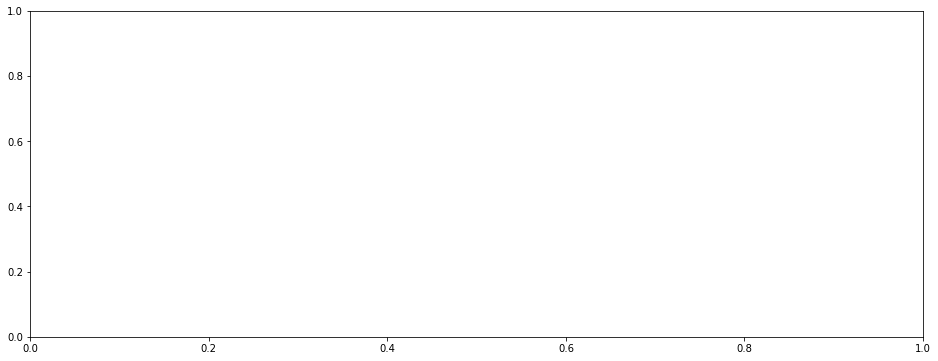

In [16]:
# Plot training and test loss
t = np.arange(iteration-1)
tt = t[t % interation_compute_val == compute_val_at]
tt = tt[1:]
plt.figure(figsize = (16,6))
plt.plot(t, np.array(train_loss), 'r-', tt, np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:

# Plot Accuracies# Plot A 
plt.figure(figsize = (16,6))

plt.plot(t, np.array(train_acc), 'r-', tt, validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Evaluate on test set

In [ ]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    sess.run(tf.local_variables_initializer())
    saver = tf.train.import_meta_graph('checkpoints\har-lstm.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))

    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    print(y_vld.shape)        
    for x_t, y_t in get_batches(X_vld, y_vld, batch_size): 
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1,
                initial_state: test_state}
        
        batch_acc, test_state = sess.run([ accuracy,final_state], feed_dict=feed)
        test_acc.append(batch_acc)
        print(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))


In [ ]:
import datetime
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
a = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  10],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0]])
print (a[a.max(axis=1) >= 10])


In [ ]:

a = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  9],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0]])
print (a[a[:,2]!=0])

In [ ]:
print(ytest[:]!=0)
Xtest = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  9],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0],
             [ 0, 11,  0, 13,  0, 15,  0, 11, 1,  1]])
ytest = np.array([ 0,  1,  1])
Xtest = Xtest[ytest[:]!=0,:]
ytest = ytest[ytest[:]!=0]
print(Xtest)
print(ytest)

In [ ]:
print(50%1)